In [1]:
 # These two lines are necessary only if GemPy is not installed
import sys, os
sys.path.append("../../..")

# Importing GemPy
import gempy as gp

# Embedding matplotlib figures in the notebooks
%matplotlib inline

# Importing auxiliary libraries
import numpy as np
import matplotlib.pyplot as plt
import pymc3 as pm

WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
Can not use cuDNN on context None: cannot compile with cuDNN. We got this error:
b'/tmp/try_flags_s5s7d9zh.c:4:10: fatal error: cudnn.h: No such file or directory\n #include <cudnn.h>\n          ^~~~~~~~~\ncompilation terminated.\n'
Mapped name None to device cuda: GeForce RTX 2080 (0000:01:00.0)


In [2]:
path_to_data = os.pardir+"/../data/input_data/jan_models/"

geo_data = gp.create_data([0,1000,0,1000,0,1000],resolution=[50,50,50], 
                        path_o = path_to_data + "model1_orientations.csv",
                        path_i = path_to_data + "model1_surface_points.csv") 

Active grids: ['regular']


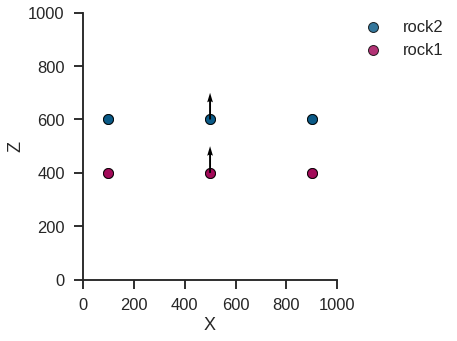

In [3]:
gp.plot.plot_data(geo_data)

We are going to make a likelihood function depending on the thickness of rock1 and 2. The most computing friendly way to do so is by adding the thickness as an attribute of the surfaces:

In [4]:
# This is the thickness of voxel
dz = geo_data.grid.regular_grid.dz
dz

20.0

In [5]:
geo_data.surfaces.add_surfaces_values([0, dz, 0], ['dz'])

,surface,series,order_surfaces,isBasement,color,id,dz
0,rock2,Default series,1,False,#015482,1,0
1,rock1,Default series,2,False,#9f0052,2,20
2,basement,Basement,1,True,#ffbe00,3,0


Now we can set the interpolator without compile theano. This will only create the graph:

In [6]:
gp.set_interpolation_data(geo_data, theano_optimizer='fast_run',
                          compile_theano=False, gradient=True)

## Compiling gempy with PyMC3

Next we need to compute a theano Op from the gempy graph:

In [7]:
import theano
import theano.tensor as T
theano.config.compute_test_value = 'ignore'

In [8]:
geo_model_T = theano.OpFromGraph(geo_data.interpolator.theano_graph.input_parameters_loop,
                               [geo_data.interpolator.theano_graph.compute_series()[0][1][0:125000]], inline=True,
                                 on_unused_input='warn',
                                 name='geo_model')

In [9]:
import theano
import theano.tensor as tt
theano.config.compute_test_value = 'ignore'
# We convert a python variable to theano.shared
input_sh = []
i = geo_data.interpolator.get_python_input_block()
for ii in i:
    input_sh.append(theano.shared(ii))

# We get the rescaling parameters:
rf = geo_data.rescaling.df.loc['values', 'rescaling factor']
centers = geo_data.rescaling.df.loc['values', 'centers']

# We create pandas groups by id to be able to modify several points at the same time:
g = geo_data.surface_points.df.groupby('id')
l = theano.shared(np.array([], dtype='float32'))

In [10]:
# PyMC3 model
theano.config.compute_test_value = 'ignore'

with pm.Model() as model:
    r2 = pm.Normal('rock2', 600, 50)
    r1 = pm.Normal('rock1', 400, 50)

    val2 = (r2 - centers[2]) / rf + 0.5001
    val1 = (r1 - centers[2]) / rf + 0.5001
    

    input_sh[4] = tt.set_subtensor(input_sh[4][g.groups[1], 2], val2)
    input_sh[4] = tt.set_subtensor(input_sh[4][g.groups[2], 2], val1)
    
    # we have to take the sol 0
    geo = geo_model_T(*input_sh)
    well = geo.reshape((50, 50, 50))[25,25,:]
   
    thickness = pm.Deterministic('thickness', well.sum())
    likelihood_function = pm.Normal('y', mu=thickness, sd=20, observed=120)
 #   b = pm.NUTS()
    db = pm.backends.NDArray('thickness_NUTS')
    trace = pm.sample(100, chains=1, tune=100, discard_tuned_samples=False,
                      #step =b, 
                      trace=db,
                      compute_convergence_checks=True)

/opt/miniconda3/envs/gempy/lib/python3.7/site-packages/theano/gof/op.py:670: UserWarning: theano.function was asked to create a function computing outputs given certain inputs, but the provided input variable at index 5 is not part of the computational graph needed to compute the outputs: Full block matrix for faults or drift. We take 2 times len points for the faultdrift..
To make this warning into an error, you can pass the parameter on_unused_input='raise' to theano.function. To disable it completely, use on_unused_input='ignore'.
  no_recycling=[])
/opt/miniconda3/envs/gempy/lib/python3.7/site-packages/theano/gof/op.py:670: UserWarning: theano.function was asked to create a function computing outputs given certain inputs, but the provided input variable at index 6 is not part of the computational graph needed to compute the outputs: Coordinates of the grid points to interpolate.
To make this warning into an error, you can pass the parameter on_unused_input='raise' to theano.functio

GpuArrayException: b'cuMemAlloc: CUDA_ERROR_OUT_OF_MEMORY: out of memory'
Apply node that caused the error: GpuElemwise{sub,no_inplace}(GpuArrayConstant{[[1]]}, GpuElemwise{mul,no_inplace}.0)
Toposort index: 194
Inputs types: [GpuArrayType<None>(int8, (True, True)), GpuArrayType<None>(float32, matrix)]
Inputs shapes: [(1, 1), (10, 125020)]
Inputs strides: [(1, 1), (500080, 4)]
Inputs values: [gpuarray.array([[1]], dtype=int8), 'not shown']
Inputs type_num: [1, 11]
Outputs clients: [[GpuElemwise{add,no_inplace}(GpuElemwise{sub,no_inplace}.0, GpuElemwise{mul,no_inplace}.0)]]

Backtrace when the node is created(use Theano flag traceback.limit=N to make it longer):
  File "../../../gempy/core/theano/theano_graph_pro.py", line 373, in compute_series
    profile=False
  File "/opt/miniconda3/envs/gempy/lib/python3.7/site-packages/theano/scan_module/scan.py", line 774, in scan
    condition, outputs, updates = scan_utils.get_updates_and_outputs(fn(*args))
  File "../../../gempy/core/theano/theano_graph_pro.py", line 1583, in compute_a_series
    Z_x = tif.ifelse(compute_scalar_ctr, self.compute_scalar_field(weights, self.grid_val_T),
  File "../../../gempy/core/theano/theano_graph_pro.py", line 327, in compute_scalar_field
    return self.scalar_field_at_all(weights, grid_val)
  File "../../../gempy/core/theano/theano_graph_pro.py", line 1236, in scalar_field_at_all
    return_list=True)
  File "/opt/miniconda3/envs/gempy/lib/python3.7/site-packages/theano/scan_module/scan.py", line 774, in scan
    condition, outputs, updates = scan_utils.get_updates_and_outputs(fn(*args))
  File "../../../gempy/core/theano/theano_graph_pro.py", line 1190, in scalar_field_loop
    sigma_0_interf = self.contribution_interface(grid_val[a:b], weights[:, a:b])
  File "../../../gempy/core/theano/theano_graph_pro.py", line 1087, in contribution_interface
    7 / 2 * (sed_rest_SimPoint / self.a_T_surface) ** 5 +
  File "../../../gempy/core/theano/theano_graph_pro.py", line 373, in compute_series
    profile=False
  File "/opt/miniconda3/envs/gempy/lib/python3.7/site-packages/theano/scan_module/scan.py", line 774, in scan
    condition, outputs, updates = scan_utils.get_updates_and_outputs(fn(*args))
  File "../../../gempy/core/theano/theano_graph_pro.py", line 1583, in compute_a_series
    Z_x = tif.ifelse(compute_scalar_ctr, self.compute_scalar_field(weights, self.grid_val_T),
  File "../../../gempy/core/theano/theano_graph_pro.py", line 327, in compute_scalar_field
    return self.scalar_field_at_all(weights, grid_val)
  File "../../../gempy/core/theano/theano_graph_pro.py", line 1236, in scalar_field_at_all
    return_list=True)
  File "/opt/miniconda3/envs/gempy/lib/python3.7/site-packages/theano/scan_module/scan.py", line 774, in scan
    condition, outputs, updates = scan_utils.get_updates_and_outputs(fn(*args))
  File "../../../gempy/core/theano/theano_graph_pro.py", line 1190, in scalar_field_loop
    sigma_0_interf = self.contribution_interface(grid_val[a:b], weights[:, a:b])
  File "../../../gempy/core/theano/theano_graph_pro.py", line 1087, in contribution_interface
    7 / 2 * (sed_rest_SimPoint / self.a_T_surface) ** 5 +

Debugprint of the apply node: 
GpuElemwise{sub,no_inplace} [id A] <GpuArrayType<None>(float32, matrix)> ''   
 |GpuArrayConstant{[[1]]} [id B] <GpuArrayType<None>(int8, (True, True))>
 |GpuElemwise{mul,no_inplace} [id C] <GpuArrayType<None>(float32, matrix)> ''   
   |GpuArrayConstant{[[7]]} [id D] <GpuArrayType<None>(int8, (True, True))>
   |GpuElemwise{pow,no_inplace} [id E] <GpuArrayType<None>(float32, matrix)> ''   
     |GpuElemwise{true_div,no_inplace} [id F] <GpuArrayType<None>(float32, matrix)> ''   
     | |GpuElemwise{sqrt,no_inplace} [id G] <GpuArrayType<None>(float32, matrix)> ''   
     | | |GpuElemwise{maximum,no_inplace} [id H] <GpuArrayType<None>(float32, matrix)> ''   
     | |   |GpuElemwise{sub,no_inplace} [id I] <GpuArrayType<None>(float32, matrix)> ''   
     | |   | |GpuElemwise{add,no_inplace} [id J] <GpuArrayType<None>(float32, matrix)> ''   
     | |   | | |GpuReshape{2} [id K] <GpuArrayType<None>(float32, col)> ''   
     | |   | | | |GpuCAReduceCuda{add}{1} [id L] <GpuArrayType<None>(float32, vector)> ''   
     | |   | | | | |GpuElemwise{pow,no_inplace} [id M] <GpuArrayType<None>(float32, matrix)> ''   
     | |   | | | |   |GpuSubtensor{int32:int32:, ::} [id N] <GpuArrayType<None>(float32, matrix)> ''   
     | |   | | | |   | |GpuAdvancedSubtensor1 [id O] <GpuArrayType<None>(float32, matrix)> ''   
     | |   | | | |   | | |All the surface_points points at once_copy[Gpua] [id P] <GpuArrayType<None>(float32, matrix)>
     | |   | | | |   | | |GpuContiguous [id Q] <GpuArrayType<None>(int64, vector)> ''   
     | |   | | | |   | |   |GpuSubtensor{int64} [id R] <GpuArrayType<None>(int64, vector)> ''   
     | |   | | | |   | |     |GpuFromHost<None> [id S] <GpuArrayType<None>(int64, matrix)> ''   
     | |   | | | |   | |     | |Nonzero [id T] <TensorType(int64, matrix)> ''   
     | |   | | | |   | |     |   |HostFromGpu(gpuarray) [id U] <TensorType(int16, vector)> ''   
     | |   | | | |   | |     |     |GpuAdvancedIncSubtensor1{inplace=False, set_instead_of_inc=True} [id V] <GpuArrayType<None>(int16, vector)> ''   
     | |   | | | |   | |     |       |GpuAlloc<None> [id W] <GpuArrayType<None>(int16, vector)> ''   
     | |   | | | |   | |     |       | |GpuArrayConstant{1} [id X] <GpuArrayType<None>(int16, scalar)>
     | |   | | | |   | |     |       | |Subtensor{int64} [id Y] <TensorType(int64, scalar)> ''   
     | |   | | | |   | |     |       |   |Shape [id Z] <TensorType(int64, vector)> ''   
     | |   | | | |   | |     |       |   | |All the surface_points points at once_copy[Gpua] [id P] <GpuArrayType<None>(float32, matrix)>
     | |   | | | |   | |     |       |   |Constant{0} [id BA] <int64>
     | |   | | | |   | |     |       |GpuArrayConstant{0} [id BB] <GpuArrayType<None>(int8, scalar)>
     | |   | | | |   | |     |       |CumOp{None, add} [id BC] <TensorType(int32, vector)> ''   
     | |   | | | |   | |     |         |HostFromGpu(gpuarray) [id BD] <TensorType(int32, vector)> ''   
     | |   | | | |   | |     |           |GpuJoin [id BE] <GpuArrayType<None>(int32, vector)> ''   
     | |   | | | |   | |     |             |TensorConstant{0} [id BF] <TensorType(int8, scalar)>
     | |   | | | |   | |     |             |GpuArrayConstant{[0]} [id BG] <GpuArrayType<None>(int8, vector)>
     | |   | | | |   | |     |             |GpuElemwise{add,no_inplace} [id BH] <GpuArrayType<None>(int32, vector)> ''   
     | |   | | | |   | |     |               |GpuSubtensor{:int64:} [id BI] <GpuArrayType<None>(int32, vector)> ''   
     | |   | | | |   | |     |               | |Number of points per surface used to split rest-ref_copy[Gpua] [id BJ] <GpuArrayType<None>(int32, vector)>
     | |   | | | |   | |     |               | |Constant{-1} [id BK] <int64>
     | |   | | | |   | |     |               |GpuArrayConstant{[1]} [id BL] <GpuArrayType<None>(int8, (True,))>
     | |   | | | |   | |     |Constant{0} [id BA] <int64>
     | |   | | | |   | |ScalarFromTensor [id BM] <int32> ''   
     | |   | | | |   | | |HostFromGpu(gpuarray) [id BN] <TensorType(int32, scalar)> ''   
     | |   | | | |   | |   |Length of surface_points in every series[t]_copy[Gpua] [id BO] <GpuArrayType<None>(int32, scalar)>
     | |   | | | |   | |ScalarFromTensor [id BP] <int32> ''   
     | |   | | | |   |   |HostFromGpu(gpuarray) [id BQ] <TensorType(int32, scalar)> ''   
     | |   | | | |   |     |Length of surface_points in every series[t+1]_copy[Gpua] [id BR] <GpuArrayType<None>(int32, scalar)>
     | |   | | | |   |GpuArrayConstant{[[2.]]} [id BS] <GpuArrayType<None>(float32, (True, True))>
     | |   | | | |MakeVector{dtype='int64'} [id BT] <TensorType(int64, vector)> ''   
     | |   | | |   |Subtensor{int64} [id BU] <TensorType(int64, scalar)> ''   
     | |   | | |   | |Shape [id BV] <TensorType(int64, vector)> ''   
     | |   | | |   | | |GpuSubtensor{int32:int32:, ::} [id N] <GpuArrayType<None>(float32, matrix)> ''   
     | |   | | |   | |Constant{0} [id BA] <int64>
     | |   | | |   |TensorConstant{1} [id BW] <TensorType(int64, scalar)>
     | |   | | |GpuReshape{2} [id BX] <GpuArrayType<None>(float32, row)> ''   
     | |   | |   |GpuCAReduceCuda{add}{1} [id BY] <GpuArrayType<None>(float32, vector)> ''   
     | |   | |   | |GpuElemwise{pow,no_inplace} [id BZ] <GpuArrayType<None>(float32, matrix)> ''   
     | |   | |   |   |GpuSubtensor{int64:int64:} [id CA] <GpuArrayType<None>(float32, matrix)> ''   
     | |   | |   |   | |<GpuArrayType<None>(float32, matrix)> [id CB] <GpuArrayType<None>(float32, matrix)>
     | |   | |   |   | |ScalarFromTensor [id CC] <int64> ''   
     | |   | |   |   | | |HostFromGpu(gpuarray) [id CD] <TensorType(int64, scalar)> ''   
     | |   | |   |   | |   |<GpuArrayType<None>(int64, scalar)> [id CE] <GpuArrayType<None>(int64, scalar)>
     | |   | |   |   | |ScalarFromTensor [id CF] <int64> ''   
     | |   | |   |   |   |HostFromGpu(gpuarray) [id CG] <TensorType(int64, scalar)> ''   
     | |   | |   |   |     |<GpuArrayType<None>(int64, scalar)> [id CH] <GpuArrayType<None>(int64, scalar)>
     | |   | |   |   |GpuArrayConstant{[[2.]]} [id CI] <GpuArrayType<None>(float32, (True, True))>
     | |   | |   |MakeVector{dtype='int64'} [id CJ] <TensorType(int64, vector)> ''   
     | |   | |     |TensorConstant{1} [id BW] <TensorType(int64, scalar)>
     | |   | |     |Subtensor{int64} [id CK] <TensorType(int64, scalar)> ''   
     | |   | |       |Shape [id CL] <TensorType(int64, vector)> ''   
     | |   | |       | |GpuSubtensor{int64:int64:} [id CA] <GpuArrayType<None>(float32, matrix)> ''   
     | |   | |       |Constant{0} [id BA] <int64>
     | |   | |GpuElemwise{mul,no_inplace} [id CM] <GpuArrayType<None>(float32, matrix)> ''   
     | |   |   |GpuArrayConstant{[[2]]} [id CN] <GpuArrayType<None>(int8, (True, True))>
     | |   |   |GpuDot22 [id CO] <GpuArrayType<None>(float32, matrix)> ''   
     | |   |     |GpuSubtensor{int32:int32:, ::} [id N] <GpuArrayType<None>(float32, matrix)> ''   
     | |   |     |InplaceGpuDimShuffle{1,0} [id CP] <GpuArrayType<None>(float32, matrix)> ''   
     | |   |       |GpuSubtensor{int64:int64:} [id CA] <GpuArrayType<None>(float32, matrix)> ''   
     | |   |GpuArrayConstant{[[1.e-12]]} [id CQ] <GpuArrayType<None>(float32, (True, True))>
     | |InplaceGpuDimShuffle{x,x} [id CR] <GpuArrayType<None>(float32, (True, True))> ''   
     |   |Range_copy[Gpua] [id CS] <GpuArrayType<None>(float32, scalar)>
     |GpuArrayConstant{[[2.]]} [id CT] <GpuArrayType<None>(float32, (True, True))>

HINT: Use the Theano flag 'exception_verbosity=high' for a debugprint and storage map footprint of this apply node.
Apply node that caused the error: for{gpu,Looping grid}(Elemwise{minimum,no_inplace}.0, GpuSubtensor{:int64:}.0, GpuSubtensor{:int64:}.0, GpuIncSubtensor{Set;:int64:}.0, <GpuArrayType<None>(float32, scalar)>, Range_copy[Gpua], Covariance at 0_copy[Gpua], Number of points per surface used to split rest-ref_copy[Gpua], <GpuArrayType<None>(float32, scalar)>, fault relation matrix_copy[Gpua], <GpuArrayType<None>(float64, scalar)>, GpuJoin.0, InplaceGpuDimShuffle{1,0}.0, Position of the dips_copy[Gpua], Length of foliations in every series[t][Gpua], Length of foliations in every series[t+1][Gpua], All the surface_points points at once_copy[Gpua], Length of surface_points in every series[t][Gpua], Length of surface_points in every series[t+1][Gpua], Grade of the universal drift[t][Gpua], block matrix[t-1][Gpua], <GpuArrayType<None>(int32, scalar)>)
Toposort index: 706
Inputs types: [TensorType(int64, scalar), GpuArrayType<None>(int64, vector), GpuArrayType<None>(int64, vector), GpuArrayType<None>(float32, matrix), GpuArrayType<None>(float32, scalar), GpuArrayType<None>(float32, scalar), GpuArrayType<None>(float32, scalar), GpuArrayType<None>(int32, vector), GpuArrayType<None>(float32, scalar), GpuArrayType<None>(int64, matrix), GpuArrayType<None>(float64, scalar), GpuArrayType<None>(float32, matrix), GpuArrayType<None>(float32, matrix), GpuArrayType<None>(float32, matrix), GpuArrayType<None>(int32, scalar), GpuArrayType<None>(int32, scalar), GpuArrayType<None>(float32, matrix), GpuArrayType<None>(int32, scalar), GpuArrayType<None>(int32, scalar), GpuArrayType<None>(int32, scalar), GpuArrayType<None>(float32, 3D), GpuArrayType<None>(int32, scalar)]
Inputs shapes: [(), (1,), (1,), (2, 125020), (), (), (), (2,), (), (2, 2), (), (125020, 3), (19, 125020), (2, 3), (), (), (12, 3), (), (), (), (1, 2, 125020), ()]
Inputs strides: [(), (8,), (8,), (500080, 4), (), (), (), (4,), (), (16, 8), (), (12, 4), (4, 76), (12, 4), (), (), (12, 4), (), (), (), (1000160, 500080, 4), ()]
Inputs values: [array(1), gpuarray.array([0]), gpuarray.array([125020]), 'not shown', gpuarray.array(2., dtype=float32), gpuarray.array(1.0825318, dtype=float32), gpuarray.array(44.642857, dtype=float32), gpuarray.array([5, 5], dtype=int32), gpuarray.array(4., dtype=float32), gpuarray.array([[0, 0],
       [0, 0]]), gpuarray.array(10.), 'not shown', 'not shown', 'not shown', gpuarray.array(0, dtype=int32), gpuarray.array(2, dtype=int32), 'not shown', gpuarray.array(0, dtype=int32), gpuarray.array(10, dtype=int32), gpuarray.array(3, dtype=int32), 'not shown', gpuarray.array(0, dtype=int32)]
Inputs type_num: [7, 7, 7, 11, 11, 11, 11, 5, 11, 7, 12, 11, 11, 11, 5, 5, 11, 5, 5, 5, 11, 5]
Outputs clients: [[GpuSubtensor{int64::}(for{gpu,Looping grid}.0, Constant{1})]]

Backtrace when the node is created(use Theano flag traceback.limit=N to make it longer):
  File "/opt/miniconda3/envs/gempy/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3249, in run_ast_nodes
    if (await self.run_code(code, result,  async_=asy)):
  File "/opt/miniconda3/envs/gempy/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3326, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-8-f1b924e1f49b>", line 2, in <module>
    [geo_data.interpolator.theano_graph.compute_series()[0][1][0:125000]], inline=True,
  File "../../../gempy/core/theano/theano_graph_pro.py", line 373, in compute_series
    profile=False
  File "/opt/miniconda3/envs/gempy/lib/python3.7/site-packages/theano/scan_module/scan.py", line 774, in scan
    condition, outputs, updates = scan_utils.get_updates_and_outputs(fn(*args))
  File "../../../gempy/core/theano/theano_graph_pro.py", line 1583, in compute_a_series
    Z_x = tif.ifelse(compute_scalar_ctr, self.compute_scalar_field(weights, self.grid_val_T),
  File "../../../gempy/core/theano/theano_graph_pro.py", line 327, in compute_scalar_field
    return self.scalar_field_at_all(weights, grid_val)
  File "../../../gempy/core/theano/theano_graph_pro.py", line 1236, in scalar_field_at_all
    return_list=True)

Debugprint of the apply node: 
for{gpu,Looping grid} [id A] <GpuArrayType<None>(float32, matrix)> ''   
 |Elemwise{minimum,no_inplace} [id B] <TensorType(int64, scalar)> ''   
 | |Subtensor{int64} [id C] <TensorType(int64, scalar)> ''   
 | | |Shape [id D] <TensorType(int64, vector)> ''   
 | | | |Subtensor{int64:int64:} [id E] <TensorType(int64, vector)> ''   
 | | |   |Join [id F] <TensorType(int64, vector)> ''   
 | | |   | |TensorConstant{0} [id G] <TensorType(int8, scalar)>
 | | |   | |ARange{dtype='int64'} [id H] <TensorType(int64, vector)> ''   
 | | |   | | |TensorConstant{0} [id G] <TensorType(int8, scalar)>
 | | |   | | |Subtensor{int64} [id I] <TensorType(int64, scalar)> ''   
 | | |   | | | |Shape [id J] <TensorType(int64, vector)> ''   
 | | |   | | | | |GpuJoin [id K] <GpuArrayType<None>(float32, matrix)> ''   
 | | |   | | | |   |TensorConstant{0} [id L] <TensorType(int8, scalar)>
 | | |   | | | |   |Constant values to interpolate._copy[Gpua] [id M] <GpuArrayType<None>(float32, matrix)>
 | | |   | | | |   |GpuAdvancedSubtensor1 [id N] <GpuArrayType<None>(float32, matrix)> ''   
 | | |   | | | |   | |All the surface_points points at once_copy[Gpua] [id O] <GpuArrayType<None>(float32, matrix)>
 | | |   | | | |   | |GpuContiguous [id P] <GpuArrayType<None>(int64, vector)> ''   
 | | |   | | | |   |   |GpuSubtensor{int64} [id Q] <GpuArrayType<None>(int64, vector)> ''   
 | | |   | | | |   |     |GpuFromHost<None> [id R] <GpuArrayType<None>(int64, matrix)> ''   
 | | |   | | | |   |     | |Nonzero [id S] <TensorType(int64, matrix)> ''   
 | | |   | | | |   |     |   |HostFromGpu(gpuarray) [id T] <TensorType(int16, vector)> ''   
 | | |   | | | |   |     |     |GpuAdvancedIncSubtensor1{inplace=False, set_instead_of_inc=True} [id U] <GpuArrayType<None>(int16, vector)> ''   
 | | |   | | | |   |     |       |GpuAlloc<None> [id V] <GpuArrayType<None>(int16, vector)> ''   
 | | |   | | | |   |     |       | |GpuArrayConstant{1} [id W] <GpuArrayType<None>(int16, scalar)>
 | | |   | | | |   |     |       | |Subtensor{int64} [id X] <TensorType(int64, scalar)> ''   
 | | |   | | | |   |     |       |   |Shape [id Y] <TensorType(int64, vector)> ''   
 | | |   | | | |   |     |       |   | |All the surface_points points at once_copy[Gpua] [id O] <GpuArrayType<None>(float32, matrix)>
 | | |   | | | |   |     |       |   |Constant{0} [id Z] <int64>
 | | |   | | | |   |     |       |GpuArrayConstant{0} [id BA] <GpuArrayType<None>(int8, scalar)>
 | | |   | | | |   |     |       |CumOp{None, add} [id BB] <TensorType(int32, vector)> ''   
 | | |   | | | |   |     |         |HostFromGpu(gpuarray) [id BC] <TensorType(int32, vector)> ''   
 | | |   | | | |   |     |           |GpuJoin [id BD] <GpuArrayType<None>(int32, vector)> ''   
 | | |   | | | |   |     |             |TensorConstant{0} [id BE] <TensorType(int8, scalar)>
 | | |   | | | |   |     |             |GpuArrayConstant{[0]} [id BF] <GpuArrayType<None>(int8, vector)>
 | | |   | | | |   |     |             |GpuElemwise{add,no_inplace} [id BG] <GpuArrayType<None>(int32, vector)> ''   
 | | |   | | | |   |     |               |GpuSubtensor{:int64:} [id BH] <GpuArrayType<None>(int32, vector)> ''   
 | | |   | | | |   |     |               | |Number of points per surface used to split rest-ref_copy[Gpua] [id BI] <GpuArrayType<None>(int32, vector)>
 | | |   | | | |   |     |               | |Constant{-1} [id BJ] <int64>
 | | |   | | | |   |     |               |GpuArrayConstant{[1]} [id BK] <GpuArrayType<None>(int8, (True,))>
 | | |   | | | |   |     |Constant{0} [id Z] <int64>
 | | |   | | | |   |GpuSubtensor{int64} [id BL] <GpuArrayType<None>(float32, matrix)> ''   
 | | |   | | | |     |GpuSubtensor{int64::} [id BM] <GpuArrayType<None>(float32, 3D)> ''   
 | | |   | | | |     | |for{gpu,scan_fn} [id BN] <GpuArrayType<None>(float32, 3D)> ''   
 | | |   | | | |     | | |Elemwise{minimum,no_inplace} [id BO] <TensorType(int64, scalar)> ''   
 | | |   | | | |     | | | |Elemwise{minimum,no_inplace} [id BP] <TensorType(int64, scalar)> ''   
 | | |   | | | |     | | | | |Subtensor{int64} [id BQ] <TensorType(int64, scalar)> ''   
 | | |   | | | |     | | | | | |Shape [id BR] <TensorType(int64, vector)> ''   
 | | |   | | | |     | | | | | | |GpuSubtensor{int64::} [id BS] <GpuArrayType<None>(float32, matrix)> ''   
 | | |   | | | |     | | | | | |   |GpuAdvancedSubtensor1 [id BT] <GpuArrayType<None>(float32, matrix)> ''   
 | | |   | | | |     | | | | | |   | |All the surface_points points at once_copy[Gpua] [id O] <GpuArrayType<None>(float32, matrix)>
 | | |   | | | |     | | | | | |   | |GpuContiguous [id BU] <GpuArrayType<None>(int64, vector)> ''   
 | | |   | | | |     | | | | | |   |   |GpuElemwise{Cast{int64}}[]<gpuarray> [id BV] <GpuArrayType<None>(int64, vector)> ''   
 | | |   | | | |     | | | | | |   |     |GpuFromHost<None> [id BW] <GpuArrayType<None>(int32, vector)> ''   
 | | |   | | | |     | | | | | |   |       |CumOp{None, add} [id BB] <TensorType(int32, vector)> ''   
 | | |   | | | |     | | | | | |   |Constant{0} [id Z] <int64>
 | | |   | | | |     | | | | | |Constant{0} [id Z] <int64>
 | | |   | | | |     | | | | |Subtensor{int64} [id BX] <TensorType(int64, scalar)> ''   
 | | |   | | | |     | | | |   |Shape [id BY] <TensorType(int64, vector)> ''   
 | | |   | | | |     | | | |   | |Subtensor{int64:int64:} [id BZ] <TensorType(int32, vector)> ''   
 | | |   | | | |     | | | |   |   |CumOp{None, add} [id CA] <TensorType(int32, vector)> ''   
 | | |   | | | |     | | | |   |   | |HostFromGpu(gpuarray) [id CB] <TensorType(int32, vector)> ''   
 | | |   | | | |     | | | |   |   |   |GpuJoin [id CC] <GpuArrayType<None>(int32, vector)> ''   
 | | |   | | | |     | | | |   |   |     |TensorConstant{0} [id CD] <TensorType(int8, scalar)>
 | | |   | | | |     | | | |   |   |     |GpuArrayConstant{[0]} [id CE] <GpuArrayType<None>(int8, vector)>
 | | |   | | | |     | | | |   |   |     |Number of points per surface used to split rest-ref_copy[Gpua] [id BI] <GpuArrayType<None>(int32, vector)>
 | | |   | | | |     | | | |   |   |Constant{0} [id Z] <int64>
 | | |   | | | |     | | | |   |   |Constant{-1} [id BJ] <int64>
 | | |   | | | |     | | | |   |Constant{0} [id Z] <int64>
 | | |   | | | |     | | | |Subtensor{int64} [id CF] <TensorType(int64, scalar)> ''   
 | | |   | | | |     | | |   |Shape [id CG] <TensorType(int64, vector)> ''   
 | | |   | | | |     | | |   | |Subtensor{int64::} [id CH] <TensorType(int32, vector)> ''   
 | | |   | | | |     | | |   |   |CumOp{None, add} [id CA] <TensorType(int32, vector)> ''   
 | | |   | | | |     | | |   |   |Constant{1} [id CI] <int64>
 | | |   | | | |     | | |   |Constant{0} [id Z] <int64>
 | | |   | | | |     | | |GpuSubtensor{:int64:} [id CJ] <GpuArrayType<None>(float32, matrix)> ''   
 | | |   | | | |     | | | |GpuSubtensor{int64::} [id BS] <GpuArrayType<None>(float32, matrix)> ''   
 | | |   | | | |     | | | |ScalarFromTensor [id CK] <int64> ''   
 | | |   | | | |     | | |   |Elemwise{minimum,no_inplace} [id BO] <TensorType(int64, scalar)> ''   
 | | |   | | | |     | | |GpuSubtensor{:int64:} [id CL] <GpuArrayType<None>(int32, vector)> ''   
 | | |   | | | |     | | | |GpuFromHost<None> [id CM] <GpuArrayType<None>(int32, vector)> ''   
 | | |   | | | |     | | | | |Subtensor{int64:int64:} [id BZ] <TensorType(int32, vector)> ''   
 | | |   | | | |     | | | |ScalarFromTensor [id CK] <int64> ''   
 | | |   | | | |     | | |GpuSubtensor{:int64:} [id CN] <GpuArrayType<None>(int32, vector)> ''   
 | | |   | | | |     | | | |GpuFromHost<None> [id CO] <GpuArrayType<None>(int32, vector)> ''   
 | | |   | | | |     | | | | |Subtensor{int64::} [id CH] <TensorType(int32, vector)> ''   
 | | |   | | | |     | | | |ScalarFromTensor [id CK] <int64> ''   
 | | |   | | | |     | | |GpuIncSubtensor{Set;:int64:} [id CP] <GpuArrayType<None>(float32, 3D)> ''   
 | | |   | | | |     | |   |GpuAllocEmpty{dtype='float32', context_name=None} [id CQ] <GpuArrayType<None>(float32, 3D)> ''   
 | | |   | | | |     | |   | |Elemwise{add,no_inplace} [id CR] <TensorType(int64, scalar)> ''   
 | | |   | | | |     | |   | | |Elemwise{minimum,no_inplace} [id BO] <TensorType(int64, scalar)> ''   
 | | |   | | | |     | |   | | |Subtensor{int64} [id CS] <TensorType(int64, scalar)> ''   
 | | |   | | | |     | |   | |   |Shape [id CT] <TensorType(int64, vector)> ''   
 | | |   | | | |     | |   | |   | |Rebroadcast{0} [id CU] <GpuArrayType<None>(float32, 3D)> ''   
 | | |   | | | |     | |   | |   |   |InplaceGpuDimShuffle{x,0,1} [id CV] <GpuArrayType<None>(float32, (True, False, False))> ''   
 | | |   | | | |     | |   | |   |     |GpuAlloc<None> [id CW] <GpuArrayType<None>(float32, matrix)> ''   
 | | |   | | | |     | |   | |   |       |GpuArrayConstant{0.0} [id CX] <GpuArrayType<None>(float32, scalar)>
 | | |   | | | |     | |   | |   |       |Subtensor{int64} [id CY] <TensorType(int32, scalar)> ''   
 | | |   | | | |     | |   | |   |       | |CumOp{None, add} [id CA] <TensorType(int32, vector)> ''   
 | | |   | | | |     | |   | |   |       | |Constant{-1} [id BJ] <int64>
 | | |   | | | |     | |   | |   |       |TensorConstant{3} [id CZ] <TensorType(int8, scalar)>
 | | |   | | | |     | |   | |   |Constant{0} [id Z] <int64>
 | | |   | | | |     | |   | |Subtensor{int64} [id DA] <TensorType(int64, scalar)> ''   
 | | |   | | | |     | |   | | |Shape [id CT] <TensorType(int64, vector)> ''   
 | | |   | | | |     | |   | | |Constant{1} [id CI] <int64>
 | | |   | | | |     | |   | |Subtensor{int64} [id DB] <TensorType(int64, scalar)> ''   
 | | |   | | | |     | |   |   |Shape [id CT] <TensorType(int64, vector)> ''   
 | | |   | | | |     | |   |   |Constant{2} [id DC] <int64>
 | | |   | | | |     | |   |Rebroadcast{0} [id CU] <GpuArrayType<None>(float32, 3D)> ''   
 | | |   | | | |     | |   |ScalarFromTensor [id DD] <int64> ''   
 | | |   | | | |     | |     |Subtensor{int64} [id CS] <TensorType(int64, scalar)> ''   
 | | |   | | | |     | |Constant{1} [id CI] <int64>
 | | |   | | | |     |Constant{-1} [id BJ] <int64>
 | | |   | | | |Constant{0} [id Z] <int64>
 | | |   | | |HostFromGpu(gpuarray) [id DE] <TensorType(float64, scalar)> ''   
 | | |   | |   |GpuElemwise{true_div,no_inplace} [id DF] <GpuArrayType<None>(float64, scalar)> ''   
 | | |   | |     |InplaceGpuDimShuffle{} [id DG] <GpuArrayType<None>(float64, scalar)> ''   
 | | |   | |     | |InplaceGpuDimShuffle{x} [id DH] <GpuArrayType<None>(float64, (True,))> ''   
 | | |   | |     |   |GpuElemwise{true_div,no_inplace} [id DI] <GpuArrayType<None>(float64, scalar)> ''   
 | | |   | |     |     |GpuArrayConstant{1000000000000.0} [id DJ] <GpuArrayType<None>(float32, scalar)>
 | | |   | |     |     |GpuElemwise{add,no_inplace} [id DK] <GpuArrayType<None>(int64, scalar)> ''   
 | | |   | |     |       |GpuElemwise{add,no_inplace} [id DL] <GpuArrayType<None>(int64, scalar)> ''   
 | | |   | |     |       | |GpuFromHost<None> [id DM] <GpuArrayType<None>(int64, scalar)> ''   
 | | |   | |     |       | | |Elemwise{add,no_inplace} [id DN] <TensorType(int64, scalar)> ''   
 | | |   | |     |       | |   |Subtensor{int64} [id DO] <TensorType(int64, scalar)> ''   
 | | |   | |     |       | |   | |Shape [id DP] <TensorType(int64, vector)> ''   
 | | |   | |     |       | |   | | |GpuReshape{2} [id DQ] <GpuArrayType<None>(float32, matrix)> ''   
 | | |   | |     |       | |   | |   |InplaceGpuDimShuffle{0,2,1,3} [id DR] <GpuArrayType<None>(float32, (False, False, True, False))> ''   
 | | |   | |     |       | |   | |   | |GpuAlloc<None> [id DS] <GpuArrayType<None>(float32, (False, True, False, False))> ''   
 | | |   | |     |       | |   | |   |   |GpuSubtensor{int32:int32:, ::} [id DT] <GpuArrayType<None>(float32, matrix)> ''   
 | | |   | |     |       | |   | |   |   | |Position of the dips_copy[Gpua] [id DU] <GpuArrayType<None>(float32, matrix)>
 | | |   | |     |       | |   | |   |   | |ScalarFromTensor [id DV] <int32> ''   
 | | |   | |     |       | |   | |   |   | | |HostFromGpu(gpuarray) [id DW] <TensorType(int32, scalar)> ''   
 | | |   | |     |       | |   | |   |   | |   |Length of foliations in every series[t][Gpua] [id DX] <GpuArrayType<None>(int32, scalar)>
 | | |   | |     |       | |   | |   |   | |ScalarFromTensor [id DY] <int32> ''   
 | | |   | |     |       | |   | |   |   |   |HostFromGpu(gpuarray) [id DZ] <TensorType(int32, scalar)> ''   
 | | |   | |     |       | |   | |   |   |     |Length of foliations in every series[t+1][Gpua] [id EA] <GpuArrayType<None>(int32, scalar)>
 | | |   | |     |       | |   | |   |   |TensorConstant{3} [id CZ] <TensorType(int8, scalar)>
 | | |   | |     |       | |   | |   |   |TensorConstant{1} [id EB] <TensorType(int8, scalar)>
 | | |   | |     |       | |   | |   |   |Subtensor{int64} [id EC] <TensorType(int64, scalar)> ''   
 | | |   | |     |       | |   | |   |   | |Shape [id ED] <TensorType(int64, vector)> ''   
 | | |   | |     |       | |   | |   |   | | |GpuSubtensor{int32:int32:, ::} [id DT] <GpuArrayType<None>(float32, matrix)> ''   
 | | |   | |     |       | |   | |   |   | |Constant{0} [id Z] <int64>
 | | |   | |     |       | |   | |   |   |Subtensor{int64} [id EE] <TensorType(int64, scalar)> ''   
 | | |   | |     |       | |   | |   |     |Shape [id ED] <TensorType(int64, vector)> ''   
 | | |   | |     |       | |   | |   |     |Constant{1} [id CI] <int64>
 | | |   | |     |       | |   | |   |MakeVector{dtype='int64'} [id EF] <TensorType(int64, vector)> ''   
 | | |   | |     |       | |   | |     |Elemwise{mul,no_inplace} [id EG] <TensorType(int64, scalar)> ''   
 | | |   | |     |       | |   | |     | |Subtensor{int64} [id EC] <TensorType(int64, scalar)> ''   
 | | |   | |     |       | |   | |     | |TensorConstant{3} [id CZ] <TensorType(int8, scalar)>
 | | |   | |     |       | |   | |     |Elemwise{mul,no_inplace} [id EH] <TensorType(int64, scalar)> ''   
 | | |   | |     |       | |   | |       |Subtensor{int64} [id EE] <TensorType(int64, scalar)> ''   
 | | |   | |     |       | |   | |       |TensorConstant{1} [id EB] <TensorType(int8, scalar)>
 | | |   | |     |       | |   | |Constant{0} [id Z] <int64>
 | | |   | |     |       | |   |Subtensor{int64} [id EI] <TensorType(int64, scalar)> ''   
 | | |   | |     |       | |     |Shape [id EJ] <TensorType(int64, vector)> ''   
 | | |   | |     |       | |     | |GpuSubtensor{int32:int32:, ::} [id EK] <GpuArrayType<None>(float32, matrix)> ''   
 | | |   | |     |       | |     |   |GpuAdvancedSubtensor1 [id N] <GpuArrayType<None>(float32, matrix)> ''   
 | | |   | |     |       | |     |   |ScalarFromTensor [id EL] <int32> ''   
 | | |   | |     |       | |     |   | |HostFromGpu(gpuarray) [id EM] <TensorType(int32, scalar)> ''   
 | | |   | |     |       | |     |   |   |Length of surface_points in every series[t][Gpua] [id EN] <GpuArrayType<None>(int32, scalar)>
 | | |   | |     |       | |     |   |ScalarFromTensor [id EO] <int32> ''   
 | | |   | |     |       | |     |     |HostFromGpu(gpuarray) [id EP] <TensorType(int32, scalar)> ''   
 | | |   | |     |       | |     |       |Length of surface_points in every series[t+1][Gpua] [id EQ] <GpuArrayType<None>(int32, scalar)>
 | | |   | |     |       | |     |Constant{0} [id Z] <int64>
 | | |   | |     |       | |Grade of the universal drift[t][Gpua] [id ER] <GpuArrayType<None>(int32, scalar)>
 | | |   | |     |       |GpuFromHost<None> [id ES] <GpuArrayType<None>(int32, scalar)> ''   
 | | |   | |     |         |Elemwise{Cast{int32}} [id ET] <TensorType(int32, scalar)> ''   
 | | |   | |     |           |Subtensor{int64} [id EU] <TensorType(int64, scalar)> ''   
 | | |   | |     |             |Shape [id EV] <TensorType(int64, vector)> ''   
 | | |   | |     |             | |GpuElemwise{mul,no_inplace} [id EW] <GpuArrayType<None>(float64, matrix)> ''   
 | | |   | |     |             |   |GpuAdvancedSubtensor [id EX] <GpuArrayType<None>(float32, matrix)> ''   
 | | |   | |     |             |   | |block matrix[t-1][Gpua] [id EY] <GpuArrayType<None>(float32, 3D)>
 | | |   | |     |             |   | |Subtensor{int64} [id EZ] <TensorType(int64, vector)> ''   
 | | |   | |     |             |   | | |Nonzero [id FA] <TensorType(int64, matrix)> ''   
 | | |   | |     |             |   | | | |HostFromGpu(gpuarray) [id FB] <TensorType(int8, vector)> ''   
 | | |   | |     |             |   | | |   |GpuElemwise{Cast{int8}}[]<gpuarray> [id FC] <GpuArrayType<None>(int8, vector)> ''   
 | | |   | |     |             |   | | |     |GpuSubtensor{::, int8} [id FD] <GpuArrayType<None>(int64, vector)> ''   
 | | |   | |     |             |   | | |       |fault relation matrix_copy[Gpua] [id FE] <GpuArrayType<None>(int64, matrix)>
 | | |   | |     |             |   | | |       |ScalarFromTensor [id FF] <int8> ''   
 | | |   | |     |             |   | | |         |HostFromGpu(gpuarray) [id FG] <TensorType(int8, scalar)> ''   
 | | |   | |     |             |   | | |           |GpuElemwise{Cast{int8}}[]<gpuarray> [id FH] <GpuArrayType<None>(int8, scalar)> ''   
 | | |   | |     |             |   | | |             |<GpuArrayType<None>(int32, scalar)> [id FI] <GpuArrayType<None>(int32, scalar)>
 | | |   | |     |             |   | | |Constant{0} [id Z] <int64>
 | | |   | |     |             |   | |TensorConstant{0} [id FJ] <TensorType(int64, scalar)>
 | | |   | |     |             |   | |SliceConstant{None, None, None} [id FK] <slice>
 | | |   | |     |             |   |InplaceGpuDimShuffle{x,x} [id FL] <GpuArrayType<None>(float64, (True, True))> ''   
 | | |   | |     |             |     |<GpuArrayType<None>(float64, scalar)> [id FM] <GpuArrayType<None>(float64, scalar)>
 | | |   | |     |             |Constant{0} [id Z] <int64>
 | | |   | |     |GpuFromHost<None> [id FN] <GpuArrayType<None>(int64, scalar)> ''   
 | | |   | |       |Subtensor{int64} [id I] <TensorType(int64, scalar)> ''   
 | | |   | |MakeVector{dtype='int64'} [id FO] <TensorType(int64, vector)> ''   
 | | |   |   |Subtensor{int64} [id I] <TensorType(int64, scalar)> ''   
 | | |   |Constant{0} [id Z] <int64>
 | | |   |Constant{-1} [id BJ] <int64>
 | | |Constant{0} [id Z] <int64>
 | |Subtensor{int64} [id FP] <TensorType(int64, scalar)> ''   
 |   |Shape [id FQ] <TensorType(int64, vector)> ''   
 |   | |Subtensor{int64::} [id FR] <TensorType(int64, vector)> ''   
 |   |   |Join [id F] <TensorType(int64, vector)> ''   
 |   |   |Constant{1} [id CI] <int64>
 |   |Constant{0} [id Z] <int64>
 |GpuSubtensor{:int64:} [id FS] <GpuArrayType<None>(int64, vector)> ''   
 | |GpuFromHost<None> [id FT] <GpuArrayType<None>(int64, vector)> ''   
 | | |Subtensor{int64:int64:} [id E] <TensorType(int64, vector)> ''   
 | |ScalarFromTensor [id FU] <int64> ''   
 |   |Elemwise{minimum,no_inplace} [id B] <TensorType(int64, scalar)> ''   
 |GpuSubtensor{:int64:} [id FV] <GpuArrayType<None>(int64, vector)> ''   
 | |GpuFromHost<None> [id FW] <GpuArrayType<None>(int64, vector)> ''   
 | | |Subtensor{int64::} [id FR] <TensorType(int64, vector)> ''   
 | |ScalarFromTensor [id FU] <int64> ''   
 |GpuIncSubtensor{Set;:int64:} [id FX] <GpuArrayType<None>(float32, matrix)> ''   
 | |GpuAllocEmpty{dtype='float32', context_name=None} [id FY] <GpuArrayType<None>(float32, matrix)> ''   
 | | |Elemwise{add,no_inplace} [id FZ] <TensorType(int64, scalar)> ''   
 | | | |Elemwise{minimum,no_inplace} [id B] <TensorType(int64, scalar)> ''   
 | | | |Subtensor{int64} [id GA] <TensorType(int64, scalar)> ''   
 | | |   |Shape [id GB] <TensorType(int64, vector)> ''   
 | | |   | |Rebroadcast{0} [id GC] <GpuArrayType<None>(float32, matrix)> ''   
 | | |   |   |InplaceGpuDimShuffle{x,0} [id GD] <GpuArrayType<None>(float32, row)> ''   
 | | |   |     |GpuAlloc<None> [id GE] <GpuArrayType<None>(float32, vector)> ''   
 | | |   |       |GpuArrayConstant{0.0} [id GF] <GpuArrayType<None>(float32, scalar)>
 | | |   |       |Subtensor{int64} [id I] <TensorType(int64, scalar)> ''   
 | | |   |Constant{0} [id Z] <int64>
 | | |Subtensor{int64} [id GG] <TensorType(int64, scalar)> ''   
 | |   |Shape [id GB] <TensorType(int64, vector)> ''   
 | |   |Constant{1} [id CI] <int64>
 | |Rebroadcast{0} [id GC] <GpuArrayType<None>(float32, matrix)> ''   
 | |ScalarFromTensor [id GH] <int64> ''   
 |   |Subtensor{int64} [id GA] <TensorType(int64, scalar)> ''   
 |<GpuArrayType<None>(float32, scalar)> [id GI] <GpuArrayType<None>(float32, scalar)>
 |Range_copy[Gpua] [id GJ] <GpuArrayType<None>(float32, scalar)>
 |Covariance at 0_copy[Gpua] [id GK] <GpuArrayType<None>(float32, scalar)>
 |Number of points per surface used to split rest-ref_copy[Gpua] [id BI] <GpuArrayType<None>(int32, vector)>
 |<GpuArrayType<None>(float32, scalar)> [id GL] <GpuArrayType<None>(float32, scalar)>
 |fault relation matrix_copy[Gpua] [id FE] <GpuArrayType<None>(int64, matrix)>
 |<GpuArrayType<None>(float64, scalar)> [id FM] <GpuArrayType<None>(float64, scalar)>
 |GpuJoin [id K] <GpuArrayType<None>(float32, matrix)> ''   
 |InplaceGpuDimShuffle{1,0} [id GM] <GpuArrayType<None>(float32, matrix)> ''   
 | |GpuReshape{2} [id GN] <GpuArrayType<None>(float32, matrix)> ''   
 |   |InplaceGpuDimShuffle{0,2,1,3} [id GO] <GpuArrayType<None>(float32, (False, True, True, False))> ''   
 |   | |GpuAlloc<None> [id GP] <GpuArrayType<None>(float32, (False, True, True, False))> ''   
 |   |   |if{gpu} [id GQ] <GpuArrayType<None>(float32, vector)> ''   
 |   |   | |HostFromGpu(gpuarray) [id GR] <TensorType(bool, scalar)> ''   
 |   |   | | |Vector controlling if weights must be recomputed[t][Gpua] [id GS] <GpuArrayType<None>(bool, scalar)>
 |   |   | |GpuReshape{1} [id GT] <GpuArrayType<None>(float32, vector)> ''   
 |   |   | | |GpuCusolverSolve{A_structure='general', trans='N', inplace=False} [id GU] <GpuArrayType<None>(float32, matrix)> ''   
 |   |   | | | |GpuContiguous [id GV] <GpuArrayType<None>(float32, matrix)> ''   
 |   |   | | | | |GpuIncSubtensor{Set;int64::, int64:int64:} [id GW] <GpuArrayType<None>(float32, matrix)> ''   
 |   |   | | | |   |GpuIncSubtensor{Set;int64::, int64:int64:} [id GX] <GpuArrayType<None>(float32, matrix)> ''   
 |   |   | | | |   | |GpuIncSubtensor{Set;int64:int64:, int64:int64:} [id GY] <GpuArrayType<None>(float32, matrix)> ''   
 |   |   | | | |   | | |GpuIncSubtensor{Set;int64:int64:, int64:int64:} [id GZ] <GpuArrayType<None>(float32, matrix)> ''   
 |   |   | | | |   | | | |GpuIncSubtensor{Set;int64:int64:, int64::} [id HA] <GpuArrayType<None>(float32, matrix)> ''   
 |   |   | | | |   | | | | |GpuIncSubtensor{Set;int64:int64:, int64:int64:} [id HB] <GpuArrayType<None>(float32, matrix)> ''   
 |   |   | | | |   | | | | | |GpuIncSubtensor{Set;int64:int64:, int64:int64:} [id HC] <GpuArrayType<None>(float32, matrix)> ''   
 |   |   | | | |   | | | | | | |GpuIncSubtensor{Set;int64:int64:, int64:int64:} [id HD] <GpuArrayType<None>(float32, matrix)> ''   
 |   |   | | | |   | | | | | | | |GpuIncSubtensor{Set;int64:int64:, int64::} [id HE] <GpuArrayType<None>(float32, matrix)> ''   
 |   |   | | | |   | | | | | | | | |GpuIncSubtensor{Set;int64:int64:, int64:int64:} [id HF] <GpuArrayType<None>(float32, matrix)> ''   
 |   |   | | | |   | | | | | | | | | |GpuIncSubtensor{Set;int64:int64:, int64:int64:} [id HG] <GpuArrayType<None>(float32, matrix)> ''   
 |   |   | | | |   | | | | | | | | | | |GpuIncSubtensor{Set;int64:int64:, int64:int64:} [id HH] <GpuArrayType<None>(float32, matrix)> ''   
 |   |   | | | |   | | | | | | | | | | | |GpuAlloc<None> [id HI] <GpuArrayType<None>(float32, matrix)> ''   
 |   |   | | | |   | | | | | | | | | | | | |GpuArrayConstant{0.0} [id HJ] <GpuArrayType<None>(float32, scalar)>
 |   |   | | | |   | | | | | | | | | | | | |HostFromGpu(gpuarray) [id HK] <TensorType(int64, scalar)> ''   
 |   |   | | | |   | | | | | | | | | | | | | |GpuElemwise{add,no_inplace} [id DK] <GpuArrayType<None>(int64, scalar)> ''   
 |   |   | | | |   | | | | | | | | | | | | |HostFromGpu(gpuarray) [id HL] <TensorType(int64, scalar)> ''   
 |   |   | | | |   | | | | | | | | | | | |   |GpuElemwise{add,no_inplace} [id DK] <GpuArrayType<None>(int64, scalar)> ''   
 |   |   | | | |   | | | | | | | | | | | |GpuElemwise{add,no_inplace} [id HM] <GpuArrayType<None>(float32, matrix)> ''   
 |   |   | | | |   | | | | | | | | | | | | |GpuElemwise{switch,no_inplace} [id HN] <GpuArrayType<None>(float32, matrix)> ''   
 |   |   | | | |   | | | | | | | | | | | | | |GpuElemwise{eq,no_inplace} [id HO] <GpuArrayType<None>(bool, matrix)> ''   
 |   |   | | | |   | | | | | | | | | | | | | | |GpuElemwise{sqrt,no_inplace} [id HP] <GpuArrayType<None>(float32, matrix)> ''   
 |   |   | | | |   | | | | | | | | | | | | | | | |GpuElemwise{maximum,no_inplace} [id HQ] <GpuArrayType<None>(float32, matrix)> ''   
 |   |   | | | |   | | | | | | | | | | | | | | |   |GpuElemwise{sub,no_inplace} [id HR] <GpuArrayType<None>(float32, matrix)> ''   
 |   |   | | | |   | | | | | | | | | | | | | | |   | |GpuElemwise{add,no_inplace} [id HS] <GpuArrayType<None>(float32, matrix)> ''   
 |   |   | | | |   | | | | | | | | | | | | | | |   | | |GpuReshape{2} [id HT] <GpuArrayType<None>(float32, col)> ''   
 |   |   | | | |   | | | | | | | | | | | | | | |   | | | |GpuCAReduceCuda{add}{1} [id HU] <GpuArrayType<None>(float32, vector)> ''   
 |   |   | | | |   | | | | | | | | | | | | | | |   | | | | |GpuElemwise{pow,no_inplace} [id HV] <GpuArrayType<None>(float32, matrix)> ''   
 |   |   | | | |   | | | | | | | | | | | | | | |   | | | |   |GpuReshape{2} [id DQ] <GpuArrayType<None>(float32, matrix)> ''   
 |   |   | | | |   | | | | | | | | | | | | | | |   | | | |   |GpuArrayConstant{[[2.]]} [id HW] <GpuArrayType<None>(float32, (True, True))>
 |   |   | | | |   | | | | | | | | | | | | | | |   | | | |MakeVector{dtype='int64'} [id HX] <TensorType(int64, vector)> ''   
 |   |   | | | |   | | | | | | | | | | | | | | |   | | |   |Subtensor{int64} [id DO] <TensorType(int64, scalar)> ''   
 |   |   | | | |   | | | | | | | | | | | | | | |   | | |   |TensorConstant{1} [id HY] <TensorType(int64, scalar)>
 |   |   | | | |   | | | | | | | | | | | | | | |   | | |GpuReshape{2} [id HZ] <GpuArrayType<None>(float32, row)> ''   
 |   |   | | | |   | | | | | | | | | | | | | | |   | |   |GpuCAReduceCuda{add}{1} [id HU] <GpuArrayType<None>(float32, vector)> ''   
 |   |   | | | |   | | | | | | | | | | | | | | |   | |   |MakeVector{dtype='int64'} [id IA] <TensorType(int64, vector)> ''   
 |   |   | | | |   | | | | | | | | | | | | | | |   | |     |TensorConstant{1} [id HY] <TensorType(int64, scalar)>
 |   |   | | | |   | | | | | | | | | | | | | | |   | |     |Subtensor{int64} [id DO] <TensorType(int64, scalar)> ''   
 |   |   | | | |   | | | | | | | | | | | | | | |   | |GpuElemwise{mul,no_inplace} [id IB] <GpuArrayType<None>(float32, matrix)> ''   
 |   |   | | | |   | | | | | | | | | | | | | | |   |   |GpuArrayConstant{[[2]]} [id IC] <GpuArrayType<None>(int8, (True, True))>
 |   |   | | | |   | | | | | | | | | | | | | | |   |   |GpuDot22 [id ID] <GpuArrayType<None>(float32, matrix)> ''   
 |   |   | | | |   | | | | | | | | | | | | | | |   |     |GpuReshape{2} [id DQ] <GpuArrayType<None>(float32, matrix)> ''   
 |   |   | | | |   | | | | | | | | | | | | | | |   |     |InplaceGpuDimShuffle{1,0} [id IE] <GpuArrayType<None>(float32, matrix)> ''   
 |   |   | | | |   | | | | | | | | | | | | | | |   |       |GpuReshape{2} [id DQ] <GpuArrayType<None>(float32, matrix)> ''   
 |   |   | | | |   | | | | | | | | | | | | | | |   |GpuArrayConstant{[[1.e-12]]} [id IF] <GpuArrayType<None>(float32, (True, True))>
 |   |   | | | |   | | | | | | | | | | | | | | |GpuArrayConstant{[[0]]} [id IG] <GpuArrayType<None>(int8, (True, True))>
 |   |   | | | |   | | | | | | | | | | | | | |GpuArrayConstant{[[0]]} [id IH] <GpuArrayType<None>(int8, (True, True))>
 |   |   | | | |   | | | | | | | | | | | | | |GpuElemwise{sub,no_inplace} [id II] <GpuArrayType<None>(float32, matrix)> ''   
 |   |   | | | |   | | | | | | | | | | | | |   |GpuElemwise{mul,no_inplace} [id IJ] <GpuArrayType<None>(float32, matrix)> ''   
 |   |   | | | |   | | | | | | | | | | | | |   | |GpuElemwise{true_div,no_inplace} [id IK] <GpuArrayType<None>(float32, matrix)> ''   
 |   |   | | | |   | | | | | | | | | | | | |   | | |GpuElemwise{mul,no_inplace} [id IL] <GpuArrayType<None>(float32, matrix)> ''   
 |   |   | | | |   | | | | | | | | | | | | |   | | | |GpuJoin [id IM] <GpuArrayType<None>(float32, matrix)> ''   
 |   |   | | | |   | | | | | | | | | | | | |   | | | | |TensorConstant{0} [id IN] <TensorType(int8, scalar)>
 |   |   | | | |   | | | | | | | | | | | | |   | | | | |GpuReshape{2} [id IO] <GpuArrayType<None>(float32, matrix)> ''   
 |   |   | | | |   | | | | | | | | | | | | |   | | | | | |InplaceGpuDimShuffle{0,2,1,3} [id IP] <GpuArrayType<None>(float32, (True, False, False, False))> ''   
 |   |   | | | |   | | | | | | | | | | | | |   | | | | | | |GpuAlloc<None> [id IQ] <GpuArrayType<None>(float32, (True, False, False, False))> ''   
 |   |   | | | |   | | | | | | | | | | | | |   | | | | | |   |GpuElemwise{sub,no_inplace} [id IR] <GpuArrayType<None>(float32, matrix)> ''   
 |   |   | | | |   | | | | | | | | | | | | |   | | | | | |   | |InplaceGpuDimShuffle{x,0} [id IS] <GpuArrayType<None>(float32, row)> ''   
 |   |   | | | |   | | | | | | | | | | | | |   | | | | | |   | | |GpuSubtensor{::, int64} [id IT] <GpuArrayType<None>(float32, vector)> ''   
 |   |   | | | |   | | | | | | | | | | | | |   | | | | | |   | |   |GpuSubtensor{int32:int32:, ::} [id DT] <GpuArrayType<None>(float32, matrix)> ''   
 |   |   | | | |   | | | | | | | | | | | | |   | | | | | |   | |   |Constant{0} [id Z] <int64>
 |   |   | | | |   | | | | | | | | | | | | |   | | | | | |   | |GpuReshape{2} [id IU] <GpuArrayType<None>(float32, col)> ''   
 |   |   | | | |   | | | | | | | | | | | | |   | | | | | |   |   |GpuSubtensor{::, int64} [id IT] <GpuArrayType<None>(float32, vector)> ''   
 |   |   | | | |   | | | | | | | | | | | | |   | | | | | |   |   |MakeVector{dtype='int64'} [id IV] <TensorType(int64, vector)> ''   
 |   |   | | | |   | | | | | | | | | | | | |   | | | | | |   |     |Subtensor{int64} [id IW] <TensorType(int64, scalar)> ''   
 |   |   | | | |   | | | | | | | | | | | | |   | | | | | |   |     | |Shape [id IX] <TensorType(int64, vector)> ''   
 |   |   | | | |   | | | | | | | | | | | | |   | | | | | |   |     | | |GpuSubtensor{::, int64} [id IT] <GpuArrayType<None>(float32, vector)> ''   
 |   |   | | | |   | | | | | | | | | | | | |   | | | | | |   |     | |Constant{0} [id Z] <int64>
 |   |   | | | |   | | | | | | | | | | | | |   | | | | | |   |     |TensorConstant{1} [id HY] <TensorType(int64, scalar)>
 |   |   | | | |   | | | | | | | | | | | | |   | | | | | |   |TensorConstant{1} [id EB] <TensorType(int8, scalar)>
 |   |   | | | |   | | | | | | | | | | | | |   | | | | | |   |TensorConstant{3} [id CZ] <TensorType(int8, scalar)>
 |   |   | | | |   | | | | | | | | | | | | |   | | | | | |   |Subtensor{int64} [id IY] <TensorType(int64, scalar)> ''   
 |   |   | | | |   | | | | | | | | | | | | |   | | | | | |   | |Shape [id IZ] <TensorType(int64, vector)> ''   
 |   |   | | | |   | | | | | | | | | | | | |   | | | | | |   | | |GpuElemwise{sub,no_inplace} [id IR] <GpuArrayType<None>(float32, matrix)> ''   
 |   |   | | | |   | | | | | | | | | | | | |   | | | | | |   | |Constant{0} [id Z] <int64>
 |   |   | | | |   | | | | | | | | | | | | |   | | | | | |   |Subtensor{int64} [id JA] <TensorType(int64, scalar)> ''   
 |   |   | | | |   | | | | | | | | | | | | |   | | | | | |     |Shape [id IZ] <TensorType(int64, vector)> ''   
 |   |   | | | |   | | | | | | | | | | | | |   | | | | | |     |Constant{1} [id CI] <int64>
 |   |   | | | |   | | | | | | | | | | | | |   | | | | | |MakeVector{dtype='int64'} [id JB] <TensorType(int64, vector)> ''   
 |   |   | | | |   | | | | | | | | | | | | |   | | | | |   |Elemwise{mul,no_inplace} [id JC] <TensorType(int64, scalar)> ''   
 |   |   | | | |   | | | | | | | | | | | | |   | | | | |   | |Subtensor{int64} [id IY] <TensorType(int64, scalar)> ''   
 |   |   | | | |   | | | | | | | | | | | | |   | | | | |   | |TensorConstant{1} [id EB] <TensorType(int8, scalar)>
 |   |   | | | |   | | | | | | | | | | | | |   | | | | |   |Elemwise{mul,no_inplace} [id JD] <TensorType(int64, scalar)> ''   
 |   |   | | | |   | | | | | | | | | | | | |   | | | | |     |Subtensor{int64} [id JA] <TensorType(int64, scalar)> ''   
 |   |   | | | |   | | | | | | | | | | | | |   | | | | |     |TensorConstant{3} [id CZ] <TensorType(int8, scalar)>
 |   |   | | | |   | | | | | | | | | | | | |   | | | | |GpuReshape{2} [id JE] <GpuArrayType<None>(float32, matrix)> ''   
 |   |   | | | |   | | | | | | | | | | | | |   | | | | | |InplaceGpuDimShuffle{0,2,1,3} [id JF] <GpuArrayType<None>(float32, (True, False, False, False))> ''   
 |   |   | | | |   | | | | | | | | | | | | |   | | | | | | |GpuAlloc<None> [id JG] <GpuArrayType<None>(float32, (True, False, False, False))> ''   
 |   |   | | | |   | | | | | | | | | | | | |   | | | | | |   |GpuElemwise{sub,no_inplace} [id JH] <GpuArrayType<None>(float32, matrix)> ''   
 |   |   | | | |   | | | | | | | | | | | | |   | | | | | |   | |InplaceGpuDimShuffle{x,0} [id JI] <GpuArrayType<None>(float32, row)> ''   
 |   |   | | | |   | | | | | | | | | | | | |   | | | | | |   | | |GpuSubtensor{::, int64} [id JJ] <GpuArrayType<None>(float32, vector)> ''   
 |   |   | | | |   | | | | | | | | | | | | |   | | | | | |   | |   |GpuSubtensor{int32:int32:, ::} [id DT] <GpuArrayType<None>(float32, matrix)> ''   
 |   |   | | | |   | | | | | | | | | | | | |   | | | | | |   | |   |Constant{1} [id CI] <int64>
 |   |   | | | |   | | | | | | | | | | | | |   | | | | | |   | |GpuReshape{2} [id JK] <GpuArrayType<None>(float32, col)> ''   
 |   |   | | | |   | | | | | | | | | | | | |   | | | | | |   |   |GpuSubtensor{::, int64} [id JJ] <GpuArrayType<None>(float32, vector)> ''   
 |   |   | | | |   | | | | | | | | | | | | |   | | | | | |   |   |MakeVector{dtype='int64'} [id JL] <TensorType(int64, vector)> ''   
 |   |   | | | |   | | | | | | | | | | | | |   | | | | | |   |     |Subtensor{int64} [id JM] <TensorType(int64, scalar)> ''   
 |   |   | | | |   | | | | | | | | | | | | |   | | | | | |   |     | |Shape [id JN] <TensorType(int64, vector)> ''   
 |   |   | | | |   | | | | | | | | | | | | |   | | | | | |   |     | | |GpuSubtensor{::, int64} [id JJ] <GpuArrayType<None>(float32, vector)> ''   
 |   |   | | | |   | | | | | | | | | | | | |   | | | | | |   |     | |Constant{0} [id Z] <int64>
 |   |   | | | |   | | | | | | | | | | | | |   | | | | | |   |     |TensorConstant{1} [id HY] <TensorType(int64, scalar)>
 |   |   | | | |   | | | | | | | | | | | | |   | | | | | |   |TensorConstant{1} [id EB] <TensorType(int8, scalar)>
 |   |   | | | |   | | | | | | | | | | | | |   | | | | | |   |TensorConstant{3} [id CZ] <TensorType(int8, scalar)>
 |   |   | | | |   | | | | | | | | | | | | |   | | | | | |   |Subtensor{int64} [id JO] <TensorType(int64, scalar)> ''   
 |   |   | | | |   | | | | | | | | | | | | |   | | | | | |   | |Shape [id JP] <TensorType(int64, vector)> ''   
 |   |   | | | |   | | | | | | | | | | | | |   | | | | | |   | | |GpuElemwise{sub,no_inplace} [id JH] <GpuArrayType<None>(float32, matrix)> ''   
 |   |   | | | |   | | | | | | | | | | | | |   | | | | | |   | |Constant{0} [id Z] <int64>
 |   |   | | | |   | | | | | | | | | | | | |   | | | | | |   |Subtensor{int64} [id JQ] <TensorType(int64, scalar)> ''   
 |   |   | | | |   | | | | | | | | | | | | |   | | | | | |     |Shape [id JP] <TensorType(int64, vector)> ''   
 |   |   | | | |   | | | | | | | | | | | | |   | | | | | |     |Constant{1} [id CI] <int64>
 |   |   | | | |   | | | | | | | | | | | | |   | | | | | |MakeVector{dtype='int64'} [id JR] <TensorType(int64, vector)> ''   
 |   |   | | | |   | | | | | | | | | | | | |   | | | | |   |Elemwise{mul,no_inplace} [id JS] <TensorType(int64, scalar)> ''   
 |   |   | | | |   | | | | | | | | | | | | |   | | | | |   | |Subtensor{int64} [id JO] <TensorType(int64, scalar)> ''   
 |   |   | | | |   | | | | | | | | | | | | |   | | | | |   | |TensorConstant{1} [id EB] <TensorType(int8, scalar)>
 |   |   | | | |   | | | | | | | | | | | | |   | | | | |   |Elemwise{mul,no_inplace} [id JT] <TensorType(int64, scalar)> ''   
 |   |   | | | |   | | | | | | | | | | | | |   | | | | |     |Subtensor{int64} [id JQ] <TensorType(int64, scalar)> ''   
 |   |   | | | |   | | | | | | | | | | | | |   | | | | |     |TensorConstant{3} [id CZ] <TensorType(int8, scalar)>
 |   |   | | | |   | | | | | | | | | | | | |   | | | | |GpuReshape{2} [id JU] <GpuArrayType<None>(float32, matrix)> ''   
 |   |   | | | |   | | | | | | | | | | | | |   | | | |   |InplaceGpuDimShuffle{0,2,1,3} [id JV] <GpuArrayType<None>(float32, (True, False, False, False))> ''   
 |   |   | | | |   | | | | | | | | | | | | |   | | | |   | |GpuAlloc<None> [id JW] <GpuArrayType<None>(float32, (True, False, False, False))> ''   
 |   |   | | | |   | | | | | | | | | | | | |   | | | |   |   |GpuElemwise{sub,no_inplace} [id JX] <GpuArrayType<None>(float32, matrix)> ''   
 |   |   | | | |   | | | | | | | | | | | | |   | | | |   |   | |InplaceGpuDimShuffle{x,0} [id JY] <GpuArrayType<None>(float32, row)> ''   
 |   |   | | | |   | | | | | | | | | | | | |   | | | |   |   | | |GpuSubtensor{::, int64} [id JZ] <GpuArrayType<None>(float32, vector)> ''   
 |   |   | | | |   | | | | | | | | | | | | |   | | | |   |   | |   |GpuSubtensor{int32:int32:, ::} [id DT] <GpuArrayType<None>(float32, matrix)> ''   
 |   |   | | | |   | | | | | | | | | | | | |   | | | |   |   | |   |Constant{2} [id DC] <int64>
 |   |   | | | |   | | | | | | | | | | | | |   | | | |   |   | |GpuReshape{2} [id KA] <GpuArrayType<None>(float32, col)> ''   
 |   |   | | | |   | | | | | | | | | | | | |   | | | |   |   |   |GpuSubtensor{::, int64} [id JZ] <GpuArrayType<None>(float32, vector)> ''   
 |   |   | | | |   | | | | | | | | | | | | |   | | | |   |   |   |MakeVector{dtype='int64'} [id KB] <TensorType(int64, vector)> ''   
 |   |   | | | |   | | | | | | | | | | | | |   | | | |   |   |     |Subtensor{int64} [id KC] <TensorType(int64, scalar)> ''   
 |   |   | | | |   | | | | | | | | | | | | |   | | | |   |   |     | |Shape [id KD] <TensorType(int64, vector)> ''   
 |   |   | | | |   | | | | | | | | | | | | |   | | | |   |   |     | | |GpuSubtensor{::, int64} [id JZ] <GpuArrayType<None>(float32, vector)> ''   
 |   |   | | | |   | | | | | | | | | | | | |   | | | |   |   |     | |Constant{0} [id Z] <int64>
 |   |   | | | |   | | | | | | | | | | | | |   | | | |   |   |     |TensorConstant{1} [id HY] <TensorType(int64, scalar)>
 |   |   | | | |   | | | | | | | | | | | | |   | | | |   |   |TensorConstant{1} [id EB] <TensorType(int8, scalar)>
 |   |   | | | |   | | | | | | | | | | | | |   | | | |   |   |TensorConstant{3} [id CZ] <TensorType(int8, scalar)>
 |   |   | | | |   | | | | | | | | | | | | |   | | | |   |   |Subtensor{int64} [id KE] <TensorType(int64, scalar)> ''   
 |   |   | | | |   | | | | | | | | | | | | |   | | | |   |   | |Shape [id KF] <TensorType(int64, vector)> ''   
 |   |   | | | |   | | | | | | | | | | | | |   | | | |   |   | | |GpuElemwise{sub,no_inplace} [id JX] <GpuArrayType<None>(float32, matrix)> ''   
 |   |   | | | |   | | | | | | | | | | | | |   | | | |   |   | |Constant{0} [id Z] <int64>
 |   |   | | | |   | | | | | | | | | | | | |   | | | |   |   |Subtensor{int64} [id KG] <TensorType(int64, scalar)> ''   
 |   |   | | | |   | | | | | | | | | | | | |   | | | |   |     |Shape [id KF] <TensorType(int64, vector)> ''   
 |   |   | | | |   | | | | | | | | | | | | |   | | | |   |     |Constant{1} [id CI] <int64>
 |   |   | | | |   | | | | | | | | | | | | |   | | | |   |MakeVector{dtype='int64'} [id KH] <TensorType(int64, vector)> ''   
 |   |   | | | |   | | | | | | | | | | | | |   | | | |     |Elemwise{mul,no_inplace} [id KI] <TensorType(int64, scalar)> ''   
 |   |   | | | |   | | | | | | | | | | | | |   | | | |     | |Subtensor{int64} [id KE] <TensorType(int64, scalar)> ''   
 |   |   | | | |   | | | | | | | | | | | | |   | | | |     | |TensorConstant{1} [id EB] <TensorType(int8, scalar)>
 |   |   | | | |   | | | | | | | | | | | | |   | | | |     |Elemwise{mul,no_inplace} [id KJ] <TensorType(int64, scalar)> ''   
 |   |   | | | |   | | | | | | | | | | | | |   | | | |       |Subtensor{int64} [id KG] <TensorType(int64, scalar)> ''   
 |   |   | | | |   | | | | | | | | | | | | |   | | | |       |TensorConstant{3} [id CZ] <TensorType(int8, scalar)>
 |   |   | | | |   | | | | | | | | | | | | |   | | | |InplaceGpuDimShuffle{1,0} [id KK] <GpuArrayType<None>(float32, matrix)> ''   
 |   |   | | | |   | | | | | | | | | | | | |   | | |   |GpuJoin [id IM] <GpuArrayType<None>(float32, matrix)> ''   
 |   |   | | | |   | | | | | | | | | | | | |   | | |GpuElemwise{pow,no_inplace} [id KL] <GpuArrayType<None>(float32, matrix)> ''   
 |   |   | | | |   | | | | | | | | | | | | |   | |   |GpuElemwise{sqrt,no_inplace} [id HP] <GpuArrayType<None>(float32, matrix)> ''   
 |   |   | | | |   | | | | | | | | | | | | |   | |   |GpuArrayConstant{[[2.]]} [id KM] <GpuArrayType<None>(float32, (True, True))>
 |   |   | | | |   | | | | | | | | | | | | |   | |GpuElemwise{add,no_inplace} [id KN] <GpuArrayType<None>(float32, matrix)> ''   
 |   |   | | | |   | | | | | | | | | | | | |   |   |GpuElemwise{mul,no_inplace} [id KO] <GpuArrayType<None>(float32, matrix)> ''   
 |   |   | | | |   | | | | | | | | | | | | |   |   | |GpuElemwise{lt,no_inplace} [id KP] <GpuArrayType<None>(bool, matrix)> ''   
 |   |   | | | |   | | | | | | | | | | | | |   |   | | |GpuElemwise{sqrt,no_inplace} [id HP] <GpuArrayType<None>(float32, matrix)> ''   
 |   |   | | | |   | | | | | | | | | | | | |   |   | | |InplaceGpuDimShuffle{x,x} [id KQ] <GpuArrayType<None>(float32, (True, True))> ''   
 |   |   | | | |   | | | | | | | | | | | | |   |   | |   |Range_copy[Gpua] [id GJ] <GpuArrayType<None>(float32, scalar)>
 |   |   | | | |   | | | | | | | | | | | | |   |   | |GpuElemwise{mul,no_inplace} [id KR] <GpuArrayType<None>(float32, matrix)> ''   
 |   |   | | | |   | | | | | | | | | | | | |   |   |   |InplaceGpuDimShuffle{x,x} [id KS] <GpuArrayType<None>(float32, (True, True))> ''   
 |   |   | | | |   | | | | | | | | | | | | |   |   |   | |GpuElemwise{neg,no_inplace} [id KT] <GpuArrayType<None>(float32, scalar)> ''   
 |   |   | | | |   | | | | | | | | | | | | |   |   |   |   |Covariance at 0_copy[Gpua] [id GK] <GpuArrayType<None>(float32, scalar)>
 |   |   | | | |   | | | | | | | | | | | | |   |   |   |GpuElemwise{add,no_inplace} [id KU] <GpuArrayType<None>(float32, matrix)> ''   
 |   |   | | | |   | | | | | | | | | | | | |   |   |     |GpuElemwise{sub,no_inplace} [id KV] <GpuArrayType<None>(float32, matrix)> ''   
 |   |   | | | |   | | | | | | | | | | | | |   |   |     | |GpuElemwise{add,no_inplace} [id KW] <GpuArrayType<None>(float32, matrix)> ''   
 |   |   | | | |   | | | | | | | | | | | | |   |   |     | | |InplaceGpuDimShuffle{x,x} [id KX] <GpuArrayType<None>(float32, (True, True))> ''   
 |   |   | | | |   | | | | | | | | | | | | |   |   |     | | | |GpuElemwise{true_div,no_inplace} [id KY] <GpuArrayType<None>(float32, scalar)> ''   
 |   |   | | | |   | | | | | | | | | | | | |   |   |     | | |   |GpuArrayConstant{-14} [id KZ] <GpuArrayType<None>(int8, scalar)>
 |   |   | | | |   | | | | | | | | | | | | |   |   |     | | |   |GpuElemwise{pow,no_inplace} [id LA] <GpuArrayType<None>(float32, scalar)> ''   
 |   |   | | | |   | | | | | | | | | | | | |   |   |     | | |     |Range_copy[Gpua] [id GJ] <GpuArrayType<None>(float32, scalar)>
 |   |   | | | |   | | | | | | | | | | | | |   |   |     | | |     |GpuArrayConstant{2.0} [id LB] <GpuArrayType<None>(float32, scalar)>
 |   |   | | | |   | | | | | | | | | | | | |   |   |     | | |GpuElemwise{true_div,no_inplace} [id LC] <GpuArrayType<None>(float32, matrix)> ''   
 |   |   | | | |   | | | | | | | | | | | | |   |   |     | |   |GpuElemwise{mul,no_inplace} [id LD] <GpuArrayType<None>(float32, matrix)> ''   
 |   |   | | | |   | | | | | | | | | | | | |   |   |     | |   | |GpuArrayConstant{[[26.25]]} [id LE] <GpuArrayType<None>(float32, (True, True))>
 |   |   | | | |   | | | | | | | | | | | | |   |   |     | |   | |GpuElemwise{sqrt,no_inplace} [id HP] <GpuArrayType<None>(float32, matrix)> ''   
 |   |   | | | |   | | | | | | | | | | | | |   |   |     | |   |InplaceGpuDimShuffle{x,x} [id LF] <GpuArrayType<None>(float32, (True, True))> ''   
 |   |   | | | |   | | | | | | | | | | | | |   |   |     | |     |GpuElemwise{pow,no_inplace} [id LG] <GpuArrayType<None>(float32, scalar)> ''   
 |   |   | | | |   | | | | | | | | | | | | |   |   |     | |       |Range_copy[Gpua] [id GJ] <GpuArrayType<None>(float32, scalar)>
 |   |   | | | |   | | | | | | | | | | | | |   |   |     | |       |GpuArrayConstant{3.0} [id LH] <GpuArrayType<None>(float32, scalar)>
 |   |   | | | |   | | | | | | | | | | | | |   |   |     | |GpuElemwise{true_div,no_inplace} [id LI] <GpuArrayType<None>(float32, matrix)> ''   
 |   |   | | | |   | | | | | | | | | | | | |   |   |     |   |GpuElemwise{mul,no_inplace} [id LJ] <GpuArrayType<None>(float32, matrix)> ''   
 |   |   | | | |   | | | | | | | | | | | | |   |   |     |   | |GpuArrayConstant{[[17.5]]} [id LK] <GpuArrayType<None>(float32, (True, True))>
 |   |   | | | |   | | | | | | | | | | | | |   |   |     |   | |GpuElemwise{pow,no_inplace} [id LL] <GpuArrayType<None>(float32, matrix)> ''   
 |   |   | | | |   | | | | | | | | | | | | |   |   |     |   |   |GpuElemwise{sqrt,no_inplace} [id HP] <GpuArrayType<None>(float32, matrix)> ''   
 |   |   | | | |   | | | | | | | | | | | | |   |   |     |   |   |GpuArrayConstant{[[3.]]} [id LM] <GpuArrayType<None>(float32, (True, True))>
 |   |   | | | |   | | | | | | | | | | | | |   |   |     |   |InplaceGpuDimShuffle{x,x} [id LN] <GpuArrayType<None>(float32, (True, True))> ''   
 |   |   | | | |   | | | | | | | | | | | | |   |   |     |     |GpuElemwise{pow,no_inplace} [id LO] <GpuArrayType<None>(float32, scalar)> ''   
 |   |   | | | |   | | | | | | | | | | | | |   |   |     |       |Range_copy[Gpua] [id GJ] <GpuArrayType<None>(float32, scalar)>
 |   |   | | | |   | | | | | | | | | | | | |   |   |     |       |GpuArrayConstant{5.0} [id LP] <GpuArrayType<None>(float32, scalar)>
 |   |   | | | |   | | | | | | | | | | | | |   |   |     |GpuElemwise{true_div,no_inplace} [id LQ] <GpuArrayType<None>(float32, matrix)> ''   
 |   |   | | | |   | | | | | | | | | | | | |   |   |       |GpuElemwise{mul,no_inplace} [id LR] <GpuArrayType<None>(float32, matrix)> ''   
 |   |   | | | |   | | | | | | | | | | | | |   |   |       | |GpuArrayConstant{[[5.25]]} [id LS] <GpuArrayType<None>(float32, (True, True))>
 |   |   | | | |   | | | | | | | | | | | | |   |   |       | |GpuElemwise{pow,no_inplace} [id LT] <GpuArrayType<None>(float32, matrix)> ''   
 |   |   | | | |   | | | | | | | | | | | | |   |   |       |   |GpuElemwise{sqrt,no_inplace} [id HP] <GpuArrayType<None>(float32, matrix)> ''   
 |   |   | | | |   | | | | | | | | | | | | |   |   |       |   |GpuArrayConstant{[[5.]]} [id LU] <GpuArrayType<None>(float32, (True, True))>
 |   |   | | | |   | | | | | | | | | | | | |   |   |       |InplaceGpuDimShuffle{x,x} [id LV] <GpuArrayType<None>(float32, (True, True))> ''   
 |   |   | | | |   | | | | | | | | | | | | |   |   |         |GpuElemwise{pow,no_inplace} [id LW] <GpuArrayType<None>(float32, scalar)> ''   
 |   |   | | | |   | | | | | | | | | | | | |   |   |           |Range_copy[Gpua] [id GJ] <GpuArrayType<None>(float32, scalar)>
 |   |   | | | |   | | | | | | | | | | | | |   |   |           |GpuArrayConstant{7.0} [id LX] <GpuArrayType<None>(float32, scalar)>
 |   |   | | | |   | | | | | | | | | | | | |   |   |GpuElemwise{true_div,no_inplace} [id LY] <GpuArrayType<None>(float32, matrix)> ''   
 |   |   | | | |   | | | | | | | | | | | | |   |     |GpuElemwise{mul,no_inplace} [id LZ] <GpuArrayType<None>(float32, matrix)> ''   
 |   |   | | | |   | | | | | | | | | | | | |   |     | |GpuElemwise{mul,no_inplace} [id MA] <GpuArrayType<None>(float32, matrix)> ''   
 |   |   | | | |   | | | | | | | | | | | | |   |     | | |GpuElemwise{mul,no_inplace} [id MB] <GpuArrayType<None>(float32, matrix)> ''   
 |   |   | | | |   | | | | | | | | | | | | |   |     | | | |GpuElemwise{lt,no_inplace} [id KP] <GpuArrayType<None>(bool, matrix)> ''   
 |   |   | | | |   | | | | | | | | | | | | |   |     | | | |InplaceGpuDimShuffle{x,x} [id MC] <GpuArrayType<None>(float32, (True, True))> ''   
 |   |   | | | |   | | | | | | | | | | | | |   |     | | |   |Covariance at 0_copy[Gpua] [id GK] <GpuArrayType<None>(float32, scalar)>
 |   |   | | | |   | | | | | | | | | | | | |   |     | | |GpuArrayConstant{[[7]]} [id MD] <GpuArrayType<None>(int8, (True, True))>
 |   |   | | | |   | | | | | | | | | | | | |   |     | |GpuElemwise{sub,no_inplace} [id ME] <GpuArrayType<None>(float32, matrix)> ''   
 |   |   | | | |   | | | | | | | | | | | | |   |     |   |GpuElemwise{add,no_inplace} [id MF] <GpuArrayType<None>(float32, matrix)> ''   
 |   |   | | | |   | | | | | | | | | | | | |   |     |   | |GpuElemwise{sub,no_inplace} [id MG] <GpuArrayType<None>(float32, matrix)> ''   
 |   |   | | | |   | | | | | | | | | | | | |   |     |   | | |GpuElemwise{mul,no_inplace} [id MH] <GpuArrayType<None>(float32, matrix)> ''   
 |   |   | | | |   | | | | | | | | | | | | |   |     |   | | | |GpuArrayConstant{[[9]]} [id MI] <GpuArrayType<None>(int8, (True, True))>
 |   |   | | | |   | | | | | | | | | | | | |   |     |   | | | |GpuElemwise{pow,no_inplace} [id LT] <GpuArrayType<None>(float32, matrix)> ''   
 |   |   | | | |   | | | | | | | | | | | | |   |     |   | | |GpuElemwise{mul,no_inplace} [id MJ] <GpuArrayType<None>(float32, matrix)> ''   
 |   |   | | | |   | | | | | | | | | | | | |   |     |   | |   |InplaceGpuDimShuffle{x,x} [id MK] <GpuArrayType<None>(float32, (True, True))> ''   
 |   |   | | | |   | | | | | | | | | | | | |   |     |   | |   | |GpuElemwise{mul,no_inplace} [id ML] <GpuArrayType<None>(float32, scalar)> ''   
 |   |   | | | |   | | | | | | | | | | | | |   |     |   | |   |   |GpuArrayConstant{20} [id MM] <GpuArrayType<None>(int8, scalar)>
 |   |   | | | |   | | | | | | | | | | | | |   |     |   | |   |   |GpuElemwise{pow,no_inplace} [id LA] <GpuArrayType<None>(float32, scalar)> ''   
 |   |   | | | |   | | | | | | | | | | | | |   |     |   | |   |GpuElemwise{pow,no_inplace} [id LL] <GpuArrayType<None>(float32, matrix)> ''   
 |   |   | | | |   | | | | | | | | | | | | |   |     |   | |GpuElemwise{mul,no_inplace} [id MN] <GpuArrayType<None>(float32, matrix)> ''   
 |   |   | | | |   | | | | | | | | | | | | |   |     |   |   |InplaceGpuDimShuffle{x,x} [id MO] <GpuArrayType<None>(float32, (True, True))> ''   
 |   |   | | | |   | | | | | | | | | | | | |   |     |   |   | |GpuElemwise{mul,no_inplace} [id MP] <GpuArrayType<None>(float32, scalar)> ''   
 |   |   | | | |   | | | | | | | | | | | | |   |     |   |   |   |GpuArrayConstant{15} [id MQ] <GpuArrayType<None>(int8, scalar)>
 |   |   | | | |   | | | | | | | | | | | | |   |     |   |   |   |GpuElemwise{pow,no_inplace} [id MR] <GpuArrayType<None>(float32, scalar)> ''   
 |   |   | | | |   | | | | | | | | | | | | |   |     |   |   |     |Range_copy[Gpua] [id GJ] <GpuArrayType<None>(float32, scalar)>
 |   |   | | | |   | | | | | | | | | | | | |   |     |   |   |     |GpuArrayConstant{4.0} [id MS] <GpuArrayType<None>(float32, scalar)>
 |   |   | | | |   | | | | | | | | | | | | |   |     |   |   |GpuElemwise{sqrt,no_inplace} [id HP] <GpuArrayType<None>(float32, matrix)> ''   
 |   |   | | | |   | | | | | | | | | | | | |   |     |   |InplaceGpuDimShuffle{x,x} [id MT] <GpuArrayType<None>(float32, (True, True))> ''   
 |   |   | | | |   | | | | | | | | | | | | |   |     |     |GpuElemwise{mul,no_inplace} [id MU] <GpuArrayType<None>(float32, scalar)> ''   
 |   |   | | | |   | | | | | | | | | | | | |   |     |       |GpuArrayConstant{4} [id MV] <GpuArrayType<None>(int8, scalar)>
 |   |   | | | |   | | | | | | | | | | | | |   |     |       |GpuElemwise{pow,no_inplace} [id LO] <GpuArrayType<None>(float32, scalar)> ''   
 |   |   | | | |   | | | | | | | | | | | | |   |     |InplaceGpuDimShuffle{x,x} [id MW] <GpuArrayType<None>(float32, (True, True))> ''   
 |   |   | | | |   | | | | | | | | | | | | |   |       |GpuElemwise{mul,no_inplace} [id MX] <GpuArrayType<None>(float32, scalar)> ''   
 |   |   | | | |   | | | | | | | | | | | | |   |         |GpuArrayConstant{2} [id MY] <GpuArrayType<None>(int8, scalar)>
 |   |   | | | |   | | | | | | | | | | | | |   |         |GpuElemwise{pow,no_inplace} [id LW] <GpuArrayType<None>(float32, scalar)> ''   
 |   |   | | | |   | | | | | | | | | | | | |   |GpuElemwise{mul,no_inplace} [id MZ] <GpuArrayType<None>(float32, matrix)> ''   
 |   |   | | | |   | | | | | | | | | | | | |     |GpuElemwise{mul,no_inplace} [id NA] <GpuArrayType<None>(float32, matrix)> ''   
 |   |   | | | |   | | | | | | | | | | | | |     | |GpuElemwise{mul,no_inplace} [id NB] <GpuArrayType<None>(float32, matrix)> ''   
 |   |   | | | |   | | | | | | | | | | | | |     | | |GpuIncSubtensor{Set;int64:int64:, int64:int64:} [id NC] <GpuArrayType<None>(float32, matrix)> ''   
 |   |   | | | |   | | | | | | | | | | | | |     | | | |GpuIncSubtensor{Set;int64:int64:, int64:int64:} [id ND] <GpuArrayType<None>(float32, matrix)> ''   
 |   |   | | | |   | | | | | | | | | | | | |     | | | | |GpuIncSubtensor{Set;int64:int64:, int64:int64:} [id NE] <GpuArrayType<None>(float32, matrix)> ''   
 |   |   | | | |   | | | | | | | | | | | | |     | | | | | |GpuElemwise{second,no_inplace} [id NF] <GpuArrayType<None>(float32, matrix)> ''   
 |   |   | | | |   | | | | | | | | | | | | |     | | | | | | |GpuElemwise{sqrt,no_inplace} [id HP] <GpuArrayType<None>(float32, matrix)> ''   
 |   |   | | | |   | | | | | | | | | | | | |     | | | | | | |GpuArrayConstant{[[0.]]} [id NG] <GpuArrayType<None>(float32, (True, True))>
 |   |   | | | |   | | | | | | | | | | | | |     | | | | | |GpuArrayConstant{1} [id NH] <GpuArrayType<None>(int8, scalar)>
 |   |   | | | |   | | | | | | | | | | | | |     | | | | | |Constant{0} [id Z] <int64>
 |   |   | | | |   | | | | | | | | | | | | |     | | | | | |ScalarFromTensor [id NI] <int64> ''   
 |   |   | | | |   | | | | | | | | | | | | |     | | | | | | |Subtensor{int64} [id EC] <TensorType(int64, scalar)> ''   
 |   |   | | | |   | | | | | | | | | | | | |     | | | | | |Constant{0} [id Z] <int64>
 |   |   | | | |   | | | | | | | | | | | | |     | | | | | |ScalarFromTensor [id NI] <int64> ''   
 |   |   | | | |   | | | | | | | | | | | | |     | | | | |GpuArrayConstant{1} [id NJ] <GpuArrayType<None>(int8, scalar)>
 |   |   | | | |   | | | | | | | | | | | | |     | | | | |ScalarFromTensor [id NI] <int64> ''   
 |   |   | | | |   | | | | | | | | | | | | |     | | | | |ScalarFromTensor [id NK] <int64> ''   
 |   |   | | | |   | | | | | | | | | | | | |     | | | | | |Elemwise{mul,no_inplace} [id NL] <TensorType(int64, scalar)> ''   
 |   |   | | | |   | | | | | | | | | | | | |     | | | | |   |Subtensor{int64} [id EC] <TensorType(int64, scalar)> ''   
 |   |   | | | |   | | | | | | | | | | | | |     | | | | |   |TensorConstant{2} [id NM] <TensorType(int8, scalar)>
 |   |   | | | |   | | | | | | | | | | | | |     | | | | |ScalarFromTensor [id NI] <int64> ''   
 |   |   | | | |   | | | | | | | | | | | | |     | | | | |ScalarFromTensor [id NK] <int64> ''   
 |   |   | | | |   | | | | | | | | | | | | |     | | | |GpuArrayConstant{1} [id NN] <GpuArrayType<None>(int8, scalar)>
 |   |   | | | |   | | | | | | | | | | | | |     | | | |ScalarFromTensor [id NK] <int64> ''   
 |   |   | | | |   | | | | | | | | | | | | |     | | | |ScalarFromTensor [id NO] <int64> ''   
 |   |   | | | |   | | | | | | | | | | | | |     | | | | |Elemwise{mul,no_inplace} [id EG] <TensorType(int64, scalar)> ''   
 |   |   | | | |   | | | | | | | | | | | | |     | | | |ScalarFromTensor [id NK] <int64> ''   
 |   |   | | | |   | | | | | | | | | | | | |     | | | |ScalarFromTensor [id NO] <int64> ''   
 |   |   | | | |   | | | | | | | | | | | | |     | | |GpuElemwise{lt,no_inplace} [id KP] <GpuArrayType<None>(bool, matrix)> ''   
 |   |   | | | |   | | | | | | | | | | | | |     | |InplaceGpuDimShuffle{x,x} [id MC] <GpuArrayType<None>(float32, (True, True))> ''   
 |   |   | | | |   | | | | | | | | | | | | |     |GpuElemwise{add,no_inplace} [id KU] <GpuArrayType<None>(float32, matrix)> ''   
 |   |   | | | |   | | | | | | | | | | | | |GpuElemwise{mul,no_inplace} [id NP] <GpuArrayType<None>(float32, matrix)> ''   
 |   |   | | | |   | | | | | | | | | | | |   |GpuEye{dtype='float32', context_name=None} [id NQ] <GpuArrayType<None>(float32, matrix)> ''   
 |   |   | | | |   | | | | | | | | | | | |   | |Subtensor{int64} [id NR] <TensorType(int64, scalar)> ''   
 |   |   | | | |   | | | | | | | | | | | |   | | |Shape [id NS] <TensorType(int64, vector)> ''   
 |   |   | | | |   | | | | | | | | | | | |   | | | |GpuElemwise{switch,no_inplace} [id HN] <GpuArrayType<None>(float32, matrix)> ''   
 |   |   | | | |   | | | | | | | | | | | |   | | |Constant{0} [id Z] <int64>
 |   |   | | | |   | | | | | | | | | | | |   | |Subtensor{int64} [id NR] <TensorType(int64, scalar)> ''   
 |   |   | | | |   | | | | | | | | | | | |   | |TensorConstant{0} [id G] <TensorType(int8, scalar)>
 |   |   | | | |   | | | | | | | | | | | |   |InplaceGpuDimShuffle{x,0} [id NT] <GpuArrayType<None>(float32, row)> ''   
 |   |   | | | |   | | | | | | | | | | | |     |GpuSubtensor{int32:int32:} [id NU] <GpuArrayType<None>(float32, vector)> ''   
 |   |   | | | |   | | | | | | | | | | | |       |Nugget effect of gradients_copy[Gpua] [id NV] <GpuArrayType<None>(float32, vector)>
 |   |   | | | |   | | | | | | | | | | | |       |ScalarFromTensor [id NW] <int32> ''   
 |   |   | | | |   | | | | | | | | | | | |       | |HostFromGpu(gpuarray) [id NX] <TensorType(int32, scalar)> ''   
 |   |   | | | |   | | | | | | | | | | | |       |   |GpuElemwise{mul,no_inplace} [id NY] <GpuArrayType<None>(int32, scalar)> ''   
 |   |   | | | |   | | | | | | | | | | | |       |     |Length of foliations in every series[t][Gpua] [id DX] <GpuArrayType<None>(int32, scalar)>
 |   |   | | | |   | | | | | | | | | | | |       |     |GpuArrayConstant{3} [id NZ] <GpuArrayType<None>(int8, scalar)>
 |   |   | | | |   | | | | | | | | | | | |       |ScalarFromTensor [id OA] <int32> ''   
 |   |   | | | |   | | | | | | | | | | | |         |HostFromGpu(gpuarray) [id OB] <TensorType(int32, scalar)> ''   
 |   |   | | | |   | | | | | | | | | | | |           |GpuElemwise{mul,no_inplace} [id OC] <GpuArrayType<None>(int32, scalar)> ''   
 |   |   | | | |   | | | | | | | | | | | |             |Length of foliations in every series[t+1][Gpua] [id EA] <GpuArrayType<None>(int32, scalar)>
 |   |   | | | |   | | | | | | | | | | | |             |GpuArrayConstant{3} [id OD] <GpuArrayType<None>(int8, scalar)>
 |   |   | | | |   | | | | | | | | | | | |Constant{0} [id Z] <int64>
 |   |   | | | |   | | | | | | | | | | | |ScalarFromTensor [id OE] <int64> ''   
 |   |   | | | |   | | | | | | | | | | | | |Subtensor{int64} [id DO] <TensorType(int64, scalar)> ''   
 |   |   | | | |   | | | | | | | | | | | |Constant{0} [id Z] <int64>
 |   |   | | | |   | | | | | | | | | | | |ScalarFromTensor [id OE] <int64> ''   
 |   |   | | | |   | | | | | | | | | | |InplaceGpuDimShuffle{1,0} [id OF] <GpuArrayType<None>(float32, matrix)> ''   
 |   |   | | | |   | | | | | | | | | | | |GpuElemwise{mul,no_inplace} [id OG] <GpuArrayType<None>(float32, matrix)> ''   
 |   |   | | | |   | | | | | | | | | | |   |InplaceGpuDimShuffle{x,x} [id OH] <GpuArrayType<None>(float32, (True, True))> ''   
 |   |   | | | |   | | | | | | | | | | |   | |<GpuArrayType<None>(float32, scalar)> [id GI] <GpuArrayType<None>(float32, scalar)>
 |   |   | | | |   | | | | | | | | | | |   |InplaceGpuDimShuffle{1,0} [id OI] <GpuArrayType<None>(float32, matrix)> ''   
 |   |   | | | |   | | | | | | | | | | |     |GpuElemwise{sub,no_inplace} [id OJ] <GpuArrayType<None>(float32, matrix)> ''   
 |   |   | | | |   | | | | | | | | | | |       |GpuElemwise{mul,no_inplace} [id OK] <GpuArrayType<None>(float32, matrix)> ''   
 |   |   | | | |   | | | | | | | | | | |       | |GpuElemwise{mul,no_inplace} [id OL] <GpuArrayType<None>(float32, matrix)> ''   
 |   |   | | | |   | | | | | | | | | | |       | | |GpuJoin [id OM] <GpuArrayType<None>(float32, matrix)> ''   
 |   |   | | | |   | | | | | | | | | | |       | | | |TensorConstant{0} [id ON] <TensorType(int8, scalar)>
 |   |   | | | |   | | | | | | | | | | |       | | | |InplaceGpuDimShuffle{1,0} [id OO] <GpuArrayType<None>(float32, matrix)> ''   
 |   |   | | | |   | | | | | | | | | | |       | | | | |GpuElemwise{sub,no_inplace} [id OP] <GpuArrayType<None>(float32, matrix)> ''   
 |   |   | | | |   | | | | | | | | | | |       | | | |   |InplaceGpuDimShuffle{x,0} [id IS] <GpuArrayType<None>(float32, row)> ''   
 |   |   | | | |   | | | | | | | | | | |       | | | |   |GpuReshape{2} [id OQ] <GpuArrayType<None>(float32, col)> ''   
 |   |   | | | |   | | | | | | | | | | |       | | | |     |GpuSubtensor{::, int64} [id OR] <GpuArrayType<None>(float32, vector)> ''   
 |   |   | | | |   | | | | | | | | | | |       | | | |     | |GpuSubtensor{int32:int32:, ::} [id EK] <GpuArrayType<None>(float32, matrix)> ''   
 |   |   | | | |   | | | | | | | | | | |       | | | |     | |Constant{0} [id Z] <int64>
 |   |   | | | |   | | | | | | | | | | |       | | | |     |MakeVector{dtype='int64'} [id OS] <TensorType(int64, vector)> ''   
 |   |   | | | |   | | | | | | | | | | |       | | | |       |Subtensor{int64} [id OT] <TensorType(int64, scalar)> ''   
 |   |   | | | |   | | | | | | | | | | |       | | | |       | |Shape [id OU] <TensorType(int64, vector)> ''   
 |   |   | | | |   | | | | | | | | | | |       | | | |       | | |GpuSubtensor{::, int64} [id OR] <GpuArrayType<None>(float32, vector)> ''   
 |   |   | | | |   | | | | | | | | | | |       | | | |       | |Constant{0} [id Z] <int64>
 |   |   | | | |   | | | | | | | | | | |       | | | |       |TensorConstant{1} [id HY] <TensorType(int64, scalar)>
 |   |   | | | |   | | | | | | | | | | |       | | | |InplaceGpuDimShuffle{1,0} [id OV] <GpuArrayType<None>(float32, matrix)> ''   
 |   |   | | | |   | | | | | | | | | | |       | | | | |GpuElemwise{sub,no_inplace} [id OW] <GpuArrayType<None>(float32, matrix)> ''   
 |   |   | | | |   | | | | | | | | | | |       | | | |   |InplaceGpuDimShuffle{x,0} [id JI] <GpuArrayType<None>(float32, row)> ''   
 |   |   | | | |   | | | | | | | | | | |       | | | |   |GpuReshape{2} [id OX] <GpuArrayType<None>(float32, col)> ''   
 |   |   | | | |   | | | | | | | | | | |       | | | |     |GpuSubtensor{::, int64} [id OY] <GpuArrayType<None>(float32, vector)> ''   
 |   |   | | | |   | | | | | | | | | | |       | | | |     | |GpuSubtensor{int32:int32:, ::} [id EK] <GpuArrayType<None>(float32, matrix)> ''   
 |   |   | | | |   | | | | | | | | | | |       | | | |     | |Constant{1} [id CI] <int64>
 |   |   | | | |   | | | | | | | | | | |       | | | |     |MakeVector{dtype='int64'} [id OZ] <TensorType(int64, vector)> ''   
 |   |   | | | |   | | | | | | | | | | |       | | | |       |Subtensor{int64} [id PA] <TensorType(int64, scalar)> ''   
 |   |   | | | |   | | | | | | | | | | |       | | | |       | |Shape [id PB] <TensorType(int64, vector)> ''   
 |   |   | | | |   | | | | | | | | | | |       | | | |       | | |GpuSubtensor{::, int64} [id OY] <GpuArrayType<None>(float32, vector)> ''   
 |   |   | | | |   | | | | | | | | | | |       | | | |       | |Constant{0} [id Z] <int64>
 |   |   | | | |   | | | | | | | | | | |       | | | |       |TensorConstant{1} [id HY] <TensorType(int64, scalar)>
 |   |   | | | |   | | | | | | | | | | |       | | | |InplaceGpuDimShuffle{1,0} [id PC] <GpuArrayType<None>(float32, matrix)> ''   
 |   |   | | | |   | | | | | | | | | | |       | | |   |GpuElemwise{sub,no_inplace} [id PD] <GpuArrayType<None>(float32, matrix)> ''   
 |   |   | | | |   | | | | | | | | | | |       | | |     |InplaceGpuDimShuffle{x,0} [id JY] <GpuArrayType<None>(float32, row)> ''   
 |   |   | | | |   | | | | | | | | | | |       | | |     |GpuReshape{2} [id PE] <GpuArrayType<None>(float32, col)> ''   
 |   |   | | | |   | | | | | | | | | | |       | | |       |GpuSubtensor{::, int64} [id PF] <GpuArrayType<None>(float32, vector)> ''   
 |   |   | | | |   | | | | | | | | | | |       | | |       | |GpuSubtensor{int32:int32:, ::} [id EK] <GpuArrayType<None>(float32, matrix)> ''   
 |   |   | | | |   | | | | | | | | | | |       | | |       | |Constant{2} [id DC] <int64>
 |   |   | | | |   | | | | | | | | | | |       | | |       |MakeVector{dtype='int64'} [id PG] <TensorType(int64, vector)> ''   
 |   |   | | | |   | | | | | | | | | | |       | | |         |Subtensor{int64} [id PH] <TensorType(int64, scalar)> ''   
 |   |   | | | |   | | | | | | | | | | |       | | |         | |Shape [id PI] <TensorType(int64, vector)> ''   
 |   |   | | | |   | | | | | | | | | | |       | | |         | | |GpuSubtensor{::, int64} [id PF] <GpuArrayType<None>(float32, vector)> ''   
 |   |   | | | |   | | | | | | | | | | |       | | |         | |Constant{0} [id Z] <int64>
 |   |   | | | |   | | | | | | | | | | |       | | |         |TensorConstant{1} [id HY] <TensorType(int64, scalar)>
 |   |   | | | |   | | | | | | | | | | |       | | |GpuElemwise{lt,no_inplace} [id PJ] <GpuArrayType<None>(bool, matrix)> ''   
 |   |   | | | |   | | | | | | | | | | |       | |   |GpuElemwise{sqrt,no_inplace} [id PK] <GpuArrayType<None>(float32, matrix)> ''   
 |   |   | | | |   | | | | | | | | | | |       | |   | |GpuElemwise{maximum,no_inplace} [id PL] <GpuArrayType<None>(float32, matrix)> ''   
 |   |   | | | |   | | | | | | | | | | |       | |   |   |GpuElemwise{sub,no_inplace} [id PM] <GpuArrayType<None>(float32, matrix)> ''   
 |   |   | | | |   | | | | | | | | | | |       | |   |   | |GpuElemwise{add,no_inplace} [id PN] <GpuArrayType<None>(float32, matrix)> ''   
 |   |   | | | |   | | | | | | | | | | |       | |   |   | | |GpuReshape{2} [id HT] <GpuArrayType<None>(float32, col)> ''   
 |   |   | | | |   | | | | | | | | | | |       | |   |   | | |GpuReshape{2} [id PO] <GpuArrayType<None>(float32, row)> ''   
 |   |   | | | |   | | | | | | | | | | |       | |   |   | |   |GpuCAReduceCuda{add}{1} [id PP] <GpuArrayType<None>(float32, vector)> ''   
 |   |   | | | |   | | | | | | | | | | |       | |   |   | |   | |GpuElemwise{pow,no_inplace} [id PQ] <GpuArrayType<None>(float32, matrix)> ''   
 |   |   | | | |   | | | | | | | | | | |       | |   |   | |   |   |GpuSubtensor{int32:int32:, ::} [id EK] <GpuArrayType<None>(float32, matrix)> ''   
 |   |   | | | |   | | | | | | | | | | |       | |   |   | |   |   |GpuArrayConstant{[[2.]]} [id PR] <GpuArrayType<None>(float32, (True, True))>
 |   |   | | | |   | | | | | | | | | | |       | |   |   | |   |MakeVector{dtype='int64'} [id PS] <TensorType(int64, vector)> ''   
 |   |   | | | |   | | | | | | | | | | |       | |   |   | |     |TensorConstant{1} [id HY] <TensorType(int64, scalar)>
 |   |   | | | |   | | | | | | | | | | |       | |   |   | |     |Subtensor{int64} [id EI] <TensorType(int64, scalar)> ''   
 |   |   | | | |   | | | | | | | | | | |       | |   |   | |GpuElemwise{mul,no_inplace} [id PT] <GpuArrayType<None>(float32, matrix)> ''   
 |   |   | | | |   | | | | | | | | | | |       | |   |   |   |GpuArrayConstant{[[2]]} [id PU] <GpuArrayType<None>(int8, (True, True))>
 |   |   | | | |   | | | | | | | | | | |       | |   |   |   |GpuDot22 [id PV] <GpuArrayType<None>(float32, matrix)> ''   
 |   |   | | | |   | | | | | | | | | | |       | |   |   |     |GpuReshape{2} [id DQ] <GpuArrayType<None>(float32, matrix)> ''   
 |   |   | | | |   | | | | | | | | | | |       | |   |   |     |InplaceGpuDimShuffle{1,0} [id PW] <GpuArrayType<None>(float32, matrix)> ''   
 |   |   | | | |   | | | | | | | | | | |       | |   |   |       |GpuSubtensor{int32:int32:, ::} [id EK] <GpuArrayType<None>(float32, matrix)> ''   
 |   |   | | | |   | | | | | | | | | | |       | |   |   |GpuArrayConstant{[[1.e-12]]} [id PX] <GpuArrayType<None>(float32, (True, True))>
 |   |   | | | |   | | | | | | | | | | |       | |   |InplaceGpuDimShuffle{x,x} [id KQ] <GpuArrayType<None>(float32, (True, True))> ''   
 |   |   | | | |   | | | | | | | | | | |       | |GpuElemwise{mul,no_inplace} [id PY] <GpuArrayType<None>(float32, matrix)> ''   
 |   |   | | | |   | | | | | | | | | | |       |   |InplaceGpuDimShuffle{x,x} [id KS] <GpuArrayType<None>(float32, (True, True))> ''   
 |   |   | | | |   | | | | | | | | | | |       |   |GpuElemwise{add,no_inplace} [id PZ] <GpuArrayType<None>(float32, matrix)> ''   
 |   |   | | | |   | | | | | | | | | | |       |     |GpuElemwise{sub,no_inplace} [id QA] <GpuArrayType<None>(float32, matrix)> ''   
 |   |   | | | |   | | | | | | | | | | |       |     | |GpuElemwise{add,no_inplace} [id QB] <GpuArrayType<None>(float32, matrix)> ''   
 |   |   | | | |   | | | | | | | | | | |       |     | | |InplaceGpuDimShuffle{x,x} [id KX] <GpuArrayType<None>(float32, (True, True))> ''   
 |   |   | | | |   | | | | | | | | | | |       |     | | |GpuElemwise{true_div,no_inplace} [id QC] <GpuArrayType<None>(float32, matrix)> ''   
 |   |   | | | |   | | | | | | | | | | |       |     | |   |GpuElemwise{mul,no_inplace} [id QD] <GpuArrayType<None>(float32, matrix)> ''   
 |   |   | | | |   | | | | | | | | | | |       |     | |   | |GpuArrayConstant{[[26.25]]} [id QE] <GpuArrayType<None>(float32, (True, True))>
 |   |   | | | |   | | | | | | | | | | |       |     | |   | |GpuElemwise{sqrt,no_inplace} [id PK] <GpuArrayType<None>(float32, matrix)> ''   
 |   |   | | | |   | | | | | | | | | | |       |     | |   |InplaceGpuDimShuffle{x,x} [id LF] <GpuArrayType<None>(float32, (True, True))> ''   
 |   |   | | | |   | | | | | | | | | | |       |     | |GpuElemwise{true_div,no_inplace} [id QF] <GpuArrayType<None>(float32, matrix)> ''   
 |   |   | | | |   | | | | | | | | | | |       |     |   |GpuElemwise{mul,no_inplace} [id QG] <GpuArrayType<None>(float32, matrix)> ''   
 |   |   | | | |   | | | | | | | | | | |       |     |   | |GpuArrayConstant{[[17.5]]} [id QH] <GpuArrayType<None>(float32, (True, True))>
 |   |   | | | |   | | | | | | | | | | |       |     |   | |GpuElemwise{pow,no_inplace} [id QI] <GpuArrayType<None>(float32, matrix)> ''   
 |   |   | | | |   | | | | | | | | | | |       |     |   |   |GpuElemwise{sqrt,no_inplace} [id PK] <GpuArrayType<None>(float32, matrix)> ''   
 |   |   | | | |   | | | | | | | | | | |       |     |   |   |GpuArrayConstant{[[3.]]} [id QJ] <GpuArrayType<None>(float32, (True, True))>
 |   |   | | | |   | | | | | | | | | | |       |     |   |InplaceGpuDimShuffle{x,x} [id LN] <GpuArrayType<None>(float32, (True, True))> ''   
 |   |   | | | |   | | | | | | | | | | |       |     |GpuElemwise{true_div,no_inplace} [id QK] <GpuArrayType<None>(float32, matrix)> ''   
 |   |   | | | |   | | | | | | | | | | |       |       |GpuElemwise{mul,no_inplace} [id QL] <GpuArrayType<None>(float32, matrix)> ''   
 |   |   | | | |   | | | | | | | | | | |       |       | |GpuArrayConstant{[[5.25]]} [id QM] <GpuArrayType<None>(float32, (True, True))>
 |   |   | | | |   | | | | | | | | | | |       |       | |GpuElemwise{pow,no_inplace} [id QN] <GpuArrayType<None>(float32, matrix)> ''   
 |   |   | | | |   | | | | | | | | | | |       |       |   |GpuElemwise{sqrt,no_inplace} [id PK] <GpuArrayType<None>(float32, matrix)> ''   
 |   |   | | | |   | | | | | | | | | | |       |       |   |GpuArrayConstant{[[5.]]} [id QO] <GpuArrayType<None>(float32, (True, True))>
 |   |   | | | |   | | | | | | | | | | |       |       |InplaceGpuDimShuffle{x,x} [id LV] <GpuArrayType<None>(float32, (True, True))> ''   
 |   |   | | | |   | | | | | | | | | | |       |GpuElemwise{mul,no_inplace} [id QP] <GpuArrayType<None>(float32, matrix)> ''   
 |   |   | | | |   | | | | | | | | | | |         |GpuElemwise{mul,no_inplace} [id QQ] <GpuArrayType<None>(float32, matrix)> ''   
 |   |   | | | |   | | | | | | | | | | |         | |GpuJoin [id QR] <GpuArrayType<None>(float32, matrix)> ''   
 |   |   | | | |   | | | | | | | | | | |         | | |TensorConstant{0} [id QS] <TensorType(int8, scalar)>
 |   |   | | | |   | | | | | | | | | | |         | | |InplaceGpuDimShuffle{1,0} [id QT] <GpuArrayType<None>(float32, matrix)> ''   
 |   |   | | | |   | | | | | | | | | | |         | | | |GpuElemwise{sub,no_inplace} [id QU] <GpuArrayType<None>(float32, matrix)> ''   
 |   |   | | | |   | | | | | | | | | | |         | | |   |InplaceGpuDimShuffle{x,0} [id IS] <GpuArrayType<None>(float32, row)> ''   
 |   |   | | | |   | | | | | | | | | | |         | | |   |GpuReshape{2} [id QV] <GpuArrayType<None>(float32, col)> ''   
 |   |   | | | |   | | | | | | | | | | |         | | |     |GpuSubtensor{::, int64} [id QW] <GpuArrayType<None>(float32, vector)> ''   
 |   |   | | | |   | | | | | | | | | | |         | | |     | |GpuSubtensor{int32:int32:, ::} [id QX] <GpuArrayType<None>(float32, matrix)> ''   
 |   |   | | | |   | | | | | | | | | | |         | | |     | | |GpuSubtensor{int64} [id BL] <GpuArrayType<None>(float32, matrix)> ''   
 |   |   | | | |   | | | | | | | | | | |         | | |     | | |ScalarFromTensor [id EL] <int32> ''   
 |   |   | | | |   | | | | | | | | | | |         | | |     | | |ScalarFromTensor [id EO] <int32> ''   
 |   |   | | | |   | | | | | | | | | | |         | | |     | |Constant{0} [id Z] <int64>
 |   |   | | | |   | | | | | | | | | | |         | | |     |MakeVector{dtype='int64'} [id QY] <TensorType(int64, vector)> ''   
 |   |   | | | |   | | | | | | | | | | |         | | |       |Subtensor{int64} [id QZ] <TensorType(int64, scalar)> ''   
 |   |   | | | |   | | | | | | | | | | |         | | |       | |Shape [id RA] <TensorType(int64, vector)> ''   
 |   |   | | | |   | | | | | | | | | | |         | | |       | | |GpuSubtensor{::, int64} [id QW] <GpuArrayType<None>(float32, vector)> ''   
 |   |   | | | |   | | | | | | | | | | |         | | |       | |Constant{0} [id Z] <int64>
 |   |   | | | |   | | | | | | | | | | |         | | |       |TensorConstant{1} [id HY] <TensorType(int64, scalar)>
 |   |   | | | |   | | | | | | | | | | |         | | |InplaceGpuDimShuffle{1,0} [id RB] <GpuArrayType<None>(float32, matrix)> ''   
 |   |   | | | |   | | | | | | | | | | |         | | | |GpuElemwise{sub,no_inplace} [id RC] <GpuArrayType<None>(float32, matrix)> ''   
 |   |   | | | |   | | | | | | | | | | |         | | |   |InplaceGpuDimShuffle{x,0} [id JI] <GpuArrayType<None>(float32, row)> ''   
 |   |   | | | |   | | | | | | | | | | |         | | |   |GpuReshape{2} [id RD] <GpuArrayType<None>(float32, col)> ''   
 |   |   | | | |   | | | | | | | | | | |         | | |     |GpuSubtensor{::, int64} [id RE] <GpuArrayType<None>(float32, vector)> ''   
 |   |   | | | |   | | | | | | | | | | |         | | |     | |GpuSubtensor{int32:int32:, ::} [id QX] <GpuArrayType<None>(float32, matrix)> ''   
 |   |   | | | |   | | | | | | | | | | |         | | |     | |Constant{1} [id CI] <int64>
 |   |   | | | |   | | | | | | | | | | |         | | |     |MakeVector{dtype='int64'} [id RF] <TensorType(int64, vector)> ''   
 |   |   | | | |   | | | | | | | | | | |         | | |       |Subtensor{int64} [id RG] <TensorType(int64, scalar)> ''   
 |   |   | | | |   | | | | | | | | | | |         | | |       | |Shape [id RH] <TensorType(int64, vector)> ''   
 |   |   | | | |   | | | | | | | | | | |         | | |       | | |GpuSubtensor{::, int64} [id RE] <GpuArrayType<None>(float32, vector)> ''   
 |   |   | | | |   | | | | | | | | | | |         | | |       | |Constant{0} [id Z] <int64>
 |   |   | | | |   | | | | | | | | | | |         | | |       |TensorConstant{1} [id HY] <TensorType(int64, scalar)>
 |   |   | | | |   | | | | | | | | | | |         | | |InplaceGpuDimShuffle{1,0} [id RI] <GpuArrayType<None>(float32, matrix)> ''   
 |   |   | | | |   | | | | | | | | | | |         | |   |GpuElemwise{sub,no_inplace} [id RJ] <GpuArrayType<None>(float32, matrix)> ''   
 |   |   | | | |   | | | | | | | | | | |         | |     |InplaceGpuDimShuffle{x,0} [id JY] <GpuArrayType<None>(float32, row)> ''   
 |   |   | | | |   | | | | | | | | | | |         | |     |GpuReshape{2} [id RK] <GpuArrayType<None>(float32, col)> ''   
 |   |   | | | |   | | | | | | | | | | |         | |       |GpuSubtensor{::, int64} [id RL] <GpuArrayType<None>(float32, vector)> ''   
 |   |   | | | |   | | | | | | | | | | |         | |       | |GpuSubtensor{int32:int32:, ::} [id QX] <GpuArrayType<None>(float32, matrix)> ''   
 |   |   | | | |   | | | | | | | | | | |         | |       | |Constant{2} [id DC] <int64>
 |   |   | | | |   | | | | | | | | | | |         | |       |MakeVector{dtype='int64'} [id RM] <TensorType(int64, vector)> ''   
 |   |   | | | |   | | | | | | | | | | |         | |         |Subtensor{int64} [id RN] <TensorType(int64, scalar)> ''   
 |   |   | | | |   | | | | | | | | | | |         | |         | |Shape [id RO] <TensorType(int64, vector)> ''   
 |   |   | | | |   | | | | | | | | | | |         | |         | | |GpuSubtensor{::, int64} [id RL] <GpuArrayType<None>(float32, vector)> ''   
 |   |   | | | |   | | | | | | | | | | |         | |         | |Constant{0} [id Z] <int64>
 |   |   | | | |   | | | | | | | | | | |         | |         |TensorConstant{1} [id HY] <TensorType(int64, scalar)>
 |   |   | | | |   | | | | | | | | | | |         | |GpuElemwise{lt,no_inplace} [id RP] <GpuArrayType<None>(bool, matrix)> ''   
 |   |   | | | |   | | | | | | | | | | |         |   |GpuElemwise{sqrt,no_inplace} [id RQ] <GpuArrayType<None>(float32, matrix)> ''   
 |   |   | | | |   | | | | | | | | | | |         |   | |GpuElemwise{maximum,no_inplace} [id RR] <GpuArrayType<None>(float32, matrix)> ''   
 |   |   | | | |   | | | | | | | | | | |         |   |   |GpuElemwise{sub,no_inplace} [id RS] <GpuArrayType<None>(float32, matrix)> ''   
 |   |   | | | |   | | | | | | | | | | |         |   |   | |GpuElemwise{add,no_inplace} [id RT] <GpuArrayType<None>(float32, matrix)> ''   
 |   |   | | | |   | | | | | | | | | | |         |   |   | | |GpuReshape{2} [id HT] <GpuArrayType<None>(float32, col)> ''   
 |   |   | | | |   | | | | | | | | | | |         |   |   | | |GpuReshape{2} [id RU] <GpuArrayType<None>(float32, row)> ''   
 |   |   | | | |   | | | | | | | | | | |         |   |   | |   |GpuCAReduceCuda{add}{1} [id RV] <GpuArrayType<None>(float32, vector)> ''   
 |   |   | | | |   | | | | | | | | | | |         |   |   | |   | |GpuElemwise{pow,no_inplace} [id RW] <GpuArrayType<None>(float32, matrix)> ''   
 |   |   | | | |   | | | | | | | | | | |         |   |   | |   |   |GpuSubtensor{int32:int32:, ::} [id QX] <GpuArrayType<None>(float32, matrix)> ''   
 |   |   | | | |   | | | | | | | | | | |         |   |   | |   |   |GpuArrayConstant{[[2.]]} [id RX] <GpuArrayType<None>(float32, (True, True))>
 |   |   | | | |   | | | | | | | | | | |         |   |   | |   |MakeVector{dtype='int64'} [id RY] <TensorType(int64, vector)> ''   
 |   |   | | | |   | | | | | | | | | | |         |   |   | |     |TensorConstant{1} [id HY] <TensorType(int64, scalar)>
 |   |   | | | |   | | | | | | | | | | |         |   |   | |     |Subtensor{int64} [id RZ] <TensorType(int64, scalar)> ''   
 |   |   | | | |   | | | | | | | | | | |         |   |   | |       |Shape [id SA] <TensorType(int64, vector)> ''   
 |   |   | | | |   | | | | | | | | | | |         |   |   | |       | |GpuSubtensor{int32:int32:, ::} [id QX] <GpuArrayType<None>(float32, matrix)> ''   
 |   |   | | | |   | | | | | | | | | | |         |   |   | |       |Constant{0} [id Z] <int64>
 |   |   | | | |   | | | | | | | | | | |         |   |   | |GpuElemwise{mul,no_inplace} [id SB] <GpuArrayType<None>(float32, matrix)> ''   
 |   |   | | | |   | | | | | | | | | | |         |   |   |   |GpuArrayConstant{[[2]]} [id SC] <GpuArrayType<None>(int8, (True, True))>
 |   |   | | | |   | | | | | | | | | | |         |   |   |   |GpuDot22 [id SD] <GpuArrayType<None>(float32, matrix)> ''   
 |   |   | | | |   | | | | | | | | | | |         |   |   |     |GpuReshape{2} [id DQ] <GpuArrayType<None>(float32, matrix)> ''   
 |   |   | | | |   | | | | | | | | | | |         |   |   |     |InplaceGpuDimShuffle{1,0} [id SE] <GpuArrayType<None>(float32, matrix)> ''   
 |   |   | | | |   | | | | | | | | | | |         |   |   |       |GpuSubtensor{int32:int32:, ::} [id QX] <GpuArrayType<None>(float32, matrix)> ''   
 |   |   | | | |   | | | | | | | | | | |         |   |   |GpuArrayConstant{[[1.e-12]]} [id SF] <GpuArrayType<None>(float32, (True, True))>
 |   |   | | | |   | | | | | | | | | | |         |   |InplaceGpuDimShuffle{x,x} [id KQ] <GpuArrayType<None>(float32, (True, True))> ''   
 |   |   | | | |   | | | | | | | | | | |         |GpuElemwise{mul,no_inplace} [id SG] <GpuArrayType<None>(float32, matrix)> ''   
 |   |   | | | |   | | | | | | | | | | |           |InplaceGpuDimShuffle{x,x} [id KS] <GpuArrayType<None>(float32, (True, True))> ''   
 |   |   | | | |   | | | | | | | | | | |           |GpuElemwise{add,no_inplace} [id SH] <GpuArrayType<None>(float32, matrix)> ''   
 |   |   | | | |   | | | | | | | | | | |             |GpuElemwise{sub,no_inplace} [id SI] <GpuArrayType<None>(float32, matrix)> ''   
 |   |   | | | |   | | | | | | | | | | |             | |GpuElemwise{add,no_inplace} [id SJ] <GpuArrayType<None>(float32, matrix)> ''   
 |   |   | | | |   | | | | | | | | | | |             | | |InplaceGpuDimShuffle{x,x} [id KX] <GpuArrayType<None>(float32, (True, True))> ''   
 |   |   | | | |   | | | | | | | | | | |             | | |GpuElemwise{true_div,no_inplace} [id SK] <GpuArrayType<None>(float32, matrix)> ''   
 |   |   | | | |   | | | | | | | | | | |             | |   |GpuElemwise{mul,no_inplace} [id SL] <GpuArrayType<None>(float32, matrix)> ''   
 |   |   | | | |   | | | | | | | | | | |             | |   | |GpuArrayConstant{[[26.25]]} [id SM] <GpuArrayType<None>(float32, (True, True))>
 |   |   | | | |   | | | | | | | | | | |             | |   | |GpuElemwise{sqrt,no_inplace} [id RQ] <GpuArrayType<None>(float32, matrix)> ''   
 |   |   | | | |   | | | | | | | | | | |             | |   |InplaceGpuDimShuffle{x,x} [id LF] <GpuArrayType<None>(float32, (True, True))> ''   
 |   |   | | | |   | | | | | | | | | | |             | |GpuElemwise{true_div,no_inplace} [id SN] <GpuArrayType<None>(float32, matrix)> ''   
 |   |   | | | |   | | | | | | | | | | |             |   |GpuElemwise{mul,no_inplace} [id SO] <GpuArrayType<None>(float32, matrix)> ''   
 |   |   | | | |   | | | | | | | | | | |             |   | |GpuArrayConstant{[[17.5]]} [id SP] <GpuArrayType<None>(float32, (True, True))>
 |   |   | | | |   | | | | | | | | | | |             |   | |GpuElemwise{pow,no_inplace} [id SQ] <GpuArrayType<None>(float32, matrix)> ''   
 |   |   | | | |   | | | | | | | | | | |             |   |   |GpuElemwise{sqrt,no_inplace} [id RQ] <GpuArrayType<None>(float32, matrix)> ''   
 |   |   | | | |   | | | | | | | | | | |             |   |   |GpuArrayConstant{[[3.]]} [id SR] <GpuArrayType<None>(float32, (True, True))>
 |   |   | | | |   | | | | | | | | | | |             |   |InplaceGpuDimShuffle{x,x} [id LN] <GpuArrayType<None>(float32, (True, True))> ''   
 |   |   | | | |   | | | | | | | | | | |             |GpuElemwise{true_div,no_inplace} [id SS] <GpuArrayType<None>(float32, matrix)> ''   
 |   |   | | | |   | | | | | | | | | | |               |GpuElemwise{mul,no_inplace} [id ST] <GpuArrayType<None>(float32, matrix)> ''   
 |   |   | | | |   | | | | | | | | | | |               | |GpuArrayConstant{[[5.25]]} [id SU] <GpuArrayType<None>(float32, (True, True))>
 |   |   | | | |   | | | | | | | | | | |               | |GpuElemwise{pow,no_inplace} [id SV] <GpuArrayType<None>(float32, matrix)> ''   
 |   |   | | | |   | | | | | | | | | | |               |   |GpuElemwise{sqrt,no_inplace} [id RQ] <GpuArrayType<None>(float32, matrix)> ''   
 |   |   | | | |   | | | | | | | | | | |               |   |GpuArrayConstant{[[5.]]} [id SW] <GpuArrayType<None>(float32, (True, True))>
 |   |   | | | |   | | | | | | | | | | |               |InplaceGpuDimShuffle{x,x} [id LV] <GpuArrayType<None>(float32, (True, True))> ''   
 |   |   | | | |   | | | | | | | | | | |Constant{0} [id Z] <int64>
 |   |   | | | |   | | | | | | | | | | |ScalarFromTensor [id OE] <int64> ''   
 |   |   | | | |   | | | | | | | | | | |ScalarFromTensor [id OE] <int64> ''   
 |   |   | | | |   | | | | | | | | | | |ScalarFromTensor [id SX] <int64> ''   
 |   |   | | | |   | | | | | | | | | |   |Elemwise{add,no_inplace} [id DN] <TensorType(int64, scalar)> ''   
 |   |   | | | |   | | | | | | | | | |GpuSubtensor{::, :int32:} [id SY] <GpuArrayType<None>(float32, matrix)> ''   
 |   |   | | | |   | | | | | | | | | | |GpuIncSubtensor{Set;int64:int64:, int64} [id SZ] <GpuArrayType<None>(float32, matrix)> ''   
 |   |   | | | |   | | | | | | | | | | | |GpuIncSubtensor{Set;int64:int64:, int64} [id TA] <GpuArrayType<None>(float32, matrix)> ''   
 |   |   | | | |   | | | | | | | | | | | | |GpuIncSubtensor{Set;int64:int64:, int64} [id TB] <GpuArrayType<None>(float32, matrix)> ''   
 |   |   | | | |   | | | | | | | | | | | | | |GpuIncSubtensor{Set;:int64:, int64} [id TC] <GpuArrayType<None>(float32, matrix)> ''   
 |   |   | | | |   | | | | | | | | | | | | | | |GpuIncSubtensor{Set;int64:int64:, int64} [id TD] <GpuArrayType<None>(float32, matrix)> ''   
 |   |   | | | |   | | | | | | | | | | | | | | | |GpuIncSubtensor{Set;:int64:, int64} [id TE] <GpuArrayType<None>(float32, matrix)> ''   
 |   |   | | | |   | | | | | | | | | | | | | | | | |GpuIncSubtensor{Set;int64:int64:, int64} [id TF] <GpuArrayType<None>(float32, matrix)> ''   
 |   |   | | | |   | | | | | | | | | | | | | | | | | |GpuIncSubtensor{Set;int64:int64:, int64} [id TG] <GpuArrayType<None>(float32, matrix)> ''   
 |   |   | | | |   | | | | | | | | | | | | | | | | | | |GpuIncSubtensor{Set;:int64:, int64} [id TH] <GpuArrayType<None>(float32, matrix)> ''   
 |   |   | | | |   | | | | | | | | | | | | | | | | | | | |GpuIncSubtensor{Set;int64:int64:, int64} [id TI] <GpuArrayType<None>(float32, matrix)> ''   
 |   |   | | | |   | | | | | | | | | | | | | | | | | | | | |GpuIncSubtensor{Set;int64:int64:, int64} [id TJ] <GpuArrayType<None>(float32, matrix)> ''   
 |   |   | | | |   | | | | | | | | | | | | | | | | | | | | | |GpuIncSubtensor{Set;:int64:, int64} [id TK] <GpuArrayType<None>(float32, matrix)> ''   
 |   |   | | | |   | | | | | | | | | | | | | | | | | | | | | | |GpuAlloc<None> [id TL] <GpuArrayType<None>(float32, matrix)> ''   
 |   |   | | | |   | | | | | | | | | | | | | | | | | | | | | | | |GpuArrayConstant{0.0} [id TM] <GpuArrayType<None>(float32, scalar)>
 |   |   | | | |   | | | | | | | | | | | | | | | | | | | | | | | |Elemwise{mul,no_inplace} [id EG] <TensorType(int64, scalar)> ''   
 |   |   | | | |   | | | | | | | | | | | | | | | | | | | | | | | |TensorConstant{9} [id TN] <TensorType(int8, scalar)>
 |   |   | | | |   | | | | | | | | | | | | | | | | | | | | | | |GpuArrayConstant{1} [id TO] <GpuArrayType<None>(int8, scalar)>
 |   |   | | | |   | | | | | | | | | | | | | | | | | | | | | | |ScalarFromTensor [id NI] <int64> ''   
 |   |   | | | |   | | | | | | | | | | | | | | | | | | | | | | |Constant{0} [id Z] <int64>
 |   |   | | | |   | | | | | | | | | | | | | | | | | | | | | |GpuArrayConstant{1} [id TP] <GpuArrayType<None>(int8, scalar)>
 |   |   | | | |   | | | | | | | | | | | | | | | | | | | | | |ScalarFromTensor [id TQ] <int64> ''   
 |   |   | | | |   | | | | | | | | | | | | | | | | | | | | | | |Elemwise{mul,no_inplace} [id TR] <TensorType(int64, scalar)> ''   
 |   |   | | | |   | | | | | | | | | | | | | | | | | | | | | |   |Subtensor{int64} [id EC] <TensorType(int64, scalar)> ''   
 |   |   | | | |   | | | | | | | | | | | | | | | | | | | | | |   |TensorConstant{1} [id EB] <TensorType(int8, scalar)>
 |   |   | | | |   | | | | | | | | | | | | | | | | | | | | | |ScalarFromTensor [id NK] <int64> ''   
 |   |   | | | |   | | | | | | | | | | | | | | | | | | | | | |Constant{1} [id CI] <int64>
 |   |   | | | |   | | | | | | | | | | | | | | | | | | | | |GpuArrayConstant{1} [id TS] <GpuArrayType<None>(int8, scalar)>
 |   |   | | | |   | | | | | | | | | | | | | | | | | | | | |ScalarFromTensor [id NK] <int64> ''   
 |   |   | | | |   | | | | | | | | | | | | | | | | | | | | |ScalarFromTensor [id NO] <int64> ''   
 |   |   | | | |   | | | | | | | | | | | | | | | | | | | | |Constant{2} [id DC] <int64>
 |   |   | | | |   | | | | | | | | | | | | | | | | | | | |GpuElemwise{mul,no_inplace} [id TT] <GpuArrayType<None>(float32, vector)> ''   
 |   |   | | | |   | | | | | | | | | | | | | | | | | | | | |InplaceGpuDimShuffle{x} [id TU] <GpuArrayType<None>(float32, (True,))> ''   
 |   |   | | | |   | | | | | | | | | | | | | | | | | | | | | |GpuElemwise{mul,no_inplace} [id TV] <GpuArrayType<None>(float32, scalar)> ''   
 |   |   | | | |   | | | | | | | | | | | | | | | | | | | | |   |GpuArrayConstant{2} [id TW] <GpuArrayType<None>(int8, scalar)>
 |   |   | | | |   | | | | | | | | | | | | | | | | | | | | |   |<GpuArrayType<None>(float32, scalar)> [id GI] <GpuArrayType<None>(float32, scalar)>
 |   |   | | | |   | | | | | | | | | | | | | | | | | | | | |GpuSubtensor{::, int64} [id IT] <GpuArrayType<None>(float32, vector)> ''   
 |   |   | | | |   | | | | | | | | | | | | | | | | | | | |ScalarFromTensor [id NI] <int64> ''   
 |   |   | | | |   | | | | | | | | | | | | | | | | | | | |Constant{3} [id TX] <int64>
 |   |   | | | |   | | | | | | | | | | | | | | | | | | |GpuElemwise{mul,no_inplace} [id TY] <GpuArrayType<None>(float32, vector)> ''   
 |   |   | | | |   | | | | | | | | | | | | | | | | | | | |InplaceGpuDimShuffle{x} [id TU] <GpuArrayType<None>(float32, (True,))> ''   
 |   |   | | | |   | | | | | | | | | | | | | | | | | | | |GpuSubtensor{::, int64} [id JJ] <GpuArrayType<None>(float32, vector)> ''   
 |   |   | | | |   | | | | | | | | | | | | | | | | | | |ScalarFromTensor [id TQ] <int64> ''   
 |   |   | | | |   | | | | | | | | | | | | | | | | | | |ScalarFromTensor [id NK] <int64> ''   
 |   |   | | | |   | | | | | | | | | | | | | | | | | | |Constant{4} [id TZ] <int64>
 |   |   | | | |   | | | | | | | | | | | | | | | | | |GpuElemwise{mul,no_inplace} [id UA] <GpuArrayType<None>(float32, vector)> ''   
 |   |   | | | |   | | | | | | | | | | | | | | | | | | |InplaceGpuDimShuffle{x} [id TU] <GpuArrayType<None>(float32, (True,))> ''   
 |   |   | | | |   | | | | | | | | | | | | | | | | | | |GpuSubtensor{::, int64} [id JZ] <GpuArrayType<None>(float32, vector)> ''   
 |   |   | | | |   | | | | | | | | | | | | | | | | | |ScalarFromTensor [id NK] <int64> ''   
 |   |   | | | |   | | | | | | | | | | | | | | | | | |ScalarFromTensor [id NO] <int64> ''   
 |   |   | | | |   | | | | | | | | | | | | | | | | | |Constant{5} [id UB] <int64>
 |   |   | | | |   | | | | | | | | | | | | | | | | |GpuElemwise{mul,no_inplace} [id UC] <GpuArrayType<None>(float32, vector)> ''   
 |   |   | | | |   | | | | | | | | | | | | | | | | | |InplaceGpuDimShuffle{x} [id UD] <GpuArrayType<None>(float32, (True,))> ''   
 |   |   | | | |   | | | | | | | | | | | | | | | | | | |<GpuArrayType<None>(float32, scalar)> [id GI] <GpuArrayType<None>(float32, scalar)>
 |   |   | | | |   | | | | | | | | | | | | | | | | | |GpuSubtensor{::, int64} [id JJ] <GpuArrayType<None>(float32, vector)> ''   
 |   |   | | | |   | | | | | | | | | | | | | | | | |ScalarFromTensor [id NI] <int64> ''   
 |   |   | | | |   | | | | | | | | | | | | | | | | |Constant{6} [id UE] <int64>
 |   |   | | | |   | | | | | | | | | | | | | | | |GpuElemwise{mul,no_inplace} [id UF] <GpuArrayType<None>(float32, vector)> ''   
 |   |   | | | |   | | | | | | | | | | | | | | | | |InplaceGpuDimShuffle{x} [id UD] <GpuArrayType<None>(float32, (True,))> ''   
 |   |   | | | |   | | | | | | | | | | | | | | | | |GpuSubtensor{::, int64} [id IT] <GpuArrayType<None>(float32, vector)> ''   
 |   |   | | | |   | | | | | | | | | | | | | | | |ScalarFromTensor [id TQ] <int64> ''   
 |   |   | | | |   | | | | | | | | | | | | | | | |ScalarFromTensor [id NK] <int64> ''   
 |   |   | | | |   | | | | | | | | | | | | | | | |Constant{6} [id UE] <int64>
 |   |   | | | |   | | | | | | | | | | | | | | |GpuElemwise{mul,no_inplace} [id UG] <GpuArrayType<None>(float32, vector)> ''   
 |   |   | | | |   | | | | | | | | | | | | | | | |InplaceGpuDimShuffle{x} [id UD] <GpuArrayType<None>(float32, (True,))> ''   
 |   |   | | | |   | | | | | | | | | | | | | | | |GpuSubtensor{::, int64} [id JZ] <GpuArrayType<None>(float32, vector)> ''   
 |   |   | | | |   | | | | | | | | | | | | | | |ScalarFromTensor [id NI] <int64> ''   
 |   |   | | | |   | | | | | | | | | | | | | | |Constant{7} [id UH] <int64>
 |   |   | | | |   | | | | | | | | | | | | | |GpuElemwise{mul,no_inplace} [id UF] <GpuArrayType<None>(float32, vector)> ''   
 |   |   | | | |   | | | | | | | | | | | | | |ScalarFromTensor [id NK] <int64> ''   
 |   |   | | | |   | | | | | | | | | | | | | |ScalarFromTensor [id NO] <int64> ''   
 |   |   | | | |   | | | | | | | | | | | | | |Constant{7} [id UH] <int64>
 |   |   | | | |   | | | | | | | | | | | | |GpuElemwise{mul,no_inplace} [id UG] <GpuArrayType<None>(float32, vector)> ''   
 |   |   | | | |   | | | | | | | | | | | | |ScalarFromTensor [id TQ] <int64> ''   
 |   |   | | | |   | | | | | | | | | | | | |ScalarFromTensor [id NK] <int64> ''   
 |   |   | | | |   | | | | | | | | | | | | |Constant{8} [id UI] <int64>
 |   |   | | | |   | | | | | | | | | | | |GpuElemwise{mul,no_inplace} [id UC] <GpuArrayType<None>(float32, vector)> ''   
 |   |   | | | |   | | | | | | | | | | | |ScalarFromTensor [id NK] <int64> ''   
 |   |   | | | |   | | | | | | | | | | | |ScalarFromTensor [id NO] <int64> ''   
 |   |   | | | |   | | | | | | | | | | | |Constant{8} [id UI] <int64>
 |   |   | | | |   | | | | | | | | | | |ScalarFromTensor [id UJ] <int32> ''   
 |   |   | | | |   | | | | | | | | | |   |HostFromGpu(gpuarray) [id UK] <TensorType(int32, scalar)> ''   
 |   |   | | | |   | | | | | | | | | |     |Grade of the universal drift[t][Gpua] [id ER] <GpuArrayType<None>(int32, scalar)>
 |   |   | | | |   | | | | | | | | | |Constant{0} [id Z] <int64>
 |   |   | | | |   | | | | | | | | | |ScalarFromTensor [id OE] <int64> ''   
 |   |   | | | |   | | | | | | | | | |ScalarFromTensor [id SX] <int64> ''   
 |   |   | | | |   | | | | | | | | | |ScalarFromTensor [id UL] <int64> ''   
 |   |   | | | |   | | | | | | | | |   |HostFromGpu(gpuarray) [id UM] <TensorType(int64, scalar)> ''   
 |   |   | | | |   | | | | | | | | |     |GpuElemwise{add,no_inplace} [id DL] <GpuArrayType<None>(int64, scalar)> ''   
 |   |   | | | |   | | | | | | | | |InplaceGpuDimShuffle{1,0} [id UN] <GpuArrayType<None>(float32, matrix)> ''   
 |   |   | | | |   | | | | | | | | | |GpuElemwise{add,no_inplace} [id UO] <GpuArrayType<None>(float32, matrix)> ''   
 |   |   | | | |   | | | | | | | | |   |GpuAlloc<None> [id UP] <GpuArrayType<None>(float32, matrix)> ''   
 |   |   | | | |   | | | | | | | | |   | |GpuArrayConstant{0.0} [id UQ] <GpuArrayType<None>(float32, scalar)>
 |   |   | | | |   | | | | | | | | |   | |Elemwise{Cast{int32}} [id ET] <TensorType(int32, scalar)> ''   
 |   |   | | | |   | | | | | | | | |   | |Subtensor{int64} [id DO] <TensorType(int64, scalar)> ''   
 |   |   | | | |   | | | | | | | | |   |GpuArrayConstant{[[1.e-04]]} [id UR] <GpuArrayType<None>(float32, (True, True))>
 |   |   | | | |   | | | | | | | | |Constant{0} [id Z] <int64>
 |   |   | | | |   | | | | | | | | |ScalarFromTensor [id OE] <int64> ''   
 |   |   | | | |   | | | | | | | | |ScalarFromTensor [id UL] <int64> ''   
 |   |   | | | |   | | | | | | | |GpuElemwise{mul,no_inplace} [id OG] <GpuArrayType<None>(float32, matrix)> ''   
 |   |   | | | |   | | | | | | | |ScalarFromTensor [id OE] <int64> ''   
 |   |   | | | |   | | | | | | | |ScalarFromTensor [id SX] <int64> ''   
 |   |   | | | |   | | | | | | | |Constant{0} [id Z] <int64>
 |   |   | | | |   | | | | | | | |ScalarFromTensor [id OE] <int64> ''   
 |   |   | | | |   | | | | | | |GpuElemwise{add,no_inplace} [id US] <GpuArrayType<None>(float32, matrix)> ''   
 |   |   | | | |   | | | | | | | |GpuElemwise{mul,no_inplace} [id UT] <GpuArrayType<None>(float32, matrix)> ''   
 |   |   | | | |   | | | | | | | | |InplaceGpuDimShuffle{x,x} [id UU] <GpuArrayType<None>(float32, (True, True))> ''   
 |   |   | | | |   | | | | | | | | | |GpuElemwise{mul,no_inplace} [id UV] <GpuArrayType<None>(float32, scalar)> ''   
 |   |   | | | |   | | | | | | | | |   |Covariance at 0_copy[Gpua] [id GK] <GpuArrayType<None>(float32, scalar)>
 |   |   | | | |   | | | | | | | | |   |<GpuArrayType<None>(float32, scalar)> [id GL] <GpuArrayType<None>(float32, scalar)>
 |   |   | | | |   | | | | | | | | |GpuElemwise{add,no_inplace} [id UW] <GpuArrayType<None>(float32, matrix)> ''   
 |   |   | | | |   | | | | | | | |   |GpuElemwise{sub,no_inplace} [id UX] <GpuArrayType<None>(float32, matrix)> ''   
 |   |   | | | |   | | | | | | | |   | |GpuElemwise{sub,no_inplace} [id UY] <GpuArrayType<None>(float32, matrix)> ''   
 |   |   | | | |   | | | | | | | |   | | |GpuElemwise{mul,no_inplace} [id UZ] <GpuArrayType<None>(float32, matrix)> ''   
 |   |   | | | |   | | | | | | | |   | | | |GpuElemwise{lt,no_inplace} [id VA] <GpuArrayType<None>(bool, matrix)> ''   
 |   |   | | | |   | | | | | | | |   | | | | |GpuElemwise{sqrt,no_inplace} [id VB] <GpuArrayType<None>(float32, matrix)> ''   
 |   |   | | | |   | | | | | | | |   | | | | | |GpuElemwise{maximum,no_inplace} [id VC] <GpuArrayType<None>(float32, matrix)> ''   
 |   |   | | | |   | | | | | | | |   | | | | |   |GpuElemwise{sub,no_inplace} [id VD] <GpuArrayType<None>(float32, matrix)> ''   
 |   |   | | | |   | | | | | | | |   | | | | |   | |GpuElemwise{add,no_inplace} [id VE] <GpuArrayType<None>(float32, matrix)> ''   
 |   |   | | | |   | | | | | | | |   | | | | |   | | |GpuReshape{2} [id VF] <GpuArrayType<None>(float32, col)> ''   
 |   |   | | | |   | | | | | | | |   | | | | |   | | | |GpuCAReduceCuda{add}{1} [id PP] <GpuArrayType<None>(float32, vector)> ''   
 |   |   | | | |   | | | | | | | |   | | | | |   | | | |MakeVector{dtype='int64'} [id VG] <TensorType(int64, vector)> ''   
 |   |   | | | |   | | | | | | | |   | | | | |   | | |   |Subtensor{int64} [id EI] <TensorType(int64, scalar)> ''   
 |   |   | | | |   | | | | | | | |   | | | | |   | | |   |TensorConstant{1} [id HY] <TensorType(int64, scalar)>
 |   |   | | | |   | | | | | | | |   | | | | |   | | |GpuReshape{2} [id PO] <GpuArrayType<None>(float32, row)> ''   
 |   |   | | | |   | | | | | | | |   | | | | |   | |GpuElemwise{mul,no_inplace} [id VH] <GpuArrayType<None>(float32, matrix)> ''   
 |   |   | | | |   | | | | | | | |   | | | | |   |   |GpuArrayConstant{[[2]]} [id VI] <GpuArrayType<None>(int8, (True, True))>
 |   |   | | | |   | | | | | | | |   | | | | |   |   |GpuDot22 [id VJ] <GpuArrayType<None>(float32, matrix)> ''   
 |   |   | | | |   | | | | | | | |   | | | | |   |     |GpuSubtensor{int32:int32:, ::} [id EK] <GpuArrayType<None>(float32, matrix)> ''   
 |   |   | | | |   | | | | | | | |   | | | | |   |     |InplaceGpuDimShuffle{1,0} [id PW] <GpuArrayType<None>(float32, matrix)> ''   
 |   |   | | | |   | | | | | | | |   | | | | |   |GpuArrayConstant{[[1.e-12]]} [id VK] <GpuArrayType<None>(float32, (True, True))>
 |   |   | | | |   | | | | | | | |   | | | | |InplaceGpuDimShuffle{x,x} [id KQ] <GpuArrayType<None>(float32, (True, True))> ''   
 |   |   | | | |   | | | | | | | |   | | | |GpuElemwise{add,no_inplace} [id VL] <GpuArrayType<None>(float32, matrix)> ''   
 |   |   | | | |   | | | | | | | |   | | |   |GpuElemwise{sub,no_inplace} [id VM] <GpuArrayType<None>(float32, matrix)> ''   
 |   |   | | | |   | | | | | | | |   | | |   | |GpuElemwise{add,no_inplace} [id VN] <GpuArrayType<None>(float32, matrix)> ''   
 |   |   | | | |   | | | | | | | |   | | |   | | |GpuElemwise{sub,no_inplace} [id VO] <GpuArrayType<None>(float32, matrix)> ''   
 |   |   | | | |   | | | | | | | |   | | |   | | | |GpuArrayConstant{[[1]]} [id VP] <GpuArrayType<None>(int8, (True, True))>
 |   |   | | | |   | | | | | | | |   | | |   | | | |GpuElemwise{mul,no_inplace} [id VQ] <GpuArrayType<None>(float32, matrix)> ''   
 |   |   | | | |   | | | | | | | |   | | |   | | |   |GpuArrayConstant{[[7]]} [id VR] <GpuArrayType<None>(int8, (True, True))>
 |   |   | | | |   | | | | | | | |   | | |   | | |   |GpuElemwise{pow,no_inplace} [id VS] <GpuArrayType<None>(float32, matrix)> ''   
 |   |   | | | |   | | | | | | | |   | | |   | | |     |GpuElemwise{true_div,no_inplace} [id VT] <GpuArrayType<None>(float32, matrix)> ''   
 |   |   | | | |   | | | | | | | |   | | |   | | |     | |GpuElemwise{sqrt,no_inplace} [id VB] <GpuArrayType<None>(float32, matrix)> ''   
 |   |   | | | |   | | | | | | | |   | | |   | | |     | |InplaceGpuDimShuffle{x,x} [id KQ] <GpuArrayType<None>(float32, (True, True))> ''   
 |   |   | | | |   | | | | | | | |   | | |   | | |     |GpuArrayConstant{[[2.]]} [id VU] <GpuArrayType<None>(float32, (True, True))>
 |   |   | | | |   | | | | | | | |   | | |   | | |GpuElemwise{mul,no_inplace} [id VV] <GpuArrayType<None>(float32, matrix)> ''   
 |   |   | | | |   | | | | | | | |   | | |   | |   |GpuArrayConstant{[[8.75]]} [id VW] <GpuArrayType<None>(float32, (True, True))>
 |   |   | | | |   | | | | | | | |   | | |   | |   |GpuElemwise{pow,no_inplace} [id VX] <GpuArrayType<None>(float32, matrix)> ''   
 |   |   | | | |   | | | | | | | |   | | |   | |     |GpuElemwise{true_div,no_inplace} [id VT] <GpuArrayType<None>(float32, matrix)> ''   
 |   |   | | | |   | | | | | | | |   | | |   | |     |GpuArrayConstant{[[3.]]} [id VY] <GpuArrayType<None>(float32, (True, True))>
 |   |   | | | |   | | | | | | | |   | | |   | |GpuElemwise{mul,no_inplace} [id VZ] <GpuArrayType<None>(float32, matrix)> ''   
 |   |   | | | |   | | | | | | | |   | | |   |   |GpuArrayConstant{[[3.5]]} [id WA] <GpuArrayType<None>(float32, (True, True))>
 |   |   | | | |   | | | | | | | |   | | |   |   |GpuElemwise{pow,no_inplace} [id WB] <GpuArrayType<None>(float32, matrix)> ''   
 |   |   | | | |   | | | | | | | |   | | |   |     |GpuElemwise{true_div,no_inplace} [id VT] <GpuArrayType<None>(float32, matrix)> ''   
 |   |   | | | |   | | | | | | | |   | | |   |     |GpuArrayConstant{[[5.]]} [id WC] <GpuArrayType<None>(float32, (True, True))>
 |   |   | | | |   | | | | | | | |   | | |   |GpuElemwise{mul,no_inplace} [id WD] <GpuArrayType<None>(float32, matrix)> ''   
 |   |   | | | |   | | | | | | | |   | | |     |GpuArrayConstant{[[0.75]]} [id WE] <GpuArrayType<None>(float32, (True, True))>
 |   |   | | | |   | | | | | | | |   | | |     |GpuElemwise{pow,no_inplace} [id WF] <GpuArrayType<None>(float32, matrix)> ''   
 |   |   | | | |   | | | | | | | |   | | |       |GpuElemwise{true_div,no_inplace} [id VT] <GpuArrayType<None>(float32, matrix)> ''   
 |   |   | | | |   | | | | | | | |   | | |       |GpuArrayConstant{[[7.]]} [id WG] <GpuArrayType<None>(float32, (True, True))>
 |   |   | | | |   | | | | | | | |   | | |GpuElemwise{mul,no_inplace} [id WH] <GpuArrayType<None>(float32, matrix)> ''   
 |   |   | | | |   | | | | | | | |   | |   |GpuElemwise{lt,no_inplace} [id WI] <GpuArrayType<None>(bool, matrix)> ''   
 |   |   | | | |   | | | | | | | |   | |   | |GpuElemwise{sqrt,no_inplace} [id WJ] <GpuArrayType<None>(float32, matrix)> ''   
 |   |   | | | |   | | | | | | | |   | |   | | |GpuElemwise{maximum,no_inplace} [id WK] <GpuArrayType<None>(float32, matrix)> ''   
 |   |   | | | |   | | | | | | | |   | |   | |   |GpuElemwise{sub,no_inplace} [id WL] <GpuArrayType<None>(float32, matrix)> ''   
 |   |   | | | |   | | | | | | | |   | |   | |   | |GpuElemwise{add,no_inplace} [id WM] <GpuArrayType<None>(float32, matrix)> ''   
 |   |   | | | |   | | | | | | | |   | |   | |   | | |GpuReshape{2} [id WN] <GpuArrayType<None>(float32, col)> ''   
 |   |   | | | |   | | | | | | | |   | |   | |   | | | |GpuCAReduceCuda{add}{1} [id RV] <GpuArrayType<None>(float32, vector)> ''   
 |   |   | | | |   | | | | | | | |   | |   | |   | | | |MakeVector{dtype='int64'} [id WO] <TensorType(int64, vector)> ''   
 |   |   | | | |   | | | | | | | |   | |   | |   | | |   |Subtensor{int64} [id RZ] <TensorType(int64, scalar)> ''   
 |   |   | | | |   | | | | | | | |   | |   | |   | | |   |TensorConstant{1} [id HY] <TensorType(int64, scalar)>
 |   |   | | | |   | | | | | | | |   | |   | |   | | |GpuReshape{2} [id PO] <GpuArrayType<None>(float32, row)> ''   
 |   |   | | | |   | | | | | | | |   | |   | |   | |GpuElemwise{mul,no_inplace} [id WP] <GpuArrayType<None>(float32, matrix)> ''   
 |   |   | | | |   | | | | | | | |   | |   | |   |   |GpuArrayConstant{[[2]]} [id WQ] <GpuArrayType<None>(int8, (True, True))>
 |   |   | | | |   | | | | | | | |   | |   | |   |   |GpuDot22 [id WR] <GpuArrayType<None>(float32, matrix)> ''   
 |   |   | | | |   | | | | | | | |   | |   | |   |     |GpuSubtensor{int32:int32:, ::} [id QX] <GpuArrayType<None>(float32, matrix)> ''   
 |   |   | | | |   | | | | | | | |   | |   | |   |     |InplaceGpuDimShuffle{1,0} [id PW] <GpuArrayType<None>(float32, matrix)> ''   
 |   |   | | | |   | | | | | | | |   | |   | |   |GpuArrayConstant{[[1.e-12]]} [id WS] <GpuArrayType<None>(float32, (True, True))>
 |   |   | | | |   | | | | | | | |   | |   | |InplaceGpuDimShuffle{x,x} [id KQ] <GpuArrayType<None>(float32, (True, True))> ''   
 |   |   | | | |   | | | | | | | |   | |   |GpuElemwise{add,no_inplace} [id WT] <GpuArrayType<None>(float32, matrix)> ''   
 |   |   | | | |   | | | | | | | |   | |     |GpuElemwise{sub,no_inplace} [id WU] <GpuArrayType<None>(float32, matrix)> ''   
 |   |   | | | |   | | | | | | | |   | |     | |GpuElemwise{add,no_inplace} [id WV] <GpuArrayType<None>(float32, matrix)> ''   
 |   |   | | | |   | | | | | | | |   | |     | | |GpuElemwise{sub,no_inplace} [id WW] <GpuArrayType<None>(float32, matrix)> ''   
 |   |   | | | |   | | | | | | | |   | |     | | | |GpuArrayConstant{[[1]]} [id WX] <GpuArrayType<None>(int8, (True, True))>
 |   |   | | | |   | | | | | | | |   | |     | | | |GpuElemwise{mul,no_inplace} [id WY] <GpuArrayType<None>(float32, matrix)> ''   
 |   |   | | | |   | | | | | | | |   | |     | | |   |GpuArrayConstant{[[7]]} [id WZ] <GpuArrayType<None>(int8, (True, True))>
 |   |   | | | |   | | | | | | | |   | |     | | |   |GpuElemwise{pow,no_inplace} [id XA] <GpuArrayType<None>(float32, matrix)> ''   
 |   |   | | | |   | | | | | | | |   | |     | | |     |GpuElemwise{true_div,no_inplace} [id XB] <GpuArrayType<None>(float32, matrix)> ''   
 |   |   | | | |   | | | | | | | |   | |     | | |     | |GpuElemwise{sqrt,no_inplace} [id WJ] <GpuArrayType<None>(float32, matrix)> ''   
 |   |   | | | |   | | | | | | | |   | |     | | |     | |InplaceGpuDimShuffle{x,x} [id KQ] <GpuArrayType<None>(float32, (True, True))> ''   
 |   |   | | | |   | | | | | | | |   | |     | | |     |GpuArrayConstant{[[2.]]} [id XC] <GpuArrayType<None>(float32, (True, True))>
 |   |   | | | |   | | | | | | | |   | |     | | |GpuElemwise{mul,no_inplace} [id XD] <GpuArrayType<None>(float32, matrix)> ''   
 |   |   | | | |   | | | | | | | |   | |     | |   |GpuArrayConstant{[[8.75]]} [id XE] <GpuArrayType<None>(float32, (True, True))>
 |   |   | | | |   | | | | | | | |   | |     | |   |GpuElemwise{pow,no_inplace} [id XF] <GpuArrayType<None>(float32, matrix)> ''   
 |   |   | | | |   | | | | | | | |   | |     | |     |GpuElemwise{true_div,no_inplace} [id XB] <GpuArrayType<None>(float32, matrix)> ''   
 |   |   | | | |   | | | | | | | |   | |     | |     |GpuArrayConstant{[[3.]]} [id XG] <GpuArrayType<None>(float32, (True, True))>
 |   |   | | | |   | | | | | | | |   | |     | |GpuElemwise{mul,no_inplace} [id XH] <GpuArrayType<None>(float32, matrix)> ''   
 |   |   | | | |   | | | | | | | |   | |     |   |GpuArrayConstant{[[3.5]]} [id XI] <GpuArrayType<None>(float32, (True, True))>
 |   |   | | | |   | | | | | | | |   | |     |   |GpuElemwise{pow,no_inplace} [id XJ] <GpuArrayType<None>(float32, matrix)> ''   
 |   |   | | | |   | | | | | | | |   | |     |     |GpuElemwise{true_div,no_inplace} [id XB] <GpuArrayType<None>(float32, matrix)> ''   
 |   |   | | | |   | | | | | | | |   | |     |     |GpuArrayConstant{[[5.]]} [id XK] <GpuArrayType<None>(float32, (True, True))>
 |   |   | | | |   | | | | | | | |   | |     |GpuElemwise{mul,no_inplace} [id XL] <GpuArrayType<None>(float32, matrix)> ''   
 |   |   | | | |   | | | | | | | |   | |       |GpuArrayConstant{[[0.75]]} [id XM] <GpuArrayType<None>(float32, (True, True))>
 |   |   | | | |   | | | | | | | |   | |       |GpuElemwise{pow,no_inplace} [id XN] <GpuArrayType<None>(float32, matrix)> ''   
 |   |   | | | |   | | | | | | | |   | |         |GpuElemwise{true_div,no_inplace} [id XB] <GpuArrayType<None>(float32, matrix)> ''   
 |   |   | | | |   | | | | | | | |   | |         |GpuArrayConstant{[[7.]]} [id XO] <GpuArrayType<None>(float32, (True, True))>
 |   |   | | | |   | | | | | | | |   | |GpuElemwise{mul,no_inplace} [id XP] <GpuArrayType<None>(float32, matrix)> ''   
 |   |   | | | |   | | | | | | | |   |   |GpuElemwise{lt,no_inplace} [id XQ] <GpuArrayType<None>(bool, matrix)> ''   
 |   |   | | | |   | | | | | | | |   |   | |GpuElemwise{sqrt,no_inplace} [id XR] <GpuArrayType<None>(float32, matrix)> ''   
 |   |   | | | |   | | | | | | | |   |   | | |GpuElemwise{maximum,no_inplace} [id XS] <GpuArrayType<None>(float32, matrix)> ''   
 |   |   | | | |   | | | | | | | |   |   | |   |GpuElemwise{sub,no_inplace} [id XT] <GpuArrayType<None>(float32, matrix)> ''   
 |   |   | | | |   | | | | | | | |   |   | |   | |GpuElemwise{add,no_inplace} [id XU] <GpuArrayType<None>(float32, matrix)> ''   
 |   |   | | | |   | | | | | | | |   |   | |   | | |GpuReshape{2} [id VF] <GpuArrayType<None>(float32, col)> ''   
 |   |   | | | |   | | | | | | | |   |   | |   | | |GpuReshape{2} [id RU] <GpuArrayType<None>(float32, row)> ''   
 |   |   | | | |   | | | | | | | |   |   | |   | |GpuElemwise{mul,no_inplace} [id XV] <GpuArrayType<None>(float32, matrix)> ''   
 |   |   | | | |   | | | | | | | |   |   | |   |   |GpuArrayConstant{[[2]]} [id XW] <GpuArrayType<None>(int8, (True, True))>
 |   |   | | | |   | | | | | | | |   |   | |   |   |GpuDot22 [id XX] <GpuArrayType<None>(float32, matrix)> ''   
 |   |   | | | |   | | | | | | | |   |   | |   |     |GpuSubtensor{int32:int32:, ::} [id EK] <GpuArrayType<None>(float32, matrix)> ''   
 |   |   | | | |   | | | | | | | |   |   | |   |     |InplaceGpuDimShuffle{1,0} [id SE] <GpuArrayType<None>(float32, matrix)> ''   
 |   |   | | | |   | | | | | | | |   |   | |   |GpuArrayConstant{[[1.e-12]]} [id XY] <GpuArrayType<None>(float32, (True, True))>
 |   |   | | | |   | | | | | | | |   |   | |InplaceGpuDimShuffle{x,x} [id KQ] <GpuArrayType<None>(float32, (True, True))> ''   
 |   |   | | | |   | | | | | | | |   |   |GpuElemwise{add,no_inplace} [id XZ] <GpuArrayType<None>(float32, matrix)> ''   
 |   |   | | | |   | | | | | | | |   |     |GpuElemwise{sub,no_inplace} [id YA] <GpuArrayType<None>(float32, matrix)> ''   
 |   |   | | | |   | | | | | | | |   |     | |GpuElemwise{add,no_inplace} [id YB] <GpuArrayType<None>(float32, matrix)> ''   
 |   |   | | | |   | | | | | | | |   |     | | |GpuElemwise{sub,no_inplace} [id YC] <GpuArrayType<None>(float32, matrix)> ''   
 |   |   | | | |   | | | | | | | |   |     | | | |GpuArrayConstant{[[1]]} [id YD] <GpuArrayType<None>(int8, (True, True))>
 |   |   | | | |   | | | | | | | |   |     | | | |GpuElemwise{mul,no_inplace} [id YE] <GpuArrayType<None>(float32, matrix)> ''   
 |   |   | | | |   | | | | | | | |   |     | | |   |GpuArrayConstant{[[7]]} [id YF] <GpuArrayType<None>(int8, (True, True))>
 |   |   | | | |   | | | | | | | |   |     | | |   |GpuElemwise{pow,no_inplace} [id YG] <GpuArrayType<None>(float32, matrix)> ''   
 |   |   | | | |   | | | | | | | |   |     | | |     |GpuElemwise{true_div,no_inplace} [id YH] <GpuArrayType<None>(float32, matrix)> ''   
 |   |   | | | |   | | | | | | | |   |     | | |     | |GpuElemwise{sqrt,no_inplace} [id XR] <GpuArrayType<None>(float32, matrix)> ''   
 |   |   | | | |   | | | | | | | |   |     | | |     | |InplaceGpuDimShuffle{x,x} [id KQ] <GpuArrayType<None>(float32, (True, True))> ''   
 |   |   | | | |   | | | | | | | |   |     | | |     |GpuArrayConstant{[[2.]]} [id YI] <GpuArrayType<None>(float32, (True, True))>
 |   |   | | | |   | | | | | | | |   |     | | |GpuElemwise{mul,no_inplace} [id YJ] <GpuArrayType<None>(float32, matrix)> ''   
 |   |   | | | |   | | | | | | | |   |     | |   |GpuArrayConstant{[[8.75]]} [id YK] <GpuArrayType<None>(float32, (True, True))>
 |   |   | | | |   | | | | | | | |   |     | |   |GpuElemwise{pow,no_inplace} [id YL] <GpuArrayType<None>(float32, matrix)> ''   
 |   |   | | | |   | | | | | | | |   |     | |     |GpuElemwise{true_div,no_inplace} [id YH] <GpuArrayType<None>(float32, matrix)> ''   
 |   |   | | | |   | | | | | | | |   |     | |     |GpuArrayConstant{[[3.]]} [id YM] <GpuArrayType<None>(float32, (True, True))>
 |   |   | | | |   | | | | | | | |   |     | |GpuElemwise{mul,no_inplace} [id YN] <GpuArrayType<None>(float32, matrix)> ''   
 |   |   | | | |   | | | | | | | |   |     |   |GpuArrayConstant{[[3.5]]} [id YO] <GpuArrayType<None>(float32, (True, True))>
 |   |   | | | |   | | | | | | | |   |     |   |GpuElemwise{pow,no_inplace} [id YP] <GpuArrayType<None>(float32, matrix)> ''   
 |   |   | | | |   | | | | | | | |   |     |     |GpuElemwise{true_div,no_inplace} [id YH] <GpuArrayType<None>(float32, matrix)> ''   
 |   |   | | | |   | | | | | | | |   |     |     |GpuArrayConstant{[[5.]]} [id YQ] <GpuArrayType<None>(float32, (True, True))>
 |   |   | | | |   | | | | | | | |   |     |GpuElemwise{mul,no_inplace} [id YR] <GpuArrayType<None>(float32, matrix)> ''   
 |   |   | | | |   | | | | | | | |   |       |GpuArrayConstant{[[0.75]]} [id YS] <GpuArrayType<None>(float32, (True, True))>
 |   |   | | | |   | | | | | | | |   |       |GpuElemwise{pow,no_inplace} [id YT] <GpuArrayType<None>(float32, matrix)> ''   
 |   |   | | | |   | | | | | | | |   |         |GpuElemwise{true_div,no_inplace} [id YH] <GpuArrayType<None>(float32, matrix)> ''   
 |   |   | | | |   | | | | | | | |   |         |GpuArrayConstant{[[7.]]} [id YU] <GpuArrayType<None>(float32, (True, True))>
 |   |   | | | |   | | | | | | | |   |GpuElemwise{mul,no_inplace} [id YV] <GpuArrayType<None>(float32, matrix)> ''   
 |   |   | | | |   | | | | | | | |     |GpuElemwise{lt,no_inplace} [id YW] <GpuArrayType<None>(bool, matrix)> ''   
 |   |   | | | |   | | | | | | | |     | |GpuElemwise{sqrt,no_inplace} [id YX] <GpuArrayType<None>(float32, matrix)> ''   
 |   |   | | | |   | | | | | | | |     | | |GpuElemwise{maximum,no_inplace} [id YY] <GpuArrayType<None>(float32, matrix)> ''   
 |   |   | | | |   | | | | | | | |     | |   |GpuElemwise{sub,no_inplace} [id YZ] <GpuArrayType<None>(float32, matrix)> ''   
 |   |   | | | |   | | | | | | | |     | |   | |GpuElemwise{add,no_inplace} [id ZA] <GpuArrayType<None>(float32, matrix)> ''   
 |   |   | | | |   | | | | | | | |     | |   | | |GpuReshape{2} [id WN] <GpuArrayType<None>(float32, col)> ''   
 |   |   | | | |   | | | | | | | |     | |   | | |GpuReshape{2} [id RU] <GpuArrayType<None>(float32, row)> ''   
 |   |   | | | |   | | | | | | | |     | |   | |GpuElemwise{mul,no_inplace} [id ZB] <GpuArrayType<None>(float32, matrix)> ''   
 |   |   | | | |   | | | | | | | |     | |   |   |GpuArrayConstant{[[2]]} [id ZC] <GpuArrayType<None>(int8, (True, True))>
 |   |   | | | |   | | | | | | | |     | |   |   |GpuDot22 [id ZD] <GpuArrayType<None>(float32, matrix)> ''   
 |   |   | | | |   | | | | | | | |     | |   |     |GpuSubtensor{int32:int32:, ::} [id QX] <GpuArrayType<None>(float32, matrix)> ''   
 |   |   | | | |   | | | | | | | |     | |   |     |InplaceGpuDimShuffle{1,0} [id SE] <GpuArrayType<None>(float32, matrix)> ''   
 |   |   | | | |   | | | | | | | |     | |   |GpuArrayConstant{[[1.e-12]]} [id ZE] <GpuArrayType<None>(float32, (True, True))>
 |   |   | | | |   | | | | | | | |     | |InplaceGpuDimShuffle{x,x} [id KQ] <GpuArrayType<None>(float32, (True, True))> ''   
 |   |   | | | |   | | | | | | | |     |GpuElemwise{add,no_inplace} [id ZF] <GpuArrayType<None>(float32, matrix)> ''   
 |   |   | | | |   | | | | | | | |       |GpuElemwise{sub,no_inplace} [id ZG] <GpuArrayType<None>(float32, matrix)> ''   
 |   |   | | | |   | | | | | | | |       | |GpuElemwise{add,no_inplace} [id ZH] <GpuArrayType<None>(float32, matrix)> ''   
 |   |   | | | |   | | | | | | | |       | | |GpuElemwise{sub,no_inplace} [id ZI] <GpuArrayType<None>(float32, matrix)> ''   
 |   |   | | | |   | | | | | | | |       | | | |GpuArrayConstant{[[1]]} [id ZJ] <GpuArrayType<None>(int8, (True, True))>
 |   |   | | | |   | | | | | | | |       | | | |GpuElemwise{mul,no_inplace} [id ZK] <GpuArrayType<None>(float32, matrix)> ''   
 |   |   | | | |   | | | | | | | |       | | |   |GpuArrayConstant{[[7]]} [id ZL] <GpuArrayType<None>(int8, (True, True))>
 |   |   | | | |   | | | | | | | |       | | |   |GpuElemwise{pow,no_inplace} [id ZM] <GpuArrayType<None>(float32, matrix)> ''   
 |   |   | | | |   | | | | | | | |       | | |     |GpuElemwise{true_div,no_inplace} [id ZN] <GpuArrayType<None>(float32, matrix)> ''   
 |   |   | | | |   | | | | | | | |       | | |     | |GpuElemwise{sqrt,no_inplace} [id YX] <GpuArrayType<None>(float32, matrix)> ''   
 |   |   | | | |   | | | | | | | |       | | |     | |InplaceGpuDimShuffle{x,x} [id KQ] <GpuArrayType<None>(float32, (True, True))> ''   
 |   |   | | | |   | | | | | | | |       | | |     |GpuArrayConstant{[[2.]]} [id ZO] <GpuArrayType<None>(float32, (True, True))>
 |   |   | | | |   | | | | | | | |       | | |GpuElemwise{mul,no_inplace} [id ZP] <GpuArrayType<None>(float32, matrix)> ''   
 |   |   | | | |   | | | | | | | |       | |   |GpuArrayConstant{[[8.75]]} [id ZQ] <GpuArrayType<None>(float32, (True, True))>
 |   |   | | | |   | | | | | | | |       | |   |GpuElemwise{pow,no_inplace} [id ZR] <GpuArrayType<None>(float32, matrix)> ''   
 |   |   | | | |   | | | | | | | |       | |     |GpuElemwise{true_div,no_inplace} [id ZN] <GpuArrayType<None>(float32, matrix)> ''   
 |   |   | | | |   | | | | | | | |       | |     |GpuArrayConstant{[[3.]]} [id ZS] <GpuArrayType<None>(float32, (True, True))>
 |   |   | | | |   | | | | | | | |       | |GpuElemwise{mul,no_inplace} [id ZT] <GpuArrayType<None>(float32, matrix)> ''   
 |   |   | | | |   | | | | | | | |       |   |GpuArrayConstant{[[3.5]]} [id ZU] <GpuArrayType<None>(float32, (True, True))>
 |   |   | | | |   | | | | | | | |       |   |GpuElemwise{pow,no_inplace} [id ZV] <GpuArrayType<None>(float32, matrix)> ''   
 |   |   | | | |   | | | | | | | |       |     |GpuElemwise{true_div,no_inplace} [id ZN] <GpuArrayType<None>(float32, matrix)> ''   
 |   |   | | | |   | | | | | | | |       |     |GpuArrayConstant{[[5.]]} [id ZW] <GpuArrayType<None>(float32, (True, True))>
 |   |   | | | |   | | | | | | | |       |GpuElemwise{mul,no_inplace} [id ZX] <GpuArrayType<None>(float32, matrix)> ''   
 |   |   | | | |   | | | | | | | |         |GpuArrayConstant{[[0.75]]} [id ZY] <GpuArrayType<None>(float32, (True, True))>
 |   |   | | | |   | | | | | | | |         |GpuElemwise{pow,no_inplace} [id ZZ] <GpuArrayType<None>(float32, matrix)> ''   
 |   |   | | | |   | | | | | | | |           |GpuElemwise{true_div,no_inplace} [id ZN] <GpuArrayType<None>(float32, matrix)> ''   
 |   |   | | | |   | | | | | | | |           |GpuArrayConstant{[[7.]]} [id BAA] <GpuArrayType<None>(float32, (True, True))>
 |   |   | | | |   | | | | | | | |GpuElemwise{mul,no_inplace} [id BAB] <GpuArrayType<None>(float32, matrix)> ''   
 |   |   | | | |   | | | | | | |   |GpuElemwise{mul,no_inplace} [id BAC] <GpuArrayType<None>(float32, matrix)> ''   
 |   |   | | | |   | | | | | | |   | |GpuEye{dtype='float32', context_name=None} [id BAD] <GpuArrayType<None>(float32, matrix)> ''   
 |   |   | | | |   | | | | | | |   | | |Subtensor{int64} [id BAE] <TensorType(int64, scalar)> ''   
 |   |   | | | |   | | | | | | |   | | | |Shape [id BAF] <TensorType(int64, vector)> ''   
 |   |   | | | |   | | | | | | |   | | | | |GpuElemwise{mul,no_inplace} [id UT] <GpuArrayType<None>(float32, matrix)> ''   
 |   |   | | | |   | | | | | | |   | | | |Constant{0} [id Z] <int64>
 |   |   | | | |   | | | | | | |   | | |Subtensor{int64} [id BAE] <TensorType(int64, scalar)> ''   
 |   |   | | | |   | | | | | | |   | | |TensorConstant{0} [id G] <TensorType(int8, scalar)>
 |   |   | | | |   | | | | | | |   | |GpuArrayConstant{[[2]]} [id BAG] <GpuArrayType<None>(int8, (True, True))>
 |   |   | | | |   | | | | | | |   |InplaceGpuDimShuffle{x,0} [id BAH] <GpuArrayType<None>(float32, row)> ''   
 |   |   | | | |   | | | | | | |     |GpuElemwise{add,no_inplace} [id BAI] <GpuArrayType<None>(float32, vector)> ''   
 |   |   | | | |   | | | | | | |       |GpuSubtensor{int32:int32:} [id BAJ] <GpuArrayType<None>(float32, vector)> ''   
 |   |   | | | |   | | | | | | |       | |GpuSubtensor{int64} [id BAK] <GpuArrayType<None>(float32, vector)> ''   
 |   |   | | | |   | | | | | | |       | | |GpuReshape{2} [id BAL] <GpuArrayType<None>(float32, row)> ''   
 |   |   | | | |   | | | | | | |       | | | |GpuSubtensor{int64} [id BAM] <GpuArrayType<None>(float32, col)> ''   
 |   |   | | | |   | | | | | | |       | | | | |GpuSubtensor{int64::} [id BAN] <GpuArrayType<None>(float32, (False, False, True))> ''   
 |   |   | | | |   | | | | | | |       | | | | | |for{gpu,scan_fn} [id BAO] <GpuArrayType<None>(float32, (False, False, True))> ''   
 |   |   | | | |   | | | | | | |       | | | | | | |Elemwise{minimum,no_inplace} [id BAP] <TensorType(int64, scalar)> ''   
 |   |   | | | |   | | | | | | |       | | | | | | | |Elemwise{minimum,no_inplace} [id BAQ] <TensorType(int64, scalar)> ''   
 |   |   | | | |   | | | | | | |       | | | | | | | | |Subtensor{int64} [id BAR] <TensorType(int64, scalar)> ''   
 |   |   | | | |   | | | | | | |       | | | | | | | | | |Shape [id BAS] <TensorType(int64, vector)> ''   
 |   |   | | | |   | | | | | | |       | | | | | | | | | | |GpuSubtensor{int64::} [id BAT] <GpuArrayType<None>(float32, vector)> ''   
 |   |   | | | |   | | | | | | |       | | | | | | | | | |   |GpuAdvancedSubtensor1 [id BAU] <GpuArrayType<None>(float32, vector)> ''   
 |   |   | | | |   | | | | | | |       | | | | | | | | | |   | |Nugget effect of scalar_copy[Gpua] [id BAV] <GpuArrayType<None>(float32, vector)>
 |   |   | | | |   | | | | | | |       | | | | | | | | | |   | |GpuContiguous [id BAW] <GpuArrayType<None>(int64, vector)> ''   
 |   |   | | | |   | | | | | | |       | | | | | | | | | |   |   |GpuElemwise{Cast{int64}}[]<gpuarray> [id BAX] <GpuArrayType<None>(int64, vector)> ''   
 |   |   | | | |   | | | | | | |       | | | | | | | | | |   |     |GpuFromHost<None> [id BAY] <GpuArrayType<None>(int32, vector)> ''   
 |   |   | | | |   | | | | | | |       | | | | | | | | | |   |       |CumOp{None, add} [id BB] <TensorType(int32, vector)> ''   
 |   |   | | | |   | | | | | | |       | | | | | | | | | |   |Constant{0} [id Z] <int64>
 |   |   | | | |   | | | | | | |       | | | | | | | | | |Constant{0} [id Z] <int64>
 |   |   | | | |   | | | | | | |       | | | | | | | | |Subtensor{int64} [id BX] <TensorType(int64, scalar)> ''   
 |   |   | | | |   | | | | | | |       | | | | | | | |Subtensor{int64} [id CF] <TensorType(int64, scalar)> ''   
 |   |   | | | |   | | | | | | |       | | | | | | |GpuSubtensor{:int64:} [id BAZ] <GpuArrayType<None>(float32, vector)> ''   
 |   |   | | | |   | | | | | | |       | | | | | | | |GpuSubtensor{int64::} [id BAT] <GpuArrayType<None>(float32, vector)> ''   
 |   |   | | | |   | | | | | | |       | | | | | | | |ScalarFromTensor [id BBA] <int64> ''   
 |   |   | | | |   | | | | | | |       | | | | | | |   |Elemwise{minimum,no_inplace} [id BAP] <TensorType(int64, scalar)> ''   
 |   |   | | | |   | | | | | | |       | | | | | | |GpuSubtensor{:int64:} [id BBB] <GpuArrayType<None>(int32, vector)> ''   
 |   |   | | | |   | | | | | | |       | | | | | | | |GpuFromHost<None> [id BBC] <GpuArrayType<None>(int32, vector)> ''   
 |   |   | | | |   | | | | | | |       | | | | | | | | |Subtensor{int64:int64:} [id BZ] <TensorType(int32, vector)> ''   
 |   |   | | | |   | | | | | | |       | | | | | | | |ScalarFromTensor [id BBA] <int64> ''   
 |   |   | | | |   | | | | | | |       | | | | | | |GpuSubtensor{:int64:} [id BBD] <GpuArrayType<None>(int32, vector)> ''   
 |   |   | | | |   | | | | | | |       | | | | | | | |GpuFromHost<None> [id BBE] <GpuArrayType<None>(int32, vector)> ''   
 |   |   | | | |   | | | | | | |       | | | | | | | | |Subtensor{int64::} [id CH] <TensorType(int32, vector)> ''   
 |   |   | | | |   | | | | | | |       | | | | | | | |ScalarFromTensor [id BBA] <int64> ''   
 |   |   | | | |   | | | | | | |       | | | | | | |GpuIncSubtensor{Set;:int64:} [id BBF] <GpuArrayType<None>(float32, (False, False, True))> ''   
 |   |   | | | |   | | | | | | |       | | | | | |   |GpuAllocEmpty{dtype='float32', context_name=None} [id BBG] <GpuArrayType<None>(float32, (False, False, True))> ''   
 |   |   | | | |   | | | | | | |       | | | | | |   | |Elemwise{add,no_inplace} [id BBH] <TensorType(int64, scalar)> ''   
 |   |   | | | |   | | | | | | |       | | | | | |   | | |Elemwise{minimum,no_inplace} [id BAP] <TensorType(int64, scalar)> ''   
 |   |   | | | |   | | | | | | |       | | | | | |   | | |Subtensor{int64} [id BBI] <TensorType(int64, scalar)> ''   
 |   |   | | | |   | | | | | | |       | | | | | |   | |   |Shape [id BBJ] <TensorType(int64, vector)> ''   
 |   |   | | | |   | | | | | | |       | | | | | |   | |   | |Rebroadcast{0} [id BBK] <GpuArrayType<None>(float32, (False, False, True))> ''   
 |   |   | | | |   | | | | | | |       | | | | | |   | |   |   |InplaceGpuDimShuffle{x,0,1} [id BBL] <GpuArrayType<None>(float32, (True, False, True))> ''   
 |   |   | | | |   | | | | | | |       | | | | | |   | |   |     |GpuAlloc<None> [id BBM] <GpuArrayType<None>(float32, col)> ''   
 |   |   | | | |   | | | | | | |       | | | | | |   | |   |       |GpuArrayConstant{0.0} [id BBN] <GpuArrayType<None>(float32, scalar)>
 |   |   | | | |   | | | | | | |       | | | | | |   | |   |       |Subtensor{int64} [id CY] <TensorType(int32, scalar)> ''   
 |   |   | | | |   | | | | | | |       | | | | | |   | |   |       |TensorConstant{1} [id EB] <TensorType(int8, scalar)>
 |   |   | | | |   | | | | | | |       | | | | | |   | |   |Constant{0} [id Z] <int64>
 |   |   | | | |   | | | | | | |       | | | | | |   | |Subtensor{int64} [id BBO] <TensorType(int64, scalar)> ''   
 |   |   | | | |   | | | | | | |       | | | | | |   | | |Shape [id BBJ] <TensorType(int64, vector)> ''   
 |   |   | | | |   | | | | | | |       | | | | | |   | | |Constant{1} [id CI] <int64>
 |   |   | | | |   | | | | | | |       | | | | | |   | |Subtensor{int64} [id BBP] <TensorType(int64, scalar)> ''   
 |   |   | | | |   | | | | | | |       | | | | | |   |   |Shape [id BBJ] <TensorType(int64, vector)> ''   
 |   |   | | | |   | | | | | | |       | | | | | |   |   |Constant{2} [id DC] <int64>
 |   |   | | | |   | | | | | | |       | | | | | |   |Rebroadcast{0} [id BBK] <GpuArrayType<None>(float32, (False, False, True))> ''   
 |   |   | | | |   | | | | | | |       | | | | | |   |ScalarFromTensor [id BBQ] <int64> ''   
 |   |   | | | |   | | | | | | |       | | | | | |     |Subtensor{int64} [id BBI] <TensorType(int64, scalar)> ''   
 |   |   | | | |   | | | | | | |       | | | | | |Constant{1} [id CI] <int64>
 |   |   | | | |   | | | | | | |       | | | | |Constant{-1} [id BJ] <int64>
 |   |   | | | |   | | | | | | |       | | | |TensorConstant{[ 1 -1]} [id BBR] <TensorType(int64, vector)>
 |   |   | | | |   | | | | | | |       | | |Constant{0} [id Z] <int64>
 |   |   | | | |   | | | | | | |       | |ScalarFromTensor [id EL] <int32> ''   
 |   |   | | | |   | | | | | | |       | |ScalarFromTensor [id EO] <int32> ''   
 |   |   | | | |   | | | | | | |       |GpuSubtensor{int32:int32:} [id BBS] <GpuArrayType<None>(float32, vector)> ''   
 |   |   | | | |   | | | | | | |         |GpuAdvancedSubtensor1 [id BBT] <GpuArrayType<None>(float32, vector)> ''   
 |   |   | | | |   | | | | | | |         | |Nugget effect of scalar_copy[Gpua] [id BAV] <GpuArrayType<None>(float32, vector)>
 |   |   | | | |   | | | | | | |         | |GpuContiguous [id BBU] <GpuArrayType<None>(int64, vector)> ''   
 |   |   | | | |   | | | | | | |         |   |GpuSubtensor{int64} [id Q] <GpuArrayType<None>(int64, vector)> ''   
 |   |   | | | |   | | | | | | |         |ScalarFromTensor [id EL] <int32> ''   
 |   |   | | | |   | | | | | | |         |ScalarFromTensor [id EO] <int32> ''   
 |   |   | | | |   | | | | | | |ScalarFromTensor [id OE] <int64> ''   
 |   |   | | | |   | | | | | | |ScalarFromTensor [id SX] <int64> ''   
 |   |   | | | |   | | | | | | |ScalarFromTensor [id OE] <int64> ''   
 |   |   | | | |   | | | | | | |ScalarFromTensor [id SX] <int64> ''   
 |   |   | | | |   | | | | | |GpuElemwise{neg,no_inplace} [id BBV] <GpuArrayType<None>(float32, matrix)> ''   
 |   |   | | | |   | | | | | | |GpuSubtensor{::, :int32:} [id BBW] <GpuArrayType<None>(float32, matrix)> ''   
 |   |   | | | |   | | | | | |   |InplaceGpuDimShuffle{1,0} [id BBX] <GpuArrayType<None>(float32, matrix)> ''   
 |   |   | | | |   | | | | | |   | |GpuJoin [id BBY] <GpuArrayType<None>(float32, matrix)> ''   
 |   |   | | | |   | | | | | |   |   |TensorConstant{0} [id BBZ] <TensorType(int8, scalar)>
 |   |   | | | |   | | | | | |   |   |InplaceGpuDimShuffle{x,0} [id BCA] <GpuArrayType<None>(float32, row)> ''   
 |   |   | | | |   | | | | | |   |   | |GpuElemwise{mul,no_inplace} [id BCB] <GpuArrayType<None>(float32, vector)> ''   
 |   |   | | | |   | | | | | |   |   |   |InplaceGpuDimShuffle{x} [id UD] <GpuArrayType<None>(float32, (True,))> ''   
 |   |   | | | |   | | | | | |   |   |   |GpuElemwise{sub,no_inplace} [id BCC] <GpuArrayType<None>(float32, vector)> ''   
 |   |   | | | |   | | | | | |   |   |     |GpuSubtensor{::, int64} [id OR] <GpuArrayType<None>(float32, vector)> ''   
 |   |   | | | |   | | | | | |   |   |     |GpuSubtensor{::, int64} [id QW] <GpuArrayType<None>(float32, vector)> ''   
 |   |   | | | |   | | | | | |   |   |InplaceGpuDimShuffle{x,0} [id BCD] <GpuArrayType<None>(float32, row)> ''   
 |   |   | | | |   | | | | | |   |   | |GpuElemwise{mul,no_inplace} [id BCE] <GpuArrayType<None>(float32, vector)> ''   
 |   |   | | | |   | | | | | |   |   |   |InplaceGpuDimShuffle{x} [id UD] <GpuArrayType<None>(float32, (True,))> ''   
 |   |   | | | |   | | | | | |   |   |   |GpuElemwise{sub,no_inplace} [id BCF] <GpuArrayType<None>(float32, vector)> ''   
 |   |   | | | |   | | | | | |   |   |     |GpuSubtensor{::, int64} [id OY] <GpuArrayType<None>(float32, vector)> ''   
 |   |   | | | |   | | | | | |   |   |     |GpuSubtensor{::, int64} [id RE] <GpuArrayType<None>(float32, vector)> ''   
 |   |   | | | |   | | | | | |   |   |InplaceGpuDimShuffle{x,0} [id BCG] <GpuArrayType<None>(float32, row)> ''   
 |   |   | | | |   | | | | | |   |   | |GpuElemwise{mul,no_inplace} [id BCH] <GpuArrayType<None>(float32, vector)> ''   
 |   |   | | | |   | | | | | |   |   |   |InplaceGpuDimShuffle{x} [id UD] <GpuArrayType<None>(float32, (True,))> ''   
 |   |   | | | |   | | | | | |   |   |   |GpuElemwise{sub,no_inplace} [id BCI] <GpuArrayType<None>(float32, vector)> ''   
 |   |   | | | |   | | | | | |   |   |     |GpuSubtensor{::, int64} [id PF] <GpuArrayType<None>(float32, vector)> ''   
 |   |   | | | |   | | | | | |   |   |     |GpuSubtensor{::, int64} [id RL] <GpuArrayType<None>(float32, vector)> ''   
 |   |   | | | |   | | | | | |   |   |InplaceGpuDimShuffle{x,0} [id BCJ] <GpuArrayType<None>(float32, row)> ''   
 |   |   | | | |   | | | | | |   |   | |GpuElemwise{mul,no_inplace} [id BCK] <GpuArrayType<None>(float32, vector)> ''   
 |   |   | | | |   | | | | | |   |   |   |InplaceGpuDimShuffle{x} [id BCL] <GpuArrayType<None>(float32, (True,))> ''   
 |   |   | | | |   | | | | | |   |   |   | |GpuElemwise{pow,no_inplace} [id BCM] <GpuArrayType<None>(float32, scalar)> ''   
 |   |   | | | |   | | | | | |   |   |   |   |<GpuArrayType<None>(float32, scalar)> [id GI] <GpuArrayType<None>(float32, scalar)>
 |   |   | | | |   | | | | | |   |   |   |   |GpuArrayConstant{2.0} [id BCN] <GpuArrayType<None>(float32, scalar)>
 |   |   | | | |   | | | | | |   |   |   |GpuElemwise{sub,no_inplace} [id BCO] <GpuArrayType<None>(float32, vector)> ''   
 |   |   | | | |   | | | | | |   |   |     |GpuElemwise{pow,no_inplace} [id BCP] <GpuArrayType<None>(float32, vector)> ''   
 |   |   | | | |   | | | | | |   |   |     | |GpuSubtensor{::, int64} [id OR] <GpuArrayType<None>(float32, vector)> ''   
 |   |   | | | |   | | | | | |   |   |     | |GpuArrayConstant{[2.]} [id BCQ] <GpuArrayType<None>(float32, (True,))>
 |   |   | | | |   | | | | | |   |   |     |GpuElemwise{pow,no_inplace} [id BCR] <GpuArrayType<None>(float32, vector)> ''   
 |   |   | | | |   | | | | | |   |   |       |GpuSubtensor{::, int64} [id QW] <GpuArrayType<None>(float32, vector)> ''   
 |   |   | | | |   | | | | | |   |   |       |GpuArrayConstant{[2.]} [id BCS] <GpuArrayType<None>(float32, (True,))>
 |   |   | | | |   | | | | | |   |   |InplaceGpuDimShuffle{x,0} [id BCT] <GpuArrayType<None>(float32, row)> ''   
 |   |   | | | |   | | | | | |   |   | |GpuElemwise{mul,no_inplace} [id BCU] <GpuArrayType<None>(float32, vector)> ''   
 |   |   | | | |   | | | | | |   |   |   |InplaceGpuDimShuffle{x} [id BCL] <GpuArrayType<None>(float32, (True,))> ''   
 |   |   | | | |   | | | | | |   |   |   |GpuElemwise{sub,no_inplace} [id BCV] <GpuArrayType<None>(float32, vector)> ''   
 |   |   | | | |   | | | | | |   |   |     |GpuElemwise{pow,no_inplace} [id BCW] <GpuArrayType<None>(float32, vector)> ''   
 |   |   | | | |   | | | | | |   |   |     | |GpuSubtensor{::, int64} [id OY] <GpuArrayType<None>(float32, vector)> ''   
 |   |   | | | |   | | | | | |   |   |     | |GpuArrayConstant{[2.]} [id BCX] <GpuArrayType<None>(float32, (True,))>
 |   |   | | | |   | | | | | |   |   |     |GpuElemwise{pow,no_inplace} [id BCY] <GpuArrayType<None>(float32, vector)> ''   
 |   |   | | | |   | | | | | |   |   |       |GpuSubtensor{::, int64} [id RE] <GpuArrayType<None>(float32, vector)> ''   
 |   |   | | | |   | | | | | |   |   |       |GpuArrayConstant{[2.]} [id BCZ] <GpuArrayType<None>(float32, (True,))>
 |   |   | | | |   | | | | | |   |   |InplaceGpuDimShuffle{x,0} [id BDA] <GpuArrayType<None>(float32, row)> ''   
 |   |   | | | |   | | | | | |   |   | |GpuElemwise{mul,no_inplace} [id BDB] <GpuArrayType<None>(float32, vector)> ''   
 |   |   | | | |   | | | | | |   |   |   |InplaceGpuDimShuffle{x} [id BCL] <GpuArrayType<None>(float32, (True,))> ''   
 |   |   | | | |   | | | | | |   |   |   |GpuElemwise{sub,no_inplace} [id BDC] <GpuArrayType<None>(float32, vector)> ''   
 |   |   | | | |   | | | | | |   |   |     |GpuElemwise{pow,no_inplace} [id BDD] <GpuArrayType<None>(float32, vector)> ''   
 |   |   | | | |   | | | | | |   |   |     | |GpuSubtensor{::, int64} [id PF] <GpuArrayType<None>(float32, vector)> ''   
 |   |   | | | |   | | | | | |   |   |     | |GpuArrayConstant{[2.]} [id BDE] <GpuArrayType<None>(float32, (True,))>
 |   |   | | | |   | | | | | |   |   |     |GpuElemwise{pow,no_inplace} [id BDF] <GpuArrayType<None>(float32, vector)> ''   
 |   |   | | | |   | | | | | |   |   |       |GpuSubtensor{::, int64} [id RL] <GpuArrayType<None>(float32, vector)> ''   
 |   |   | | | |   | | | | | |   |   |       |GpuArrayConstant{[2.]} [id BDG] <GpuArrayType<None>(float32, (True,))>
 |   |   | | | |   | | | | | |   |   |InplaceGpuDimShuffle{x,0} [id BDH] <GpuArrayType<None>(float32, row)> ''   
 |   |   | | | |   | | | | | |   |   | |GpuElemwise{mul,no_inplace} [id BDI] <GpuArrayType<None>(float32, vector)> ''   
 |   |   | | | |   | | | | | |   |   |   |InplaceGpuDimShuffle{x} [id BCL] <GpuArrayType<None>(float32, (True,))> ''   
 |   |   | | | |   | | | | | |   |   |   |GpuElemwise{sub,no_inplace} [id BDJ] <GpuArrayType<None>(float32, vector)> ''   
 |   |   | | | |   | | | | | |   |   |     |GpuElemwise{mul,no_inplace} [id BDK] <GpuArrayType<None>(float32, vector)> ''   
 |   |   | | | |   | | | | | |   |   |     | |GpuSubtensor{::, int64} [id OR] <GpuArrayType<None>(float32, vector)> ''   
 |   |   | | | |   | | | | | |   |   |     | |GpuSubtensor{::, int64} [id OY] <GpuArrayType<None>(float32, vector)> ''   
 |   |   | | | |   | | | | | |   |   |     |GpuElemwise{mul,no_inplace} [id BDL] <GpuArrayType<None>(float32, vector)> ''   
 |   |   | | | |   | | | | | |   |   |       |GpuSubtensor{::, int64} [id QW] <GpuArrayType<None>(float32, vector)> ''   
 |   |   | | | |   | | | | | |   |   |       |GpuSubtensor{::, int64} [id RE] <GpuArrayType<None>(float32, vector)> ''   
 |   |   | | | |   | | | | | |   |   |InplaceGpuDimShuffle{x,0} [id BDM] <GpuArrayType<None>(float32, row)> ''   
 |   |   | | | |   | | | | | |   |   | |GpuElemwise{mul,no_inplace} [id BDN] <GpuArrayType<None>(float32, vector)> ''   
 |   |   | | | |   | | | | | |   |   |   |InplaceGpuDimShuffle{x} [id BCL] <GpuArrayType<None>(float32, (True,))> ''   
 |   |   | | | |   | | | | | |   |   |   |GpuElemwise{sub,no_inplace} [id BDO] <GpuArrayType<None>(float32, vector)> ''   
 |   |   | | | |   | | | | | |   |   |     |GpuElemwise{mul,no_inplace} [id BDP] <GpuArrayType<None>(float32, vector)> ''   
 |   |   | | | |   | | | | | |   |   |     | |GpuSubtensor{::, int64} [id OR] <GpuArrayType<None>(float32, vector)> ''   
 |   |   | | | |   | | | | | |   |   |     | |GpuSubtensor{::, int64} [id PF] <GpuArrayType<None>(float32, vector)> ''   
 |   |   | | | |   | | | | | |   |   |     |GpuElemwise{mul,no_inplace} [id BDQ] <GpuArrayType<None>(float32, vector)> ''   
 |   |   | | | |   | | | | | |   |   |       |GpuSubtensor{::, int64} [id QW] <GpuArrayType<None>(float32, vector)> ''   
 |   |   | | | |   | | | | | |   |   |       |GpuSubtensor{::, int64} [id RL] <GpuArrayType<None>(float32, vector)> ''   
 |   |   | | | |   | | | | | |   |   |InplaceGpuDimShuffle{x,0} [id BDR] <GpuArrayType<None>(float32, row)> ''   
 |   |   | | | |   | | | | | |   |     |GpuElemwise{mul,no_inplace} [id BDS] <GpuArrayType<None>(float32, vector)> ''   
 |   |   | | | |   | | | | | |   |       |InplaceGpuDimShuffle{x} [id BCL] <GpuArrayType<None>(float32, (True,))> ''   
 |   |   | | | |   | | | | | |   |       |GpuElemwise{sub,no_inplace} [id BDT] <GpuArrayType<None>(float32, vector)> ''   
 |   |   | | | |   | | | | | |   |         |GpuElemwise{mul,no_inplace} [id BDU] <GpuArrayType<None>(float32, vector)> ''   
 |   |   | | | |   | | | | | |   |         | |GpuSubtensor{::, int64} [id OY] <GpuArrayType<None>(float32, vector)> ''   
 |   |   | | | |   | | | | | |   |         | |GpuSubtensor{::, int64} [id PF] <GpuArrayType<None>(float32, vector)> ''   
 |   |   | | | |   | | | | | |   |         |GpuElemwise{mul,no_inplace} [id BDV] <GpuArrayType<None>(float32, vector)> ''   
 |   |   | | | |   | | | | | |   |           |GpuSubtensor{::, int64} [id RE] <GpuArrayType<None>(float32, vector)> ''   
 |   |   | | | |   | | | | | |   |           |GpuSubtensor{::, int64} [id RL] <GpuArrayType<None>(float32, vector)> ''   
 |   |   | | | |   | | | | | |   |ScalarFromTensor [id UJ] <int32> ''   
 |   |   | | | |   | | | | | |ScalarFromTensor [id OE] <int64> ''   
 |   |   | | | |   | | | | | |ScalarFromTensor [id SX] <int64> ''   
 |   |   | | | |   | | | | | |ScalarFromTensor [id SX] <int64> ''   
 |   |   | | | |   | | | | | |ScalarFromTensor [id UL] <int64> ''   
 |   |   | | | |   | | | | |InplaceGpuDimShuffle{1,0} [id BDW] <GpuArrayType<None>(float64, matrix)> ''   
 |   |   | | | |   | | | | | |GpuElemwise{add,no_inplace} [id BDX] <GpuArrayType<None>(float64, matrix)> ''   
 |   |   | | | |   | | | | |   |GpuElemwise{sub,no_inplace} [id BDY] <GpuArrayType<None>(float64, matrix)> ''   
 |   |   | | | |   | | | | |   | |GpuSubtensor{::, int64:int64:} [id BDZ] <GpuArrayType<None>(float64, matrix)> ''   
 |   |   | | | |   | | | | |   | | |GpuElemwise{mul,no_inplace} [id EW] <GpuArrayType<None>(float64, matrix)> ''   
 |   |   | | | |   | | | | |   | | |ScalarFromTensor [id BEA] <int64> ''   
 |   |   | | | |   | | | | |   | | | |HostFromGpu(gpuarray) [id BEB] <TensorType(int64, scalar)> ''   
 |   |   | | | |   | | | | |   | | |   |GpuElemwise{add,no_inplace} [id BEC] <GpuArrayType<None>(int64, scalar)> ''   
 |   |   | | | |   | | | | |   | | |     |GpuElemwise{add,no_inplace} [id BED] <GpuArrayType<None>(int64, scalar)> ''   
 |   |   | | | |   | | | | |   | | |     | |GpuElemwise{sub,no_inplace} [id BEE] <GpuArrayType<None>(int64, scalar)> ''   
 |   |   | | | |   | | | | |   | | |     | | |GpuSubtensor{int64} [id BEF] <GpuArrayType<None>(int64, scalar)> ''   
 |   |   | | | |   | | | | |   | | |     | | | |GpuFromHost<None> [id BEG] <GpuArrayType<None>(int64, vector)> ''   
 |   |   | | | |   | | | | |   | | |     | | | | |Shape [id EV] <TensorType(int64, vector)> ''   
 |   |   | | | |   | | | | |   | | |     | | | |Constant{1} [id CI] <int64>
 |   |   | | | |   | | | | |   | | |     | | |GpuElemwise{mul,no_inplace} [id BEH] <GpuArrayType<None>(int64, scalar)> ''   
 |   |   | | | |   | | | | |   | | |     | |   |GpuArrayConstant{2} [id BEI] <GpuArrayType<None>(int8, scalar)>
 |   |   | | | |   | | | | |   | | |     | |   |GpuFromHost<None> [id BEJ] <GpuArrayType<None>(int64, scalar)> ''   
 |   |   | | | |   | | | | |   | | |     | |     |Elemwise{sub,no_inplace} [id BEK] <TensorType(int64, scalar)> ''   
 |   |   | | | |   | | | | |   | | |     | |       |Subtensor{int64} [id X] <TensorType(int64, scalar)> ''   
 |   |   | | | |   | | | | |   | | |     | |       |Subtensor{int64} [id BEL] <TensorType(int64, scalar)> ''   
 |   |   | | | |   | | | | |   | | |     | |         |Shape [id BEM] <TensorType(int64, vector)> ''   
 |   |   | | | |   | | | | |   | | |     | |         | |Number of points per surface used to split rest-ref_copy[Gpua] [id BI] <GpuArrayType<None>(int32, vector)>
 |   |   | | | |   | | | | |   | | |     | |         |Constant{0} [id Z] <int64>
 |   |   | | | |   | | | | |   | | |     | |GpuFromHost<None> [id BEN] <GpuArrayType<None>(int64, scalar)> ''   
 |   |   | | | |   | | | | |   | | |     |   |Elemwise{sub,no_inplace} [id BEK] <TensorType(int64, scalar)> ''   
 |   |   | | | |   | | | | |   | | |     |Length of surface_points in every series[t][Gpua] [id EN] <GpuArrayType<None>(int32, scalar)>
 |   |   | | | |   | | | | |   | | |ScalarFromTensor [id BEO] <int64> ''   
 |   |   | | | |   | | | | |   | |   |HostFromGpu(gpuarray) [id BEP] <TensorType(int64, scalar)> ''   
 |   |   | | | |   | | | | |   | |     |GpuElemwise{add,no_inplace} [id BEQ] <GpuArrayType<None>(int64, scalar)> ''   
 |   |   | | | |   | | | | |   | |       |GpuElemwise{add,no_inplace} [id BED] <GpuArrayType<None>(int64, scalar)> ''   
 |   |   | | | |   | | | | |   | |       |Length of surface_points in every series[t+1][Gpua] [id EQ] <GpuArrayType<None>(int32, scalar)>
 |   |   | | | |   | | | | |   | |GpuSubtensor{::, int64:int64:} [id BER] <GpuArrayType<None>(float64, matrix)> ''   
 |   |   | | | |   | | | | |   |   |GpuElemwise{mul,no_inplace} [id EW] <GpuArrayType<None>(float64, matrix)> ''   
 |   |   | | | |   | | | | |   |   |ScalarFromTensor [id BES] <int64> ''   
 |   |   | | | |   | | | | |   |   | |HostFromGpu(gpuarray) [id BET] <TensorType(int64, scalar)> ''   
 |   |   | | | |   | | | | |   |   |   |GpuElemwise{add,no_inplace} [id BEU] <GpuArrayType<None>(int64, scalar)> ''   
 |   |   | | | |   | | | | |   |   |     |GpuElemwise{sub,no_inplace} [id BEE] <GpuArrayType<None>(int64, scalar)> ''   
 |   |   | | | |   | | | | |   |   |     |Length of surface_points in every series[t][Gpua] [id EN] <GpuArrayType<None>(int32, scalar)>
 |   |   | | | |   | | | | |   |   |ScalarFromTensor [id BEV] <int64> ''   
 |   |   | | | |   | | | | |   |     |HostFromGpu(gpuarray) [id BEW] <TensorType(int64, scalar)> ''   
 |   |   | | | |   | | | | |   |       |GpuElemwise{add,no_inplace} [id BEX] <GpuArrayType<None>(int64, scalar)> ''   
 |   |   | | | |   | | | | |   |         |GpuElemwise{sub,no_inplace} [id BEE] <GpuArrayType<None>(int64, scalar)> ''   
 |   |   | | | |   | | | | |   |         |Length of surface_points in every series[t+1][Gpua] [id EQ] <GpuArrayType<None>(int32, scalar)>
 |   |   | | | |   | | | | |   |GpuArrayConstant{[[1.e-04]]} [id BEY] <GpuArrayType<None>(float32, (True, True))>
 |   |   | | | |   | | | | |ScalarFromTensor [id OE] <int64> ''   
 |   |   | | | |   | | | | |ScalarFromTensor [id SX] <int64> ''   
 |   |   | | | |   | | | | |ScalarFromTensor [id UL] <int64> ''   
 |   |   | | | |   | | | |InplaceGpuDimShuffle{1,0} [id BEZ] <GpuArrayType<None>(float32, matrix)> ''   
 |   |   | | | |   | | | | |GpuSubtensor{::, :int32:} [id SY] <GpuArrayType<None>(float32, matrix)> ''   
 |   |   | | | |   | | | |ScalarFromTensor [id SX] <int64> ''   
 |   |   | | | |   | | | |ScalarFromTensor [id UL] <int64> ''   
 |   |   | | | |   | | | |Constant{0} [id Z] <int64>
 |   |   | | | |   | | | |ScalarFromTensor [id OE] <int64> ''   
 |   |   | | | |   | | |InplaceGpuDimShuffle{1,0} [id BFA] <GpuArrayType<None>(float32, matrix)> ''   
 |   |   | | | |   | | | |GpuElemwise{neg,no_inplace} [id BBV] <GpuArrayType<None>(float32, matrix)> ''   
 |   |   | | | |   | | |ScalarFromTensor [id SX] <int64> ''   
 |   |   | | | |   | | |ScalarFromTensor [id UL] <int64> ''   
 |   |   | | | |   | | |ScalarFromTensor [id OE] <int64> ''   
 |   |   | | | |   | | |ScalarFromTensor [id SX] <int64> ''   
 |   |   | | | |   | |GpuElemwise{add,no_inplace} [id UO] <GpuArrayType<None>(float32, matrix)> ''   
 |   |   | | | |   | |ScalarFromTensor [id UL] <int64> ''   
 |   |   | | | |   | |Constant{0} [id Z] <int64>
 |   |   | | | |   | |ScalarFromTensor [id OE] <int64> ''   
 |   |   | | | |   |GpuElemwise{add,no_inplace} [id BDX] <GpuArrayType<None>(float64, matrix)> ''   
 |   |   | | | |   |ScalarFromTensor [id UL] <int64> ''   
 |   |   | | | |   |ScalarFromTensor [id OE] <int64> ''   
 |   |   | | | |   |ScalarFromTensor [id SX] <int64> ''   
 |   |   | | | |GpuContiguous [id BFB] <GpuArrayType<None>(float32, col)> ''   
 |   |   | | |   |InplaceGpuDimShuffle{1,0} [id BFC] <GpuArrayType<None>(float32, col)> ''   
 |   |   | | |     |GpuReshape{2} [id BFD] <GpuArrayType<None>(float32, row)> ''   
 |   |   | | |       |InplaceGpuDimShuffle{0,2,1,3} [id BFE] <GpuArrayType<None>(float32, (True, True, True, False))> ''   
 |   |   | | |       | |GpuAlloc<None> [id BFF] <GpuArrayType<None>(float32, (True, True, True, False))> ''   
 |   |   | | |       |   |GpuIncSubtensor{Set;int64:int64:} [id BFG] <GpuArrayType<None>(float32, vector)> ''   
 |   |   | | |       |   | |GpuAlloc<None> [id BFH] <GpuArrayType<None>(float32, vector)> ''   
 |   |   | | |       |   | | |GpuArrayConstant{0.0} [id BFI] <GpuArrayType<None>(float32, scalar)>
 |   |   | | |       |   | | |HostFromGpu(gpuarray) [id BFJ] <TensorType(int64, scalar)> ''   
 |   |   | | |       |   | |   |GpuElemwise{add,no_inplace} [id DK] <GpuArrayType<None>(int64, scalar)> ''   
 |   |   | | |       |   | |GpuJoin [id BFK] <GpuArrayType<None>(float32, vector)> ''   
 |   |   | | |       |   | | |TensorConstant{0} [id BFL] <TensorType(int8, scalar)>
 |   |   | | |       |   | | |GpuElemwise{mul,no_inplace} [id BFM] <GpuArrayType<None>(float32, vector)> ''   
 |   |   | | |       |   | | | |GpuElemwise{mul,no_inplace} [id BFN] <GpuArrayType<None>(float32, vector)> ''   
 |   |   | | |       |   | | | | |GpuElemwise{sin,no_inplace} [id BFO] <GpuArrayType<None>(float32, vector)> ''   
 |   |   | | |       |   | | | | | |GpuElemwise{deg2rad,no_inplace} [id BFP] <GpuArrayType<None>(float32, vector)> ''   
 |   |   | | |       |   | | | | |   |GpuSubtensor{int32:int32:} [id BFQ] <GpuArrayType<None>(float32, vector)> ''   
 |   |   | | |       |   | | | | |     |Angle of every dip_copy[Gpua] [id BFR] <GpuArrayType<None>(float32, vector)>
 |   |   | | |       |   | | | | |     |ScalarFromTensor [id DV] <int32> ''   
 |   |   | | |       |   | | | | |     |ScalarFromTensor [id DY] <int32> ''   
 |   |   | | |       |   | | | | |GpuElemwise{sin,no_inplace} [id BFS] <GpuArrayType<None>(float32, vector)> ''   
 |   |   | | |       |   | | | |   |GpuElemwise{deg2rad,no_inplace} [id BFT] <GpuArrayType<None>(float32, vector)> ''   
 |   |   | | |       |   | | | |     |GpuSubtensor{int32:int32:} [id BFU] <GpuArrayType<None>(float32, vector)> ''   
 |   |   | | |       |   | | | |       |Azimuth_copy[Gpua] [id BFV] <GpuArrayType<None>(float32, vector)>
 |   |   | | |       |   | | | |       |ScalarFromTensor [id DV] <int32> ''   
 |   |   | | |       |   | | | |       |ScalarFromTensor [id DY] <int32> ''   
 |   |   | | |       |   | | | |GpuSubtensor{int32:int32:} [id BFW] <GpuArrayType<None>(float32, vector)> ''   
 |   |   | | |       |   | | |   |Polarity_copy[Gpua] [id BFX] <GpuArrayType<None>(float32, vector)>
 |   |   | | |       |   | | |   |ScalarFromTensor [id DV] <int32> ''   
 |   |   | | |       |   | | |   |ScalarFromTensor [id DY] <int32> ''   
 |   |   | | |       |   | | |GpuElemwise{mul,no_inplace} [id BFY] <GpuArrayType<None>(float32, vector)> ''   
 |   |   | | |       |   | | | |GpuElemwise{mul,no_inplace} [id BFZ] <GpuArrayType<None>(float32, vector)> ''   
 |   |   | | |       |   | | | | |GpuElemwise{sin,no_inplace} [id BFO] <GpuArrayType<None>(float32, vector)> ''   
 |   |   | | |       |   | | | | |GpuElemwise{cos,no_inplace} [id BGA] <GpuArrayType<None>(float32, vector)> ''   
 |   |   | | |       |   | | | |   |GpuElemwise{deg2rad,no_inplace} [id BFT] <GpuArrayType<None>(float32, vector)> ''   
 |   |   | | |       |   | | | |GpuSubtensor{int32:int32:} [id BFW] <GpuArrayType<None>(float32, vector)> ''   
 |   |   | | |       |   | | |GpuElemwise{mul,no_inplace} [id BGB] <GpuArrayType<None>(float32, vector)> ''   
 |   |   | | |       |   | |   |GpuElemwise{cos,no_inplace} [id BGC] <GpuArrayType<None>(float32, vector)> ''   
 |   |   | | |       |   | |   | |GpuElemwise{deg2rad,no_inplace} [id BFP] <GpuArrayType<None>(float32, vector)> ''   
 |   |   | | |       |   | |   |GpuSubtensor{int32:int32:} [id BFW] <GpuArrayType<None>(float32, vector)> ''   
 |   |   | | |       |   | |Constant{0} [id Z] <int64>
 |   |   | | |       |   | |ScalarFromTensor [id BGD] <int64> ''   
 |   |   | | |       |   |   |Subtensor{int64} [id BGE] <TensorType(int64, scalar)> ''   
 |   |   | | |       |   |     |Shape [id BGF] <TensorType(int64, vector)> ''   
 |   |   | | |       |   |     | |GpuJoin [id BFK] <GpuArrayType<None>(float32, vector)> ''   
 |   |   | | |       |   |     |Constant{0} [id Z] <int64>
 |   |   | | |       |   |TensorConstant{1} [id EB] <TensorType(int8, scalar)>
 |   |   | | |       |   |TensorConstant{1} [id EB] <TensorType(int8, scalar)>
 |   |   | | |       |   |TensorConstant{1} [id EB] <TensorType(int8, scalar)>
 |   |   | | |       |   |Subtensor{int64} [id BGG] <TensorType(int64, scalar)> ''   
 |   |   | | |       |     |Shape [id BGH] <TensorType(int64, vector)> ''   
 |   |   | | |       |     | |GpuIncSubtensor{Set;int64:int64:} [id BFG] <GpuArrayType<None>(float32, vector)> ''   
 |   |   | | |       |     |Constant{0} [id Z] <int64>
 |   |   | | |       |MakeVector{dtype='int64'} [id BGI] <TensorType(int64, vector)> ''   
 |   |   | | |         |TensorConstant{1} [id HY] <TensorType(int64, scalar)>
 |   |   | | |         |Elemwise{mul,no_inplace} [id BGJ] <TensorType(int64, scalar)> ''   
 |   |   | | |           |Subtensor{int64} [id BGG] <TensorType(int64, scalar)> ''   
 |   |   | | |           |TensorConstant{1} [id EB] <TensorType(int8, scalar)>
 |   |   | | |MakeVector{dtype='int64'} [id BGK] <TensorType(int64, vector)> ''   
 |   |   | |   |Subtensor{int64} [id BGL] <TensorType(int64, scalar)> ''   
 |   |   | |     |Shape [id BGM] <TensorType(int64, vector)> ''   
 |   |   | |     | |GpuCusolverSolve{A_structure='general', trans='N', inplace=False} [id GU] <GpuArrayType<None>(float32, matrix)> ''   
 |   |   | |     |Constant{0} [id Z] <int64>
 |   |   | |GpuSubtensor{int32:int32:} [id BGN] <GpuArrayType<None>(float32, vector)> ''   
 |   |   |   |Weights vector[t-1][Gpua] [id BGO] <GpuArrayType<None>(float32, vector)>
 |   |   |   |ScalarFromTensor [id BGP] <int32> ''   
 |   |   |   | |HostFromGpu(gpuarray) [id BGQ] <TensorType(int32, scalar)> ''   
 |   |   |   |   |Length of weights in every series[t][Gpua] [id BGR] <GpuArrayType<None>(int32, scalar)>
 |   |   |   |ScalarFromTensor [id BGS] <int32> ''   
 |   |   |     |HostFromGpu(gpuarray) [id BGT] <TensorType(int32, scalar)> ''   
 |   |   |       |Length of weights in every series[t+1][Gpua] [id BGU] <GpuArrayType<None>(int32, scalar)>
 |   |   |Subtensor{int64} [id I] <TensorType(int64, scalar)> ''   
 |   |   |TensorConstant{1} [id EB] <TensorType(int8, scalar)>
 |   |   |TensorConstant{1} [id EB] <TensorType(int8, scalar)>
 |   |   |Subtensor{int64} [id BGV] <TensorType(int64, scalar)> ''   
 |   |     |Shape [id BGW] <TensorType(int64, vector)> ''   
 |   |     | |if{gpu} [id GQ] <GpuArrayType<None>(float32, vector)> ''   
 |   |     |Constant{0} [id Z] <int64>
 |   |MakeVector{dtype='int64'} [id BGX] <TensorType(int64, vector)> ''   
 |     |Elemwise{mul,no_inplace} [id BGY] <TensorType(int64, scalar)> ''   
 |     | |TensorConstant{1} [id EB] <TensorType(int8, scalar)>
 |     | |Subtensor{int64} [id I] <TensorType(int64, scalar)> ''   
 |     |Elemwise{mul,no_inplace} [id BGZ] <TensorType(int64, scalar)> ''   
 |       |Subtensor{int64} [id BGV] <TensorType(int64, scalar)> ''   
 |       |TensorConstant{1} [id EB] <TensorType(int8, scalar)>
 |Position of the dips_copy[Gpua] [id DU] <GpuArrayType<None>(float32, matrix)>
 |Length of foliations in every series[t][Gpua] [id DX] <GpuArrayType<None>(int32, scalar)>
 |Length of foliations in every series[t+1][Gpua] [id EA] <GpuArrayType<None>(int32, scalar)>
 |All the surface_points points at once_copy[Gpua] [id O] <GpuArrayType<None>(float32, matrix)>
 |Length of surface_points in every series[t][Gpua] [id EN] <GpuArrayType<None>(int32, scalar)>
 |Length of surface_points in every series[t+1][Gpua] [id EQ] <GpuArrayType<None>(int32, scalar)>
 |Grade of the universal drift[t][Gpua] [id ER] <GpuArrayType<None>(int32, scalar)>
 |block matrix[t-1][Gpua] [id EY] <GpuArrayType<None>(float32, 3D)>
 |<GpuArrayType<None>(int32, scalar)> [id FI] <GpuArrayType<None>(int32, scalar)>

Inner graphs of the scan ops:

for{gpu,Looping grid} [id A] <GpuArrayType<None>(float32, matrix)> ''   
 >GpuIncSubtensor{Set;int64:int64:} [id BHA] <GpuArrayType<None>(float32, vector)> ''   
 > |<GpuArrayType<None>(float32, vector)> [id BHB] <GpuArrayType<None>(float32, vector)> -> [id FX]
 > |GpuElemwise{add,no_inplace} [id BHC] <GpuArrayType<None>(float64, vector)> ''   
 > | |GpuElemwise{add,no_inplace} [id BHD] <GpuArrayType<None>(float32, vector)> ''   
 > | | |GpuElemwise{add,no_inplace} [id BHE] <GpuArrayType<None>(float32, vector)> ''   
 > | | | |GpuCAReduceCuda{add}{0} [id BHF] <GpuArrayType<None>(float32, vector)> ''   
 > | | | | |GpuElemwise{mul,no_inplace} [id BHG] <GpuArrayType<None>(float32, matrix)> ''   
 > | | | |   |GpuElemwise{mul,no_inplace} [id BHH] <GpuArrayType<None>(float32, matrix)> ''   
 > | | | |   | |GpuSubtensor{:int64:} [id BHI] <GpuArrayType<None>(float32, matrix)> ''   
 > | | | |   | | |GpuSubtensor{::, int64:int64:} [id BHJ] <GpuArrayType<None>(float32, matrix)> ''   
 > | | | |   | | | |<GpuArrayType<None>(float32, matrix)> [id BHK] <GpuArrayType<None>(float32, matrix)> -> [id GM]
 > | | | |   | | | |ScalarFromTensor [id BHL] <int64> ''   
 > | | | |   | | | | |HostFromGpu(gpuarray) [id BHM] <TensorType(int64, scalar)> ''   
 > | | | |   | | | |   |<GpuArrayType<None>(int64, scalar)> [id BHN] <GpuArrayType<None>(int64, scalar)> -> [id FS]
 > | | | |   | | | |ScalarFromTensor [id BHO] <int64> ''   
 > | | | |   | | |   |HostFromGpu(gpuarray) [id BHP] <TensorType(int64, scalar)> ''   
 > | | | |   | | |     |<GpuArrayType<None>(int64, scalar)> [id BHQ] <GpuArrayType<None>(int64, scalar)> -> [id FV]
 > | | | |   | | |ScalarFromTensor [id BHR] <int64> ''   
 > | | | |   | |   |Subtensor{int64} [id BHS] <TensorType(int64, scalar)> ''   
 > | | | |   | |     |Shape [id BHT] <TensorType(int64, vector)> ''   
 > | | | |   | |     | |GpuReshape{2} [id BHU] <GpuArrayType<None>(float32, matrix)> ''   
 > | | | |   | |     |   |InplaceGpuDimShuffle{0,2,1,3} [id BHV] <GpuArrayType<None>(float32, (False, False, True, False))> ''   
 > | | | |   | |     |   | |GpuAlloc<None> [id BHW] <GpuArrayType<None>(float32, (False, True, False, False))> ''   
 > | | | |   | |     |   |   |GpuSubtensor{int32:int32:, ::} [id BHX] <GpuArrayType<None>(float32, matrix)> ''   
 > | | | |   | |     |   |   | |Position of the dips_copy[Gpua] [id BHY] <GpuArrayType<None>(float32, matrix)> -> [id DU]
 > | | | |   | |     |   |   | |ScalarFromTensor [id BHZ] <int32> ''   
 > | | | |   | |     |   |   | | |HostFromGpu(gpuarray) [id BIA] <TensorType(int32, scalar)> ''   
 > | | | |   | |     |   |   | |   |Length of foliations in every series[t]_copy[Gpua] [id BIB] <GpuArrayType<None>(int32, scalar)> -> [id DX]
 > | | | |   | |     |   |   | |ScalarFromTensor [id BIC] <int32> ''   
 > | | | |   | |     |   |   |   |HostFromGpu(gpuarray) [id BID] <TensorType(int32, scalar)> ''   
 > | | | |   | |     |   |   |     |Length of foliations in every series[t+1]_copy[Gpua] [id BIE] <GpuArrayType<None>(int32, scalar)> -> [id EA]
 > | | | |   | |     |   |   |TensorConstant{3} [id BIF] <TensorType(int8, scalar)>
 > | | | |   | |     |   |   |TensorConstant{1} [id BIG] <TensorType(int8, scalar)>
 > | | | |   | |     |   |   |Subtensor{int64} [id BIH] <TensorType(int64, scalar)> ''   
 > | | | |   | |     |   |   | |Shape [id BII] <TensorType(int64, vector)> ''   
 > | | | |   | |     |   |   | | |GpuSubtensor{int32:int32:, ::} [id BHX] <GpuArrayType<None>(float32, matrix)> ''   
 > | | | |   | |     |   |   | |Constant{0} [id BIJ] <int64>
 > | | | |   | |     |   |   |Subtensor{int64} [id BIK] <TensorType(int64, scalar)> ''   
 > | | | |   | |     |   |     |Shape [id BII] <TensorType(int64, vector)> ''   
 > | | | |   | |     |   |     |Constant{1} [id BIL] <int64>
 > | | | |   | |     |   |MakeVector{dtype='int64'} [id BIM] <TensorType(int64, vector)> ''   
 > | | | |   | |     |     |Elemwise{mul,no_inplace} [id BIN] <TensorType(int64, scalar)> ''   
 > | | | |   | |     |     | |Subtensor{int64} [id BIH] <TensorType(int64, scalar)> ''   
 > | | | |   | |     |     | |TensorConstant{3} [id BIF] <TensorType(int8, scalar)>
 > | | | |   | |     |     |Elemwise{mul,no_inplace} [id BIO] <TensorType(int64, scalar)> ''   
 > | | | |   | |     |       |Subtensor{int64} [id BIK] <TensorType(int64, scalar)> ''   
 > | | | |   | |     |       |TensorConstant{1} [id BIG] <TensorType(int8, scalar)>
 > | | | |   | |     |Constant{0} [id BIJ] <int64>
 > | | | |   | |InplaceGpuDimShuffle{x,x} [id BIP] <GpuArrayType<None>(float32, (True, True))> ''   
 > | | | |   |   |<GpuArrayType<None>(float32, scalar)> [id BIQ] <GpuArrayType<None>(float32, scalar)> -> [id GI]
 > | | | |   |GpuElemwise{mul,no_inplace} [id BIR] <GpuArrayType<None>(float32, matrix)> ''   
 > | | | |     |GpuElemwise{mul,no_inplace} [id BIS] <GpuArrayType<None>(float32, matrix)> ''   
 > | | | |     | |GpuElemwise{neg,no_inplace} [id BIT] <GpuArrayType<None>(float32, matrix)> ''   
 > | | | |     | | |GpuJoin [id BIU] <GpuArrayType<None>(float32, matrix)> ''   
 > | | | |     | |   |TensorConstant{0} [id BIV] <TensorType(int8, scalar)>
 > | | | |     | |   |InplaceGpuDimShuffle{1,0} [id BIW] <GpuArrayType<None>(float32, matrix)> ''   
 > | | | |     | |   | |GpuElemwise{sub,no_inplace} [id BIX] <GpuArrayType<None>(float32, matrix)> ''   
 > | | | |     | |   |   |InplaceGpuDimShuffle{x,0} [id BIY] <GpuArrayType<None>(float32, row)> ''   
 > | | | |     | |   |   | |GpuSubtensor{::, int64} [id BIZ] <GpuArrayType<None>(float32, vector)> ''   
 > | | | |     | |   |   |   |GpuSubtensor{int32:int32:, ::} [id BHX] <GpuArrayType<None>(float32, matrix)> ''   
 > | | | |     | |   |   |   |Constant{0} [id BIJ] <int64>
 > | | | |     | |   |   |GpuReshape{2} [id BJA] <GpuArrayType<None>(float32, col)> ''   
 > | | | |     | |   |     |GpuSubtensor{::, int64} [id BJB] <GpuArrayType<None>(float32, vector)> ''   
 > | | | |     | |   |     | |GpuSubtensor{int64:int64:} [id BJC] <GpuArrayType<None>(float32, matrix)> ''   
 > | | | |     | |   |     | | |<GpuArrayType<None>(float32, matrix)> [id BJD] <GpuArrayType<None>(float32, matrix)> -> [id K]
 > | | | |     | |   |     | | |ScalarFromTensor [id BHL] <int64> ''   
 > | | | |     | |   |     | | |ScalarFromTensor [id BHO] <int64> ''   
 > | | | |     | |   |     | |Constant{0} [id BIJ] <int64>
 > | | | |     | |   |     |MakeVector{dtype='int64'} [id BJE] <TensorType(int64, vector)> ''   
 > | | | |     | |   |       |Subtensor{int64} [id BJF] <TensorType(int64, scalar)> ''   
 > | | | |     | |   |       | |Shape [id BJG] <TensorType(int64, vector)> ''   
 > | | | |     | |   |       | | |GpuSubtensor{::, int64} [id BJB] <GpuArrayType<None>(float32, vector)> ''   
 > | | | |     | |   |       | |Constant{0} [id BIJ] <int64>
 > | | | |     | |   |       |TensorConstant{1} [id BJH] <TensorType(int64, scalar)>
 > | | | |     | |   |InplaceGpuDimShuffle{1,0} [id BJI] <GpuArrayType<None>(float32, matrix)> ''   
 > | | | |     | |   | |GpuElemwise{sub,no_inplace} [id BJJ] <GpuArrayType<None>(float32, matrix)> ''   
 > | | | |     | |   |   |InplaceGpuDimShuffle{x,0} [id BJK] <GpuArrayType<None>(float32, row)> ''   
 > | | | |     | |   |   | |GpuSubtensor{::, int64} [id BJL] <GpuArrayType<None>(float32, vector)> ''   
 > | | | |     | |   |   |   |GpuSubtensor{int32:int32:, ::} [id BHX] <GpuArrayType<None>(float32, matrix)> ''   
 > | | | |     | |   |   |   |Constant{1} [id BIL] <int64>
 > | | | |     | |   |   |GpuReshape{2} [id BJM] <GpuArrayType<None>(float32, col)> ''   
 > | | | |     | |   |     |GpuSubtensor{::, int64} [id BJN] <GpuArrayType<None>(float32, vector)> ''   
 > | | | |     | |   |     | |GpuSubtensor{int64:int64:} [id BJC] <GpuArrayType<None>(float32, matrix)> ''   
 > | | | |     | |   |     | |Constant{1} [id BIL] <int64>
 > | | | |     | |   |     |MakeVector{dtype='int64'} [id BJO] <TensorType(int64, vector)> ''   
 > | | | |     | |   |       |Subtensor{int64} [id BJP] <TensorType(int64, scalar)> ''   
 > | | | |     | |   |       | |Shape [id BJQ] <TensorType(int64, vector)> ''   
 > | | | |     | |   |       | | |GpuSubtensor{::, int64} [id BJN] <GpuArrayType<None>(float32, vector)> ''   
 > | | | |     | |   |       | |Constant{0} [id BIJ] <int64>
 > | | | |     | |   |       |TensorConstant{1} [id BJH] <TensorType(int64, scalar)>
 > | | | |     | |   |InplaceGpuDimShuffle{1,0} [id BJR] <GpuArrayType<None>(float32, matrix)> ''   
 > | | | |     | |     |GpuElemwise{sub,no_inplace} [id BJS] <GpuArrayType<None>(float32, matrix)> ''   
 > | | | |     | |       |InplaceGpuDimShuffle{x,0} [id BJT] <GpuArrayType<None>(float32, row)> ''   
 > | | | |     | |       | |GpuSubtensor{::, int64} [id BJU] <GpuArrayType<None>(float32, vector)> ''   
 > | | | |     | |       |   |GpuSubtensor{int32:int32:, ::} [id BHX] <GpuArrayType<None>(float32, matrix)> ''   
 > | | | |     | |       |   |Constant{2} [id BJV] <int64>
 > | | | |     | |       |GpuReshape{2} [id BJW] <GpuArrayType<None>(float32, col)> ''   
 > | | | |     | |         |GpuSubtensor{::, int64} [id BJX] <GpuArrayType<None>(float32, vector)> ''   
 > | | | |     | |         | |GpuSubtensor{int64:int64:} [id BJC] <GpuArrayType<None>(float32, matrix)> ''   
 > | | | |     | |         | |Constant{2} [id BJV] <int64>
 > | | | |     | |         |MakeVector{dtype='int64'} [id BJY] <TensorType(int64, vector)> ''   
 > | | | |     | |           |Subtensor{int64} [id BJZ] <TensorType(int64, scalar)> ''   
 > | | | |     | |           | |Shape [id BKA] <TensorType(int64, vector)> ''   
 > | | | |     | |           | | |GpuSubtensor{::, int64} [id BJX] <GpuArrayType<None>(float32, vector)> ''   
 > | | | |     | |           | |Constant{0} [id BIJ] <int64>
 > | | | |     | |           |TensorConstant{1} [id BJH] <TensorType(int64, scalar)>
 > | | | |     | |GpuElemwise{lt,no_inplace} [id BKB] <GpuArrayType<None>(bool, matrix)> ''   
 > | | | |     |   |GpuElemwise{sqrt,no_inplace} [id BKC] <GpuArrayType<None>(float32, matrix)> ''   
 > | | | |     |   | |GpuElemwise{maximum,no_inplace} [id BKD] <GpuArrayType<None>(float32, matrix)> ''   
 > | | | |     |   |   |GpuElemwise{sub,no_inplace} [id BKE] <GpuArrayType<None>(float32, matrix)> ''   
 > | | | |     |   |   | |GpuElemwise{add,no_inplace} [id BKF] <GpuArrayType<None>(float32, matrix)> ''   
 > | | | |     |   |   | | |GpuReshape{2} [id BKG] <GpuArrayType<None>(float32, col)> ''   
 > | | | |     |   |   | | | |GpuCAReduceCuda{add}{1} [id BKH] <GpuArrayType<None>(float32, vector)> ''   
 > | | | |     |   |   | | | | |GpuElemwise{pow,no_inplace} [id BKI] <GpuArrayType<None>(float32, matrix)> ''   
 > | | | |     |   |   | | | |   |GpuReshape{2} [id BHU] <GpuArrayType<None>(float32, matrix)> ''   
 > | | | |     |   |   | | | |   |GpuArrayConstant{[[2.]]} [id BKJ] <GpuArrayType<None>(float32, (True, True))>
 > | | | |     |   |   | | | |MakeVector{dtype='int64'} [id BKK] <TensorType(int64, vector)> ''   
 > | | | |     |   |   | | |   |Subtensor{int64} [id BHS] <TensorType(int64, scalar)> ''   
 > | | | |     |   |   | | |   |TensorConstant{1} [id BJH] <TensorType(int64, scalar)>
 > | | | |     |   |   | | |GpuReshape{2} [id BKL] <GpuArrayType<None>(float32, row)> ''   
 > | | | |     |   |   | |   |GpuCAReduceCuda{add}{1} [id BKM] <GpuArrayType<None>(float32, vector)> ''   
 > | | | |     |   |   | |   | |GpuElemwise{pow,no_inplace} [id BKN] <GpuArrayType<None>(float32, matrix)> ''   
 > | | | |     |   |   | |   |   |GpuSubtensor{int64:int64:} [id BJC] <GpuArrayType<None>(float32, matrix)> ''   
 > | | | |     |   |   | |   |   |GpuArrayConstant{[[2.]]} [id BKO] <GpuArrayType<None>(float32, (True, True))>
 > | | | |     |   |   | |   |MakeVector{dtype='int64'} [id BKP] <TensorType(int64, vector)> ''   
 > | | | |     |   |   | |     |TensorConstant{1} [id BJH] <TensorType(int64, scalar)>
 > | | | |     |   |   | |     |Subtensor{int64} [id BKQ] <TensorType(int64, scalar)> ''   
 > | | | |     |   |   | |       |Shape [id BKR] <TensorType(int64, vector)> ''   
 > | | | |     |   |   | |       | |GpuSubtensor{int64:int64:} [id BJC] <GpuArrayType<None>(float32, matrix)> ''   
 > | | | |     |   |   | |       |Constant{0} [id BIJ] <int64>
 > | | | |     |   |   | |GpuElemwise{mul,no_inplace} [id BKS] <GpuArrayType<None>(float32, matrix)> ''   
 > | | | |     |   |   |   |GpuArrayConstant{[[2]]} [id BKT] <GpuArrayType<None>(int8, (True, True))>
 > | | | |     |   |   |   |GpuDot22 [id BKU] <GpuArrayType<None>(float32, matrix)> ''   
 > | | | |     |   |   |     |GpuReshape{2} [id BHU] <GpuArrayType<None>(float32, matrix)> ''   
 > | | | |     |   |   |     |InplaceGpuDimShuffle{1,0} [id BKV] <GpuArrayType<None>(float32, matrix)> ''   
 > | | | |     |   |   |       |GpuSubtensor{int64:int64:} [id BJC] <GpuArrayType<None>(float32, matrix)> ''   
 > | | | |     |   |   |GpuArrayConstant{[[1.e-12]]} [id BKW] <GpuArrayType<None>(float32, (True, True))>
 > | | | |     |   |InplaceGpuDimShuffle{x,x} [id BKX] <GpuArrayType<None>(float32, (True, True))> ''   
 > | | | |     |     |Range_copy[Gpua] [id BKY] <GpuArrayType<None>(float32, scalar)> -> [id GJ]
 > | | | |     |GpuElemwise{mul,no_inplace} [id BKZ] <GpuArrayType<None>(float32, matrix)> ''   
 > | | | |       |InplaceGpuDimShuffle{x,x} [id BLA] <GpuArrayType<None>(float32, (True, True))> ''   
 > | | | |       | |GpuElemwise{neg,no_inplace} [id BLB] <GpuArrayType<None>(float32, scalar)> ''   
 > | | | |       |   |Covariance at 0_copy[Gpua] [id BLC] <GpuArrayType<None>(float32, scalar)> -> [id GK]
 > | | | |       |GpuElemwise{add,no_inplace} [id BLD] <GpuArrayType<None>(float32, matrix)> ''   
 > | | | |         |GpuElemwise{sub,no_inplace} [id BLE] <GpuArrayType<None>(float32, matrix)> ''   
 > | | | |         | |GpuElemwise{add,no_inplace} [id BLF] <GpuArrayType<None>(float32, matrix)> ''   
 > | | | |         | | |InplaceGpuDimShuffle{x,x} [id BLG] <GpuArrayType<None>(float32, (True, True))> ''   
 > | | | |         | | | |GpuElemwise{true_div,no_inplace} [id BLH] <GpuArrayType<None>(float32, scalar)> ''   
 > | | | |         | | |   |GpuArrayConstant{-14} [id BLI] <GpuArrayType<None>(int8, scalar)>
 > | | | |         | | |   |GpuElemwise{pow,no_inplace} [id BLJ] <GpuArrayType<None>(float32, scalar)> ''   
 > | | | |         | | |     |Range_copy[Gpua] [id BKY] <GpuArrayType<None>(float32, scalar)> -> [id GJ]
 > | | | |         | | |     |GpuArrayConstant{2.0} [id BLK] <GpuArrayType<None>(float32, scalar)>
 > | | | |         | | |GpuElemwise{true_div,no_inplace} [id BLL] <GpuArrayType<None>(float32, matrix)> ''   
 > | | | |         | |   |GpuElemwise{mul,no_inplace} [id BLM] <GpuArrayType<None>(float32, matrix)> ''   
 > | | | |         | |   | |GpuArrayConstant{[[26.25]]} [id BLN] <GpuArrayType<None>(float32, (True, True))>
 > | | | |         | |   | |GpuElemwise{sqrt,no_inplace} [id BKC] <GpuArrayType<None>(float32, matrix)> ''   
 > | | | |         | |   |InplaceGpuDimShuffle{x,x} [id BLO] <GpuArrayType<None>(float32, (True, True))> ''   
 > | | | |         | |     |GpuElemwise{pow,no_inplace} [id BLP] <GpuArrayType<None>(float32, scalar)> ''   
 > | | | |         | |       |Range_copy[Gpua] [id BKY] <GpuArrayType<None>(float32, scalar)> -> [id GJ]
 > | | | |         | |       |GpuArrayConstant{3.0} [id BLQ] <GpuArrayType<None>(float32, scalar)>
 > | | | |         | |GpuElemwise{true_div,no_inplace} [id BLR] <GpuArrayType<None>(float32, matrix)> ''   
 > | | | |         |   |GpuElemwise{mul,no_inplace} [id BLS] <GpuArrayType<None>(float32, matrix)> ''   
 > | | | |         |   | |GpuArrayConstant{[[17.5]]} [id BLT] <GpuArrayType<None>(float32, (True, True))>
 > | | | |         |   | |GpuElemwise{pow,no_inplace} [id BLU] <GpuArrayType<None>(float32, matrix)> ''   
 > | | | |         |   |   |GpuElemwise{sqrt,no_inplace} [id BKC] <GpuArrayType<None>(float32, matrix)> ''   
 > | | | |         |   |   |GpuArrayConstant{[[3.]]} [id BLV] <GpuArrayType<None>(float32, (True, True))>
 > | | | |         |   |InplaceGpuDimShuffle{x,x} [id BLW] <GpuArrayType<None>(float32, (True, True))> ''   
 > | | | |         |     |GpuElemwise{pow,no_inplace} [id BLX] <GpuArrayType<None>(float32, scalar)> ''   
 > | | | |         |       |Range_copy[Gpua] [id BKY] <GpuArrayType<None>(float32, scalar)> -> [id GJ]
 > | | | |         |       |GpuArrayConstant{5.0} [id BLY] <GpuArrayType<None>(float32, scalar)>
 > | | | |         |GpuElemwise{true_div,no_inplace} [id BLZ] <GpuArrayType<None>(float32, matrix)> ''   
 > | | | |           |GpuElemwise{mul,no_inplace} [id BMA] <GpuArrayType<None>(float32, matrix)> ''   
 > | | | |           | |GpuArrayConstant{[[5.25]]} [id BMB] <GpuArrayType<None>(float32, (True, True))>
 > | | | |           | |GpuElemwise{pow,no_inplace} [id BMC] <GpuArrayType<None>(float32, matrix)> ''   
 > | | | |           |   |GpuElemwise{sqrt,no_inplace} [id BKC] <GpuArrayType<None>(float32, matrix)> ''   
 > | | | |           |   |GpuArrayConstant{[[5.]]} [id BMD] <GpuArrayType<None>(float32, (True, True))>
 > | | | |           |InplaceGpuDimShuffle{x,x} [id BME] <GpuArrayType<None>(float32, (True, True))> ''   
 > | | | |             |GpuElemwise{pow,no_inplace} [id BMF] <GpuArrayType<None>(float32, scalar)> ''   
 > | | | |               |Range_copy[Gpua] [id BKY] <GpuArrayType<None>(float32, scalar)> -> [id GJ]
 > | | | |               |GpuArrayConstant{7.0} [id BMG] <GpuArrayType<None>(float32, scalar)>
 > | | | |GpuCAReduceCuda{add}{0} [id BMH] <GpuArrayType<None>(float32, vector)> ''   
 > | | |   |GpuElemwise{mul,no_inplace} [id BMI] <GpuArrayType<None>(float32, matrix)> ''   
 > | | |     |GpuElemwise{neg,no_inplace} [id BMJ] <GpuArrayType<None>(float32, matrix)> ''   
 > | | |     | |GpuSubtensor{int64:int64:, ::} [id BMK] <GpuArrayType<None>(float32, matrix)> ''   
 > | | |     |   |GpuSubtensor{::, int64:int64:} [id BHJ] <GpuArrayType<None>(float32, matrix)> ''   
 > | | |     |   |ScalarFromTensor [id BHR] <int64> ''   
 > | | |     |   |ScalarFromTensor [id BML] <int64> ''   
 > | | |     |     |Elemwise{add,no_inplace} [id BMM] <TensorType(int64, scalar)> ''   
 > | | |     |       |Subtensor{int64} [id BHS] <TensorType(int64, scalar)> ''   
 > | | |     |       |Subtensor{int64} [id BMN] <TensorType(int64, scalar)> ''   
 > | | |     |         |Shape [id BMO] <TensorType(int64, vector)> ''   
 > | | |     |         | |GpuSubtensor{int32:int32:, ::} [id BMP] <GpuArrayType<None>(float32, matrix)> ''   
 > | | |     |         |   |GpuAdvancedSubtensor1 [id BMQ] <GpuArrayType<None>(float32, matrix)> ''   
 > | | |     |         |   | |All the surface_points points at once_copy[Gpua] [id BMR] <GpuArrayType<None>(float32, matrix)> -> [id O]
 > | | |     |         |   | |GpuContiguous [id BMS] <GpuArrayType<None>(int64, vector)> ''   
 > | | |     |         |   |   |GpuSubtensor{int64} [id BMT] <GpuArrayType<None>(int64, vector)> ''   
 > | | |     |         |   |     |GpuFromHost<None> [id BMU] <GpuArrayType<None>(int64, matrix)> ''   
 > | | |     |         |   |     | |Nonzero [id BMV] <TensorType(int64, matrix)> ''   
 > | | |     |         |   |     |   |HostFromGpu(gpuarray) [id BMW] <TensorType(int16, vector)> ''   
 > | | |     |         |   |     |     |GpuAdvancedIncSubtensor1{inplace=False, set_instead_of_inc=True} [id BMX] <GpuArrayType<None>(int16, vector)> ''   
 > | | |     |         |   |     |       |GpuAlloc<None> [id BMY] <GpuArrayType<None>(int16, vector)> ''   
 > | | |     |         |   |     |       | |GpuArrayConstant{1} [id BMZ] <GpuArrayType<None>(int16, scalar)>
 > | | |     |         |   |     |       | |Subtensor{int64} [id BNA] <TensorType(int64, scalar)> ''   
 > | | |     |         |   |     |       |   |Shape [id BNB] <TensorType(int64, vector)> ''   
 > | | |     |         |   |     |       |   | |All the surface_points points at once_copy[Gpua] [id BMR] <GpuArrayType<None>(float32, matrix)> -> [id O]
 > | | |     |         |   |     |       |   |Constant{0} [id BIJ] <int64>
 > | | |     |         |   |     |       |GpuArrayConstant{0} [id BNC] <GpuArrayType<None>(int8, scalar)>
 > | | |     |         |   |     |       |CumOp{None, add} [id BND] <TensorType(int32, vector)> ''   
 > | | |     |         |   |     |         |HostFromGpu(gpuarray) [id BNE] <TensorType(int32, vector)> ''   
 > | | |     |         |   |     |           |GpuJoin [id BNF] <GpuArrayType<None>(int32, vector)> ''   
 > | | |     |         |   |     |             |TensorConstant{0} [id BNG] <TensorType(int8, scalar)>
 > | | |     |         |   |     |             |GpuArrayConstant{[0]} [id BNH] <GpuArrayType<None>(int8, vector)>
 > | | |     |         |   |     |             |GpuElemwise{add,no_inplace} [id BNI] <GpuArrayType<None>(int32, vector)> ''   
 > | | |     |         |   |     |               |GpuSubtensor{:int64:} [id BNJ] <GpuArrayType<None>(int32, vector)> ''   
 > | | |     |         |   |     |               | |Number of points per surface used to split rest-ref_copy[Gpua] [id BNK] <GpuArrayType<None>(int32, vector)> -> [id BI]
 > | | |     |         |   |     |               | |Constant{-1} [id BNL] <int64>
 > | | |     |         |   |     |               |GpuArrayConstant{[1]} [id BNM] <GpuArrayType<None>(int8, (True,))>
 > | | |     |         |   |     |Constant{0} [id BIJ] <int64>
 > | | |     |         |   |ScalarFromTensor [id BNN] <int32> ''   
 > | | |     |         |   | |HostFromGpu(gpuarray) [id BNO] <TensorType(int32, scalar)> ''   
 > | | |     |         |   |   |Length of surface_points in every series[t]_copy[Gpua] [id BNP] <GpuArrayType<None>(int32, scalar)> -> [id EN]
 > | | |     |         |   |ScalarFromTensor [id BNQ] <int32> ''   
 > | | |     |         |     |HostFromGpu(gpuarray) [id BNR] <TensorType(int32, scalar)> ''   
 > | | |     |         |       |Length of surface_points in every series[t+1]_copy[Gpua] [id BNS] <GpuArrayType<None>(int32, scalar)> -> [id EQ]
 > | | |     |         |Constant{0} [id BIJ] <int64>
 > | | |     |GpuElemwise{mul,no_inplace} [id BNT] <GpuArrayType<None>(float32, matrix)> ''   
 > | | |       |InplaceGpuDimShuffle{x,x} [id BNU] <GpuArrayType<None>(float32, (True, True))> ''   
 > | | |       | |GpuElemwise{mul,no_inplace} [id BNV] <GpuArrayType<None>(float32, scalar)> ''   
 > | | |       |   |Covariance at 0_copy[Gpua] [id BLC] <GpuArrayType<None>(float32, scalar)> -> [id GK]
 > | | |       |   |<GpuArrayType<None>(float32, scalar)> [id BNW] <GpuArrayType<None>(float32, scalar)> -> [id GL]
 > | | |       |GpuElemwise{sub,no_inplace} [id BNX] <GpuArrayType<None>(float32, matrix)> ''   
 > | | |         |GpuElemwise{mul,no_inplace} [id BNY] <GpuArrayType<None>(float32, matrix)> ''   
 > | | |         | |GpuElemwise{lt,no_inplace} [id BNZ] <GpuArrayType<None>(bool, matrix)> ''   
 > | | |         | | |GpuElemwise{sqrt,no_inplace} [id BOA] <GpuArrayType<None>(float32, matrix)> ''   
 > | | |         | | | |GpuElemwise{maximum,no_inplace} [id BOB] <GpuArrayType<None>(float32, matrix)> ''   
 > | | |         | | |   |GpuElemwise{sub,no_inplace} [id BOC] <GpuArrayType<None>(float32, matrix)> ''   
 > | | |         | | |   | |GpuElemwise{add,no_inplace} [id BOD] <GpuArrayType<None>(float32, matrix)> ''   
 > | | |         | | |   | | |GpuReshape{2} [id BOE] <GpuArrayType<None>(float32, col)> ''   
 > | | |         | | |   | | | |GpuCAReduceCuda{add}{1} [id BOF] <GpuArrayType<None>(float32, vector)> ''   
 > | | |         | | |   | | | | |GpuElemwise{pow,no_inplace} [id BOG] <GpuArrayType<None>(float32, matrix)> ''   
 > | | |         | | |   | | | |   |GpuSubtensor{int32:int32:, ::} [id BMP] <GpuArrayType<None>(float32, matrix)> ''   
 > | | |         | | |   | | | |   |GpuArrayConstant{[[2.]]} [id BOH] <GpuArrayType<None>(float32, (True, True))>
 > | | |         | | |   | | | |MakeVector{dtype='int64'} [id BOI] <TensorType(int64, vector)> ''   
 > | | |         | | |   | | |   |Subtensor{int64} [id BMN] <TensorType(int64, scalar)> ''   
 > | | |         | | |   | | |   |TensorConstant{1} [id BJH] <TensorType(int64, scalar)>
 > | | |         | | |   | | |GpuReshape{2} [id BKL] <GpuArrayType<None>(float32, row)> ''   
 > | | |         | | |   | |GpuElemwise{mul,no_inplace} [id BOJ] <GpuArrayType<None>(float32, matrix)> ''   
 > | | |         | | |   |   |GpuArrayConstant{[[2]]} [id BOK] <GpuArrayType<None>(int8, (True, True))>
 > | | |         | | |   |   |GpuDot22 [id BOL] <GpuArrayType<None>(float32, matrix)> ''   
 > | | |         | | |   |     |GpuSubtensor{int32:int32:, ::} [id BMP] <GpuArrayType<None>(float32, matrix)> ''   
 > | | |         | | |   |     |InplaceGpuDimShuffle{1,0} [id BKV] <GpuArrayType<None>(float32, matrix)> ''   
 > | | |         | | |   |GpuArrayConstant{[[1.e-12]]} [id BOM] <GpuArrayType<None>(float32, (True, True))>
 > | | |         | | |InplaceGpuDimShuffle{x,x} [id BKX] <GpuArrayType<None>(float32, (True, True))> ''   
 > | | |         | |GpuElemwise{add,no_inplace} [id BON] <GpuArrayType<None>(float32, matrix)> ''   
 > | | |         |   |GpuElemwise{sub,no_inplace} [id BOO] <GpuArrayType<None>(float32, matrix)> ''   
 > | | |         |   | |GpuElemwise{add,no_inplace} [id BOP] <GpuArrayType<None>(float32, matrix)> ''   
 > | | |         |   | | |GpuElemwise{sub,no_inplace} [id BOQ] <GpuArrayType<None>(float32, matrix)> ''   
 > | | |         |   | | | |GpuArrayConstant{[[1]]} [id BOR] <GpuArrayType<None>(int8, (True, True))>
 > | | |         |   | | | |GpuElemwise{mul,no_inplace} [id BOS] <GpuArrayType<None>(float32, matrix)> ''   
 > | | |         |   | | |   |GpuArrayConstant{[[7]]} [id BOT] <GpuArrayType<None>(int8, (True, True))>
 > | | |         |   | | |   |GpuElemwise{pow,no_inplace} [id BOU] <GpuArrayType<None>(float32, matrix)> ''   
 > | | |         |   | | |     |GpuElemwise{true_div,no_inplace} [id BOV] <GpuArrayType<None>(float32, matrix)> ''   
 > | | |         |   | | |     | |GpuElemwise{sqrt,no_inplace} [id BOA] <GpuArrayType<None>(float32, matrix)> ''   
 > | | |         |   | | |     | |InplaceGpuDimShuffle{x,x} [id BKX] <GpuArrayType<None>(float32, (True, True))> ''   
 > | | |         |   | | |     |GpuArrayConstant{[[2.]]} [id BOW] <GpuArrayType<None>(float32, (True, True))>
 > | | |         |   | | |GpuElemwise{mul,no_inplace} [id BOX] <GpuArrayType<None>(float32, matrix)> ''   
 > | | |         |   | |   |GpuArrayConstant{[[8.75]]} [id BOY] <GpuArrayType<None>(float32, (True, True))>
 > | | |         |   | |   |GpuElemwise{pow,no_inplace} [id BOZ] <GpuArrayType<None>(float32, matrix)> ''   
 > | | |         |   | |     |GpuElemwise{true_div,no_inplace} [id BOV] <GpuArrayType<None>(float32, matrix)> ''   
 > | | |         |   | |     |GpuArrayConstant{[[3.]]} [id BPA] <GpuArrayType<None>(float32, (True, True))>
 > | | |         |   | |GpuElemwise{mul,no_inplace} [id BPB] <GpuArrayType<None>(float32, matrix)> ''   
 > | | |         |   |   |GpuArrayConstant{[[3.5]]} [id BPC] <GpuArrayType<None>(float32, (True, True))>
 > | | |         |   |   |GpuElemwise{pow,no_inplace} [id BPD] <GpuArrayType<None>(float32, matrix)> ''   
 > | | |         |   |     |GpuElemwise{true_div,no_inplace} [id BOV] <GpuArrayType<None>(float32, matrix)> ''   
 > | | |         |   |     |GpuArrayConstant{[[5.]]} [id BPE] <GpuArrayType<None>(float32, (True, True))>
 > | | |         |   |GpuElemwise{mul,no_inplace} [id BPF] <GpuArrayType<None>(float32, matrix)> ''   
 > | | |         |     |GpuArrayConstant{[[0.75]]} [id BPG] <GpuArrayType<None>(float32, (True, True))>
 > | | |         |     |GpuElemwise{pow,no_inplace} [id BPH] <GpuArrayType<None>(float32, matrix)> ''   
 > | | |         |       |GpuElemwise{true_div,no_inplace} [id BOV] <GpuArrayType<None>(float32, matrix)> ''   
 > | | |         |       |GpuArrayConstant{[[7.]]} [id BPI] <GpuArrayType<None>(float32, (True, True))>
 > | | |         |GpuElemwise{mul,no_inplace} [id BPJ] <GpuArrayType<None>(float32, matrix)> ''   
 > | | |           |GpuElemwise{lt,no_inplace} [id BPK] <GpuArrayType<None>(bool, matrix)> ''   
 > | | |           | |GpuElemwise{sqrt,no_inplace} [id BPL] <GpuArrayType<None>(float32, matrix)> ''   
 > | | |           | | |GpuElemwise{maximum,no_inplace} [id BPM] <GpuArrayType<None>(float32, matrix)> ''   
 > | | |           | |   |GpuElemwise{sub,no_inplace} [id BPN] <GpuArrayType<None>(float32, matrix)> ''   
 > | | |           | |   | |GpuElemwise{add,no_inplace} [id BPO] <GpuArrayType<None>(float32, matrix)> ''   
 > | | |           | |   | | |GpuReshape{2} [id BPP] <GpuArrayType<None>(float32, col)> ''   
 > | | |           | |   | | | |GpuCAReduceCuda{add}{1} [id BPQ] <GpuArrayType<None>(float32, vector)> ''   
 > | | |           | |   | | | | |GpuElemwise{pow,no_inplace} [id BPR] <GpuArrayType<None>(float32, matrix)> ''   
 > | | |           | |   | | | |   |GpuSubtensor{int32:int32:, ::} [id BPS] <GpuArrayType<None>(float32, matrix)> ''   
 > | | |           | |   | | | |   | |GpuSubtensor{int64} [id BPT] <GpuArrayType<None>(float32, matrix)> ''   
 > | | |           | |   | | | |   | | |GpuSubtensor{int64::} [id BPU] <GpuArrayType<None>(float32, 3D)> ''   
 > | | |           | |   | | | |   | | | |for{gpu,scan_fn} [id BPV] <GpuArrayType<None>(float32, 3D)> ''   
 > | | |           | |   | | | |   | | | | |Elemwise{minimum,no_inplace} [id BPW] <TensorType(int64, scalar)> ''   
 > | | |           | |   | | | |   | | | | | |Elemwise{minimum,no_inplace} [id BPX] <TensorType(int64, scalar)> ''   
 > | | |           | |   | | | |   | | | | | | |Subtensor{int64} [id BPY] <TensorType(int64, scalar)> ''   
 > | | |           | |   | | | |   | | | | | | | |Shape [id BPZ] <TensorType(int64, vector)> ''   
 > | | |           | |   | | | |   | | | | | | | | |GpuSubtensor{int64::} [id BQA] <GpuArrayType<None>(float32, matrix)> ''   
 > | | |           | |   | | | |   | | | | | | | |   |GpuAdvancedSubtensor1 [id BQB] <GpuArrayType<None>(float32, matrix)> ''   
 > | | |           | |   | | | |   | | | | | | | |   | |All the surface_points points at once_copy[Gpua] [id BMR] <GpuArrayType<None>(float32, matrix)> -> [id O]
 > | | |           | |   | | | |   | | | | | | | |   | |GpuContiguous [id BQC] <GpuArrayType<None>(int64, vector)> ''   
 > | | |           | |   | | | |   | | | | | | | |   |   |GpuElemwise{Cast{int64}}[]<gpuarray> [id BQD] <GpuArrayType<None>(int64, vector)> ''   
 > | | |           | |   | | | |   | | | | | | | |   |     |GpuFromHost<None> [id BQE] <GpuArrayType<None>(int32, vector)> ''   
 > | | |           | |   | | | |   | | | | | | | |   |       |CumOp{None, add} [id BND] <TensorType(int32, vector)> ''   
 > | | |           | |   | | | |   | | | | | | | |   |Constant{0} [id BIJ] <int64>
 > | | |           | |   | | | |   | | | | | | | |Constant{0} [id BIJ] <int64>
 > | | |           | |   | | | |   | | | | | | |Subtensor{int64} [id BQF] <TensorType(int64, scalar)> ''   
 > | | |           | |   | | | |   | | | | | |   |Shape [id BQG] <TensorType(int64, vector)> ''   
 > | | |           | |   | | | |   | | | | | |   | |Subtensor{int64:int64:} [id BQH] <TensorType(int32, vector)> ''   
 > | | |           | |   | | | |   | | | | | |   |   |CumOp{None, add} [id BQI] <TensorType(int32, vector)> ''   
 > | | |           | |   | | | |   | | | | | |   |   | |HostFromGpu(gpuarray) [id BQJ] <TensorType(int32, vector)> ''   
 > | | |           | |   | | | |   | | | | | |   |   |   |GpuJoin [id BQK] <GpuArrayType<None>(int32, vector)> ''   
 > | | |           | |   | | | |   | | | | | |   |   |     |TensorConstant{0} [id BQL] <TensorType(int8, scalar)>
 > | | |           | |   | | | |   | | | | | |   |   |     |GpuArrayConstant{[0]} [id BQM] <GpuArrayType<None>(int8, vector)>
 > | | |           | |   | | | |   | | | | | |   |   |     |Number of points per surface used to split rest-ref_copy[Gpua] [id BNK] <GpuArrayType<None>(int32, vector)> -> [id BI]
 > | | |           | |   | | | |   | | | | | |   |   |Constant{0} [id BIJ] <int64>
 > | | |           | |   | | | |   | | | | | |   |   |Constant{-1} [id BNL] <int64>
 > | | |           | |   | | | |   | | | | | |   |Constant{0} [id BIJ] <int64>
 > | | |           | |   | | | |   | | | | | |Subtensor{int64} [id BQN] <TensorType(int64, scalar)> ''   
 > | | |           | |   | | | |   | | | | |   |Shape [id BQO] <TensorType(int64, vector)> ''   
 > | | |           | |   | | | |   | | | | |   | |Subtensor{int64::} [id BQP] <TensorType(int32, vector)> ''   
 > | | |           | |   | | | |   | | | | |   |   |CumOp{None, add} [id BQI] <TensorType(int32, vector)> ''   
 > | | |           | |   | | | |   | | | | |   |   |Constant{1} [id BIL] <int64>
 > | | |           | |   | | | |   | | | | |   |Constant{0} [id BIJ] <int64>
 > | | |           | |   | | | |   | | | | |GpuSubtensor{:int64:} [id BQQ] <GpuArrayType<None>(float32, matrix)> ''   
 > | | |           | |   | | | |   | | | | | |GpuSubtensor{int64::} [id BQA] <GpuArrayType<None>(float32, matrix)> ''   
 > | | |           | |   | | | |   | | | | | |ScalarFromTensor [id BQR] <int64> ''   
 > | | |           | |   | | | |   | | | | |   |Elemwise{minimum,no_inplace} [id BPW] <TensorType(int64, scalar)> ''   
 > | | |           | |   | | | |   | | | | |GpuSubtensor{:int64:} [id BQS] <GpuArrayType<None>(int32, vector)> ''   
 > | | |           | |   | | | |   | | | | | |GpuFromHost<None> [id BQT] <GpuArrayType<None>(int32, vector)> ''   
 > | | |           | |   | | | |   | | | | | | |Subtensor{int64:int64:} [id BQH] <TensorType(int32, vector)> ''   
 > | | |           | |   | | | |   | | | | | |ScalarFromTensor [id BQR] <int64> ''   
 > | | |           | |   | | | |   | | | | |GpuSubtensor{:int64:} [id BQU] <GpuArrayType<None>(int32, vector)> ''   
 > | | |           | |   | | | |   | | | | | |GpuFromHost<None> [id BQV] <GpuArrayType<None>(int32, vector)> ''   
 > | | |           | |   | | | |   | | | | | | |Subtensor{int64::} [id BQP] <TensorType(int32, vector)> ''   
 > | | |           | |   | | | |   | | | | | |ScalarFromTensor [id BQR] <int64> ''   
 > | | |           | |   | | | |   | | | | |GpuIncSubtensor{Set;:int64:} [id BQW] <GpuArrayType<None>(float32, 3D)> ''   
 > | | |           | |   | | | |   | | | |   |GpuAllocEmpty{dtype='float32', context_name=None} [id BQX] <GpuArrayType<None>(float32, 3D)> ''   
 > | | |           | |   | | | |   | | | |   | |Elemwise{add,no_inplace} [id BQY] <TensorType(int64, scalar)> ''   
 > | | |           | |   | | | |   | | | |   | | |Elemwise{minimum,no_inplace} [id BPW] <TensorType(int64, scalar)> ''   
 > | | |           | |   | | | |   | | | |   | | |Subtensor{int64} [id BQZ] <TensorType(int64, scalar)> ''   
 > | | |           | |   | | | |   | | | |   | |   |Shape [id BRA] <TensorType(int64, vector)> ''   
 > | | |           | |   | | | |   | | | |   | |   | |Rebroadcast{0} [id BRB] <GpuArrayType<None>(float32, 3D)> ''   
 > | | |           | |   | | | |   | | | |   | |   |   |InplaceGpuDimShuffle{x,0,1} [id BRC] <GpuArrayType<None>(float32, (True, False, False))> ''   
 > | | |           | |   | | | |   | | | |   | |   |     |GpuAlloc<None> [id BRD] <GpuArrayType<None>(float32, matrix)> ''   
 > | | |           | |   | | | |   | | | |   | |   |       |GpuArrayConstant{0.0} [id BRE] <GpuArrayType<None>(float32, scalar)>
 > | | |           | |   | | | |   | | | |   | |   |       |Subtensor{int64} [id BRF] <TensorType(int32, scalar)> ''   
 > | | |           | |   | | | |   | | | |   | |   |       | |CumOp{None, add} [id BQI] <TensorType(int32, vector)> ''   
 > | | |           | |   | | | |   | | | |   | |   |       | |Constant{-1} [id BNL] <int64>
 > | | |           | |   | | | |   | | | |   | |   |       |TensorConstant{3} [id BIF] <TensorType(int8, scalar)>
 > | | |           | |   | | | |   | | | |   | |   |Constant{0} [id BIJ] <int64>
 > | | |           | |   | | | |   | | | |   | |Subtensor{int64} [id BRG] <TensorType(int64, scalar)> ''   
 > | | |           | |   | | | |   | | | |   | | |Shape [id BRA] <TensorType(int64, vector)> ''   
 > | | |           | |   | | | |   | | | |   | | |Constant{1} [id BIL] <int64>
 > | | |           | |   | | | |   | | | |   | |Subtensor{int64} [id BRH] <TensorType(int64, scalar)> ''   
 > | | |           | |   | | | |   | | | |   |   |Shape [id BRA] <TensorType(int64, vector)> ''   
 > | | |           | |   | | | |   | | | |   |   |Constant{2} [id BJV] <int64>
 > | | |           | |   | | | |   | | | |   |Rebroadcast{0} [id BRB] <GpuArrayType<None>(float32, 3D)> ''   
 > | | |           | |   | | | |   | | | |   |ScalarFromTensor [id BRI] <int64> ''   
 > | | |           | |   | | | |   | | | |     |Subtensor{int64} [id BQZ] <TensorType(int64, scalar)> ''   
 > | | |           | |   | | | |   | | | |Constant{1} [id BIL] <int64>
 > | | |           | |   | | | |   | | |Constant{-1} [id BNL] <int64>
 > | | |           | |   | | | |   | |ScalarFromTensor [id BNN] <int32> ''   
 > | | |           | |   | | | |   | |ScalarFromTensor [id BNQ] <int32> ''   
 > | | |           | |   | | | |   |GpuArrayConstant{[[2.]]} [id BRJ] <GpuArrayType<None>(float32, (True, True))>
 > | | |           | |   | | | |MakeVector{dtype='int64'} [id BRK] <TensorType(int64, vector)> ''   
 > | | |           | |   | | |   |Subtensor{int64} [id BRL] <TensorType(int64, scalar)> ''   
 > | | |           | |   | | |   | |Shape [id BRM] <TensorType(int64, vector)> ''   
 > | | |           | |   | | |   | | |GpuSubtensor{int32:int32:, ::} [id BPS] <GpuArrayType<None>(float32, matrix)> ''   
 > | | |           | |   | | |   | |Constant{0} [id BIJ] <int64>
 > | | |           | |   | | |   |TensorConstant{1} [id BJH] <TensorType(int64, scalar)>
 > | | |           | |   | | |GpuReshape{2} [id BKL] <GpuArrayType<None>(float32, row)> ''   
 > | | |           | |   | |GpuElemwise{mul,no_inplace} [id BRN] <GpuArrayType<None>(float32, matrix)> ''   
 > | | |           | |   |   |GpuArrayConstant{[[2]]} [id BRO] <GpuArrayType<None>(int8, (True, True))>
 > | | |           | |   |   |GpuDot22 [id BRP] <GpuArrayType<None>(float32, matrix)> ''   
 > | | |           | |   |     |GpuSubtensor{int32:int32:, ::} [id BPS] <GpuArrayType<None>(float32, matrix)> ''   
 > | | |           | |   |     |InplaceGpuDimShuffle{1,0} [id BKV] <GpuArrayType<None>(float32, matrix)> ''   
 > | | |           | |   |GpuArrayConstant{[[1.e-12]]} [id BRQ] <GpuArrayType<None>(float32, (True, True))>
 > | | |           | |InplaceGpuDimShuffle{x,x} [id BKX] <GpuArrayType<None>(float32, (True, True))> ''   
 > | | |           |GpuElemwise{add,no_inplace} [id BRR] <GpuArrayType<None>(float32, matrix)> ''   
 > | | |             |GpuElemwise{sub,no_inplace} [id BRS] <GpuArrayType<None>(float32, matrix)> ''   
 > | | |             | |GpuElemwise{add,no_inplace} [id BRT] <GpuArrayType<None>(float32, matrix)> ''   
 > | | |             | | |GpuElemwise{sub,no_inplace} [id BRU] <GpuArrayType<None>(float32, matrix)> ''   
 > | | |             | | | |GpuArrayConstant{[[1]]} [id BRV] <GpuArrayType<None>(int8, (True, True))>
 > | | |             | | | |GpuElemwise{mul,no_inplace} [id BRW] <GpuArrayType<None>(float32, matrix)> ''   
 > | | |             | | |   |GpuArrayConstant{[[7]]} [id BRX] <GpuArrayType<None>(int8, (True, True))>
 > | | |             | | |   |GpuElemwise{pow,no_inplace} [id BRY] <GpuArrayType<None>(float32, matrix)> ''   
 > | | |             | | |     |GpuElemwise{true_div,no_inplace} [id BRZ] <GpuArrayType<None>(float32, matrix)> ''   
 > | | |             | | |     | |GpuElemwise{sqrt,no_inplace} [id BPL] <GpuArrayType<None>(float32, matrix)> ''   
 > | | |             | | |     | |InplaceGpuDimShuffle{x,x} [id BKX] <GpuArrayType<None>(float32, (True, True))> ''   
 > | | |             | | |     |GpuArrayConstant{[[2.]]} [id BSA] <GpuArrayType<None>(float32, (True, True))>
 > | | |             | | |GpuElemwise{mul,no_inplace} [id BSB] <GpuArrayType<None>(float32, matrix)> ''   
 > | | |             | |   |GpuArrayConstant{[[8.75]]} [id BSC] <GpuArrayType<None>(float32, (True, True))>
 > | | |             | |   |GpuElemwise{pow,no_inplace} [id BSD] <GpuArrayType<None>(float32, matrix)> ''   
 > | | |             | |     |GpuElemwise{true_div,no_inplace} [id BRZ] <GpuArrayType<None>(float32, matrix)> ''   
 > | | |             | |     |GpuArrayConstant{[[3.]]} [id BSE] <GpuArrayType<None>(float32, (True, True))>
 > | | |             | |GpuElemwise{mul,no_inplace} [id BSF] <GpuArrayType<None>(float32, matrix)> ''   
 > | | |             |   |GpuArrayConstant{[[3.5]]} [id BSG] <GpuArrayType<None>(float32, (True, True))>
 > | | |             |   |GpuElemwise{pow,no_inplace} [id BSH] <GpuArrayType<None>(float32, matrix)> ''   
 > | | |             |     |GpuElemwise{true_div,no_inplace} [id BRZ] <GpuArrayType<None>(float32, matrix)> ''   
 > | | |             |     |GpuArrayConstant{[[5.]]} [id BSI] <GpuArrayType<None>(float32, (True, True))>
 > | | |             |GpuElemwise{mul,no_inplace} [id BSJ] <GpuArrayType<None>(float32, matrix)> ''   
 > | | |               |GpuArrayConstant{[[0.75]]} [id BSK] <GpuArrayType<None>(float32, (True, True))>
 > | | |               |GpuElemwise{pow,no_inplace} [id BSL] <GpuArrayType<None>(float32, matrix)> ''   
 > | | |                 |GpuElemwise{true_div,no_inplace} [id BRZ] <GpuArrayType<None>(float32, matrix)> ''   
 > | | |                 |GpuArrayConstant{[[7.]]} [id BSM] <GpuArrayType<None>(float32, (True, True))>
 > | | |GpuCAReduceCuda{add}{0} [id BSN] <GpuArrayType<None>(float32, vector)> ''   
 > | |   |GpuElemwise{mul,no_inplace} [id BSO] <GpuArrayType<None>(float32, matrix)> ''   
 > | |     |GpuElemwise{mul,no_inplace} [id BSP] <GpuArrayType<None>(float32, matrix)> ''   
 > | |     | |GpuElemwise{mul,no_inplace} [id BSQ] <GpuArrayType<None>(float32, matrix)> ''   
 > | |     | | |GpuSubtensor{int64:int64:} [id BSR] <GpuArrayType<None>(float32, matrix)> ''   
 > | |     | | | |GpuSubtensor{::, int64:int64:} [id BHJ] <GpuArrayType<None>(float32, matrix)> ''   
 > | |     | | | |ScalarFromTensor [id BML] <int64> ''   
 > | |     | | | |ScalarFromTensor [id BSS] <int64> ''   
 > | |     | | |   |HostFromGpu(gpuarray) [id BST] <TensorType(int64, scalar)> ''   
 > | |     | | |     |GpuElemwise{add,no_inplace} [id BSU] <GpuArrayType<None>(int64, scalar)> ''   
 > | |     | | |       |GpuFromHost<None> [id BSV] <GpuArrayType<None>(int64, scalar)> ''   
 > | |     | | |       | |Elemwise{add,no_inplace} [id BMM] <TensorType(int64, scalar)> ''   
 > | |     | | |       |Grade of the universal drift[t]_copy[Gpua] [id BSW] <GpuArrayType<None>(int32, scalar)> -> [id ER]
 > | |     | | |InplaceGpuDimShuffle{x,x} [id BIP] <GpuArrayType<None>(float32, (True, True))> ''   
 > | |     | |InplaceGpuDimShuffle{1,0} [id BSX] <GpuArrayType<None>(float32, matrix)> ''   
 > | |     |   |GpuReshape{2} [id BSY] <GpuArrayType<None>(float32, matrix)> ''   
 > | |     |     |InplaceGpuDimShuffle{0,2,1,3} [id BSZ] <GpuArrayType<None>(float32, (False, True, True, False))> ''   
 > | |     |     | |GpuAlloc<None> [id BTA] <GpuArrayType<None>(float32, (False, True, True, False))> ''   
 > | |     |     |   |GpuSubtensor{:int32:} [id BTB] <GpuArrayType<None>(float32, vector)> ''   
 > | |     |     |   | |GpuIncSubtensor{Set;:int64:} [id BTC] <GpuArrayType<None>(float32, vector)> ''   
 > | |     |     |   | | |GpuReshape{1} [id BTD] <GpuArrayType<None>(float32, vector)> ''   
 > | |     |     |   | | | |InplaceGpuDimShuffle{0,1} [id BTE] <GpuArrayType<None>(float32, col)> ''   
 > | |     |     |   | | | | |GpuAlloc<None> [id BTF] <GpuArrayType<None>(float32, col)> ''   
 > | |     |     |   | | | |   |<GpuArrayType<None>(float32, scalar)> [id BIQ] <GpuArrayType<None>(float32, scalar)> -> [id GI]
 > | |     |     |   | | | |   |TensorConstant{9} [id BTG] <TensorType(int8, scalar)>
 > | |     |     |   | | | |   |TensorConstant{1} [id BIG] <TensorType(int8, scalar)>
 > | |     |     |   | | | |TensorConstant{(1,) of 9} [id BTH] <TensorType(int64, (True,))>
 > | |     |     |   | | |GpuArrayConstant{1} [id BTI] <GpuArrayType<None>(int8, scalar)>
 > | |     |     |   | | |Constant{3} [id BTJ] <int64>
 > | |     |     |   | |ScalarFromTensor [id BTK] <int32> ''   
 > | |     |     |   |   |HostFromGpu(gpuarray) [id BTL] <TensorType(int32, scalar)> ''   
 > | |     |     |   |     |Grade of the universal drift[t]_copy[Gpua] [id BSW] <GpuArrayType<None>(int32, scalar)> -> [id ER]
 > | |     |     |   |Subtensor{int64} [id BKQ] <TensorType(int64, scalar)> ''   
 > | |     |     |   |TensorConstant{1} [id BIG] <TensorType(int8, scalar)>
 > | |     |     |   |TensorConstant{1} [id BIG] <TensorType(int8, scalar)>
 > | |     |     |   |Subtensor{int64} [id BTM] <TensorType(int64, scalar)> ''   
 > | |     |     |     |Shape [id BTN] <TensorType(int64, vector)> ''   
 > | |     |     |     | |GpuSubtensor{:int32:} [id BTB] <GpuArrayType<None>(float32, vector)> ''   
 > | |     |     |     |Constant{0} [id BIJ] <int64>
 > | |     |     |MakeVector{dtype='int64'} [id BTO] <TensorType(int64, vector)> ''   
 > | |     |       |Elemwise{mul,no_inplace} [id BTP] <TensorType(int64, scalar)> ''   
 > | |     |       | |TensorConstant{1} [id BIG] <TensorType(int8, scalar)>
 > | |     |       | |Subtensor{int64} [id BKQ] <TensorType(int64, scalar)> ''   
 > | |     |       |Elemwise{mul,no_inplace} [id BTQ] <TensorType(int64, scalar)> ''   
 > | |     |         |Subtensor{int64} [id BTM] <TensorType(int64, scalar)> ''   
 > | |     |         |TensorConstant{1} [id BIG] <TensorType(int8, scalar)>
 > | |     |GpuSubtensor{:int32:} [id BTR] <GpuArrayType<None>(float32, matrix)> ''   
 > | |       |InplaceGpuDimShuffle{1,0} [id BTS] <GpuArrayType<None>(float32, matrix)> ''   
 > | |       | |GpuJoin [id BTT] <GpuArrayType<None>(float32, matrix)> ''   
 > | |       |   |TensorConstant{1} [id BTU] <TensorType(int8, scalar)>
 > | |       |   |GpuSubtensor{int64:int64:} [id BJC] <GpuArrayType<None>(float32, matrix)> ''   
 > | |       |   |GpuElemwise{pow,no_inplace} [id BKN] <GpuArrayType<None>(float32, matrix)> ''   
 > | |       |   |GpuJoin [id BTV] <GpuArrayType<None>(float32, matrix)> ''   
 > | |       |     |TensorConstant{1} [id BTW] <TensorType(int8, scalar)>
 > | |       |     |InplaceGpuDimShuffle{0,x} [id BTX] <GpuArrayType<None>(float32, col)> ''   
 > | |       |     | |GpuElemwise{mul,no_inplace} [id BTY] <GpuArrayType<None>(float32, vector)> ''   
 > | |       |     |   |GpuSubtensor{::, int64} [id BJB] <GpuArrayType<None>(float32, vector)> ''   
 > | |       |     |   |GpuSubtensor{::, int64} [id BJN] <GpuArrayType<None>(float32, vector)> ''   
 > | |       |     |InplaceGpuDimShuffle{0,x} [id BTZ] <GpuArrayType<None>(float32, col)> ''   
 > | |       |     | |GpuElemwise{mul,no_inplace} [id BUA] <GpuArrayType<None>(float32, vector)> ''   
 > | |       |     |   |GpuSubtensor{::, int64} [id BJB] <GpuArrayType<None>(float32, vector)> ''   
 > | |       |     |   |GpuSubtensor{::, int64} [id BJX] <GpuArrayType<None>(float32, vector)> ''   
 > | |       |     |InplaceGpuDimShuffle{0,x} [id BUB] <GpuArrayType<None>(float32, col)> ''   
 > | |       |       |GpuElemwise{mul,no_inplace} [id BUC] <GpuArrayType<None>(float32, vector)> ''   
 > | |       |         |GpuSubtensor{::, int64} [id BJN] <GpuArrayType<None>(float32, vector)> ''   
 > | |       |         |GpuSubtensor{::, int64} [id BJX] <GpuArrayType<None>(float32, vector)> ''   
 > | |       |ScalarFromTensor [id BTK] <int32> ''   
 > | |GpuCAReduceCuda{add}{0} [id BUD] <GpuArrayType<None>(float64, vector)> ''   
 > |   |GpuElemwise{mul,no_inplace} [id BUE] <GpuArrayType<None>(float64, matrix)> ''   
 > |     |GpuSubtensor{int64::, ::} [id BUF] <GpuArrayType<None>(float32, matrix)> ''   
 > |     | |GpuSubtensor{::, int64:int64:} [id BHJ] <GpuArrayType<None>(float32, matrix)> ''   
 > |     | |ScalarFromTensor [id BSS] <int64> ''   
 > |     |GpuElemwise{mul,no_inplace} [id BUG] <GpuArrayType<None>(float64, matrix)> ''   
 > |       |GpuSubtensor{::, int64:int64:} [id BUH] <GpuArrayType<None>(float32, matrix)> ''   
 > |       | |GpuAdvancedSubtensor [id BUI] <GpuArrayType<None>(float32, matrix)> ''   
 > |       | | |block matrix[t-1]_copy[Gpua] [id BUJ] <GpuArrayType<None>(float32, 3D)> -> [id EY]
 > |       | | |Subtensor{int64} [id BUK] <TensorType(int64, vector)> ''   
 > |       | | | |Nonzero [id BUL] <TensorType(int64, matrix)> ''   
 > |       | | | | |HostFromGpu(gpuarray) [id BUM] <TensorType(int8, vector)> ''   
 > |       | | | |   |GpuElemwise{Cast{int8}}[]<gpuarray> [id BUN] <GpuArrayType<None>(int8, vector)> ''   
 > |       | | | |     |GpuSubtensor{::, int8} [id BUO] <GpuArrayType<None>(int64, vector)> ''   
 > |       | | | |       |fault relation matrix_copy[Gpua] [id BUP] <GpuArrayType<None>(int64, matrix)> -> [id FE]
 > |       | | | |       |ScalarFromTensor [id BUQ] <int8> ''   
 > |       | | | |         |HostFromGpu(gpuarray) [id BUR] <TensorType(int8, scalar)> ''   
 > |       | | | |           |GpuElemwise{Cast{int8}}[]<gpuarray> [id BUS] <GpuArrayType<None>(int8, scalar)> ''   
 > |       | | | |             |<GpuArrayType<None>(int32, scalar)> [id BUT] <GpuArrayType<None>(int32, scalar)> -> [id FI]
 > |       | | | |Constant{0} [id BIJ] <int64>
 > |       | | |TensorConstant{0} [id BUU] <TensorType(int64, scalar)>
 > |       | | |SliceConstant{None, None, None} [id BUV] <slice>
 > |       | |ScalarFromTensor [id BHL] <int64> ''   
 > |       | |ScalarFromTensor [id BHO] <int64> ''   
 > |       |InplaceGpuDimShuffle{x,x} [id BUW] <GpuArrayType<None>(float64, (True, True))> ''   
 > |         |<GpuArrayType<None>(float64, scalar)> [id BUX] <GpuArrayType<None>(float64, scalar)> -> [id FM]
 > |ScalarFromTensor [id BHL] <int64> ''   
 > |ScalarFromTensor [id BHO] <int64> ''   

for{gpu,scan_fn} [id BN] <GpuArrayType<None>(float32, 3D)> ''   
 >GpuIncSubtensor{Set;int32:int32:} [id BUY] <GpuArrayType<None>(float32, matrix)> ''   
 > |<GpuArrayType<None>(float32, matrix)> [id BUZ] <GpuArrayType<None>(float32, matrix)> -> [id CP]
 > |GpuAlloc<None> [id BVA] <GpuArrayType<None>(float32, matrix)> ''   
 > | |<GpuArrayType<None>(float32, vector)> [id BVB] <GpuArrayType<None>(float32, vector)> -> [id CJ]
 > | |HostFromGpu(gpuarray) [id BVC] <TensorType(int32, scalar)> ''   
 > | | |GpuElemwise{sub,no_inplace} [id BVD] <GpuArrayType<None>(int32, scalar)> ''   
 > | |   |<GpuArrayType<None>(int32, scalar)> [id BVE] <GpuArrayType<None>(int32, scalar)> -> [id CN]
 > | |   |<GpuArrayType<None>(int32, scalar)> [id BVF] <GpuArrayType<None>(int32, scalar)> -> [id CL]
 > | |TensorConstant{3} [id BVG] <TensorType(int8, scalar)>
 > |ScalarFromTensor [id BVH] <int32> ''   
 > | |HostFromGpu(gpuarray) [id BVI] <TensorType(int32, scalar)> ''   
 > |   |<GpuArrayType<None>(int32, scalar)> [id BVF] <GpuArrayType<None>(int32, scalar)> -> [id CL]
 > |ScalarFromTensor [id BVJ] <int32> ''   
 >   |HostFromGpu(gpuarray) [id BVK] <TensorType(int32, scalar)> ''   
 >     |<GpuArrayType<None>(int32, scalar)> [id BVE] <GpuArrayType<None>(int32, scalar)> -> [id CN]

for{gpu,scan_fn} [id BAO] <GpuArrayType<None>(float32, (False, False, True))> ''   
 >GpuIncSubtensor{Set;int32:int32:} [id BVL] <GpuArrayType<None>(float32, col)> ''   
 > |<GpuArrayType<None>(float32, col)> [id BVM] <GpuArrayType<None>(float32, col)> -> [id BBF]
 > |GpuAlloc<None> [id BVN] <GpuArrayType<None>(float32, col)> ''   
 > | |<GpuArrayType<None>(float32, scalar)> [id BVO] <GpuArrayType<None>(float32, scalar)> -> [id BAZ]
 > | |HostFromGpu(gpuarray) [id BVP] <TensorType(int32, scalar)> ''   
 > | | |GpuElemwise{sub,no_inplace} [id BVQ] <GpuArrayType<None>(int32, scalar)> ''   
 > | |   |<GpuArrayType<None>(int32, scalar)> [id BVR] <GpuArrayType<None>(int32, scalar)> -> [id BBD]
 > | |   |<GpuArrayType<None>(int32, scalar)> [id BVS] <GpuArrayType<None>(int32, scalar)> -> [id BBB]
 > | |TensorConstant{1} [id BVT] <TensorType(int8, scalar)>
 > |ScalarFromTensor [id BVU] <int32> ''   
 > | |HostFromGpu(gpuarray) [id BVV] <TensorType(int32, scalar)> ''   
 > |   |<GpuArrayType<None>(int32, scalar)> [id BVS] <GpuArrayType<None>(int32, scalar)> -> [id BBB]
 > |ScalarFromTensor [id BVW] <int32> ''   
 >   |HostFromGpu(gpuarray) [id BVX] <TensorType(int32, scalar)> ''   
 >     |<GpuArrayType<None>(int32, scalar)> [id BVR] <GpuArrayType<None>(int32, scalar)> -> [id BBD]

for{gpu,scan_fn} [id BPV] <GpuArrayType<None>(float32, 3D)> ''   
 >GpuIncSubtensor{Set;int32:int32:} [id BVY] <GpuArrayType<None>(float32, matrix)> ''   
 > |<GpuArrayType<None>(float32, matrix)> [id BVZ] <GpuArrayType<None>(float32, matrix)> -> [id BQW]
 > |GpuAlloc<None> [id BWA] <GpuArrayType<None>(float32, matrix)> ''   
 > | |<GpuArrayType<None>(float32, vector)> [id BWB] <GpuArrayType<None>(float32, vector)> -> [id BQQ]
 > | |HostFromGpu(gpuarray) [id BWC] <TensorType(int32, scalar)> ''   
 > | | |GpuElemwise{sub,no_inplace} [id BWD] <GpuArrayType<None>(int32, scalar)> ''   
 > | |   |<GpuArrayType<None>(int32, scalar)> [id BWE] <GpuArrayType<None>(int32, scalar)> -> [id BQU]
 > | |   |<GpuArrayType<None>(int32, scalar)> [id BWF] <GpuArrayType<None>(int32, scalar)> -> [id BQS]
 > | |TensorConstant{3} [id BWG] <TensorType(int8, scalar)>
 > |ScalarFromTensor [id BWH] <int32> ''   
 > | |HostFromGpu(gpuarray) [id BWI] <TensorType(int32, scalar)> ''   
 > |   |<GpuArrayType<None>(int32, scalar)> [id BWF] <GpuArrayType<None>(int32, scalar)> -> [id BQS]
 > |ScalarFromTensor [id BWJ] <int32> ''   
 >   |HostFromGpu(gpuarray) [id BWK] <TensorType(int32, scalar)> ''   
 >     |<GpuArrayType<None>(int32, scalar)> [id BWE] <GpuArrayType<None>(int32, scalar)> -> [id BQU]

HINT: Use the Theano flag 'exception_verbosity=high' for a debugprint and storage map footprint of this apply node.
Apply node that caused the error: for{gpu,Looping}(Elemwise{minimum,no_inplace}.0, GpuSubtensor{:int64:}.0, GpuSubtensor{:int64:}.0, GpuSubtensor{:int64:}.0, GpuSubtensor{:int64:}.0, GpuSubtensor{:int64:}.0, GpuSubtensor{:int64:}.0, GpuSubtensor{:int64:}.0, GpuSubtensor{:int64:}.0, GpuSubtensor{:int64:}.0, GpuSubtensor{:int64:}.0, GpuSubtensor{:int64:}.0, GpuSubtensor{:int64:}.0, GpuSubtensor{:int64:}.0, GpuSubtensor{:int64:}.0, GpuSubtensor{:int64:}.0, GpuSubtensor{:int64:}.0, GpuIncSubtensor{Set;:int64:}.0, GpuIncSubtensor{Set;:int64:}.0, GpuIncSubtensor{Set;:int64:}.0, GpuIncSubtensor{Set;:int64:}.0, GpuIncSubtensor{Set;:int64:}.0, <GpuArrayType<None>(float32, matrix)>, <GpuArrayType<None>(int32, vector)>, <GpuArrayType<None>(int64, matrix)>, GpuFromHost<None>.0, GpuFromHost<None>.0, GpuFromHost<None>.0, GpuFromHost<None>.0, GpuFromHost<None>.0, <GpuArrayType<None>(float32, vector)>, <GpuArrayType<None>(float32, vector)>, GpuFromHost<None>.0, <GpuArrayType<None>(bool, vector)>, GpuFromHost<None>.0, GpuFromHost<None>.0, GpuFromHost<None>.0, GpuFromHost<None>.0, GpuFromHost<None>.0, GpuFromHost<None>.0)
Toposort index: 147
Inputs types: [TensorType(int64, scalar), GpuArrayType<None>(int32, vector), GpuArrayType<None>(int32, vector), GpuArrayType<None>(int32, vector), GpuArrayType<None>(int32, vector), GpuArrayType<None>(int32, vector), GpuArrayType<None>(int32, vector), GpuArrayType<None>(int32, vector), GpuArrayType<None>(int32, vector), GpuArrayType<None>(int32, vector), GpuArrayType<None>(bool, vector), GpuArrayType<None>(bool, vector), GpuArrayType<None>(bool, vector), GpuArrayType<None>(int32, vector), GpuArrayType<None>(int64, vector), GpuArrayType<None>(int64, vector), GpuArrayType<None>(int32, vector), GpuArrayType<None>(float32, 4D), GpuArrayType<None>(float32, matrix), GpuArrayType<None>(float32, 3D), GpuArrayType<None>(float32, 3D), GpuArrayType<None>(bool, 3D), GpuArrayType<None>(float32, matrix), GpuArrayType<None>(int32, vector), GpuArrayType<None>(int64, matrix), GpuArrayType<None>(float64, scalar), GpuArrayType<None>(float32, scalar), GpuArrayType<None>(float32, scalar), GpuArrayType<None>(float32, scalar), GpuArrayType<None>(float32, scalar), GpuArrayType<None>(float32, vector), GpuArrayType<None>(float32, vector), GpuArrayType<None>(float32, scalar), GpuArrayType<None>(bool, vector), GpuArrayType<None>(float32, matrix), GpuArrayType<None>(float32, matrix), GpuArrayType<None>(float32, vector), GpuArrayType<None>(float32, vector), GpuArrayType<None>(float32, vector), GpuArrayType<None>(float32, matrix)]
Inputs shapes: [(), (1,), (1,), (1,), (1,), (1,), (1,), (1,), (1,), (1,), (1,), (1,), (1,), (1,), (1,), (1,), (1,), (2, 1, 2, 125020), (2, 19), (2, 1, 125020), (2, 1, 2), (2, 1, 125020), (125000, 3), (2,), (2, 2), (), (), (), (), (), (6,), (12,), (), (2,), (12, 3), (2, 3), (2,), (2,), (2,), (2, 3)]
Inputs strides: [(), (4,), (4,), (4,), (4,), (4,), (4,), (4,), (4,), (4,), (1,), (1,), (1,), (4,), (8,), (8,), (4,), (1000160, 1000160, 500080, 4), (76, 4), (500080, 500080, 4), (8, 8, 4), (125020, 125020, 1), (12, 4), (4,), (16, 8), (), (), (), (), (), (4,), (4,), (), (1,), (12, 4), (12, 4), (4,), (4,), (4,), (12, 4)]
Inputs values: [array(1), gpuarray.array([0], dtype=int32), gpuarray.array([10], dtype=int32), gpuarray.array([0], dtype=int32), gpuarray.array([2], dtype=int32), gpuarray.array([0], dtype=int32), gpuarray.array([19], dtype=int32), gpuarray.array([0], dtype=int32), gpuarray.array([2], dtype=int32), gpuarray.array([3], dtype=int32), gpuarray.array([ True]), gpuarray.array([ True]), gpuarray.array([ True]), gpuarray.array([0], dtype=int32), gpuarray.array([0]), gpuarray.array([0]), gpuarray.array([0], dtype=int32), 'not shown', 'not shown', 'not shown', gpuarray.array([[[0., 0.]],

       [[0., 0.]]], dtype=float32), 'not shown', 'not shown', gpuarray.array([5, 5], dtype=int32), gpuarray.array([[0, 0],
       [0, 0]]), gpuarray.array(10.), gpuarray.array(2., dtype=float32), gpuarray.array(1.0825318, dtype=float32), gpuarray.array(44.642857, dtype=float32), gpuarray.array(4., dtype=float32), 'not shown', 'not shown', gpuarray.array(50., dtype=float32), gpuarray.array([False, False]), 'not shown', 'not shown', gpuarray.array([0., 0.], dtype=float32), gpuarray.array([90., 90.], dtype=float32), gpuarray.array([1., 1.], dtype=float32), 'not shown']
Inputs type_num: [7, 5, 5, 5, 5, 5, 5, 5, 5, 5, 0, 0, 0, 5, 7, 7, 5, 11, 11, 11, 11, 0, 11, 5, 7, 12, 11, 11, 11, 11, 11, 11, 11, 0, 11, 11, 11, 11, 11, 11]
Outputs clients: [[GpuSubtensor{int64::}(for{gpu,Looping}.0, Constant{1})], [], [], [], [GpuSubtensor{int64::}(for{gpu,Looping}.4, Constant{1})]]

Backtrace when the node is created(use Theano flag traceback.limit=N to make it longer):
  File "/opt/miniconda3/envs/gempy/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 2855, in run_cell
    raw_cell, store_history, silent, shell_futures)
  File "/opt/miniconda3/envs/gempy/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 2881, in _run_cell
    return runner(coro)
  File "/opt/miniconda3/envs/gempy/lib/python3.7/site-packages/IPython/core/async_helpers.py", line 68, in _pseudo_sync_runner
    coro.send(None)
  File "/opt/miniconda3/envs/gempy/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3058, in run_cell_async
    interactivity=interactivity, compiler=compiler, result=result)
  File "/opt/miniconda3/envs/gempy/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3249, in run_ast_nodes
    if (await self.run_code(code, result,  async_=asy)):
  File "/opt/miniconda3/envs/gempy/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3326, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-8-f1b924e1f49b>", line 2, in <module>
    [geo_data.interpolator.theano_graph.compute_series()[0][1][0:125000]], inline=True,
  File "../../../gempy/core/theano/theano_graph_pro.py", line 373, in compute_series
    profile=False

Debugprint of the apply node: 
for{gpu,Looping}.0 [id A] <GpuArrayType<None>(float32, 4D)> ''   
 |Elemwise{minimum,no_inplace} [id B] <TensorType(int64, scalar)> ''   
 | |Elemwise{minimum,no_inplace} [id C] <TensorType(int64, scalar)> ''   
 | | |Elemwise{minimum,no_inplace} [id D] <TensorType(int64, scalar)> ''   
 | | | |Elemwise{minimum,no_inplace} [id E] <TensorType(int64, scalar)> ''   
 | | | | |Elemwise{minimum,no_inplace} [id F] <TensorType(int64, scalar)> ''   
 | | | | | |Elemwise{minimum,no_inplace} [id G] <TensorType(int64, scalar)> ''   
 | | | | | | |Elemwise{minimum,no_inplace} [id H] <TensorType(int64, scalar)> ''   
 | | | | | | | |Elemwise{minimum,no_inplace} [id I] <TensorType(int64, scalar)> ''   
 | | | | | | | | |Elemwise{minimum,no_inplace} [id J] <TensorType(int64, scalar)> ''   
 | | | | | | | | | |Elemwise{minimum,no_inplace} [id K] <TensorType(int64, scalar)> ''   
 | | | | | | | | | | |Elemwise{minimum,no_inplace} [id L] <TensorType(int64, scalar)> ''   
 | | | | | | | | | | | |Elemwise{minimum,no_inplace} [id M] <TensorType(int64, scalar)> ''   
 | | | | | | | | | | | | |Elemwise{minimum,no_inplace} [id N] <TensorType(int64, scalar)> ''   
 | | | | | | | | | | | | | |Elemwise{minimum,no_inplace} [id O] <TensorType(int64, scalar)> ''   
 | | | | | | | | | | | | | | |Elemwise{minimum,no_inplace} [id P] <TensorType(int64, scalar)> ''   
 | | | | | | | | | | | | | | | |Subtensor{int64} [id Q] <TensorType(int64, scalar)> ''   
 | | | | | | | | | | | | | | | | |Shape [id R] <TensorType(int64, vector)> ''   
 | | | | | | | | | | | | | | | | | |GpuSubtensor{int64:int64:} [id S] <GpuArrayType<None>(int32, vector)> ''   
 | | | | | | | | | | | | | | | | |   |<GpuArrayType<None>(int32, vector)> [id T] <GpuArrayType<None>(int32, vector)>
 | | | | | | | | | | | | | | | | |   |Constant{0} [id U] <int64>
 | | | | | | | | | | | | | | | | |   |Constant{-1} [id V] <int64>
 | | | | | | | | | | | | | | | | |Constant{0} [id U] <int64>
 | | | | | | | | | | | | | | | |Subtensor{int64} [id W] <TensorType(int64, scalar)> ''   
 | | | | | | | | | | | | | | |   |Shape [id X] <TensorType(int64, vector)> ''   
 | | | | | | | | | | | | | | |   | |GpuSubtensor{int64::} [id Y] <GpuArrayType<None>(int32, vector)> ''   
 | | | | | | | | | | | | | | |   |   |<GpuArrayType<None>(int32, vector)> [id T] <GpuArrayType<None>(int32, vector)>
 | | | | | | | | | | | | | | |   |   |Constant{1} [id Z] <int64>
 | | | | | | | | | | | | | | |   |Constant{0} [id U] <int64>
 | | | | | | | | | | | | | | |Subtensor{int64} [id BA] <TensorType(int64, scalar)> ''   
 | | | | | | | | | | | | | |   |Shape [id BB] <TensorType(int64, vector)> ''   
 | | | | | | | | | | | | | |   | |GpuSubtensor{int64:int64:} [id BC] <GpuArrayType<None>(int32, vector)> ''   
 | | | | | | | | | | | | | |   |   |<GpuArrayType<None>(int32, vector)> [id BD] <GpuArrayType<None>(int32, vector)>
 | | | | | | | | | | | | | |   |   |Constant{0} [id U] <int64>
 | | | | | | | | | | | | | |   |   |Constant{-1} [id V] <int64>
 | | | | | | | | | | | | | |   |Constant{0} [id U] <int64>
 | | | | | | | | | | | | | |Subtensor{int64} [id BE] <TensorType(int64, scalar)> ''   
 | | | | | | | | | | | | |   |Shape [id BF] <TensorType(int64, vector)> ''   
 | | | | | | | | | | | | |   | |GpuSubtensor{int64::} [id BG] <GpuArrayType<None>(int32, vector)> ''   
 | | | | | | | | | | | | |   |   |<GpuArrayType<None>(int32, vector)> [id BD] <GpuArrayType<None>(int32, vector)>
 | | | | | | | | | | | | |   |   |Constant{1} [id Z] <int64>
 | | | | | | | | | | | | |   |Constant{0} [id U] <int64>
 | | | | | | | | | | | | |Subtensor{int64} [id BH] <TensorType(int64, scalar)> ''   
 | | | | | | | | | | | |   |Shape [id BI] <TensorType(int64, vector)> ''   
 | | | | | | | | | | | |   | |GpuSubtensor{int64:int64:} [id BJ] <GpuArrayType<None>(int32, vector)> ''   
 | | | | | | | | | | | |   |   |<GpuArrayType<None>(int32, vector)> [id BK] <GpuArrayType<None>(int32, vector)>
 | | | | | | | | | | | |   |   |Constant{0} [id U] <int64>
 | | | | | | | | | | | |   |   |Constant{-1} [id V] <int64>
 | | | | | | | | | | | |   |Constant{0} [id U] <int64>
 | | | | | | | | | | | |Subtensor{int64} [id BL] <TensorType(int64, scalar)> ''   
 | | | | | | | | | | |   |Shape [id BM] <TensorType(int64, vector)> ''   
 | | | | | | | | | | |   | |GpuSubtensor{int64::} [id BN] <GpuArrayType<None>(int32, vector)> ''   
 | | | | | | | | | | |   |   |<GpuArrayType<None>(int32, vector)> [id BK] <GpuArrayType<None>(int32, vector)>
 | | | | | | | | | | |   |   |Constant{1} [id Z] <int64>
 | | | | | | | | | | |   |Constant{0} [id U] <int64>
 | | | | | | | | | | |Subtensor{int64} [id BO] <TensorType(int64, scalar)> ''   
 | | | | | | | | | |   |Shape [id BP] <TensorType(int64, vector)> ''   
 | | | | | | | | | |   | |GpuSubtensor{int64:int64:} [id BQ] <GpuArrayType<None>(int32, vector)> ''   
 | | | | | | | | | |   |   |<GpuArrayType<None>(int32, vector)> [id BR] <GpuArrayType<None>(int32, vector)>
 | | | | | | | | | |   |   |Constant{0} [id U] <int64>
 | | | | | | | | | |   |   |Constant{-1} [id V] <int64>
 | | | | | | | | | |   |Constant{0} [id U] <int64>
 | | | | | | | | | |Subtensor{int64} [id BS] <TensorType(int64, scalar)> ''   
 | | | | | | | | |   |Shape [id BT] <TensorType(int64, vector)> ''   
 | | | | | | | | |   | |GpuSubtensor{int64::} [id BU] <GpuArrayType<None>(int32, vector)> ''   
 | | | | | | | | |   |   |<GpuArrayType<None>(int32, vector)> [id BR] <GpuArrayType<None>(int32, vector)>
 | | | | | | | | |   |   |Constant{1} [id Z] <int64>
 | | | | | | | | |   |Constant{0} [id U] <int64>
 | | | | | | | | |Subtensor{int64} [id BV] <TensorType(int64, scalar)> ''   
 | | | | | | | |   |Shape [id BW] <TensorType(int64, vector)> ''   
 | | | | | | | |   | |GpuSubtensor{int64::} [id BX] <GpuArrayType<None>(int32, vector)> ''   
 | | | | | | | |   |   |<GpuArrayType<None>(int32, vector)> [id BY] <GpuArrayType<None>(int32, vector)>
 | | | | | | | |   |   |Constant{0} [id U] <int64>
 | | | | | | | |   |Constant{0} [id U] <int64>
 | | | | | | | |Subtensor{int64} [id BZ] <TensorType(int64, scalar)> ''   
 | | | | | | |   |Shape [id CA] <TensorType(int64, vector)> ''   
 | | | | | | |   | |GpuSubtensor{int64::} [id CB] <GpuArrayType<None>(bool, vector)> ''   
 | | | | | | |   |   |GpuFromHost<None> [id CC] <GpuArrayType<None>(bool, vector)> ''   
 | | | | | | |   |   | |Vector controlling if weights must be recomputed [id CD] <TensorType(bool, vector)>
 | | | | | | |   |   |Constant{0} [id U] <int64>
 | | | | | | |   |Constant{0} [id U] <int64>
 | | | | | | |Subtensor{int64} [id CE] <TensorType(int64, scalar)> ''   
 | | | | | |   |Shape [id CF] <TensorType(int64, vector)> ''   
 | | | | | |   | |GpuSubtensor{int64::} [id CG] <GpuArrayType<None>(bool, vector)> ''   
 | | | | | |   |   |GpuFromHost<None> [id CH] <GpuArrayType<None>(bool, vector)> ''   
 | | | | | |   |   | |Vector controlling if scalar matrix must be recomputed [id CI] <TensorType(bool, vector)>
 | | | | | |   |   |Constant{0} [id U] <int64>
 | | | | | |   |Constant{0} [id U] <int64>
 | | | | | |Subtensor{int64} [id CJ] <TensorType(int64, scalar)> ''   
 | | | | |   |Shape [id CK] <TensorType(int64, vector)> ''   
 | | | | |   | |GpuSubtensor{int64::} [id CL] <GpuArrayType<None>(bool, vector)> ''   
 | | | | |   |   |GpuFromHost<None> [id CM] <GpuArrayType<None>(bool, vector)> ''   
 | | | | |   |   | |Vector controlling if block matrix must be recomputed [id CN] <TensorType(bool, vector)>
 | | | | |   |   |Constant{0} [id U] <int64>
 | | | | |   |Constant{0} [id U] <int64>
 | | | | |Subtensor{int64} [id CO] <TensorType(int64, scalar)> ''   
 | | | |   |Shape [id CP] <TensorType(int64, vector)> ''   
 | | | |   | |GpuSubtensor{int64::} [id CQ] <GpuArrayType<None>(int32, vector)> ''   
 | | | |   |   |<GpuArrayType<None>(int32, vector)> [id CR] <GpuArrayType<None>(int32, vector)>
 | | | |   |   |Constant{0} [id U] <int64>
 | | | |   |Constant{0} [id U] <int64>
 | | | |Subtensor{int64} [id CS] <TensorType(int64, scalar)> ''   
 | | |   |Shape [id CT] <TensorType(int64, vector)> ''   
 | | |   | |GpuSubtensor{int64::} [id CU] <GpuArrayType<None>(int64, vector)> ''   
 | | |   |   |<GpuArrayType<None>(int64, vector)> [id CV] <GpuArrayType<None>(int64, vector)>
 | | |   |   |Constant{0} [id U] <int64>
 | | |   |Constant{0} [id U] <int64>
 | | |Subtensor{int64} [id CW] <TensorType(int64, scalar)> ''   
 | |   |Shape [id CX] <TensorType(int64, vector)> ''   
 | |   | |GpuSubtensor{int64::} [id CY] <GpuArrayType<None>(int64, vector)> ''   
 | |   |   |<GpuArrayType<None>(int64, vector)> [id CZ] <GpuArrayType<None>(int64, vector)>
 | |   |   |Constant{0} [id U] <int64>
 | |   |Constant{0} [id U] <int64>
 | |TensorConstant{5000} [id DA] <TensorType(int64, scalar)>
 |GpuSubtensor{:int64:} [id DB] <GpuArrayType<None>(int32, vector)> ''   
 | |GpuSubtensor{int64:int64:} [id S] <GpuArrayType<None>(int32, vector)> ''   
 | |ScalarFromTensor [id DC] <int64> ''   
 |   |Elemwise{minimum,no_inplace} [id B] <TensorType(int64, scalar)> ''   
 |GpuSubtensor{:int64:} [id DD] <GpuArrayType<None>(int32, vector)> ''   
 | |GpuSubtensor{int64::} [id Y] <GpuArrayType<None>(int32, vector)> ''   
 | |ScalarFromTensor [id DC] <int64> ''   
 |GpuSubtensor{:int64:} [id DE] <GpuArrayType<None>(int32, vector)> ''   
 | |GpuSubtensor{int64:int64:} [id BC] <GpuArrayType<None>(int32, vector)> ''   
 | |ScalarFromTensor [id DC] <int64> ''   
 |GpuSubtensor{:int64:} [id DF] <GpuArrayType<None>(int32, vector)> ''   
 | |GpuSubtensor{int64::} [id BG] <GpuArrayType<None>(int32, vector)> ''   
 | |ScalarFromTensor [id DC] <int64> ''   
 |GpuSubtensor{:int64:} [id DG] <GpuArrayType<None>(int32, vector)> ''   
 | |GpuSubtensor{int64:int64:} [id BJ] <GpuArrayType<None>(int32, vector)> ''   
 | |ScalarFromTensor [id DC] <int64> ''   
 |GpuSubtensor{:int64:} [id DH] <GpuArrayType<None>(int32, vector)> ''   
 | |GpuSubtensor{int64::} [id BN] <GpuArrayType<None>(int32, vector)> ''   
 | |ScalarFromTensor [id DC] <int64> ''   
 |GpuSubtensor{:int64:} [id DI] <GpuArrayType<None>(int32, vector)> ''   
 | |GpuSubtensor{int64:int64:} [id BQ] <GpuArrayType<None>(int32, vector)> ''   
 | |ScalarFromTensor [id DC] <int64> ''   
 |GpuSubtensor{:int64:} [id DJ] <GpuArrayType<None>(int32, vector)> ''   
 | |GpuSubtensor{int64::} [id BU] <GpuArrayType<None>(int32, vector)> ''   
 | |ScalarFromTensor [id DC] <int64> ''   
 |GpuSubtensor{:int64:} [id DK] <GpuArrayType<None>(int32, vector)> ''   
 | |GpuSubtensor{int64::} [id BX] <GpuArrayType<None>(int32, vector)> ''   
 | |ScalarFromTensor [id DC] <int64> ''   
 |GpuSubtensor{:int64:} [id DL] <GpuArrayType<None>(bool, vector)> ''   
 | |GpuSubtensor{int64::} [id CB] <GpuArrayType<None>(bool, vector)> ''   
 | |ScalarFromTensor [id DC] <int64> ''   
 |GpuSubtensor{:int64:} [id DM] <GpuArrayType<None>(bool, vector)> ''   
 | |GpuSubtensor{int64::} [id CG] <GpuArrayType<None>(bool, vector)> ''   
 | |ScalarFromTensor [id DC] <int64> ''   
 |GpuSubtensor{:int64:} [id DN] <GpuArrayType<None>(bool, vector)> ''   
 | |GpuSubtensor{int64::} [id CL] <GpuArrayType<None>(bool, vector)> ''   
 | |ScalarFromTensor [id DC] <int64> ''   
 |GpuSubtensor{:int64:} [id DO] <GpuArrayType<None>(int32, vector)> ''   
 | |GpuSubtensor{int64::} [id CQ] <GpuArrayType<None>(int32, vector)> ''   
 | |ScalarFromTensor [id DC] <int64> ''   
 |GpuSubtensor{:int64:} [id DP] <GpuArrayType<None>(int64, vector)> ''   
 | |GpuSubtensor{int64::} [id CU] <GpuArrayType<None>(int64, vector)> ''   
 | |ScalarFromTensor [id DC] <int64> ''   
 |GpuSubtensor{:int64:} [id DQ] <GpuArrayType<None>(int64, vector)> ''   
 | |GpuSubtensor{int64::} [id CY] <GpuArrayType<None>(int64, vector)> ''   
 | |ScalarFromTensor [id DC] <int64> ''   
 |GpuSubtensor{:int64:} [id DR] <GpuArrayType<None>(int32, vector)> ''   
 | |GpuArrayConstant{[   0    1    2 ... 4997 4998 4999]} [id DS] <GpuArrayType<None>(int32, vector)>
 | |ScalarFromTensor [id DC] <int64> ''   
 |GpuIncSubtensor{Set;:int64:} [id DT] <GpuArrayType<None>(float32, 4D)> ''   
 | |GpuAllocEmpty{dtype='float32', context_name=None} [id DU] <GpuArrayType<None>(float32, 4D)> ''   
 | | |Elemwise{add,no_inplace} [id DV] <TensorType(int64, scalar)> ''   
 | | | |Elemwise{minimum,no_inplace} [id B] <TensorType(int64, scalar)> ''   
 | | | |Subtensor{int64} [id DW] <TensorType(int64, scalar)> ''   
 | | |   |Shape [id DX] <TensorType(int64, vector)> ''   
 | | |   | |Rebroadcast{0} [id DY] <GpuArrayType<None>(float32, 4D)> ''   
 | | |   |   |InplaceGpuDimShuffle{x,0,1,2} [id DZ] <GpuArrayType<None>(float32, (True, False, False, False))> ''   
 | | |   |     |<GpuArrayType<None>(float32, 3D)> [id EA] <GpuArrayType<None>(float32, 3D)>
 | | |   |Constant{0} [id U] <int64>
 | | |Subtensor{int64} [id EB] <TensorType(int64, scalar)> ''   
 | | | |Shape [id DX] <TensorType(int64, vector)> ''   
 | | | |Constant{1} [id Z] <int64>
 | | |Subtensor{int64} [id EC] <TensorType(int64, scalar)> ''   
 | | | |Shape [id DX] <TensorType(int64, vector)> ''   
 | | | |Constant{2} [id ED] <int64>
 | | |Subtensor{int64} [id EE] <TensorType(int64, scalar)> ''   
 | |   |Shape [id DX] <TensorType(int64, vector)> ''   
 | |   |Constant{3} [id EF] <int64>
 | |Rebroadcast{0} [id DY] <GpuArrayType<None>(float32, 4D)> ''   
 | |ScalarFromTensor [id EG] <int64> ''   
 |   |Subtensor{int64} [id DW] <TensorType(int64, scalar)> ''   
 |GpuIncSubtensor{Set;:int64:} [id EH] <GpuArrayType<None>(float32, matrix)> ''   
 | |GpuAllocEmpty{dtype='float32', context_name=None} [id EI] <GpuArrayType<None>(float32, matrix)> ''   
 | | |Elemwise{add,no_inplace} [id EJ] <TensorType(int64, scalar)> ''   
 | | | |Elemwise{minimum,no_inplace} [id B] <TensorType(int64, scalar)> ''   
 | | | |Subtensor{int64} [id EK] <TensorType(int64, scalar)> ''   
 | | |   |Shape [id EL] <TensorType(int64, vector)> ''   
 | | |   | |Rebroadcast{0} [id EM] <GpuArrayType<None>(float32, matrix)> ''   
 | | |   |   |InplaceGpuDimShuffle{x,0} [id EN] <GpuArrayType<None>(float32, row)> ''   
 | | |   |     |<GpuArrayType<None>(float32, vector)> [id EO] <GpuArrayType<None>(float32, vector)>
 | | |   |Constant{0} [id U] <int64>
 | | |Subtensor{int64} [id EP] <TensorType(int64, scalar)> ''   
 | |   |Shape [id EL] <TensorType(int64, vector)> ''   
 | |   |Constant{1} [id Z] <int64>
 | |Rebroadcast{0} [id EM] <GpuArrayType<None>(float32, matrix)> ''   
 | |ScalarFromTensor [id EQ] <int64> ''   
 |   |Subtensor{int64} [id EK] <TensorType(int64, scalar)> ''   
 |GpuIncSubtensor{Set;:int64:} [id ER] <GpuArrayType<None>(float32, 3D)> ''   
 | |GpuAllocEmpty{dtype='float32', context_name=None} [id ES] <GpuArrayType<None>(float32, 3D)> ''   
 | | |Elemwise{add,no_inplace} [id ET] <TensorType(int64, scalar)> ''   
 | | | |Elemwise{minimum,no_inplace} [id B] <TensorType(int64, scalar)> ''   
 | | | |Subtensor{int64} [id EU] <TensorType(int64, scalar)> ''   
 | | |   |Shape [id EV] <TensorType(int64, vector)> ''   
 | | |   | |Rebroadcast{0} [id EW] <GpuArrayType<None>(float32, 3D)> ''   
 | | |   |   |InplaceGpuDimShuffle{x,0,1} [id EX] <GpuArrayType<None>(float32, (True, False, False))> ''   
 | | |   |     |<GpuArrayType<None>(float32, matrix)> [id EY] <GpuArrayType<None>(float32, matrix)>
 | | |   |Constant{0} [id U] <int64>
 | | |Subtensor{int64} [id EZ] <TensorType(int64, scalar)> ''   
 | | | |Shape [id EV] <TensorType(int64, vector)> ''   
 | | | |Constant{1} [id Z] <int64>
 | | |Subtensor{int64} [id FA] <TensorType(int64, scalar)> ''   
 | |   |Shape [id EV] <TensorType(int64, vector)> ''   
 | |   |Constant{2} [id ED] <int64>
 | |Rebroadcast{0} [id EW] <GpuArrayType<None>(float32, 3D)> ''   
 | |ScalarFromTensor [id FB] <int64> ''   
 |   |Subtensor{int64} [id EU] <TensorType(int64, scalar)> ''   
 |GpuIncSubtensor{Set;:int64:} [id FC] <GpuArrayType<None>(float32, 3D)> ''   
 | |GpuAllocEmpty{dtype='float32', context_name=None} [id FD] <GpuArrayType<None>(float32, 3D)> ''   
 | | |Elemwise{add,no_inplace} [id FE] <TensorType(int64, scalar)> ''   
 | | | |Elemwise{minimum,no_inplace} [id B] <TensorType(int64, scalar)> ''   
 | | | |Subtensor{int64} [id FF] <TensorType(int64, scalar)> ''   
 | | |   |Shape [id FG] <TensorType(int64, vector)> ''   
 | | |   | |Rebroadcast{0} [id FH] <GpuArrayType<None>(float32, 3D)> ''   
 | | |   |   |InplaceGpuDimShuffle{x,0,1} [id FI] <GpuArrayType<None>(float32, (True, False, False))> ''   
 | | |   |     |GpuAlloc<None> [id FJ] <GpuArrayType<None>(float32, matrix)> ''   
 | | |   |       |GpuArrayConstant{0.0} [id FK] <GpuArrayType<None>(float32, scalar)>
 | | |   |       |Subtensor{int64} [id FL] <TensorType(int64, scalar)> ''   
 | | |   |       | |Shape [id FM] <TensorType(int64, vector)> ''   
 | | |   |       | | |<GpuArrayType<None>(int64, vector)> [id CV] <GpuArrayType<None>(int64, vector)>
 | | |   |       | |Constant{0} [id U] <int64>
 | | |   |       |HostFromGpu(gpuarray) [id FN] <TensorType(int32, scalar)> ''   
 | | |   |         |GpuSubtensor{int64} [id FO] <GpuArrayType<None>(int32, scalar)> ''   
 | | |   |           |<GpuArrayType<None>(int32, vector)> [id BR] <GpuArrayType<None>(int32, vector)>
 | | |   |           |Constant{-1} [id V] <int64>
 | | |   |Constant{0} [id U] <int64>
 | | |Subtensor{int64} [id FP] <TensorType(int64, scalar)> ''   
 | | | |Shape [id FG] <TensorType(int64, vector)> ''   
 | | | |Constant{1} [id Z] <int64>
 | | |Subtensor{int64} [id FQ] <TensorType(int64, scalar)> ''   
 | |   |Shape [id FG] <TensorType(int64, vector)> ''   
 | |   |Constant{2} [id ED] <int64>
 | |Rebroadcast{0} [id FH] <GpuArrayType<None>(float32, 3D)> ''   
 | |ScalarFromTensor [id FR] <int64> ''   
 |   |Subtensor{int64} [id FF] <TensorType(int64, scalar)> ''   
 |GpuIncSubtensor{Set;:int64:} [id FS] <GpuArrayType<None>(bool, 3D)> ''   
 | |GpuAllocEmpty{dtype='bool', context_name=None} [id FT] <GpuArrayType<None>(bool, 3D)> ''   
 | | |Elemwise{add,no_inplace} [id FU] <TensorType(int64, scalar)> ''   
 | | | |Elemwise{minimum,no_inplace} [id B] <TensorType(int64, scalar)> ''   
 | | | |Subtensor{int64} [id FV] <TensorType(int64, scalar)> ''   
 | | |   |Shape [id FW] <TensorType(int64, vector)> ''   
 | | |   | |Rebroadcast{0} [id FX] <GpuArrayType<None>(bool, 3D)> ''   
 | | |   |   |InplaceGpuDimShuffle{x,0,1} [id FY] <GpuArrayType<None>(bool, (True, False, False))> ''   
 | | |   |     |<GpuArrayType<None>(bool, matrix)> [id FZ] <GpuArrayType<None>(bool, matrix)>
 | | |   |Constant{0} [id U] <int64>
 | | |Subtensor{int64} [id GA] <TensorType(int64, scalar)> ''   
 | | | |Shape [id FW] <TensorType(int64, vector)> ''   
 | | | |Constant{1} [id Z] <int64>
 | | |Subtensor{int64} [id GB] <TensorType(int64, scalar)> ''   
 | |   |Shape [id FW] <TensorType(int64, vector)> ''   
 | |   |Constant{2} [id ED] <int64>
 | |Rebroadcast{0} [id FX] <GpuArrayType<None>(bool, 3D)> ''   
 | |ScalarFromTensor [id GC] <int64> ''   
 |   |Subtensor{int64} [id FV] <TensorType(int64, scalar)> ''   
 |<GpuArrayType<None>(float32, matrix)> [id GD] <GpuArrayType<None>(float32, matrix)>
 |<GpuArrayType<None>(int32, vector)> [id GE] <GpuArrayType<None>(int32, vector)>
 |<GpuArrayType<None>(int64, matrix)> [id GF] <GpuArrayType<None>(int64, matrix)>
 |GpuFromHost<None> [id GG] <GpuArrayType<None>(float64, scalar)> ''   
 | |<TensorType(float64, scalar)> [id GH] <TensorType(float64, scalar)>
 |GpuFromHost<None> [id GI] <GpuArrayType<None>(float32, scalar)> ''   
 | |<TensorType(float32, scalar)> [id GJ] <TensorType(float32, scalar)>
 |GpuFromHost<None> [id GK] <GpuArrayType<None>(float32, scalar)> ''   
 | |<TensorType(float32, scalar)> [id GL] <TensorType(float32, scalar)>
 |GpuFromHost<None> [id GM] <GpuArrayType<None>(float32, scalar)> ''   
 | |<TensorType(float32, scalar)> [id GN] <TensorType(float32, scalar)>
 |GpuFromHost<None> [id GO] <GpuArrayType<None>(float32, scalar)> ''   
 | |<TensorType(float32, scalar)> [id GP] <TensorType(float32, scalar)>
 |<GpuArrayType<None>(float32, vector)> [id GQ] <GpuArrayType<None>(float32, vector)>
 |<GpuArrayType<None>(float32, vector)> [id GR] <GpuArrayType<None>(float32, vector)>
 |GpuFromHost<None> [id GS] <GpuArrayType<None>(float32, scalar)> ''   
 | |<TensorType(float32, scalar)> [id GT] <TensorType(float32, scalar)>
 |<GpuArrayType<None>(bool, vector)> [id GU] <GpuArrayType<None>(bool, vector)>
 |GpuFromHost<None> [id GV] <GpuArrayType<None>(float32, matrix)> ''   
 | |All the surface_points points at once [id GW] <TensorType(float32, matrix)>
 |GpuFromHost<None> [id GX] <GpuArrayType<None>(float32, matrix)> ''   
 | |Position of the dips [id GY] <TensorType(float32, matrix)>
 |GpuFromHost<None> [id GZ] <GpuArrayType<None>(float32, vector)> ''   
 | |Angle of every dip [id HA] <TensorType(float32, vector)>
 |GpuFromHost<None> [id HB] <GpuArrayType<None>(float32, vector)> ''   
 | |Azimuth [id HC] <TensorType(float32, vector)>
 |GpuFromHost<None> [id HD] <GpuArrayType<None>(float32, vector)> ''   
 | |Polarity [id HE] <TensorType(float32, vector)>
 |GpuFromHost<None> [id HF] <GpuArrayType<None>(float32, matrix)> ''   
   |Values that the blocks are taking [id HG] <TensorType(float32, matrix)>
for{gpu,Looping}.1 [id A] <GpuArrayType<None>(float32, matrix)> ''   
for{gpu,Looping}.2 [id A] <GpuArrayType<None>(float32, 3D)> ''   
for{gpu,Looping}.3 [id A] <GpuArrayType<None>(float32, 3D)> ''   
for{gpu,Looping}.4 [id A] <GpuArrayType<None>(bool, 3D)> ''   

Inner graphs of the scan ops:

for{gpu,Looping}.0 [id A] <GpuArrayType<None>(float32, 4D)> ''   
 >GpuIncSubtensor{Set;int32, ::} [id HH] <GpuArrayType<None>(float32, 3D)> ''   
 > |block matrix[t-1][Gpua] [id HI] <GpuArrayType<None>(float32, 3D)> -> [id DT]
 > |if{gpu} [id HJ] <GpuArrayType<None>(float32, matrix)> ''   
 > | |HostFromGpu(gpuarray) [id HK] <TensorType(bool, scalar)> ''   
 > | | |Vector controlling if block matrix must be recomputed[t][Gpua] [id HL] <GpuArrayType<None>(bool, scalar)> -> [id DN]
 > | |GpuElemwise{add,no_inplace} [id HM] <GpuArrayType<None>(float32, matrix)> ''   
 > | | |GpuCAReduceCuda{add}{0} [id HN] <GpuArrayType<None>(float32, matrix)> ''   
 > | | | |for{gpu,Looping compare} [id HO] <GpuArrayType<None>(float32, 3D)> ''   
 > | | |   |Elemwise{minimum,no_inplace} [id HP] <TensorType(int64, scalar)> ''   
 > | | |   | |Elemwise{minimum,no_inplace} [id HQ] <TensorType(int64, scalar)> ''   
 > | | |   | | |Subtensor{int64} [id HR] <TensorType(int64, scalar)> ''   
 > | | |   | | | |Shape [id HS] <TensorType(int64, vector)> ''   
 > | | |   | | | | |GpuSubtensor{int64:int64:} [id HT] <GpuArrayType<None>(float32, vector)> ''   
 > | | |   | | | |   |GpuJoin [id HU] <GpuArrayType<None>(float32, vector)> ''   
 > | | |   | | | |   | |TensorConstant{0} [id HV] <TensorType(int8, scalar)>
 > | | |   | | | |   | |GpuArrayConstant{[0]} [id HW] <GpuArrayType<None>(int8, vector)>
 > | | |   | | | |   | |GpuAdvancedSubtensor1 [id HX] <GpuArrayType<None>(float32, vector)> ''   
 > | | |   | | | |   | | |GpuSubtensor{int64:int64:} [id HY] <GpuArrayType<None>(float32, vector)> ''   
 > | | |   | | | |   | | | |if{gpu} [id HZ] <GpuArrayType<None>(float32, vector)> ''   
 > | | |   | | | |   | | | | |HostFromGpu(gpuarray) [id IA] <TensorType(bool, scalar)> ''   
 > | | |   | | | |   | | | | | |Vector controlling if scalar matrix must be recomputed[t][Gpua] [id IB] <GpuArrayType<None>(bool, scalar)> -> [id DM]
 > | | |   | | | |   | | | | |GpuSubtensor{int64} [id IC] <GpuArrayType<None>(float32, vector)> ''   
 > | | |   | | | |   | | | | | |GpuSubtensor{int64::} [id ID] <GpuArrayType<None>(float32, matrix)> ''   
 > | | |   | | | |   | | | | | | |for{gpu,Looping grid} [id IE] <GpuArrayType<None>(float32, matrix)> ''   
 > | | |   | | | |   | | | | | | | |Elemwise{minimum,no_inplace} [id IF] <TensorType(int64, scalar)> ''   
 > | | |   | | | |   | | | | | | | | |Subtensor{int64} [id IG] <TensorType(int64, scalar)> ''   
 > | | |   | | | |   | | | | | | | | | |Shape [id IH] <TensorType(int64, vector)> ''   
 > | | |   | | | |   | | | | | | | | | | |Subtensor{int64:int64:} [id II] <TensorType(int64, vector)> ''   
 > | | |   | | | |   | | | | | | | | | |   |Join [id IJ] <TensorType(int64, vector)> ''   
 > | | |   | | | |   | | | | | | | | | |   | |TensorConstant{0} [id IK] <TensorType(int8, scalar)>
 > | | |   | | | |   | | | | | | | | | |   | |ARange{dtype='int64'} [id IL] <TensorType(int64, vector)> ''   
 > | | |   | | | |   | | | | | | | | | |   | | |TensorConstant{0} [id IK] <TensorType(int8, scalar)>
 > | | |   | | | |   | | | | | | | | | |   | | |Subtensor{int64} [id IM] <TensorType(int64, scalar)> ''   
 > | | |   | | | |   | | | | | | | | | |   | | | |Shape [id IN] <TensorType(int64, vector)> ''   
 > | | |   | | | |   | | | | | | | | | |   | | | | |GpuJoin [id IO] <GpuArrayType<None>(float32, matrix)> ''   
 > | | |   | | | |   | | | | | | | | | |   | | | |   |TensorConstant{0} [id IP] <TensorType(int8, scalar)>
 > | | |   | | | |   | | | | | | | | | |   | | | |   |Constant values to interpolate._copy[Gpua] [id IQ] <GpuArrayType<None>(float32, matrix)> -> [id GD]
 > | | |   | | | |   | | | | | | | | | |   | | | |   |GpuAdvancedSubtensor1 [id IR] <GpuArrayType<None>(float32, matrix)> ''   
 > | | |   | | | |   | | | | | | | | | |   | | | |   | |All the surface_points points at once_copy[Gpua] [id IS] <GpuArrayType<None>(float32, matrix)> -> [id GV]
 > | | |   | | | |   | | | | | | | | | |   | | | |   | |GpuContiguous [id IT] <GpuArrayType<None>(int64, vector)> ''   
 > | | |   | | | |   | | | | | | | | | |   | | | |   |   |GpuSubtensor{int64} [id IU] <GpuArrayType<None>(int64, vector)> ''   
 > | | |   | | | |   | | | | | | | | | |   | | | |   |     |GpuFromHost<None> [id IV] <GpuArrayType<None>(int64, matrix)> ''   
 > | | |   | | | |   | | | | | | | | | |   | | | |   |     | |Nonzero [id IW] <TensorType(int64, matrix)> ''   
 > | | |   | | | |   | | | | | | | | | |   | | | |   |     |   |HostFromGpu(gpuarray) [id IX] <TensorType(int16, vector)> ''   
 > | | |   | | | |   | | | | | | | | | |   | | | |   |     |     |GpuAdvancedIncSubtensor1{inplace=False, set_instead_of_inc=True} [id IY] <GpuArrayType<None>(int16, vector)> ''   
 > | | |   | | | |   | | | | | | | | | |   | | | |   |     |       |GpuAlloc<None> [id IZ] <GpuArrayType<None>(int16, vector)> ''   
 > | | |   | | | |   | | | | | | | | | |   | | | |   |     |       | |GpuArrayConstant{1} [id JA] <GpuArrayType<None>(int16, scalar)>
 > | | |   | | | |   | | | | | | | | | |   | | | |   |     |       | |Subtensor{int64} [id JB] <TensorType(int64, scalar)> ''   
 > | | |   | | | |   | | | | | | | | | |   | | | |   |     |       |   |Shape [id JC] <TensorType(int64, vector)> ''   
 > | | |   | | | |   | | | | | | | | | |   | | | |   |     |       |   | |All the surface_points points at once_copy[Gpua] [id IS] <GpuArrayType<None>(float32, matrix)> -> [id GV]
 > | | |   | | | |   | | | | | | | | | |   | | | |   |     |       |   |Constant{0} [id JD] <int64>
 > | | |   | | | |   | | | | | | | | | |   | | | |   |     |       |GpuArrayConstant{0} [id JE] <GpuArrayType<None>(int8, scalar)>
 > | | |   | | | |   | | | | | | | | | |   | | | |   |     |       |CumOp{None, add} [id JF] <TensorType(int32, vector)> ''   
 > | | |   | | | |   | | | | | | | | | |   | | | |   |     |         |HostFromGpu(gpuarray) [id JG] <TensorType(int32, vector)> ''   
 > | | |   | | | |   | | | | | | | | | |   | | | |   |     |           |GpuJoin [id JH] <GpuArrayType<None>(int32, vector)> ''   
 > | | |   | | | |   | | | | | | | | | |   | | | |   |     |             |TensorConstant{0} [id JI] <TensorType(int8, scalar)>
 > | | |   | | | |   | | | | | | | | | |   | | | |   |     |             |GpuArrayConstant{[0]} [id JJ] <GpuArrayType<None>(int8, vector)>
 > | | |   | | | |   | | | | | | | | | |   | | | |   |     |             |GpuElemwise{add,no_inplace} [id JK] <GpuArrayType<None>(int32, vector)> ''   
 > | | |   | | | |   | | | | | | | | | |   | | | |   |     |               |GpuSubtensor{:int64:} [id JL] <GpuArrayType<None>(int32, vector)> ''   
 > | | |   | | | |   | | | | | | | | | |   | | | |   |     |               | |Number of points per surface used to split rest-ref_copy[Gpua] [id JM] <GpuArrayType<None>(int32, vector)> -> [id GE]
 > | | |   | | | |   | | | | | | | | | |   | | | |   |     |               | |Constant{-1} [id JN] <int64>
 > | | |   | | | |   | | | | | | | | | |   | | | |   |     |               |GpuArrayConstant{[1]} [id JO] <GpuArrayType<None>(int8, (True,))>
 > | | |   | | | |   | | | | | | | | | |   | | | |   |     |Constant{0} [id JD] <int64>
 > | | |   | | | |   | | | | | | | | | |   | | | |   |GpuSubtensor{int64} [id JP] <GpuArrayType<None>(float32, matrix)> ''   
 > | | |   | | | |   | | | | | | | | | |   | | | |     |GpuSubtensor{int64::} [id JQ] <GpuArrayType<None>(float32, 3D)> ''   
 > | | |   | | | |   | | | | | | | | | |   | | | |     | |for{gpu,scan_fn} [id JR] <GpuArrayType<None>(float32, 3D)> ''   
 > | | |   | | | |   | | | | | | | | | |   | | | |     | | |Elemwise{minimum,no_inplace} [id JS] <TensorType(int64, scalar)> ''   
 > | | |   | | | |   | | | | | | | | | |   | | | |     | | | |Elemwise{minimum,no_inplace} [id JT] <TensorType(int64, scalar)> ''   
 > | | |   | | | |   | | | | | | | | | |   | | | |     | | | | |Subtensor{int64} [id JU] <TensorType(int64, scalar)> ''   
 > | | |   | | | |   | | | | | | | | | |   | | | |     | | | | | |Shape [id JV] <TensorType(int64, vector)> ''   
 > | | |   | | | |   | | | | | | | | | |   | | | |     | | | | | | |GpuSubtensor{int64::} [id JW] <GpuArrayType<None>(float32, matrix)> ''   
 > | | |   | | | |   | | | | | | | | | |   | | | |     | | | | | |   |GpuAdvancedSubtensor1 [id JX] <GpuArrayType<None>(float32, matrix)> ''   
 > | | |   | | | |   | | | | | | | | | |   | | | |     | | | | | |   | |All the surface_points points at once_copy[Gpua] [id IS] <GpuArrayType<None>(float32, matrix)> -> [id GV]
 > | | |   | | | |   | | | | | | | | | |   | | | |     | | | | | |   | |GpuContiguous [id JY] <GpuArrayType<None>(int64, vector)> ''   
 > | | |   | | | |   | | | | | | | | | |   | | | |     | | | | | |   |   |GpuElemwise{Cast{int64}}[]<gpuarray> [id JZ] <GpuArrayType<None>(int64, vector)> ''   
 > | | |   | | | |   | | | | | | | | | |   | | | |     | | | | | |   |     |GpuFromHost<None> [id KA] <GpuArrayType<None>(int32, vector)> ''   
 > | | |   | | | |   | | | | | | | | | |   | | | |     | | | | | |   |       |CumOp{None, add} [id JF] <TensorType(int32, vector)> ''   
 > | | |   | | | |   | | | | | | | | | |   | | | |     | | | | | |   |Constant{0} [id JD] <int64>
 > | | |   | | | |   | | | | | | | | | |   | | | |     | | | | | |Constant{0} [id JD] <int64>
 > | | |   | | | |   | | | | | | | | | |   | | | |     | | | | |Subtensor{int64} [id KB] <TensorType(int64, scalar)> ''   
 > | | |   | | | |   | | | | | | | | | |   | | | |     | | | |   |Shape [id KC] <TensorType(int64, vector)> ''   
 > | | |   | | | |   | | | | | | | | | |   | | | |     | | | |   | |Subtensor{int64:int64:} [id KD] <TensorType(int32, vector)> ''   
 > | | |   | | | |   | | | | | | | | | |   | | | |     | | | |   |   |CumOp{None, add} [id KE] <TensorType(int32, vector)> ''   
 > | | |   | | | |   | | | | | | | | | |   | | | |     | | | |   |   | |HostFromGpu(gpuarray) [id KF] <TensorType(int32, vector)> ''   
 > | | |   | | | |   | | | | | | | | | |   | | | |     | | | |   |   |   |GpuJoin [id KG] <GpuArrayType<None>(int32, vector)> ''   
 > | | |   | | | |   | | | | | | | | | |   | | | |     | | | |   |   |     |TensorConstant{0} [id KH] <TensorType(int8, scalar)>
 > | | |   | | | |   | | | | | | | | | |   | | | |     | | | |   |   |     |GpuArrayConstant{[0]} [id KI] <GpuArrayType<None>(int8, vector)>
 > | | |   | | | |   | | | | | | | | | |   | | | |     | | | |   |   |     |Number of points per surface used to split rest-ref_copy[Gpua] [id JM] <GpuArrayType<None>(int32, vector)> -> [id GE]
 > | | |   | | | |   | | | | | | | | | |   | | | |     | | | |   |   |Constant{0} [id JD] <int64>
 > | | |   | | | |   | | | | | | | | | |   | | | |     | | | |   |   |Constant{-1} [id JN] <int64>
 > | | |   | | | |   | | | | | | | | | |   | | | |     | | | |   |Constant{0} [id JD] <int64>
 > | | |   | | | |   | | | | | | | | | |   | | | |     | | | |Subtensor{int64} [id KJ] <TensorType(int64, scalar)> ''   
 > | | |   | | | |   | | | | | | | | | |   | | | |     | | |   |Shape [id KK] <TensorType(int64, vector)> ''   
 > | | |   | | | |   | | | | | | | | | |   | | | |     | | |   | |Subtensor{int64::} [id KL] <TensorType(int32, vector)> ''   
 > | | |   | | | |   | | | | | | | | | |   | | | |     | | |   |   |CumOp{None, add} [id KE] <TensorType(int32, vector)> ''   
 > | | |   | | | |   | | | | | | | | | |   | | | |     | | |   |   |Constant{1} [id KM] <int64>
 > | | |   | | | |   | | | | | | | | | |   | | | |     | | |   |Constant{0} [id JD] <int64>
 > | | |   | | | |   | | | | | | | | | |   | | | |     | | |GpuSubtensor{:int64:} [id KN] <GpuArrayType<None>(float32, matrix)> ''   
 > | | |   | | | |   | | | | | | | | | |   | | | |     | | | |GpuSubtensor{int64::} [id JW] <GpuArrayType<None>(float32, matrix)> ''   
 > | | |   | | | |   | | | | | | | | | |   | | | |     | | | |ScalarFromTensor [id KO] <int64> ''   
 > | | |   | | | |   | | | | | | | | | |   | | | |     | | |   |Elemwise{minimum,no_inplace} [id JS] <TensorType(int64, scalar)> ''   
 > | | |   | | | |   | | | | | | | | | |   | | | |     | | |GpuSubtensor{:int64:} [id KP] <GpuArrayType<None>(int32, vector)> ''   
 > | | |   | | | |   | | | | | | | | | |   | | | |     | | | |GpuFromHost<None> [id KQ] <GpuArrayType<None>(int32, vector)> ''   
 > | | |   | | | |   | | | | | | | | | |   | | | |     | | | | |Subtensor{int64:int64:} [id KD] <TensorType(int32, vector)> ''   
 > | | |   | | | |   | | | | | | | | | |   | | | |     | | | |ScalarFromTensor [id KO] <int64> ''   
 > | | |   | | | |   | | | | | | | | | |   | | | |     | | |GpuSubtensor{:int64:} [id KR] <GpuArrayType<None>(int32, vector)> ''   
 > | | |   | | | |   | | | | | | | | | |   | | | |     | | | |GpuFromHost<None> [id KS] <GpuArrayType<None>(int32, vector)> ''   
 > | | |   | | | |   | | | | | | | | | |   | | | |     | | | | |Subtensor{int64::} [id KL] <TensorType(int32, vector)> ''   
 > | | |   | | | |   | | | | | | | | | |   | | | |     | | | |ScalarFromTensor [id KO] <int64> ''   
 > | | |   | | | |   | | | | | | | | | |   | | | |     | | |GpuIncSubtensor{Set;:int64:} [id KT] <GpuArrayType<None>(float32, 3D)> ''   
 > | | |   | | | |   | | | | | | | | | |   | | | |     | |   |GpuAllocEmpty{dtype='float32', context_name=None} [id KU] <GpuArrayType<None>(float32, 3D)> ''   
 > | | |   | | | |   | | | | | | | | | |   | | | |     | |   | |Elemwise{add,no_inplace} [id KV] <TensorType(int64, scalar)> ''   
 > | | |   | | | |   | | | | | | | | | |   | | | |     | |   | | |Elemwise{minimum,no_inplace} [id JS] <TensorType(int64, scalar)> ''   
 > | | |   | | | |   | | | | | | | | | |   | | | |     | |   | | |Subtensor{int64} [id KW] <TensorType(int64, scalar)> ''   
 > | | |   | | | |   | | | | | | | | | |   | | | |     | |   | |   |Shape [id KX] <TensorType(int64, vector)> ''   
 > | | |   | | | |   | | | | | | | | | |   | | | |     | |   | |   | |Rebroadcast{0} [id KY] <GpuArrayType<None>(float32, 3D)> ''   
 > | | |   | | | |   | | | | | | | | | |   | | | |     | |   | |   |   |InplaceGpuDimShuffle{x,0,1} [id KZ] <GpuArrayType<None>(float32, (True, False, False))> ''   
 > | | |   | | | |   | | | | | | | | | |   | | | |     | |   | |   |     |GpuAlloc<None> [id LA] <GpuArrayType<None>(float32, matrix)> ''   
 > | | |   | | | |   | | | | | | | | | |   | | | |     | |   | |   |       |GpuArrayConstant{0.0} [id LB] <GpuArrayType<None>(float32, scalar)>
 > | | |   | | | |   | | | | | | | | | |   | | | |     | |   | |   |       |Subtensor{int64} [id LC] <TensorType(int32, scalar)> ''   
 > | | |   | | | |   | | | | | | | | | |   | | | |     | |   | |   |       | |CumOp{None, add} [id KE] <TensorType(int32, vector)> ''   
 > | | |   | | | |   | | | | | | | | | |   | | | |     | |   | |   |       | |Constant{-1} [id JN] <int64>
 > | | |   | | | |   | | | | | | | | | |   | | | |     | |   | |   |       |TensorConstant{3} [id LD] <TensorType(int8, scalar)>
 > | | |   | | | |   | | | | | | | | | |   | | | |     | |   | |   |Constant{0} [id JD] <int64>
 > | | |   | | | |   | | | | | | | | | |   | | | |     | |   | |Subtensor{int64} [id LE] <TensorType(int64, scalar)> ''   
 > | | |   | | | |   | | | | | | | | | |   | | | |     | |   | | |Shape [id KX] <TensorType(int64, vector)> ''   
 > | | |   | | | |   | | | | | | | | | |   | | | |     | |   | | |Constant{1} [id KM] <int64>
 > | | |   | | | |   | | | | | | | | | |   | | | |     | |   | |Subtensor{int64} [id LF] <TensorType(int64, scalar)> ''   
 > | | |   | | | |   | | | | | | | | | |   | | | |     | |   |   |Shape [id KX] <TensorType(int64, vector)> ''   
 > | | |   | | | |   | | | | | | | | | |   | | | |     | |   |   |Constant{2} [id LG] <int64>
 > | | |   | | | |   | | | | | | | | | |   | | | |     | |   |Rebroadcast{0} [id KY] <GpuArrayType<None>(float32, 3D)> ''   
 > | | |   | | | |   | | | | | | | | | |   | | | |     | |   |ScalarFromTensor [id LH] <int64> ''   
 > | | |   | | | |   | | | | | | | | | |   | | | |     | |     |Subtensor{int64} [id KW] <TensorType(int64, scalar)> ''   
 > | | |   | | | |   | | | | | | | | | |   | | | |     | |Constant{1} [id KM] <int64>
 > | | |   | | | |   | | | | | | | | | |   | | | |     |Constant{-1} [id JN] <int64>
 > | | |   | | | |   | | | | | | | | | |   | | | |Constant{0} [id JD] <int64>
 > | | |   | | | |   | | | | | | | | | |   | | |HostFromGpu(gpuarray) [id LI] <TensorType(float64, scalar)> ''   
 > | | |   | | | |   | | | | | | | | | |   | |   |GpuElemwise{true_div,no_inplace} [id LJ] <GpuArrayType<None>(float64, scalar)> ''   
 > | | |   | | | |   | | | | | | | | | |   | |     |InplaceGpuDimShuffle{} [id LK] <GpuArrayType<None>(float64, scalar)> ''   
 > | | |   | | | |   | | | | | | | | | |   | |     | |InplaceGpuDimShuffle{x} [id LL] <GpuArrayType<None>(float64, (True,))> ''   
 > | | |   | | | |   | | | | | | | | | |   | |     |   |GpuElemwise{true_div,no_inplace} [id LM] <GpuArrayType<None>(float64, scalar)> ''   
 > | | |   | | | |   | | | | | | | | | |   | |     |     |GpuArrayConstant{1000000000000.0} [id LN] <GpuArrayType<None>(float32, scalar)>
 > | | |   | | | |   | | | | | | | | | |   | |     |     |GpuElemwise{add,no_inplace} [id LO] <GpuArrayType<None>(int64, scalar)> ''   
 > | | |   | | | |   | | | | | | | | | |   | |     |       |GpuElemwise{add,no_inplace} [id LP] <GpuArrayType<None>(int64, scalar)> ''   
 > | | |   | | | |   | | | | | | | | | |   | |     |       | |GpuFromHost<None> [id LQ] <GpuArrayType<None>(int64, scalar)> ''   
 > | | |   | | | |   | | | | | | | | | |   | |     |       | | |Elemwise{add,no_inplace} [id LR] <TensorType(int64, scalar)> ''   
 > | | |   | | | |   | | | | | | | | | |   | |     |       | |   |Subtensor{int64} [id LS] <TensorType(int64, scalar)> ''   
 > | | |   | | | |   | | | | | | | | | |   | |     |       | |   | |Shape [id LT] <TensorType(int64, vector)> ''   
 > | | |   | | | |   | | | | | | | | | |   | |     |       | |   | | |GpuReshape{2} [id LU] <GpuArrayType<None>(float32, matrix)> ''   
 > | | |   | | | |   | | | | | | | | | |   | |     |       | |   | |   |InplaceGpuDimShuffle{0,2,1,3} [id LV] <GpuArrayType<None>(float32, (False, False, True, False))> ''   
 > | | |   | | | |   | | | | | | | | | |   | |     |       | |   | |   | |GpuAlloc<None> [id LW] <GpuArrayType<None>(float32, (False, True, False, False))> ''   
 > | | |   | | | |   | | | | | | | | | |   | |     |       | |   | |   |   |GpuSubtensor{int32:int32:, ::} [id LX] <GpuArrayType<None>(float32, matrix)> ''   
 > | | |   | | | |   | | | | | | | | | |   | |     |       | |   | |   |   | |Position of the dips_copy[Gpua] [id LY] <GpuArrayType<None>(float32, matrix)> -> [id GX]
 > | | |   | | | |   | | | | | | | | | |   | |     |       | |   | |   |   | |ScalarFromTensor [id LZ] <int32> ''   
 > | | |   | | | |   | | | | | | | | | |   | |     |       | |   | |   |   | | |HostFromGpu(gpuarray) [id MA] <TensorType(int32, scalar)> ''   
 > | | |   | | | |   | | | | | | | | | |   | |     |       | |   | |   |   | |   |Length of foliations in every series[t][Gpua] [id MB] <GpuArrayType<None>(int32, scalar)> -> [id DE]
 > | | |   | | | |   | | | | | | | | | |   | |     |       | |   | |   |   | |ScalarFromTensor [id MC] <int32> ''   
 > | | |   | | | |   | | | | | | | | | |   | |     |       | |   | |   |   |   |HostFromGpu(gpuarray) [id MD] <TensorType(int32, scalar)> ''   
 > | | |   | | | |   | | | | | | | | | |   | |     |       | |   | |   |   |     |Length of foliations in every series[t+1][Gpua] [id ME] <GpuArrayType<None>(int32, scalar)> -> [id DF]
 > | | |   | | | |   | | | | | | | | | |   | |     |       | |   | |   |   |TensorConstant{3} [id LD] <TensorType(int8, scalar)>
 > | | |   | | | |   | | | | | | | | | |   | |     |       | |   | |   |   |TensorConstant{1} [id MF] <TensorType(int8, scalar)>
 > | | |   | | | |   | | | | | | | | | |   | |     |       | |   | |   |   |Subtensor{int64} [id MG] <TensorType(int64, scalar)> ''   
 > | | |   | | | |   | | | | | | | | | |   | |     |       | |   | |   |   | |Shape [id MH] <TensorType(int64, vector)> ''   
 > | | |   | | | |   | | | | | | | | | |   | |     |       | |   | |   |   | | |GpuSubtensor{int32:int32:, ::} [id LX] <GpuArrayType<None>(float32, matrix)> ''   
 > | | |   | | | |   | | | | | | | | | |   | |     |       | |   | |   |   | |Constant{0} [id JD] <int64>
 > | | |   | | | |   | | | | | | | | | |   | |     |       | |   | |   |   |Subtensor{int64} [id MI] <TensorType(int64, scalar)> ''   
 > | | |   | | | |   | | | | | | | | | |   | |     |       | |   | |   |     |Shape [id MH] <TensorType(int64, vector)> ''   
 > | | |   | | | |   | | | | | | | | | |   | |     |       | |   | |   |     |Constant{1} [id KM] <int64>
 > | | |   | | | |   | | | | | | | | | |   | |     |       | |   | |   |MakeVector{dtype='int64'} [id MJ] <TensorType(int64, vector)> ''   
 > | | |   | | | |   | | | | | | | | | |   | |     |       | |   | |     |Elemwise{mul,no_inplace} [id MK] <TensorType(int64, scalar)> ''   
 > | | |   | | | |   | | | | | | | | | |   | |     |       | |   | |     | |Subtensor{int64} [id MG] <TensorType(int64, scalar)> ''   
 > | | |   | | | |   | | | | | | | | | |   | |     |       | |   | |     | |TensorConstant{3} [id LD] <TensorType(int8, scalar)>
 > | | |   | | | |   | | | | | | | | | |   | |     |       | |   | |     |Elemwise{mul,no_inplace} [id ML] <TensorType(int64, scalar)> ''   
 > | | |   | | | |   | | | | | | | | | |   | |     |       | |   | |       |Subtensor{int64} [id MI] <TensorType(int64, scalar)> ''   
 > | | |   | | | |   | | | | | | | | | |   | |     |       | |   | |       |TensorConstant{1} [id MF] <TensorType(int8, scalar)>
 > | | |   | | | |   | | | | | | | | | |   | |     |       | |   | |Constant{0} [id JD] <int64>
 > | | |   | | | |   | | | | | | | | | |   | |     |       | |   |Subtensor{int64} [id MM] <TensorType(int64, scalar)> ''   
 > | | |   | | | |   | | | | | | | | | |   | |     |       | |     |Shape [id MN] <TensorType(int64, vector)> ''   
 > | | |   | | | |   | | | | | | | | | |   | |     |       | |     | |GpuSubtensor{int32:int32:, ::} [id MO] <GpuArrayType<None>(float32, matrix)> ''   
 > | | |   | | | |   | | | | | | | | | |   | |     |       | |     |   |GpuAdvancedSubtensor1 [id IR] <GpuArrayType<None>(float32, matrix)> ''   
 > | | |   | | | |   | | | | | | | | | |   | |     |       | |     |   |ScalarFromTensor [id MP] <int32> ''   
 > | | |   | | | |   | | | | | | | | | |   | |     |       | |     |   | |HostFromGpu(gpuarray) [id MQ] <TensorType(int32, scalar)> ''   
 > | | |   | | | |   | | | | | | | | | |   | |     |       | |     |   |   |Length of surface_points in every series[t][Gpua] [id MR] <GpuArrayType<None>(int32, scalar)> -> [id DB]
 > | | |   | | | |   | | | | | | | | | |   | |     |       | |     |   |ScalarFromTensor [id MS] <int32> ''   
 > | | |   | | | |   | | | | | | | | | |   | |     |       | |     |     |HostFromGpu(gpuarray) [id MT] <TensorType(int32, scalar)> ''   
 > | | |   | | | |   | | | | | | | | | |   | |     |       | |     |       |Length of surface_points in every series[t+1][Gpua] [id MU] <GpuArrayType<None>(int32, scalar)> -> [id DD]
 > | | |   | | | |   | | | | | | | | | |   | |     |       | |     |Constant{0} [id JD] <int64>
 > | | |   | | | |   | | | | | | | | | |   | |     |       | |Grade of the universal drift[t][Gpua] [id MV] <GpuArrayType<None>(int32, scalar)> -> [id DK]
 > | | |   | | | |   | | | | | | | | | |   | |     |       |GpuFromHost<None> [id MW] <GpuArrayType<None>(int32, scalar)> ''   
 > | | |   | | | |   | | | | | | | | | |   | |     |         |Elemwise{Cast{int32}} [id MX] <TensorType(int32, scalar)> ''   
 > | | |   | | | |   | | | | | | | | | |   | |     |           |Subtensor{int64} [id MY] <TensorType(int64, scalar)> ''   
 > | | |   | | | |   | | | | | | | | | |   | |     |             |Shape [id MZ] <TensorType(int64, vector)> ''   
 > | | |   | | | |   | | | | | | | | | |   | |     |             | |GpuElemwise{mul,no_inplace} [id NA] <GpuArrayType<None>(float64, matrix)> ''   
 > | | |   | | | |   | | | | | | | | | |   | |     |             |   |GpuAdvancedSubtensor [id NB] <GpuArrayType<None>(float32, matrix)> ''   
 > | | |   | | | |   | | | | | | | | | |   | |     |             |   | |block matrix[t-1][Gpua] [id HI] <GpuArrayType<None>(float32, 3D)> -> [id DT]
 > | | |   | | | |   | | | | | | | | | |   | |     |             |   | |Subtensor{int64} [id NC] <TensorType(int64, vector)> ''   
 > | | |   | | | |   | | | | | | | | | |   | |     |             |   | | |Nonzero [id ND] <TensorType(int64, matrix)> ''   
 > | | |   | | | |   | | | | | | | | | |   | |     |             |   | | | |HostFromGpu(gpuarray) [id NE] <TensorType(int8, vector)> ''   
 > | | |   | | | |   | | | | | | | | | |   | |     |             |   | | |   |GpuElemwise{Cast{int8}}[]<gpuarray> [id NF] <GpuArrayType<None>(int8, vector)> ''   
 > | | |   | | | |   | | | | | | | | | |   | |     |             |   | | |     |GpuSubtensor{::, int8} [id NG] <GpuArrayType<None>(int64, vector)> ''   
 > | | |   | | | |   | | | | | | | | | |   | |     |             |   | | |       |fault relation matrix_copy[Gpua] [id NH] <GpuArrayType<None>(int64, matrix)> -> [id GF]
 > | | |   | | | |   | | | | | | | | | |   | |     |             |   | | |       |ScalarFromTensor [id NI] <int8> ''   
 > | | |   | | | |   | | | | | | | | | |   | |     |             |   | | |         |HostFromGpu(gpuarray) [id NJ] <TensorType(int8, scalar)> ''   
 > | | |   | | | |   | | | | | | | | | |   | |     |             |   | | |           |GpuElemwise{Cast{int8}}[]<gpuarray> [id NK] <GpuArrayType<None>(int8, scalar)> ''   
 > | | |   | | | |   | | | | | | | | | |   | |     |             |   | | |             |<GpuArrayType<None>(int32, scalar)> [id NL] <GpuArrayType<None>(int32, scalar)> -> [id DR]
 > | | |   | | | |   | | | | | | | | | |   | |     |             |   | | |Constant{0} [id JD] <int64>
 > | | |   | | | |   | | | | | | | | | |   | |     |             |   | |TensorConstant{0} [id NM] <TensorType(int64, scalar)>
 > | | |   | | | |   | | | | | | | | | |   | |     |             |   | |SliceConstant{None, None, None} [id NN] <slice>
 > | | |   | | | |   | | | | | | | | | |   | |     |             |   |InplaceGpuDimShuffle{x,x} [id NO] <GpuArrayType<None>(float64, (True, True))> ''   
 > | | |   | | | |   | | | | | | | | | |   | |     |             |     |<GpuArrayType<None>(float64, scalar)> [id NP] <GpuArrayType<None>(float64, scalar)> -> [id GG]
 > | | |   | | | |   | | | | | | | | | |   | |     |             |Constant{0} [id JD] <int64>
 > | | |   | | | |   | | | | | | | | | |   | |     |GpuFromHost<None> [id NQ] <GpuArrayType<None>(int64, scalar)> ''   
 > | | |   | | | |   | | | | | | | | | |   | |       |Subtensor{int64} [id IM] <TensorType(int64, scalar)> ''   
 > | | |   | | | |   | | | | | | | | | |   | |MakeVector{dtype='int64'} [id NR] <TensorType(int64, vector)> ''   
 > | | |   | | | |   | | | | | | | | | |   |   |Subtensor{int64} [id IM] <TensorType(int64, scalar)> ''   
 > | | |   | | | |   | | | | | | | | | |   |Constant{0} [id JD] <int64>
 > | | |   | | | |   | | | | | | | | | |   |Constant{-1} [id JN] <int64>
 > | | |   | | | |   | | | | | | | | | |Constant{0} [id JD] <int64>
 > | | |   | | | |   | | | | | | | | |Subtensor{int64} [id NS] <TensorType(int64, scalar)> ''   
 > | | |   | | | |   | | | | | | | |   |Shape [id NT] <TensorType(int64, vector)> ''   
 > | | |   | | | |   | | | | | | | |   | |Subtensor{int64::} [id NU] <TensorType(int64, vector)> ''   
 > | | |   | | | |   | | | | | | | |   |   |Join [id IJ] <TensorType(int64, vector)> ''   
 > | | |   | | | |   | | | | | | | |   |   |Constant{1} [id KM] <int64>
 > | | |   | | | |   | | | | | | | |   |Constant{0} [id JD] <int64>
 > | | |   | | | |   | | | | | | | |GpuSubtensor{:int64:} [id NV] <GpuArrayType<None>(int64, vector)> ''   
 > | | |   | | | |   | | | | | | | | |GpuFromHost<None> [id NW] <GpuArrayType<None>(int64, vector)> ''   
 > | | |   | | | |   | | | | | | | | | |Subtensor{int64:int64:} [id II] <TensorType(int64, vector)> ''   
 > | | |   | | | |   | | | | | | | | |ScalarFromTensor [id NX] <int64> ''   
 > | | |   | | | |   | | | | | | | |   |Elemwise{minimum,no_inplace} [id IF] <TensorType(int64, scalar)> ''   
 > | | |   | | | |   | | | | | | | |GpuSubtensor{:int64:} [id NY] <GpuArrayType<None>(int64, vector)> ''   
 > | | |   | | | |   | | | | | | | | |GpuFromHost<None> [id NZ] <GpuArrayType<None>(int64, vector)> ''   
 > | | |   | | | |   | | | | | | | | | |Subtensor{int64::} [id NU] <TensorType(int64, vector)> ''   
 > | | |   | | | |   | | | | | | | | |ScalarFromTensor [id NX] <int64> ''   
 > | | |   | | | |   | | | | | | | |GpuIncSubtensor{Set;:int64:} [id OA] <GpuArrayType<None>(float32, matrix)> ''   
 > | | |   | | | |   | | | | | | | | |GpuAllocEmpty{dtype='float32', context_name=None} [id OB] <GpuArrayType<None>(float32, matrix)> ''   
 > | | |   | | | |   | | | | | | | | | |Elemwise{add,no_inplace} [id OC] <TensorType(int64, scalar)> ''   
 > | | |   | | | |   | | | | | | | | | | |Elemwise{minimum,no_inplace} [id IF] <TensorType(int64, scalar)> ''   
 > | | |   | | | |   | | | | | | | | | | |Subtensor{int64} [id OD] <TensorType(int64, scalar)> ''   
 > | | |   | | | |   | | | | | | | | | |   |Shape [id OE] <TensorType(int64, vector)> ''   
 > | | |   | | | |   | | | | | | | | | |   | |Rebroadcast{0} [id OF] <GpuArrayType<None>(float32, matrix)> ''   
 > | | |   | | | |   | | | | | | | | | |   |   |InplaceGpuDimShuffle{x,0} [id OG] <GpuArrayType<None>(float32, row)> ''   
 > | | |   | | | |   | | | | | | | | | |   |     |GpuAlloc<None> [id OH] <GpuArrayType<None>(float32, vector)> ''   
 > | | |   | | | |   | | | | | | | | | |   |       |GpuArrayConstant{0.0} [id OI] <GpuArrayType<None>(float32, scalar)>
 > | | |   | | | |   | | | | | | | | | |   |       |Subtensor{int64} [id IM] <TensorType(int64, scalar)> ''   
 > | | |   | | | |   | | | | | | | | | |   |Constant{0} [id JD] <int64>
 > | | |   | | | |   | | | | | | | | | |Subtensor{int64} [id OJ] <TensorType(int64, scalar)> ''   
 > | | |   | | | |   | | | | | | | | |   |Shape [id OE] <TensorType(int64, vector)> ''   
 > | | |   | | | |   | | | | | | | | |   |Constant{1} [id KM] <int64>
 > | | |   | | | |   | | | | | | | | |Rebroadcast{0} [id OF] <GpuArrayType<None>(float32, matrix)> ''   
 > | | |   | | | |   | | | | | | | | |ScalarFromTensor [id OK] <int64> ''   
 > | | |   | | | |   | | | | | | | |   |Subtensor{int64} [id OD] <TensorType(int64, scalar)> ''   
 > | | |   | | | |   | | | | | | | |<GpuArrayType<None>(float32, scalar)> [id OL] <GpuArrayType<None>(float32, scalar)> -> [id GI]
 > | | |   | | | |   | | | | | | | |Range_copy[Gpua] [id OM] <GpuArrayType<None>(float32, scalar)> -> [id GK]
 > | | |   | | | |   | | | | | | | |Covariance at 0_copy[Gpua] [id ON] <GpuArrayType<None>(float32, scalar)> -> [id GM]
 > | | |   | | | |   | | | | | | | |Number of points per surface used to split rest-ref_copy[Gpua] [id JM] <GpuArrayType<None>(int32, vector)> -> [id GE]
 > | | |   | | | |   | | | | | | | |<GpuArrayType<None>(float32, scalar)> [id OO] <GpuArrayType<None>(float32, scalar)> -> [id GO]
 > | | |   | | | |   | | | | | | | |fault relation matrix_copy[Gpua] [id NH] <GpuArrayType<None>(int64, matrix)> -> [id GF]
 > | | |   | | | |   | | | | | | | |<GpuArrayType<None>(float64, scalar)> [id NP] <GpuArrayType<None>(float64, scalar)> -> [id GG]
 > | | |   | | | |   | | | | | | | |GpuJoin [id IO] <GpuArrayType<None>(float32, matrix)> ''   
 > | | |   | | | |   | | | | | | | |InplaceGpuDimShuffle{1,0} [id OP] <GpuArrayType<None>(float32, matrix)> ''   
 > | | |   | | | |   | | | | | | | | |GpuReshape{2} [id OQ] <GpuArrayType<None>(float32, matrix)> ''   
 > | | |   | | | |   | | | | | | | |   |InplaceGpuDimShuffle{0,2,1,3} [id OR] <GpuArrayType<None>(float32, (False, True, True, False))> ''   
 > | | |   | | | |   | | | | | | | |   | |GpuAlloc<None> [id OS] <GpuArrayType<None>(float32, (False, True, True, False))> ''   
 > | | |   | | | |   | | | | | | | |   |   |if{gpu} [id OT] <GpuArrayType<None>(float32, vector)> ''   
 > | | |   | | | |   | | | | | | | |   |   | |HostFromGpu(gpuarray) [id OU] <TensorType(bool, scalar)> ''   
 > | | |   | | | |   | | | | | | | |   |   | | |Vector controlling if weights must be recomputed[t][Gpua] [id OV] <GpuArrayType<None>(bool, scalar)> -> [id DL]
 > | | |   | | | |   | | | | | | | |   |   | |GpuReshape{1} [id OW] <GpuArrayType<None>(float32, vector)> ''   
 > | | |   | | | |   | | | | | | | |   |   | | |GpuCusolverSolve{A_structure='general', trans='N', inplace=False} [id OX] <GpuArrayType<None>(float32, matrix)> ''   
 > | | |   | | | |   | | | | | | | |   |   | | | |GpuContiguous [id OY] <GpuArrayType<None>(float32, matrix)> ''   
 > | | |   | | | |   | | | | | | | |   |   | | | | |GpuIncSubtensor{Set;int64::, int64:int64:} [id OZ] <GpuArrayType<None>(float32, matrix)> ''   
 > | | |   | | | |   | | | | | | | |   |   | | | |   |GpuIncSubtensor{Set;int64::, int64:int64:} [id PA] <GpuArrayType<None>(float32, matrix)> ''   
 > | | |   | | | |   | | | | | | | |   |   | | | |   | |GpuIncSubtensor{Set;int64:int64:, int64:int64:} [id PB] <GpuArrayType<None>(float32, matrix)> ''   
 > | | |   | | | |   | | | | | | | |   |   | | | |   | | |GpuIncSubtensor{Set;int64:int64:, int64:int64:} [id PC] <GpuArrayType<None>(float32, matrix)> ''   
 > | | |   | | | |   | | | | | | | |   |   | | | |   | | | |GpuIncSubtensor{Set;int64:int64:, int64::} [id PD] <GpuArrayType<None>(float32, matrix)> ''   
 > | | |   | | | |   | | | | | | | |   |   | | | |   | | | | |GpuIncSubtensor{Set;int64:int64:, int64:int64:} [id PE] <GpuArrayType<None>(float32, matrix)> ''   
 > | | |   | | | |   | | | | | | | |   |   | | | |   | | | | | |GpuIncSubtensor{Set;int64:int64:, int64:int64:} [id PF] <GpuArrayType<None>(float32, matrix)> ''   
 > | | |   | | | |   | | | | | | | |   |   | | | |   | | | | | | |GpuIncSubtensor{Set;int64:int64:, int64:int64:} [id PG] <GpuArrayType<None>(float32, matrix)> ''   
 > | | |   | | | |   | | | | | | | |   |   | | | |   | | | | | | | |GpuIncSubtensor{Set;int64:int64:, int64::} [id PH] <GpuArrayType<None>(float32, matrix)> ''   
 > | | |   | | | |   | | | | | | | |   |   | | | |   | | | | | | | | |GpuIncSubtensor{Set;int64:int64:, int64:int64:} [id PI] <GpuArrayType<None>(float32, matrix)> ''   
 > | | |   | | | |   | | | | | | | |   |   | | | |   | | | | | | | | | |GpuIncSubtensor{Set;int64:int64:, int64:int64:} [id PJ] <GpuArrayType<None>(float32, matrix)> ''   
 > | | |   | | | |   | | | | | | | |   |   | | | |   | | | | | | | | | | |GpuIncSubtensor{Set;int64:int64:, int64:int64:} [id PK] <GpuArrayType<None>(float32, matrix)> ''   
 > | | |   | | | |   | | | | | | | |   |   | | | |   | | | | | | | | | | | |GpuAlloc<None> [id PL] <GpuArrayType<None>(float32, matrix)> ''   
 > | | |   | | | |   | | | | | | | |   |   | | | |   | | | | | | | | | | | | |GpuArrayConstant{0.0} [id PM] <GpuArrayType<None>(float32, scalar)>
 > | | |   | | | |   | | | | | | | |   |   | | | |   | | | | | | | | | | | | |HostFromGpu(gpuarray) [id PN] <TensorType(int64, scalar)> ''   
 > | | |   | | | |   | | | | | | | |   |   | | | |   | | | | | | | | | | | | | |GpuElemwise{add,no_inplace} [id LO] <GpuArrayType<None>(int64, scalar)> ''   
 > | | |   | | | |   | | | | | | | |   |   | | | |   | | | | | | | | | | | | |HostFromGpu(gpuarray) [id PO] <TensorType(int64, scalar)> ''   
 > | | |   | | | |   | | | | | | | |   |   | | | |   | | | | | | | | | | | |   |GpuElemwise{add,no_inplace} [id LO] <GpuArrayType<None>(int64, scalar)> ''   
 > | | |   | | | |   | | | | | | | |   |   | | | |   | | | | | | | | | | | |GpuElemwise{add,no_inplace} [id PP] <GpuArrayType<None>(float32, matrix)> ''   
 > | | |   | | | |   | | | | | | | |   |   | | | |   | | | | | | | | | | | | |GpuElemwise{switch,no_inplace} [id PQ] <GpuArrayType<None>(float32, matrix)> ''   
 > | | |   | | | |   | | | | | | | |   |   | | | |   | | | | | | | | | | | | | |GpuElemwise{eq,no_inplace} [id PR] <GpuArrayType<None>(bool, matrix)> ''   
 > | | |   | | | |   | | | | | | | |   |   | | | |   | | | | | | | | | | | | | | |GpuElemwise{sqrt,no_inplace} [id PS] <GpuArrayType<None>(float32, matrix)> ''   
 > | | |   | | | |   | | | | | | | |   |   | | | |   | | | | | | | | | | | | | | | |GpuElemwise{maximum,no_inplace} [id PT] <GpuArrayType<None>(float32, matrix)> ''   
 > | | |   | | | |   | | | | | | | |   |   | | | |   | | | | | | | | | | | | | | |   |GpuElemwise{sub,no_inplace} [id PU] <GpuArrayType<None>(float32, matrix)> ''   
 > | | |   | | | |   | | | | | | | |   |   | | | |   | | | | | | | | | | | | | | |   | |GpuElemwise{add,no_inplace} [id PV] <GpuArrayType<None>(float32, matrix)> ''   
 > | | |   | | | |   | | | | | | | |   |   | | | |   | | | | | | | | | | | | | | |   | | |GpuReshape{2} [id PW] <GpuArrayType<None>(float32, col)> ''   
 > | | |   | | | |   | | | | | | | |   |   | | | |   | | | | | | | | | | | | | | |   | | | |GpuCAReduceCuda{add}{1} [id PX] <GpuArrayType<None>(float32, vector)> ''   
 > | | |   | | | |   | | | | | | | |   |   | | | |   | | | | | | | | | | | | | | |   | | | | |GpuElemwise{pow,no_inplace} [id PY] <GpuArrayType<None>(float32, matrix)> ''   
 > | | |   | | | |   | | | | | | | |   |   | | | |   | | | | | | | | | | | | | | |   | | | |   |GpuReshape{2} [id LU] <GpuArrayType<None>(float32, matrix)> ''   
 > | | |   | | | |   | | | | | | | |   |   | | | |   | | | | | | | | | | | | | | |   | | | |   |GpuArrayConstant{[[2.]]} [id PZ] <GpuArrayType<None>(float32, (True, True))>
 > | | |   | | | |   | | | | | | | |   |   | | | |   | | | | | | | | | | | | | | |   | | | |MakeVector{dtype='int64'} [id QA] <TensorType(int64, vector)> ''   
 > | | |   | | | |   | | | | | | | |   |   | | | |   | | | | | | | | | | | | | | |   | | |   |Subtensor{int64} [id LS] <TensorType(int64, scalar)> ''   
 > | | |   | | | |   | | | | | | | |   |   | | | |   | | | | | | | | | | | | | | |   | | |   |TensorConstant{1} [id QB] <TensorType(int64, scalar)>
 > | | |   | | | |   | | | | | | | |   |   | | | |   | | | | | | | | | | | | | | |   | | |GpuReshape{2} [id QC] <GpuArrayType<None>(float32, row)> ''   
 > | | |   | | | |   | | | | | | | |   |   | | | |   | | | | | | | | | | | | | | |   | |   |GpuCAReduceCuda{add}{1} [id PX] <GpuArrayType<None>(float32, vector)> ''   
 > | | |   | | | |   | | | | | | | |   |   | | | |   | | | | | | | | | | | | | | |   | |   |MakeVector{dtype='int64'} [id QD] <TensorType(int64, vector)> ''   
 > | | |   | | | |   | | | | | | | |   |   | | | |   | | | | | | | | | | | | | | |   | |     |TensorConstant{1} [id QB] <TensorType(int64, scalar)>
 > | | |   | | | |   | | | | | | | |   |   | | | |   | | | | | | | | | | | | | | |   | |     |Subtensor{int64} [id LS] <TensorType(int64, scalar)> ''   
 > | | |   | | | |   | | | | | | | |   |   | | | |   | | | | | | | | | | | | | | |   | |GpuElemwise{mul,no_inplace} [id QE] <GpuArrayType<None>(float32, matrix)> ''   
 > | | |   | | | |   | | | | | | | |   |   | | | |   | | | | | | | | | | | | | | |   |   |GpuArrayConstant{[[2]]} [id QF] <GpuArrayType<None>(int8, (True, True))>
 > | | |   | | | |   | | | | | | | |   |   | | | |   | | | | | | | | | | | | | | |   |   |GpuDot22 [id QG] <GpuArrayType<None>(float32, matrix)> ''   
 > | | |   | | | |   | | | | | | | |   |   | | | |   | | | | | | | | | | | | | | |   |     |GpuReshape{2} [id LU] <GpuArrayType<None>(float32, matrix)> ''   
 > | | |   | | | |   | | | | | | | |   |   | | | |   | | | | | | | | | | | | | | |   |     |InplaceGpuDimShuffle{1,0} [id QH] <GpuArrayType<None>(float32, matrix)> ''   
 > | | |   | | | |   | | | | | | | |   |   | | | |   | | | | | | | | | | | | | | |   |       |GpuReshape{2} [id LU] <GpuArrayType<None>(float32, matrix)> ''   
 > | | |   | | | |   | | | | | | | |   |   | | | |   | | | | | | | | | | | | | | |   |GpuArrayConstant{[[1.e-12]]} [id QI] <GpuArrayType<None>(float32, (True, True))>
 > | | |   | | | |   | | | | | | | |   |   | | | |   | | | | | | | | | | | | | | |GpuArrayConstant{[[0]]} [id QJ] <GpuArrayType<None>(int8, (True, True))>
 > | | |   | | | |   | | | | | | | |   |   | | | |   | | | | | | | | | | | | | |GpuArrayConstant{[[0]]} [id QK] <GpuArrayType<None>(int8, (True, True))>
 > | | |   | | | |   | | | | | | | |   |   | | | |   | | | | | | | | | | | | | |GpuElemwise{sub,no_inplace} [id QL] <GpuArrayType<None>(float32, matrix)> ''   
 > | | |   | | | |   | | | | | | | |   |   | | | |   | | | | | | | | | | | | |   |GpuElemwise{mul,no_inplace} [id QM] <GpuArrayType<None>(float32, matrix)> ''   
 > | | |   | | | |   | | | | | | | |   |   | | | |   | | | | | | | | | | | | |   | |GpuElemwise{true_div,no_inplace} [id QN] <GpuArrayType<None>(float32, matrix)> ''   
 > | | |   | | | |   | | | | | | | |   |   | | | |   | | | | | | | | | | | | |   | | |GpuElemwise{mul,no_inplace} [id QO] <GpuArrayType<None>(float32, matrix)> ''   
 > | | |   | | | |   | | | | | | | |   |   | | | |   | | | | | | | | | | | | |   | | | |GpuJoin [id QP] <GpuArrayType<None>(float32, matrix)> ''   
 > | | |   | | | |   | | | | | | | |   |   | | | |   | | | | | | | | | | | | |   | | | | |TensorConstant{0} [id QQ] <TensorType(int8, scalar)>
 > | | |   | | | |   | | | | | | | |   |   | | | |   | | | | | | | | | | | | |   | | | | |GpuReshape{2} [id QR] <GpuArrayType<None>(float32, matrix)> ''   
 > | | |   | | | |   | | | | | | | |   |   | | | |   | | | | | | | | | | | | |   | | | | | |InplaceGpuDimShuffle{0,2,1,3} [id QS] <GpuArrayType<None>(float32, (True, False, False, False))> ''   
 > | | |   | | | |   | | | | | | | |   |   | | | |   | | | | | | | | | | | | |   | | | | | | |GpuAlloc<None> [id QT] <GpuArrayType<None>(float32, (True, False, False, False))> ''   
 > | | |   | | | |   | | | | | | | |   |   | | | |   | | | | | | | | | | | | |   | | | | | |   |GpuElemwise{sub,no_inplace} [id QU] <GpuArrayType<None>(float32, matrix)> ''   
 > | | |   | | | |   | | | | | | | |   |   | | | |   | | | | | | | | | | | | |   | | | | | |   | |InplaceGpuDimShuffle{x,0} [id QV] <GpuArrayType<None>(float32, row)> ''   
 > | | |   | | | |   | | | | | | | |   |   | | | |   | | | | | | | | | | | | |   | | | | | |   | | |GpuSubtensor{::, int64} [id QW] <GpuArrayType<None>(float32, vector)> ''   
 > | | |   | | | |   | | | | | | | |   |   | | | |   | | | | | | | | | | | | |   | | | | | |   | |   |GpuSubtensor{int32:int32:, ::} [id LX] <GpuArrayType<None>(float32, matrix)> ''   
 > | | |   | | | |   | | | | | | | |   |   | | | |   | | | | | | | | | | | | |   | | | | | |   | |   |Constant{0} [id JD] <int64>
 > | | |   | | | |   | | | | | | | |   |   | | | |   | | | | | | | | | | | | |   | | | | | |   | |GpuReshape{2} [id QX] <GpuArrayType<None>(float32, col)> ''   
 > | | |   | | | |   | | | | | | | |   |   | | | |   | | | | | | | | | | | | |   | | | | | |   |   |GpuSubtensor{::, int64} [id QW] <GpuArrayType<None>(float32, vector)> ''   
 > | | |   | | | |   | | | | | | | |   |   | | | |   | | | | | | | | | | | | |   | | | | | |   |   |MakeVector{dtype='int64'} [id QY] <TensorType(int64, vector)> ''   
 > | | |   | | | |   | | | | | | | |   |   | | | |   | | | | | | | | | | | | |   | | | | | |   |     |Subtensor{int64} [id QZ] <TensorType(int64, scalar)> ''   
 > | | |   | | | |   | | | | | | | |   |   | | | |   | | | | | | | | | | | | |   | | | | | |   |     | |Shape [id RA] <TensorType(int64, vector)> ''   
 > | | |   | | | |   | | | | | | | |   |   | | | |   | | | | | | | | | | | | |   | | | | | |   |     | | |GpuSubtensor{::, int64} [id QW] <GpuArrayType<None>(float32, vector)> ''   
 > | | |   | | | |   | | | | | | | |   |   | | | |   | | | | | | | | | | | | |   | | | | | |   |     | |Constant{0} [id JD] <int64>
 > | | |   | | | |   | | | | | | | |   |   | | | |   | | | | | | | | | | | | |   | | | | | |   |     |TensorConstant{1} [id QB] <TensorType(int64, scalar)>
 > | | |   | | | |   | | | | | | | |   |   | | | |   | | | | | | | | | | | | |   | | | | | |   |TensorConstant{1} [id MF] <TensorType(int8, scalar)>
 > | | |   | | | |   | | | | | | | |   |   | | | |   | | | | | | | | | | | | |   | | | | | |   |TensorConstant{3} [id LD] <TensorType(int8, scalar)>
 > | | |   | | | |   | | | | | | | |   |   | | | |   | | | | | | | | | | | | |   | | | | | |   |Subtensor{int64} [id RB] <TensorType(int64, scalar)> ''   
 > | | |   | | | |   | | | | | | | |   |   | | | |   | | | | | | | | | | | | |   | | | | | |   | |Shape [id RC] <TensorType(int64, vector)> ''   
 > | | |   | | | |   | | | | | | | |   |   | | | |   | | | | | | | | | | | | |   | | | | | |   | | |GpuElemwise{sub,no_inplace} [id QU] <GpuArrayType<None>(float32, matrix)> ''   
 > | | |   | | | |   | | | | | | | |   |   | | | |   | | | | | | | | | | | | |   | | | | | |   | |Constant{0} [id JD] <int64>
 > | | |   | | | |   | | | | | | | |   |   | | | |   | | | | | | | | | | | | |   | | | | | |   |Subtensor{int64} [id RD] <TensorType(int64, scalar)> ''   
 > | | |   | | | |   | | | | | | | |   |   | | | |   | | | | | | | | | | | | |   | | | | | |     |Shape [id RC] <TensorType(int64, vector)> ''   
 > | | |   | | | |   | | | | | | | |   |   | | | |   | | | | | | | | | | | | |   | | | | | |     |Constant{1} [id KM] <int64>
 > | | |   | | | |   | | | | | | | |   |   | | | |   | | | | | | | | | | | | |   | | | | | |MakeVector{dtype='int64'} [id RE] <TensorType(int64, vector)> ''   
 > | | |   | | | |   | | | | | | | |   |   | | | |   | | | | | | | | | | | | |   | | | | |   |Elemwise{mul,no_inplace} [id RF] <TensorType(int64, scalar)> ''   
 > | | |   | | | |   | | | | | | | |   |   | | | |   | | | | | | | | | | | | |   | | | | |   | |Subtensor{int64} [id RB] <TensorType(int64, scalar)> ''   
 > | | |   | | | |   | | | | | | | |   |   | | | |   | | | | | | | | | | | | |   | | | | |   | |TensorConstant{1} [id MF] <TensorType(int8, scalar)>
 > | | |   | | | |   | | | | | | | |   |   | | | |   | | | | | | | | | | | | |   | | | | |   |Elemwise{mul,no_inplace} [id RG] <TensorType(int64, scalar)> ''   
 > | | |   | | | |   | | | | | | | |   |   | | | |   | | | | | | | | | | | | |   | | | | |     |Subtensor{int64} [id RD] <TensorType(int64, scalar)> ''   
 > | | |   | | | |   | | | | | | | |   |   | | | |   | | | | | | | | | | | | |   | | | | |     |TensorConstant{3} [id LD] <TensorType(int8, scalar)>
 > | | |   | | | |   | | | | | | | |   |   | | | |   | | | | | | | | | | | | |   | | | | |GpuReshape{2} [id RH] <GpuArrayType<None>(float32, matrix)> ''   
 > | | |   | | | |   | | | | | | | |   |   | | | |   | | | | | | | | | | | | |   | | | | | |InplaceGpuDimShuffle{0,2,1,3} [id RI] <GpuArrayType<None>(float32, (True, False, False, False))> ''   
 > | | |   | | | |   | | | | | | | |   |   | | | |   | | | | | | | | | | | | |   | | | | | | |GpuAlloc<None> [id RJ] <GpuArrayType<None>(float32, (True, False, False, False))> ''   
 > | | |   | | | |   | | | | | | | |   |   | | | |   | | | | | | | | | | | | |   | | | | | |   |GpuElemwise{sub,no_inplace} [id RK] <GpuArrayType<None>(float32, matrix)> ''   
 > | | |   | | | |   | | | | | | | |   |   | | | |   | | | | | | | | | | | | |   | | | | | |   | |InplaceGpuDimShuffle{x,0} [id RL] <GpuArrayType<None>(float32, row)> ''   
 > | | |   | | | |   | | | | | | | |   |   | | | |   | | | | | | | | | | | | |   | | | | | |   | | |GpuSubtensor{::, int64} [id RM] <GpuArrayType<None>(float32, vector)> ''   
 > | | |   | | | |   | | | | | | | |   |   | | | |   | | | | | | | | | | | | |   | | | | | |   | |   |GpuSubtensor{int32:int32:, ::} [id LX] <GpuArrayType<None>(float32, matrix)> ''   
 > | | |   | | | |   | | | | | | | |   |   | | | |   | | | | | | | | | | | | |   | | | | | |   | |   |Constant{1} [id KM] <int64>
 > | | |   | | | |   | | | | | | | |   |   | | | |   | | | | | | | | | | | | |   | | | | | |   | |GpuReshape{2} [id RN] <GpuArrayType<None>(float32, col)> ''   
 > | | |   | | | |   | | | | | | | |   |   | | | |   | | | | | | | | | | | | |   | | | | | |   |   |GpuSubtensor{::, int64} [id RM] <GpuArrayType<None>(float32, vector)> ''   
 > | | |   | | | |   | | | | | | | |   |   | | | |   | | | | | | | | | | | | |   | | | | | |   |   |MakeVector{dtype='int64'} [id RO] <TensorType(int64, vector)> ''   
 > | | |   | | | |   | | | | | | | |   |   | | | |   | | | | | | | | | | | | |   | | | | | |   |     |Subtensor{int64} [id RP] <TensorType(int64, scalar)> ''   
 > | | |   | | | |   | | | | | | | |   |   | | | |   | | | | | | | | | | | | |   | | | | | |   |     | |Shape [id RQ] <TensorType(int64, vector)> ''   
 > | | |   | | | |   | | | | | | | |   |   | | | |   | | | | | | | | | | | | |   | | | | | |   |     | | |GpuSubtensor{::, int64} [id RM] <GpuArrayType<None>(float32, vector)> ''   
 > | | |   | | | |   | | | | | | | |   |   | | | |   | | | | | | | | | | | | |   | | | | | |   |     | |Constant{0} [id JD] <int64>
 > | | |   | | | |   | | | | | | | |   |   | | | |   | | | | | | | | | | | | |   | | | | | |   |     |TensorConstant{1} [id QB] <TensorType(int64, scalar)>
 > | | |   | | | |   | | | | | | | |   |   | | | |   | | | | | | | | | | | | |   | | | | | |   |TensorConstant{1} [id MF] <TensorType(int8, scalar)>
 > | | |   | | | |   | | | | | | | |   |   | | | |   | | | | | | | | | | | | |   | | | | | |   |TensorConstant{3} [id LD] <TensorType(int8, scalar)>
 > | | |   | | | |   | | | | | | | |   |   | | | |   | | | | | | | | | | | | |   | | | | | |   |Subtensor{int64} [id RR] <TensorType(int64, scalar)> ''   
 > | | |   | | | |   | | | | | | | |   |   | | | |   | | | | | | | | | | | | |   | | | | | |   | |Shape [id RS] <TensorType(int64, vector)> ''   
 > | | |   | | | |   | | | | | | | |   |   | | | |   | | | | | | | | | | | | |   | | | | | |   | | |GpuElemwise{sub,no_inplace} [id RK] <GpuArrayType<None>(float32, matrix)> ''   
 > | | |   | | | |   | | | | | | | |   |   | | | |   | | | | | | | | | | | | |   | | | | | |   | |Constant{0} [id JD] <int64>
 > | | |   | | | |   | | | | | | | |   |   | | | |   | | | | | | | | | | | | |   | | | | | |   |Subtensor{int64} [id RT] <TensorType(int64, scalar)> ''   
 > | | |   | | | |   | | | | | | | |   |   | | | |   | | | | | | | | | | | | |   | | | | | |     |Shape [id RS] <TensorType(int64, vector)> ''   
 > | | |   | | | |   | | | | | | | |   |   | | | |   | | | | | | | | | | | | |   | | | | | |     |Constant{1} [id KM] <int64>
 > | | |   | | | |   | | | | | | | |   |   | | | |   | | | | | | | | | | | | |   | | | | | |MakeVector{dtype='int64'} [id RU] <TensorType(int64, vector)> ''   
 > | | |   | | | |   | | | | | | | |   |   | | | |   | | | | | | | | | | | | |   | | | | |   |Elemwise{mul,no_inplace} [id RV] <TensorType(int64, scalar)> ''   
 > | | |   | | | |   | | | | | | | |   |   | | | |   | | | | | | | | | | | | |   | | | | |   | |Subtensor{int64} [id RR] <TensorType(int64, scalar)> ''   
 > | | |   | | | |   | | | | | | | |   |   | | | |   | | | | | | | | | | | | |   | | | | |   | |TensorConstant{1} [id MF] <TensorType(int8, scalar)>
 > | | |   | | | |   | | | | | | | |   |   | | | |   | | | | | | | | | | | | |   | | | | |   |Elemwise{mul,no_inplace} [id RW] <TensorType(int64, scalar)> ''   
 > | | |   | | | |   | | | | | | | |   |   | | | |   | | | | | | | | | | | | |   | | | | |     |Subtensor{int64} [id RT] <TensorType(int64, scalar)> ''   
 > | | |   | | | |   | | | | | | | |   |   | | | |   | | | | | | | | | | | | |   | | | | |     |TensorConstant{3} [id LD] <TensorType(int8, scalar)>
 > | | |   | | | |   | | | | | | | |   |   | | | |   | | | | | | | | | | | | |   | | | | |GpuReshape{2} [id RX] <GpuArrayType<None>(float32, matrix)> ''   
 > | | |   | | | |   | | | | | | | |   |   | | | |   | | | | | | | | | | | | |   | | | |   |InplaceGpuDimShuffle{0,2,1,3} [id RY] <GpuArrayType<None>(float32, (True, False, False, False))> ''   
 > | | |   | | | |   | | | | | | | |   |   | | | |   | | | | | | | | | | | | |   | | | |   | |GpuAlloc<None> [id RZ] <GpuArrayType<None>(float32, (True, False, False, False))> ''   
 > | | |   | | | |   | | | | | | | |   |   | | | |   | | | | | | | | | | | | |   | | | |   |   |GpuElemwise{sub,no_inplace} [id SA] <GpuArrayType<None>(float32, matrix)> ''   
 > | | |   | | | |   | | | | | | | |   |   | | | |   | | | | | | | | | | | | |   | | | |   |   | |InplaceGpuDimShuffle{x,0} [id SB] <GpuArrayType<None>(float32, row)> ''   
 > | | |   | | | |   | | | | | | | |   |   | | | |   | | | | | | | | | | | | |   | | | |   |   | | |GpuSubtensor{::, int64} [id SC] <GpuArrayType<None>(float32, vector)> ''   
 > | | |   | | | |   | | | | | | | |   |   | | | |   | | | | | | | | | | | | |   | | | |   |   | |   |GpuSubtensor{int32:int32:, ::} [id LX] <GpuArrayType<None>(float32, matrix)> ''   
 > | | |   | | | |   | | | | | | | |   |   | | | |   | | | | | | | | | | | | |   | | | |   |   | |   |Constant{2} [id LG] <int64>
 > | | |   | | | |   | | | | | | | |   |   | | | |   | | | | | | | | | | | | |   | | | |   |   | |GpuReshape{2} [id SD] <GpuArrayType<None>(float32, col)> ''   
 > | | |   | | | |   | | | | | | | |   |   | | | |   | | | | | | | | | | | | |   | | | |   |   |   |GpuSubtensor{::, int64} [id SC] <GpuArrayType<None>(float32, vector)> ''   
 > | | |   | | | |   | | | | | | | |   |   | | | |   | | | | | | | | | | | | |   | | | |   |   |   |MakeVector{dtype='int64'} [id SE] <TensorType(int64, vector)> ''   
 > | | |   | | | |   | | | | | | | |   |   | | | |   | | | | | | | | | | | | |   | | | |   |   |     |Subtensor{int64} [id SF] <TensorType(int64, scalar)> ''   
 > | | |   | | | |   | | | | | | | |   |   | | | |   | | | | | | | | | | | | |   | | | |   |   |     | |Shape [id SG] <TensorType(int64, vector)> ''   
 > | | |   | | | |   | | | | | | | |   |   | | | |   | | | | | | | | | | | | |   | | | |   |   |     | | |GpuSubtensor{::, int64} [id SC] <GpuArrayType<None>(float32, vector)> ''   
 > | | |   | | | |   | | | | | | | |   |   | | | |   | | | | | | | | | | | | |   | | | |   |   |     | |Constant{0} [id JD] <int64>
 > | | |   | | | |   | | | | | | | |   |   | | | |   | | | | | | | | | | | | |   | | | |   |   |     |TensorConstant{1} [id QB] <TensorType(int64, scalar)>
 > | | |   | | | |   | | | | | | | |   |   | | | |   | | | | | | | | | | | | |   | | | |   |   |TensorConstant{1} [id MF] <TensorType(int8, scalar)>
 > | | |   | | | |   | | | | | | | |   |   | | | |   | | | | | | | | | | | | |   | | | |   |   |TensorConstant{3} [id LD] <TensorType(int8, scalar)>
 > | | |   | | | |   | | | | | | | |   |   | | | |   | | | | | | | | | | | | |   | | | |   |   |Subtensor{int64} [id SH] <TensorType(int64, scalar)> ''   
 > | | |   | | | |   | | | | | | | |   |   | | | |   | | | | | | | | | | | | |   | | | |   |   | |Shape [id SI] <TensorType(int64, vector)> ''   
 > | | |   | | | |   | | | | | | | |   |   | | | |   | | | | | | | | | | | | |   | | | |   |   | | |GpuElemwise{sub,no_inplace} [id SA] <GpuArrayType<None>(float32, matrix)> ''   
 > | | |   | | | |   | | | | | | | |   |   | | | |   | | | | | | | | | | | | |   | | | |   |   | |Constant{0} [id JD] <int64>
 > | | |   | | | |   | | | | | | | |   |   | | | |   | | | | | | | | | | | | |   | | | |   |   |Subtensor{int64} [id SJ] <TensorType(int64, scalar)> ''   
 > | | |   | | | |   | | | | | | | |   |   | | | |   | | | | | | | | | | | | |   | | | |   |     |Shape [id SI] <TensorType(int64, vector)> ''   
 > | | |   | | | |   | | | | | | | |   |   | | | |   | | | | | | | | | | | | |   | | | |   |     |Constant{1} [id KM] <int64>
 > | | |   | | | |   | | | | | | | |   |   | | | |   | | | | | | | | | | | | |   | | | |   |MakeVector{dtype='int64'} [id SK] <TensorType(int64, vector)> ''   
 > | | |   | | | |   | | | | | | | |   |   | | | |   | | | | | | | | | | | | |   | | | |     |Elemwise{mul,no_inplace} [id SL] <TensorType(int64, scalar)> ''   
 > | | |   | | | |   | | | | | | | |   |   | | | |   | | | | | | | | | | | | |   | | | |     | |Subtensor{int64} [id SH] <TensorType(int64, scalar)> ''   
 > | | |   | | | |   | | | | | | | |   |   | | | |   | | | | | | | | | | | | |   | | | |     | |TensorConstant{1} [id MF] <TensorType(int8, scalar)>
 > | | |   | | | |   | | | | | | | |   |   | | | |   | | | | | | | | | | | | |   | | | |     |Elemwise{mul,no_inplace} [id SM] <TensorType(int64, scalar)> ''   
 > | | |   | | | |   | | | | | | | |   |   | | | |   | | | | | | | | | | | | |   | | | |       |Subtensor{int64} [id SJ] <TensorType(int64, scalar)> ''   
 > | | |   | | | |   | | | | | | | |   |   | | | |   | | | | | | | | | | | | |   | | | |       |TensorConstant{3} [id LD] <TensorType(int8, scalar)>
 > | | |   | | | |   | | | | | | | |   |   | | | |   | | | | | | | | | | | | |   | | | |InplaceGpuDimShuffle{1,0} [id SN] <GpuArrayType<None>(float32, matrix)> ''   
 > | | |   | | | |   | | | | | | | |   |   | | | |   | | | | | | | | | | | | |   | | |   |GpuJoin [id QP] <GpuArrayType<None>(float32, matrix)> ''   
 > | | |   | | | |   | | | | | | | |   |   | | | |   | | | | | | | | | | | | |   | | |GpuElemwise{pow,no_inplace} [id SO] <GpuArrayType<None>(float32, matrix)> ''   
 > | | |   | | | |   | | | | | | | |   |   | | | |   | | | | | | | | | | | | |   | |   |GpuElemwise{sqrt,no_inplace} [id PS] <GpuArrayType<None>(float32, matrix)> ''   
 > | | |   | | | |   | | | | | | | |   |   | | | |   | | | | | | | | | | | | |   | |   |GpuArrayConstant{[[2.]]} [id SP] <GpuArrayType<None>(float32, (True, True))>
 > | | |   | | | |   | | | | | | | |   |   | | | |   | | | | | | | | | | | | |   | |GpuElemwise{add,no_inplace} [id SQ] <GpuArrayType<None>(float32, matrix)> ''   
 > | | |   | | | |   | | | | | | | |   |   | | | |   | | | | | | | | | | | | |   |   |GpuElemwise{mul,no_inplace} [id SR] <GpuArrayType<None>(float32, matrix)> ''   
 > | | |   | | | |   | | | | | | | |   |   | | | |   | | | | | | | | | | | | |   |   | |GpuElemwise{lt,no_inplace} [id SS] <GpuArrayType<None>(bool, matrix)> ''   
 > | | |   | | | |   | | | | | | | |   |   | | | |   | | | | | | | | | | | | |   |   | | |GpuElemwise{sqrt,no_inplace} [id PS] <GpuArrayType<None>(float32, matrix)> ''   
 > | | |   | | | |   | | | | | | | |   |   | | | |   | | | | | | | | | | | | |   |   | | |InplaceGpuDimShuffle{x,x} [id ST] <GpuArrayType<None>(float32, (True, True))> ''   
 > | | |   | | | |   | | | | | | | |   |   | | | |   | | | | | | | | | | | | |   |   | |   |Range_copy[Gpua] [id OM] <GpuArrayType<None>(float32, scalar)> -> [id GK]
 > | | |   | | | |   | | | | | | | |   |   | | | |   | | | | | | | | | | | | |   |   | |GpuElemwise{mul,no_inplace} [id SU] <GpuArrayType<None>(float32, matrix)> ''   
 > | | |   | | | |   | | | | | | | |   |   | | | |   | | | | | | | | | | | | |   |   |   |InplaceGpuDimShuffle{x,x} [id SV] <GpuArrayType<None>(float32, (True, True))> ''   
 > | | |   | | | |   | | | | | | | |   |   | | | |   | | | | | | | | | | | | |   |   |   | |GpuElemwise{neg,no_inplace} [id SW] <GpuArrayType<None>(float32, scalar)> ''   
 > | | |   | | | |   | | | | | | | |   |   | | | |   | | | | | | | | | | | | |   |   |   |   |Covariance at 0_copy[Gpua] [id ON] <GpuArrayType<None>(float32, scalar)> -> [id GM]
 > | | |   | | | |   | | | | | | | |   |   | | | |   | | | | | | | | | | | | |   |   |   |GpuElemwise{add,no_inplace} [id SX] <GpuArrayType<None>(float32, matrix)> ''   
 > | | |   | | | |   | | | | | | | |   |   | | | |   | | | | | | | | | | | | |   |   |     |GpuElemwise{sub,no_inplace} [id SY] <GpuArrayType<None>(float32, matrix)> ''   
 > | | |   | | | |   | | | | | | | |   |   | | | |   | | | | | | | | | | | | |   |   |     | |GpuElemwise{add,no_inplace} [id SZ] <GpuArrayType<None>(float32, matrix)> ''   
 > | | |   | | | |   | | | | | | | |   |   | | | |   | | | | | | | | | | | | |   |   |     | | |InplaceGpuDimShuffle{x,x} [id TA] <GpuArrayType<None>(float32, (True, True))> ''   
 > | | |   | | | |   | | | | | | | |   |   | | | |   | | | | | | | | | | | | |   |   |     | | | |GpuElemwise{true_div,no_inplace} [id TB] <GpuArrayType<None>(float32, scalar)> ''   
 > | | |   | | | |   | | | | | | | |   |   | | | |   | | | | | | | | | | | | |   |   |     | | |   |GpuArrayConstant{-14} [id TC] <GpuArrayType<None>(int8, scalar)>
 > | | |   | | | |   | | | | | | | |   |   | | | |   | | | | | | | | | | | | |   |   |     | | |   |GpuElemwise{pow,no_inplace} [id TD] <GpuArrayType<None>(float32, scalar)> ''   
 > | | |   | | | |   | | | | | | | |   |   | | | |   | | | | | | | | | | | | |   |   |     | | |     |Range_copy[Gpua] [id OM] <GpuArrayType<None>(float32, scalar)> -> [id GK]
 > | | |   | | | |   | | | | | | | |   |   | | | |   | | | | | | | | | | | | |   |   |     | | |     |GpuArrayConstant{2.0} [id TE] <GpuArrayType<None>(float32, scalar)>
 > | | |   | | | |   | | | | | | | |   |   | | | |   | | | | | | | | | | | | |   |   |     | | |GpuElemwise{true_div,no_inplace} [id TF] <GpuArrayType<None>(float32, matrix)> ''   
 > | | |   | | | |   | | | | | | | |   |   | | | |   | | | | | | | | | | | | |   |   |     | |   |GpuElemwise{mul,no_inplace} [id TG] <GpuArrayType<None>(float32, matrix)> ''   
 > | | |   | | | |   | | | | | | | |   |   | | | |   | | | | | | | | | | | | |   |   |     | |   | |GpuArrayConstant{[[26.25]]} [id TH] <GpuArrayType<None>(float32, (True, True))>
 > | | |   | | | |   | | | | | | | |   |   | | | |   | | | | | | | | | | | | |   |   |     | |   | |GpuElemwise{sqrt,no_inplace} [id PS] <GpuArrayType<None>(float32, matrix)> ''   
 > | | |   | | | |   | | | | | | | |   |   | | | |   | | | | | | | | | | | | |   |   |     | |   |InplaceGpuDimShuffle{x,x} [id TI] <GpuArrayType<None>(float32, (True, True))> ''   
 > | | |   | | | |   | | | | | | | |   |   | | | |   | | | | | | | | | | | | |   |   |     | |     |GpuElemwise{pow,no_inplace} [id TJ] <GpuArrayType<None>(float32, scalar)> ''   
 > | | |   | | | |   | | | | | | | |   |   | | | |   | | | | | | | | | | | | |   |   |     | |       |Range_copy[Gpua] [id OM] <GpuArrayType<None>(float32, scalar)> -> [id GK]
 > | | |   | | | |   | | | | | | | |   |   | | | |   | | | | | | | | | | | | |   |   |     | |       |GpuArrayConstant{3.0} [id TK] <GpuArrayType<None>(float32, scalar)>
 > | | |   | | | |   | | | | | | | |   |   | | | |   | | | | | | | | | | | | |   |   |     | |GpuElemwise{true_div,no_inplace} [id TL] <GpuArrayType<None>(float32, matrix)> ''   
 > | | |   | | | |   | | | | | | | |   |   | | | |   | | | | | | | | | | | | |   |   |     |   |GpuElemwise{mul,no_inplace} [id TM] <GpuArrayType<None>(float32, matrix)> ''   
 > | | |   | | | |   | | | | | | | |   |   | | | |   | | | | | | | | | | | | |   |   |     |   | |GpuArrayConstant{[[17.5]]} [id TN] <GpuArrayType<None>(float32, (True, True))>
 > | | |   | | | |   | | | | | | | |   |   | | | |   | | | | | | | | | | | | |   |   |     |   | |GpuElemwise{pow,no_inplace} [id TO] <GpuArrayType<None>(float32, matrix)> ''   
 > | | |   | | | |   | | | | | | | |   |   | | | |   | | | | | | | | | | | | |   |   |     |   |   |GpuElemwise{sqrt,no_inplace} [id PS] <GpuArrayType<None>(float32, matrix)> ''   
 > | | |   | | | |   | | | | | | | |   |   | | | |   | | | | | | | | | | | | |   |   |     |   |   |GpuArrayConstant{[[3.]]} [id TP] <GpuArrayType<None>(float32, (True, True))>
 > | | |   | | | |   | | | | | | | |   |   | | | |   | | | | | | | | | | | | |   |   |     |   |InplaceGpuDimShuffle{x,x} [id TQ] <GpuArrayType<None>(float32, (True, True))> ''   
 > | | |   | | | |   | | | | | | | |   |   | | | |   | | | | | | | | | | | | |   |   |     |     |GpuElemwise{pow,no_inplace} [id TR] <GpuArrayType<None>(float32, scalar)> ''   
 > | | |   | | | |   | | | | | | | |   |   | | | |   | | | | | | | | | | | | |   |   |     |       |Range_copy[Gpua] [id OM] <GpuArrayType<None>(float32, scalar)> -> [id GK]
 > | | |   | | | |   | | | | | | | |   |   | | | |   | | | | | | | | | | | | |   |   |     |       |GpuArrayConstant{5.0} [id TS] <GpuArrayType<None>(float32, scalar)>
 > | | |   | | | |   | | | | | | | |   |   | | | |   | | | | | | | | | | | | |   |   |     |GpuElemwise{true_div,no_inplace} [id TT] <GpuArrayType<None>(float32, matrix)> ''   
 > | | |   | | | |   | | | | | | | |   |   | | | |   | | | | | | | | | | | | |   |   |       |GpuElemwise{mul,no_inplace} [id TU] <GpuArrayType<None>(float32, matrix)> ''   
 > | | |   | | | |   | | | | | | | |   |   | | | |   | | | | | | | | | | | | |   |   |       | |GpuArrayConstant{[[5.25]]} [id TV] <GpuArrayType<None>(float32, (True, True))>
 > | | |   | | | |   | | | | | | | |   |   | | | |   | | | | | | | | | | | | |   |   |       | |GpuElemwise{pow,no_inplace} [id TW] <GpuArrayType<None>(float32, matrix)> ''   
 > | | |   | | | |   | | | | | | | |   |   | | | |   | | | | | | | | | | | | |   |   |       |   |GpuElemwise{sqrt,no_inplace} [id PS] <GpuArrayType<None>(float32, matrix)> ''   
 > | | |   | | | |   | | | | | | | |   |   | | | |   | | | | | | | | | | | | |   |   |       |   |GpuArrayConstant{[[5.]]} [id TX] <GpuArrayType<None>(float32, (True, True))>
 > | | |   | | | |   | | | | | | | |   |   | | | |   | | | | | | | | | | | | |   |   |       |InplaceGpuDimShuffle{x,x} [id TY] <GpuArrayType<None>(float32, (True, True))> ''   
 > | | |   | | | |   | | | | | | | |   |   | | | |   | | | | | | | | | | | | |   |   |         |GpuElemwise{pow,no_inplace} [id TZ] <GpuArrayType<None>(float32, scalar)> ''   
 > | | |   | | | |   | | | | | | | |   |   | | | |   | | | | | | | | | | | | |   |   |           |Range_copy[Gpua] [id OM] <GpuArrayType<None>(float32, scalar)> -> [id GK]
 > | | |   | | | |   | | | | | | | |   |   | | | |   | | | | | | | | | | | | |   |   |           |GpuArrayConstant{7.0} [id UA] <GpuArrayType<None>(float32, scalar)>
 > | | |   | | | |   | | | | | | | |   |   | | | |   | | | | | | | | | | | | |   |   |GpuElemwise{true_div,no_inplace} [id UB] <GpuArrayType<None>(float32, matrix)> ''   
 > | | |   | | | |   | | | | | | | |   |   | | | |   | | | | | | | | | | | | |   |     |GpuElemwise{mul,no_inplace} [id UC] <GpuArrayType<None>(float32, matrix)> ''   
 > | | |   | | | |   | | | | | | | |   |   | | | |   | | | | | | | | | | | | |   |     | |GpuElemwise{mul,no_inplace} [id UD] <GpuArrayType<None>(float32, matrix)> ''   
 > | | |   | | | |   | | | | | | | |   |   | | | |   | | | | | | | | | | | | |   |     | | |GpuElemwise{mul,no_inplace} [id UE] <GpuArrayType<None>(float32, matrix)> ''   
 > | | |   | | | |   | | | | | | | |   |   | | | |   | | | | | | | | | | | | |   |     | | | |GpuElemwise{lt,no_inplace} [id SS] <GpuArrayType<None>(bool, matrix)> ''   
 > | | |   | | | |   | | | | | | | |   |   | | | |   | | | | | | | | | | | | |   |     | | | |InplaceGpuDimShuffle{x,x} [id UF] <GpuArrayType<None>(float32, (True, True))> ''   
 > | | |   | | | |   | | | | | | | |   |   | | | |   | | | | | | | | | | | | |   |     | | |   |Covariance at 0_copy[Gpua] [id ON] <GpuArrayType<None>(float32, scalar)> -> [id GM]
 > | | |   | | | |   | | | | | | | |   |   | | | |   | | | | | | | | | | | | |   |     | | |GpuArrayConstant{[[7]]} [id UG] <GpuArrayType<None>(int8, (True, True))>
 > | | |   | | | |   | | | | | | | |   |   | | | |   | | | | | | | | | | | | |   |     | |GpuElemwise{sub,no_inplace} [id UH] <GpuArrayType<None>(float32, matrix)> ''   
 > | | |   | | | |   | | | | | | | |   |   | | | |   | | | | | | | | | | | | |   |     |   |GpuElemwise{add,no_inplace} [id UI] <GpuArrayType<None>(float32, matrix)> ''   
 > | | |   | | | |   | | | | | | | |   |   | | | |   | | | | | | | | | | | | |   |     |   | |GpuElemwise{sub,no_inplace} [id UJ] <GpuArrayType<None>(float32, matrix)> ''   
 > | | |   | | | |   | | | | | | | |   |   | | | |   | | | | | | | | | | | | |   |     |   | | |GpuElemwise{mul,no_inplace} [id UK] <GpuArrayType<None>(float32, matrix)> ''   
 > | | |   | | | |   | | | | | | | |   |   | | | |   | | | | | | | | | | | | |   |     |   | | | |GpuArrayConstant{[[9]]} [id UL] <GpuArrayType<None>(int8, (True, True))>
 > | | |   | | | |   | | | | | | | |   |   | | | |   | | | | | | | | | | | | |   |     |   | | | |GpuElemwise{pow,no_inplace} [id TW] <GpuArrayType<None>(float32, matrix)> ''   
 > | | |   | | | |   | | | | | | | |   |   | | | |   | | | | | | | | | | | | |   |     |   | | |GpuElemwise{mul,no_inplace} [id UM] <GpuArrayType<None>(float32, matrix)> ''   
 > | | |   | | | |   | | | | | | | |   |   | | | |   | | | | | | | | | | | | |   |     |   | |   |InplaceGpuDimShuffle{x,x} [id UN] <GpuArrayType<None>(float32, (True, True))> ''   
 > | | |   | | | |   | | | | | | | |   |   | | | |   | | | | | | | | | | | | |   |     |   | |   | |GpuElemwise{mul,no_inplace} [id UO] <GpuArrayType<None>(float32, scalar)> ''   
 > | | |   | | | |   | | | | | | | |   |   | | | |   | | | | | | | | | | | | |   |     |   | |   |   |GpuArrayConstant{20} [id UP] <GpuArrayType<None>(int8, scalar)>
 > | | |   | | | |   | | | | | | | |   |   | | | |   | | | | | | | | | | | | |   |     |   | |   |   |GpuElemwise{pow,no_inplace} [id TD] <GpuArrayType<None>(float32, scalar)> ''   
 > | | |   | | | |   | | | | | | | |   |   | | | |   | | | | | | | | | | | | |   |     |   | |   |GpuElemwise{pow,no_inplace} [id TO] <GpuArrayType<None>(float32, matrix)> ''   
 > | | |   | | | |   | | | | | | | |   |   | | | |   | | | | | | | | | | | | |   |     |   | |GpuElemwise{mul,no_inplace} [id UQ] <GpuArrayType<None>(float32, matrix)> ''   
 > | | |   | | | |   | | | | | | | |   |   | | | |   | | | | | | | | | | | | |   |     |   |   |InplaceGpuDimShuffle{x,x} [id UR] <GpuArrayType<None>(float32, (True, True))> ''   
 > | | |   | | | |   | | | | | | | |   |   | | | |   | | | | | | | | | | | | |   |     |   |   | |GpuElemwise{mul,no_inplace} [id US] <GpuArrayType<None>(float32, scalar)> ''   
 > | | |   | | | |   | | | | | | | |   |   | | | |   | | | | | | | | | | | | |   |     |   |   |   |GpuArrayConstant{15} [id UT] <GpuArrayType<None>(int8, scalar)>
 > | | |   | | | |   | | | | | | | |   |   | | | |   | | | | | | | | | | | | |   |     |   |   |   |GpuElemwise{pow,no_inplace} [id UU] <GpuArrayType<None>(float32, scalar)> ''   
 > | | |   | | | |   | | | | | | | |   |   | | | |   | | | | | | | | | | | | |   |     |   |   |     |Range_copy[Gpua] [id OM] <GpuArrayType<None>(float32, scalar)> -> [id GK]
 > | | |   | | | |   | | | | | | | |   |   | | | |   | | | | | | | | | | | | |   |     |   |   |     |GpuArrayConstant{4.0} [id UV] <GpuArrayType<None>(float32, scalar)>
 > | | |   | | | |   | | | | | | | |   |   | | | |   | | | | | | | | | | | | |   |     |   |   |GpuElemwise{sqrt,no_inplace} [id PS] <GpuArrayType<None>(float32, matrix)> ''   
 > | | |   | | | |   | | | | | | | |   |   | | | |   | | | | | | | | | | | | |   |     |   |InplaceGpuDimShuffle{x,x} [id UW] <GpuArrayType<None>(float32, (True, True))> ''   
 > | | |   | | | |   | | | | | | | |   |   | | | |   | | | | | | | | | | | | |   |     |     |GpuElemwise{mul,no_inplace} [id UX] <GpuArrayType<None>(float32, scalar)> ''   
 > | | |   | | | |   | | | | | | | |   |   | | | |   | | | | | | | | | | | | |   |     |       |GpuArrayConstant{4} [id UY] <GpuArrayType<None>(int8, scalar)>
 > | | |   | | | |   | | | | | | | |   |   | | | |   | | | | | | | | | | | | |   |     |       |GpuElemwise{pow,no_inplace} [id TR] <GpuArrayType<None>(float32, scalar)> ''   
 > | | |   | | | |   | | | | | | | |   |   | | | |   | | | | | | | | | | | | |   |     |InplaceGpuDimShuffle{x,x} [id UZ] <GpuArrayType<None>(float32, (True, True))> ''   
 > | | |   | | | |   | | | | | | | |   |   | | | |   | | | | | | | | | | | | |   |       |GpuElemwise{mul,no_inplace} [id VA] <GpuArrayType<None>(float32, scalar)> ''   
 > | | |   | | | |   | | | | | | | |   |   | | | |   | | | | | | | | | | | | |   |         |GpuArrayConstant{2} [id VB] <GpuArrayType<None>(int8, scalar)>
 > | | |   | | | |   | | | | | | | |   |   | | | |   | | | | | | | | | | | | |   |         |GpuElemwise{pow,no_inplace} [id TZ] <GpuArrayType<None>(float32, scalar)> ''   
 > | | |   | | | |   | | | | | | | |   |   | | | |   | | | | | | | | | | | | |   |GpuElemwise{mul,no_inplace} [id VC] <GpuArrayType<None>(float32, matrix)> ''   
 > | | |   | | | |   | | | | | | | |   |   | | | |   | | | | | | | | | | | | |     |GpuElemwise{mul,no_inplace} [id VD] <GpuArrayType<None>(float32, matrix)> ''   
 > | | |   | | | |   | | | | | | | |   |   | | | |   | | | | | | | | | | | | |     | |GpuElemwise{mul,no_inplace} [id VE] <GpuArrayType<None>(float32, matrix)> ''   
 > | | |   | | | |   | | | | | | | |   |   | | | |   | | | | | | | | | | | | |     | | |GpuIncSubtensor{Set;int64:int64:, int64:int64:} [id VF] <GpuArrayType<None>(float32, matrix)> ''   
 > | | |   | | | |   | | | | | | | |   |   | | | |   | | | | | | | | | | | | |     | | | |GpuIncSubtensor{Set;int64:int64:, int64:int64:} [id VG] <GpuArrayType<None>(float32, matrix)> ''   
 > | | |   | | | |   | | | | | | | |   |   | | | |   | | | | | | | | | | | | |     | | | | |GpuIncSubtensor{Set;int64:int64:, int64:int64:} [id VH] <GpuArrayType<None>(float32, matrix)> ''   
 > | | |   | | | |   | | | | | | | |   |   | | | |   | | | | | | | | | | | | |     | | | | | |GpuElemwise{second,no_inplace} [id VI] <GpuArrayType<None>(float32, matrix)> ''   
 > | | |   | | | |   | | | | | | | |   |   | | | |   | | | | | | | | | | | | |     | | | | | | |GpuElemwise{sqrt,no_inplace} [id PS] <GpuArrayType<None>(float32, matrix)> ''   
 > | | |   | | | |   | | | | | | | |   |   | | | |   | | | | | | | | | | | | |     | | | | | | |GpuArrayConstant{[[0.]]} [id VJ] <GpuArrayType<None>(float32, (True, True))>
 > | | |   | | | |   | | | | | | | |   |   | | | |   | | | | | | | | | | | | |     | | | | | |GpuArrayConstant{1} [id VK] <GpuArrayType<None>(int8, scalar)>
 > | | |   | | | |   | | | | | | | |   |   | | | |   | | | | | | | | | | | | |     | | | | | |Constant{0} [id JD] <int64>
 > | | |   | | | |   | | | | | | | |   |   | | | |   | | | | | | | | | | | | |     | | | | | |ScalarFromTensor [id VL] <int64> ''   
 > | | |   | | | |   | | | | | | | |   |   | | | |   | | | | | | | | | | | | |     | | | | | | |Subtensor{int64} [id MG] <TensorType(int64, scalar)> ''   
 > | | |   | | | |   | | | | | | | |   |   | | | |   | | | | | | | | | | | | |     | | | | | |Constant{0} [id JD] <int64>
 > | | |   | | | |   | | | | | | | |   |   | | | |   | | | | | | | | | | | | |     | | | | | |ScalarFromTensor [id VL] <int64> ''   
 > | | |   | | | |   | | | | | | | |   |   | | | |   | | | | | | | | | | | | |     | | | | |GpuArrayConstant{1} [id VM] <GpuArrayType<None>(int8, scalar)>
 > | | |   | | | |   | | | | | | | |   |   | | | |   | | | | | | | | | | | | |     | | | | |ScalarFromTensor [id VL] <int64> ''   
 > | | |   | | | |   | | | | | | | |   |   | | | |   | | | | | | | | | | | | |     | | | | |ScalarFromTensor [id VN] <int64> ''   
 > | | |   | | | |   | | | | | | | |   |   | | | |   | | | | | | | | | | | | |     | | | | | |Elemwise{mul,no_inplace} [id VO] <TensorType(int64, scalar)> ''   
 > | | |   | | | |   | | | | | | | |   |   | | | |   | | | | | | | | | | | | |     | | | | |   |Subtensor{int64} [id MG] <TensorType(int64, scalar)> ''   
 > | | |   | | | |   | | | | | | | |   |   | | | |   | | | | | | | | | | | | |     | | | | |   |TensorConstant{2} [id VP] <TensorType(int8, scalar)>
 > | | |   | | | |   | | | | | | | |   |   | | | |   | | | | | | | | | | | | |     | | | | |ScalarFromTensor [id VL] <int64> ''   
 > | | |   | | | |   | | | | | | | |   |   | | | |   | | | | | | | | | | | | |     | | | | |ScalarFromTensor [id VN] <int64> ''   
 > | | |   | | | |   | | | | | | | |   |   | | | |   | | | | | | | | | | | | |     | | | |GpuArrayConstant{1} [id VQ] <GpuArrayType<None>(int8, scalar)>
 > | | |   | | | |   | | | | | | | |   |   | | | |   | | | | | | | | | | | | |     | | | |ScalarFromTensor [id VN] <int64> ''   
 > | | |   | | | |   | | | | | | | |   |   | | | |   | | | | | | | | | | | | |     | | | |ScalarFromTensor [id VR] <int64> ''   
 > | | |   | | | |   | | | | | | | |   |   | | | |   | | | | | | | | | | | | |     | | | | |Elemwise{mul,no_inplace} [id MK] <TensorType(int64, scalar)> ''   
 > | | |   | | | |   | | | | | | | |   |   | | | |   | | | | | | | | | | | | |     | | | |ScalarFromTensor [id VN] <int64> ''   
 > | | |   | | | |   | | | | | | | |   |   | | | |   | | | | | | | | | | | | |     | | | |ScalarFromTensor [id VR] <int64> ''   
 > | | |   | | | |   | | | | | | | |   |   | | | |   | | | | | | | | | | | | |     | | |GpuElemwise{lt,no_inplace} [id SS] <GpuArrayType<None>(bool, matrix)> ''   
 > | | |   | | | |   | | | | | | | |   |   | | | |   | | | | | | | | | | | | |     | |InplaceGpuDimShuffle{x,x} [id UF] <GpuArrayType<None>(float32, (True, True))> ''   
 > | | |   | | | |   | | | | | | | |   |   | | | |   | | | | | | | | | | | | |     |GpuElemwise{add,no_inplace} [id SX] <GpuArrayType<None>(float32, matrix)> ''   
 > | | |   | | | |   | | | | | | | |   |   | | | |   | | | | | | | | | | | | |GpuElemwise{mul,no_inplace} [id VS] <GpuArrayType<None>(float32, matrix)> ''   
 > | | |   | | | |   | | | | | | | |   |   | | | |   | | | | | | | | | | | |   |GpuEye{dtype='float32', context_name=None} [id VT] <GpuArrayType<None>(float32, matrix)> ''   
 > | | |   | | | |   | | | | | | | |   |   | | | |   | | | | | | | | | | | |   | |Subtensor{int64} [id VU] <TensorType(int64, scalar)> ''   
 > | | |   | | | |   | | | | | | | |   |   | | | |   | | | | | | | | | | | |   | | |Shape [id VV] <TensorType(int64, vector)> ''   
 > | | |   | | | |   | | | | | | | |   |   | | | |   | | | | | | | | | | | |   | | | |GpuElemwise{switch,no_inplace} [id PQ] <GpuArrayType<None>(float32, matrix)> ''   
 > | | |   | | | |   | | | | | | | |   |   | | | |   | | | | | | | | | | | |   | | |Constant{0} [id JD] <int64>
 > | | |   | | | |   | | | | | | | |   |   | | | |   | | | | | | | | | | | |   | |Subtensor{int64} [id VU] <TensorType(int64, scalar)> ''   
 > | | |   | | | |   | | | | | | | |   |   | | | |   | | | | | | | | | | | |   | |TensorConstant{0} [id IK] <TensorType(int8, scalar)>
 > | | |   | | | |   | | | | | | | |   |   | | | |   | | | | | | | | | | | |   |InplaceGpuDimShuffle{x,0} [id VW] <GpuArrayType<None>(float32, row)> ''   
 > | | |   | | | |   | | | | | | | |   |   | | | |   | | | | | | | | | | | |     |GpuSubtensor{int32:int32:} [id VX] <GpuArrayType<None>(float32, vector)> ''   
 > | | |   | | | |   | | | | | | | |   |   | | | |   | | | | | | | | | | | |       |Nugget effect of gradients_copy[Gpua] [id VY] <GpuArrayType<None>(float32, vector)> -> [id GQ]
 > | | |   | | | |   | | | | | | | |   |   | | | |   | | | | | | | | | | | |       |ScalarFromTensor [id VZ] <int32> ''   
 > | | |   | | | |   | | | | | | | |   |   | | | |   | | | | | | | | | | | |       | |HostFromGpu(gpuarray) [id WA] <TensorType(int32, scalar)> ''   
 > | | |   | | | |   | | | | | | | |   |   | | | |   | | | | | | | | | | | |       |   |GpuElemwise{mul,no_inplace} [id WB] <GpuArrayType<None>(int32, scalar)> ''   
 > | | |   | | | |   | | | | | | | |   |   | | | |   | | | | | | | | | | | |       |     |Length of foliations in every series[t][Gpua] [id MB] <GpuArrayType<None>(int32, scalar)> -> [id DE]
 > | | |   | | | |   | | | | | | | |   |   | | | |   | | | | | | | | | | | |       |     |GpuArrayConstant{3} [id WC] <GpuArrayType<None>(int8, scalar)>
 > | | |   | | | |   | | | | | | | |   |   | | | |   | | | | | | | | | | | |       |ScalarFromTensor [id WD] <int32> ''   
 > | | |   | | | |   | | | | | | | |   |   | | | |   | | | | | | | | | | | |         |HostFromGpu(gpuarray) [id WE] <TensorType(int32, scalar)> ''   
 > | | |   | | | |   | | | | | | | |   |   | | | |   | | | | | | | | | | | |           |GpuElemwise{mul,no_inplace} [id WF] <GpuArrayType<None>(int32, scalar)> ''   
 > | | |   | | | |   | | | | | | | |   |   | | | |   | | | | | | | | | | | |             |Length of foliations in every series[t+1][Gpua] [id ME] <GpuArrayType<None>(int32, scalar)> -> [id DF]
 > | | |   | | | |   | | | | | | | |   |   | | | |   | | | | | | | | | | | |             |GpuArrayConstant{3} [id WG] <GpuArrayType<None>(int8, scalar)>
 > | | |   | | | |   | | | | | | | |   |   | | | |   | | | | | | | | | | | |Constant{0} [id JD] <int64>
 > | | |   | | | |   | | | | | | | |   |   | | | |   | | | | | | | | | | | |ScalarFromTensor [id WH] <int64> ''   
 > | | |   | | | |   | | | | | | | |   |   | | | |   | | | | | | | | | | | | |Subtensor{int64} [id LS] <TensorType(int64, scalar)> ''   
 > | | |   | | | |   | | | | | | | |   |   | | | |   | | | | | | | | | | | |Constant{0} [id JD] <int64>
 > | | |   | | | |   | | | | | | | |   |   | | | |   | | | | | | | | | | | |ScalarFromTensor [id WH] <int64> ''   
 > | | |   | | | |   | | | | | | | |   |   | | | |   | | | | | | | | | | |InplaceGpuDimShuffle{1,0} [id WI] <GpuArrayType<None>(float32, matrix)> ''   
 > | | |   | | | |   | | | | | | | |   |   | | | |   | | | | | | | | | | | |GpuElemwise{mul,no_inplace} [id WJ] <GpuArrayType<None>(float32, matrix)> ''   
 > | | |   | | | |   | | | | | | | |   |   | | | |   | | | | | | | | | | |   |InplaceGpuDimShuffle{x,x} [id WK] <GpuArrayType<None>(float32, (True, True))> ''   
 > | | |   | | | |   | | | | | | | |   |   | | | |   | | | | | | | | | | |   | |<GpuArrayType<None>(float32, scalar)> [id OL] <GpuArrayType<None>(float32, scalar)> -> [id GI]
 > | | |   | | | |   | | | | | | | |   |   | | | |   | | | | | | | | | | |   |InplaceGpuDimShuffle{1,0} [id WL] <GpuArrayType<None>(float32, matrix)> ''   
 > | | |   | | | |   | | | | | | | |   |   | | | |   | | | | | | | | | | |     |GpuElemwise{sub,no_inplace} [id WM] <GpuArrayType<None>(float32, matrix)> ''   
 > | | |   | | | |   | | | | | | | |   |   | | | |   | | | | | | | | | | |       |GpuElemwise{mul,no_inplace} [id WN] <GpuArrayType<None>(float32, matrix)> ''   
 > | | |   | | | |   | | | | | | | |   |   | | | |   | | | | | | | | | | |       | |GpuElemwise{mul,no_inplace} [id WO] <GpuArrayType<None>(float32, matrix)> ''   
 > | | |   | | | |   | | | | | | | |   |   | | | |   | | | | | | | | | | |       | | |GpuJoin [id WP] <GpuArrayType<None>(float32, matrix)> ''   
 > | | |   | | | |   | | | | | | | |   |   | | | |   | | | | | | | | | | |       | | | |TensorConstant{0} [id WQ] <TensorType(int8, scalar)>
 > | | |   | | | |   | | | | | | | |   |   | | | |   | | | | | | | | | | |       | | | |InplaceGpuDimShuffle{1,0} [id WR] <GpuArrayType<None>(float32, matrix)> ''   
 > | | |   | | | |   | | | | | | | |   |   | | | |   | | | | | | | | | | |       | | | | |GpuElemwise{sub,no_inplace} [id WS] <GpuArrayType<None>(float32, matrix)> ''   
 > | | |   | | | |   | | | | | | | |   |   | | | |   | | | | | | | | | | |       | | | |   |InplaceGpuDimShuffle{x,0} [id QV] <GpuArrayType<None>(float32, row)> ''   
 > | | |   | | | |   | | | | | | | |   |   | | | |   | | | | | | | | | | |       | | | |   |GpuReshape{2} [id WT] <GpuArrayType<None>(float32, col)> ''   
 > | | |   | | | |   | | | | | | | |   |   | | | |   | | | | | | | | | | |       | | | |     |GpuSubtensor{::, int64} [id WU] <GpuArrayType<None>(float32, vector)> ''   
 > | | |   | | | |   | | | | | | | |   |   | | | |   | | | | | | | | | | |       | | | |     | |GpuSubtensor{int32:int32:, ::} [id MO] <GpuArrayType<None>(float32, matrix)> ''   
 > | | |   | | | |   | | | | | | | |   |   | | | |   | | | | | | | | | | |       | | | |     | |Constant{0} [id JD] <int64>
 > | | |   | | | |   | | | | | | | |   |   | | | |   | | | | | | | | | | |       | | | |     |MakeVector{dtype='int64'} [id WV] <TensorType(int64, vector)> ''   
 > | | |   | | | |   | | | | | | | |   |   | | | |   | | | | | | | | | | |       | | | |       |Subtensor{int64} [id WW] <TensorType(int64, scalar)> ''   
 > | | |   | | | |   | | | | | | | |   |   | | | |   | | | | | | | | | | |       | | | |       | |Shape [id WX] <TensorType(int64, vector)> ''   
 > | | |   | | | |   | | | | | | | |   |   | | | |   | | | | | | | | | | |       | | | |       | | |GpuSubtensor{::, int64} [id WU] <GpuArrayType<None>(float32, vector)> ''   
 > | | |   | | | |   | | | | | | | |   |   | | | |   | | | | | | | | | | |       | | | |       | |Constant{0} [id JD] <int64>
 > | | |   | | | |   | | | | | | | |   |   | | | |   | | | | | | | | | | |       | | | |       |TensorConstant{1} [id QB] <TensorType(int64, scalar)>
 > | | |   | | | |   | | | | | | | |   |   | | | |   | | | | | | | | | | |       | | | |InplaceGpuDimShuffle{1,0} [id WY] <GpuArrayType<None>(float32, matrix)> ''   
 > | | |   | | | |   | | | | | | | |   |   | | | |   | | | | | | | | | | |       | | | | |GpuElemwise{sub,no_inplace} [id WZ] <GpuArrayType<None>(float32, matrix)> ''   
 > | | |   | | | |   | | | | | | | |   |   | | | |   | | | | | | | | | | |       | | | |   |InplaceGpuDimShuffle{x,0} [id RL] <GpuArrayType<None>(float32, row)> ''   
 > | | |   | | | |   | | | | | | | |   |   | | | |   | | | | | | | | | | |       | | | |   |GpuReshape{2} [id XA] <GpuArrayType<None>(float32, col)> ''   
 > | | |   | | | |   | | | | | | | |   |   | | | |   | | | | | | | | | | |       | | | |     |GpuSubtensor{::, int64} [id XB] <GpuArrayType<None>(float32, vector)> ''   
 > | | |   | | | |   | | | | | | | |   |   | | | |   | | | | | | | | | | |       | | | |     | |GpuSubtensor{int32:int32:, ::} [id MO] <GpuArrayType<None>(float32, matrix)> ''   
 > | | |   | | | |   | | | | | | | |   |   | | | |   | | | | | | | | | | |       | | | |     | |Constant{1} [id KM] <int64>
 > | | |   | | | |   | | | | | | | |   |   | | | |   | | | | | | | | | | |       | | | |     |MakeVector{dtype='int64'} [id XC] <TensorType(int64, vector)> ''   
 > | | |   | | | |   | | | | | | | |   |   | | | |   | | | | | | | | | | |       | | | |       |Subtensor{int64} [id XD] <TensorType(int64, scalar)> ''   
 > | | |   | | | |   | | | | | | | |   |   | | | |   | | | | | | | | | | |       | | | |       | |Shape [id XE] <TensorType(int64, vector)> ''   
 > | | |   | | | |   | | | | | | | |   |   | | | |   | | | | | | | | | | |       | | | |       | | |GpuSubtensor{::, int64} [id XB] <GpuArrayType<None>(float32, vector)> ''   
 > | | |   | | | |   | | | | | | | |   |   | | | |   | | | | | | | | | | |       | | | |       | |Constant{0} [id JD] <int64>
 > | | |   | | | |   | | | | | | | |   |   | | | |   | | | | | | | | | | |       | | | |       |TensorConstant{1} [id QB] <TensorType(int64, scalar)>
 > | | |   | | | |   | | | | | | | |   |   | | | |   | | | | | | | | | | |       | | | |InplaceGpuDimShuffle{1,0} [id XF] <GpuArrayType<None>(float32, matrix)> ''   
 > | | |   | | | |   | | | | | | | |   |   | | | |   | | | | | | | | | | |       | | |   |GpuElemwise{sub,no_inplace} [id XG] <GpuArrayType<None>(float32, matrix)> ''   
 > | | |   | | | |   | | | | | | | |   |   | | | |   | | | | | | | | | | |       | | |     |InplaceGpuDimShuffle{x,0} [id SB] <GpuArrayType<None>(float32, row)> ''   
 > | | |   | | | |   | | | | | | | |   |   | | | |   | | | | | | | | | | |       | | |     |GpuReshape{2} [id XH] <GpuArrayType<None>(float32, col)> ''   
 > | | |   | | | |   | | | | | | | |   |   | | | |   | | | | | | | | | | |       | | |       |GpuSubtensor{::, int64} [id XI] <GpuArrayType<None>(float32, vector)> ''   
 > | | |   | | | |   | | | | | | | |   |   | | | |   | | | | | | | | | | |       | | |       | |GpuSubtensor{int32:int32:, ::} [id MO] <GpuArrayType<None>(float32, matrix)> ''   
 > | | |   | | | |   | | | | | | | |   |   | | | |   | | | | | | | | | | |       | | |       | |Constant{2} [id LG] <int64>
 > | | |   | | | |   | | | | | | | |   |   | | | |   | | | | | | | | | | |       | | |       |MakeVector{dtype='int64'} [id XJ] <TensorType(int64, vector)> ''   
 > | | |   | | | |   | | | | | | | |   |   | | | |   | | | | | | | | | | |       | | |         |Subtensor{int64} [id XK] <TensorType(int64, scalar)> ''   
 > | | |   | | | |   | | | | | | | |   |   | | | |   | | | | | | | | | | |       | | |         | |Shape [id XL] <TensorType(int64, vector)> ''   
 > | | |   | | | |   | | | | | | | |   |   | | | |   | | | | | | | | | | |       | | |         | | |GpuSubtensor{::, int64} [id XI] <GpuArrayType<None>(float32, vector)> ''   
 > | | |   | | | |   | | | | | | | |   |   | | | |   | | | | | | | | | | |       | | |         | |Constant{0} [id JD] <int64>
 > | | |   | | | |   | | | | | | | |   |   | | | |   | | | | | | | | | | |       | | |         |TensorConstant{1} [id QB] <TensorType(int64, scalar)>
 > | | |   | | | |   | | | | | | | |   |   | | | |   | | | | | | | | | | |       | | |GpuElemwise{lt,no_inplace} [id XM] <GpuArrayType<None>(bool, matrix)> ''   
 > | | |   | | | |   | | | | | | | |   |   | | | |   | | | | | | | | | | |       | |   |GpuElemwise{sqrt,no_inplace} [id XN] <GpuArrayType<None>(float32, matrix)> ''   
 > | | |   | | | |   | | | | | | | |   |   | | | |   | | | | | | | | | | |       | |   | |GpuElemwise{maximum,no_inplace} [id XO] <GpuArrayType<None>(float32, matrix)> ''   
 > | | |   | | | |   | | | | | | | |   |   | | | |   | | | | | | | | | | |       | |   |   |GpuElemwise{sub,no_inplace} [id XP] <GpuArrayType<None>(float32, matrix)> ''   
 > | | |   | | | |   | | | | | | | |   |   | | | |   | | | | | | | | | | |       | |   |   | |GpuElemwise{add,no_inplace} [id XQ] <GpuArrayType<None>(float32, matrix)> ''   
 > | | |   | | | |   | | | | | | | |   |   | | | |   | | | | | | | | | | |       | |   |   | | |GpuReshape{2} [id PW] <GpuArrayType<None>(float32, col)> ''   
 > | | |   | | | |   | | | | | | | |   |   | | | |   | | | | | | | | | | |       | |   |   | | |GpuReshape{2} [id XR] <GpuArrayType<None>(float32, row)> ''   
 > | | |   | | | |   | | | | | | | |   |   | | | |   | | | | | | | | | | |       | |   |   | |   |GpuCAReduceCuda{add}{1} [id XS] <GpuArrayType<None>(float32, vector)> ''   
 > | | |   | | | |   | | | | | | | |   |   | | | |   | | | | | | | | | | |       | |   |   | |   | |GpuElemwise{pow,no_inplace} [id XT] <GpuArrayType<None>(float32, matrix)> ''   
 > | | |   | | | |   | | | | | | | |   |   | | | |   | | | | | | | | | | |       | |   |   | |   |   |GpuSubtensor{int32:int32:, ::} [id MO] <GpuArrayType<None>(float32, matrix)> ''   
 > | | |   | | | |   | | | | | | | |   |   | | | |   | | | | | | | | | | |       | |   |   | |   |   |GpuArrayConstant{[[2.]]} [id XU] <GpuArrayType<None>(float32, (True, True))>
 > | | |   | | | |   | | | | | | | |   |   | | | |   | | | | | | | | | | |       | |   |   | |   |MakeVector{dtype='int64'} [id XV] <TensorType(int64, vector)> ''   
 > | | |   | | | |   | | | | | | | |   |   | | | |   | | | | | | | | | | |       | |   |   | |     |TensorConstant{1} [id QB] <TensorType(int64, scalar)>
 > | | |   | | | |   | | | | | | | |   |   | | | |   | | | | | | | | | | |       | |   |   | |     |Subtensor{int64} [id MM] <TensorType(int64, scalar)> ''   
 > | | |   | | | |   | | | | | | | |   |   | | | |   | | | | | | | | | | |       | |   |   | |GpuElemwise{mul,no_inplace} [id XW] <GpuArrayType<None>(float32, matrix)> ''   
 > | | |   | | | |   | | | | | | | |   |   | | | |   | | | | | | | | | | |       | |   |   |   |GpuArrayConstant{[[2]]} [id XX] <GpuArrayType<None>(int8, (True, True))>
 > | | |   | | | |   | | | | | | | |   |   | | | |   | | | | | | | | | | |       | |   |   |   |GpuDot22 [id XY] <GpuArrayType<None>(float32, matrix)> ''   
 > | | |   | | | |   | | | | | | | |   |   | | | |   | | | | | | | | | | |       | |   |   |     |GpuReshape{2} [id LU] <GpuArrayType<None>(float32, matrix)> ''   
 > | | |   | | | |   | | | | | | | |   |   | | | |   | | | | | | | | | | |       | |   |   |     |InplaceGpuDimShuffle{1,0} [id XZ] <GpuArrayType<None>(float32, matrix)> ''   
 > | | |   | | | |   | | | | | | | |   |   | | | |   | | | | | | | | | | |       | |   |   |       |GpuSubtensor{int32:int32:, ::} [id MO] <GpuArrayType<None>(float32, matrix)> ''   
 > | | |   | | | |   | | | | | | | |   |   | | | |   | | | | | | | | | | |       | |   |   |GpuArrayConstant{[[1.e-12]]} [id YA] <GpuArrayType<None>(float32, (True, True))>
 > | | |   | | | |   | | | | | | | |   |   | | | |   | | | | | | | | | | |       | |   |InplaceGpuDimShuffle{x,x} [id ST] <GpuArrayType<None>(float32, (True, True))> ''   
 > | | |   | | | |   | | | | | | | |   |   | | | |   | | | | | | | | | | |       | |GpuElemwise{mul,no_inplace} [id YB] <GpuArrayType<None>(float32, matrix)> ''   
 > | | |   | | | |   | | | | | | | |   |   | | | |   | | | | | | | | | | |       |   |InplaceGpuDimShuffle{x,x} [id SV] <GpuArrayType<None>(float32, (True, True))> ''   
 > | | |   | | | |   | | | | | | | |   |   | | | |   | | | | | | | | | | |       |   |GpuElemwise{add,no_inplace} [id YC] <GpuArrayType<None>(float32, matrix)> ''   
 > | | |   | | | |   | | | | | | | |   |   | | | |   | | | | | | | | | | |       |     |GpuElemwise{sub,no_inplace} [id YD] <GpuArrayType<None>(float32, matrix)> ''   
 > | | |   | | | |   | | | | | | | |   |   | | | |   | | | | | | | | | | |       |     | |GpuElemwise{add,no_inplace} [id YE] <GpuArrayType<None>(float32, matrix)> ''   
 > | | |   | | | |   | | | | | | | |   |   | | | |   | | | | | | | | | | |       |     | | |InplaceGpuDimShuffle{x,x} [id TA] <GpuArrayType<None>(float32, (True, True))> ''   
 > | | |   | | | |   | | | | | | | |   |   | | | |   | | | | | | | | | | |       |     | | |GpuElemwise{true_div,no_inplace} [id YF] <GpuArrayType<None>(float32, matrix)> ''   
 > | | |   | | | |   | | | | | | | |   |   | | | |   | | | | | | | | | | |       |     | |   |GpuElemwise{mul,no_inplace} [id YG] <GpuArrayType<None>(float32, matrix)> ''   
 > | | |   | | | |   | | | | | | | |   |   | | | |   | | | | | | | | | | |       |     | |   | |GpuArrayConstant{[[26.25]]} [id YH] <GpuArrayType<None>(float32, (True, True))>
 > | | |   | | | |   | | | | | | | |   |   | | | |   | | | | | | | | | | |       |     | |   | |GpuElemwise{sqrt,no_inplace} [id XN] <GpuArrayType<None>(float32, matrix)> ''   
 > | | |   | | | |   | | | | | | | |   |   | | | |   | | | | | | | | | | |       |     | |   |InplaceGpuDimShuffle{x,x} [id TI] <GpuArrayType<None>(float32, (True, True))> ''   
 > | | |   | | | |   | | | | | | | |   |   | | | |   | | | | | | | | | | |       |     | |GpuElemwise{true_div,no_inplace} [id YI] <GpuArrayType<None>(float32, matrix)> ''   
 > | | |   | | | |   | | | | | | | |   |   | | | |   | | | | | | | | | | |       |     |   |GpuElemwise{mul,no_inplace} [id YJ] <GpuArrayType<None>(float32, matrix)> ''   
 > | | |   | | | |   | | | | | | | |   |   | | | |   | | | | | | | | | | |       |     |   | |GpuArrayConstant{[[17.5]]} [id YK] <GpuArrayType<None>(float32, (True, True))>
 > | | |   | | | |   | | | | | | | |   |   | | | |   | | | | | | | | | | |       |     |   | |GpuElemwise{pow,no_inplace} [id YL] <GpuArrayType<None>(float32, matrix)> ''   
 > | | |   | | | |   | | | | | | | |   |   | | | |   | | | | | | | | | | |       |     |   |   |GpuElemwise{sqrt,no_inplace} [id XN] <GpuArrayType<None>(float32, matrix)> ''   
 > | | |   | | | |   | | | | | | | |   |   | | | |   | | | | | | | | | | |       |     |   |   |GpuArrayConstant{[[3.]]} [id YM] <GpuArrayType<None>(float32, (True, True))>
 > | | |   | | | |   | | | | | | | |   |   | | | |   | | | | | | | | | | |       |     |   |InplaceGpuDimShuffle{x,x} [id TQ] <GpuArrayType<None>(float32, (True, True))> ''   
 > | | |   | | | |   | | | | | | | |   |   | | | |   | | | | | | | | | | |       |     |GpuElemwise{true_div,no_inplace} [id YN] <GpuArrayType<None>(float32, matrix)> ''   
 > | | |   | | | |   | | | | | | | |   |   | | | |   | | | | | | | | | | |       |       |GpuElemwise{mul,no_inplace} [id YO] <GpuArrayType<None>(float32, matrix)> ''   
 > | | |   | | | |   | | | | | | | |   |   | | | |   | | | | | | | | | | |       |       | |GpuArrayConstant{[[5.25]]} [id YP] <GpuArrayType<None>(float32, (True, True))>
 > | | |   | | | |   | | | | | | | |   |   | | | |   | | | | | | | | | | |       |       | |GpuElemwise{pow,no_inplace} [id YQ] <GpuArrayType<None>(float32, matrix)> ''   
 > | | |   | | | |   | | | | | | | |   |   | | | |   | | | | | | | | | | |       |       |   |GpuElemwise{sqrt,no_inplace} [id XN] <GpuArrayType<None>(float32, matrix)> ''   
 > | | |   | | | |   | | | | | | | |   |   | | | |   | | | | | | | | | | |       |       |   |GpuArrayConstant{[[5.]]} [id YR] <GpuArrayType<None>(float32, (True, True))>
 > | | |   | | | |   | | | | | | | |   |   | | | |   | | | | | | | | | | |       |       |InplaceGpuDimShuffle{x,x} [id TY] <GpuArrayType<None>(float32, (True, True))> ''   
 > | | |   | | | |   | | | | | | | |   |   | | | |   | | | | | | | | | | |       |GpuElemwise{mul,no_inplace} [id YS] <GpuArrayType<None>(float32, matrix)> ''   
 > | | |   | | | |   | | | | | | | |   |   | | | |   | | | | | | | | | | |         |GpuElemwise{mul,no_inplace} [id YT] <GpuArrayType<None>(float32, matrix)> ''   
 > | | |   | | | |   | | | | | | | |   |   | | | |   | | | | | | | | | | |         | |GpuJoin [id YU] <GpuArrayType<None>(float32, matrix)> ''   
 > | | |   | | | |   | | | | | | | |   |   | | | |   | | | | | | | | | | |         | | |TensorConstant{0} [id YV] <TensorType(int8, scalar)>
 > | | |   | | | |   | | | | | | | |   |   | | | |   | | | | | | | | | | |         | | |InplaceGpuDimShuffle{1,0} [id YW] <GpuArrayType<None>(float32, matrix)> ''   
 > | | |   | | | |   | | | | | | | |   |   | | | |   | | | | | | | | | | |         | | | |GpuElemwise{sub,no_inplace} [id YX] <GpuArrayType<None>(float32, matrix)> ''   
 > | | |   | | | |   | | | | | | | |   |   | | | |   | | | | | | | | | | |         | | |   |InplaceGpuDimShuffle{x,0} [id QV] <GpuArrayType<None>(float32, row)> ''   
 > | | |   | | | |   | | | | | | | |   |   | | | |   | | | | | | | | | | |         | | |   |GpuReshape{2} [id YY] <GpuArrayType<None>(float32, col)> ''   
 > | | |   | | | |   | | | | | | | |   |   | | | |   | | | | | | | | | | |         | | |     |GpuSubtensor{::, int64} [id YZ] <GpuArrayType<None>(float32, vector)> ''   
 > | | |   | | | |   | | | | | | | |   |   | | | |   | | | | | | | | | | |         | | |     | |GpuSubtensor{int32:int32:, ::} [id ZA] <GpuArrayType<None>(float32, matrix)> ''   
 > | | |   | | | |   | | | | | | | |   |   | | | |   | | | | | | | | | | |         | | |     | | |GpuSubtensor{int64} [id JP] <GpuArrayType<None>(float32, matrix)> ''   
 > | | |   | | | |   | | | | | | | |   |   | | | |   | | | | | | | | | | |         | | |     | | |ScalarFromTensor [id MP] <int32> ''   
 > | | |   | | | |   | | | | | | | |   |   | | | |   | | | | | | | | | | |         | | |     | | |ScalarFromTensor [id MS] <int32> ''   
 > | | |   | | | |   | | | | | | | |   |   | | | |   | | | | | | | | | | |         | | |     | |Constant{0} [id JD] <int64>
 > | | |   | | | |   | | | | | | | |   |   | | | |   | | | | | | | | | | |         | | |     |MakeVector{dtype='int64'} [id ZB] <TensorType(int64, vector)> ''   
 > | | |   | | | |   | | | | | | | |   |   | | | |   | | | | | | | | | | |         | | |       |Subtensor{int64} [id ZC] <TensorType(int64, scalar)> ''   
 > | | |   | | | |   | | | | | | | |   |   | | | |   | | | | | | | | | | |         | | |       | |Shape [id ZD] <TensorType(int64, vector)> ''   
 > | | |   | | | |   | | | | | | | |   |   | | | |   | | | | | | | | | | |         | | |       | | |GpuSubtensor{::, int64} [id YZ] <GpuArrayType<None>(float32, vector)> ''   
 > | | |   | | | |   | | | | | | | |   |   | | | |   | | | | | | | | | | |         | | |       | |Constant{0} [id JD] <int64>
 > | | |   | | | |   | | | | | | | |   |   | | | |   | | | | | | | | | | |         | | |       |TensorConstant{1} [id QB] <TensorType(int64, scalar)>
 > | | |   | | | |   | | | | | | | |   |   | | | |   | | | | | | | | | | |         | | |InplaceGpuDimShuffle{1,0} [id ZE] <GpuArrayType<None>(float32, matrix)> ''   
 > | | |   | | | |   | | | | | | | |   |   | | | |   | | | | | | | | | | |         | | | |GpuElemwise{sub,no_inplace} [id ZF] <GpuArrayType<None>(float32, matrix)> ''   
 > | | |   | | | |   | | | | | | | |   |   | | | |   | | | | | | | | | | |         | | |   |InplaceGpuDimShuffle{x,0} [id RL] <GpuArrayType<None>(float32, row)> ''   
 > | | |   | | | |   | | | | | | | |   |   | | | |   | | | | | | | | | | |         | | |   |GpuReshape{2} [id ZG] <GpuArrayType<None>(float32, col)> ''   
 > | | |   | | | |   | | | | | | | |   |   | | | |   | | | | | | | | | | |         | | |     |GpuSubtensor{::, int64} [id ZH] <GpuArrayType<None>(float32, vector)> ''   
 > | | |   | | | |   | | | | | | | |   |   | | | |   | | | | | | | | | | |         | | |     | |GpuSubtensor{int32:int32:, ::} [id ZA] <GpuArrayType<None>(float32, matrix)> ''   
 > | | |   | | | |   | | | | | | | |   |   | | | |   | | | | | | | | | | |         | | |     | |Constant{1} [id KM] <int64>
 > | | |   | | | |   | | | | | | | |   |   | | | |   | | | | | | | | | | |         | | |     |MakeVector{dtype='int64'} [id ZI] <TensorType(int64, vector)> ''   
 > | | |   | | | |   | | | | | | | |   |   | | | |   | | | | | | | | | | |         | | |       |Subtensor{int64} [id ZJ] <TensorType(int64, scalar)> ''   
 > | | |   | | | |   | | | | | | | |   |   | | | |   | | | | | | | | | | |         | | |       | |Shape [id ZK] <TensorType(int64, vector)> ''   
 > | | |   | | | |   | | | | | | | |   |   | | | |   | | | | | | | | | | |         | | |       | | |GpuSubtensor{::, int64} [id ZH] <GpuArrayType<None>(float32, vector)> ''   
 > | | |   | | | |   | | | | | | | |   |   | | | |   | | | | | | | | | | |         | | |       | |Constant{0} [id JD] <int64>
 > | | |   | | | |   | | | | | | | |   |   | | | |   | | | | | | | | | | |         | | |       |TensorConstant{1} [id QB] <TensorType(int64, scalar)>
 > | | |   | | | |   | | | | | | | |   |   | | | |   | | | | | | | | | | |         | | |InplaceGpuDimShuffle{1,0} [id ZL] <GpuArrayType<None>(float32, matrix)> ''   
 > | | |   | | | |   | | | | | | | |   |   | | | |   | | | | | | | | | | |         | |   |GpuElemwise{sub,no_inplace} [id ZM] <GpuArrayType<None>(float32, matrix)> ''   
 > | | |   | | | |   | | | | | | | |   |   | | | |   | | | | | | | | | | |         | |     |InplaceGpuDimShuffle{x,0} [id SB] <GpuArrayType<None>(float32, row)> ''   
 > | | |   | | | |   | | | | | | | |   |   | | | |   | | | | | | | | | | |         | |     |GpuReshape{2} [id ZN] <GpuArrayType<None>(float32, col)> ''   
 > | | |   | | | |   | | | | | | | |   |   | | | |   | | | | | | | | | | |         | |       |GpuSubtensor{::, int64} [id ZO] <GpuArrayType<None>(float32, vector)> ''   
 > | | |   | | | |   | | | | | | | |   |   | | | |   | | | | | | | | | | |         | |       | |GpuSubtensor{int32:int32:, ::} [id ZA] <GpuArrayType<None>(float32, matrix)> ''   
 > | | |   | | | |   | | | | | | | |   |   | | | |   | | | | | | | | | | |         | |       | |Constant{2} [id LG] <int64>
 > | | |   | | | |   | | | | | | | |   |   | | | |   | | | | | | | | | | |         | |       |MakeVector{dtype='int64'} [id ZP] <TensorType(int64, vector)> ''   
 > | | |   | | | |   | | | | | | | |   |   | | | |   | | | | | | | | | | |         | |         |Subtensor{int64} [id ZQ] <TensorType(int64, scalar)> ''   
 > | | |   | | | |   | | | | | | | |   |   | | | |   | | | | | | | | | | |         | |         | |Shape [id ZR] <TensorType(int64, vector)> ''   
 > | | |   | | | |   | | | | | | | |   |   | | | |   | | | | | | | | | | |         | |         | | |GpuSubtensor{::, int64} [id ZO] <GpuArrayType<None>(float32, vector)> ''   
 > | | |   | | | |   | | | | | | | |   |   | | | |   | | | | | | | | | | |         | |         | |Constant{0} [id JD] <int64>
 > | | |   | | | |   | | | | | | | |   |   | | | |   | | | | | | | | | | |         | |         |TensorConstant{1} [id QB] <TensorType(int64, scalar)>
 > | | |   | | | |   | | | | | | | |   |   | | | |   | | | | | | | | | | |         | |GpuElemwise{lt,no_inplace} [id ZS] <GpuArrayType<None>(bool, matrix)> ''   
 > | | |   | | | |   | | | | | | | |   |   | | | |   | | | | | | | | | | |         |   |GpuElemwise{sqrt,no_inplace} [id ZT] <GpuArrayType<None>(float32, matrix)> ''   
 > | | |   | | | |   | | | | | | | |   |   | | | |   | | | | | | | | | | |         |   | |GpuElemwise{maximum,no_inplace} [id ZU] <GpuArrayType<None>(float32, matrix)> ''   
 > | | |   | | | |   | | | | | | | |   |   | | | |   | | | | | | | | | | |         |   |   |GpuElemwise{sub,no_inplace} [id ZV] <GpuArrayType<None>(float32, matrix)> ''   
 > | | |   | | | |   | | | | | | | |   |   | | | |   | | | | | | | | | | |         |   |   | |GpuElemwise{add,no_inplace} [id ZW] <GpuArrayType<None>(float32, matrix)> ''   
 > | | |   | | | |   | | | | | | | |   |   | | | |   | | | | | | | | | | |         |   |   | | |GpuReshape{2} [id PW] <GpuArrayType<None>(float32, col)> ''   
 > | | |   | | | |   | | | | | | | |   |   | | | |   | | | | | | | | | | |         |   |   | | |GpuReshape{2} [id ZX] <GpuArrayType<None>(float32, row)> ''   
 > | | |   | | | |   | | | | | | | |   |   | | | |   | | | | | | | | | | |         |   |   | |   |GpuCAReduceCuda{add}{1} [id ZY] <GpuArrayType<None>(float32, vector)> ''   
 > | | |   | | | |   | | | | | | | |   |   | | | |   | | | | | | | | | | |         |   |   | |   | |GpuElemwise{pow,no_inplace} [id ZZ] <GpuArrayType<None>(float32, matrix)> ''   
 > | | |   | | | |   | | | | | | | |   |   | | | |   | | | | | | | | | | |         |   |   | |   |   |GpuSubtensor{int32:int32:, ::} [id ZA] <GpuArrayType<None>(float32, matrix)> ''   
 > | | |   | | | |   | | | | | | | |   |   | | | |   | | | | | | | | | | |         |   |   | |   |   |GpuArrayConstant{[[2.]]} [id BAA] <GpuArrayType<None>(float32, (True, True))>
 > | | |   | | | |   | | | | | | | |   |   | | | |   | | | | | | | | | | |         |   |   | |   |MakeVector{dtype='int64'} [id BAB] <TensorType(int64, vector)> ''   
 > | | |   | | | |   | | | | | | | |   |   | | | |   | | | | | | | | | | |         |   |   | |     |TensorConstant{1} [id QB] <TensorType(int64, scalar)>
 > | | |   | | | |   | | | | | | | |   |   | | | |   | | | | | | | | | | |         |   |   | |     |Subtensor{int64} [id BAC] <TensorType(int64, scalar)> ''   
 > | | |   | | | |   | | | | | | | |   |   | | | |   | | | | | | | | | | |         |   |   | |       |Shape [id BAD] <TensorType(int64, vector)> ''   
 > | | |   | | | |   | | | | | | | |   |   | | | |   | | | | | | | | | | |         |   |   | |       | |GpuSubtensor{int32:int32:, ::} [id ZA] <GpuArrayType<None>(float32, matrix)> ''   
 > | | |   | | | |   | | | | | | | |   |   | | | |   | | | | | | | | | | |         |   |   | |       |Constant{0} [id JD] <int64>
 > | | |   | | | |   | | | | | | | |   |   | | | |   | | | | | | | | | | |         |   |   | |GpuElemwise{mul,no_inplace} [id BAE] <GpuArrayType<None>(float32, matrix)> ''   
 > | | |   | | | |   | | | | | | | |   |   | | | |   | | | | | | | | | | |         |   |   |   |GpuArrayConstant{[[2]]} [id BAF] <GpuArrayType<None>(int8, (True, True))>
 > | | |   | | | |   | | | | | | | |   |   | | | |   | | | | | | | | | | |         |   |   |   |GpuDot22 [id BAG] <GpuArrayType<None>(float32, matrix)> ''   
 > | | |   | | | |   | | | | | | | |   |   | | | |   | | | | | | | | | | |         |   |   |     |GpuReshape{2} [id LU] <GpuArrayType<None>(float32, matrix)> ''   
 > | | |   | | | |   | | | | | | | |   |   | | | |   | | | | | | | | | | |         |   |   |     |InplaceGpuDimShuffle{1,0} [id BAH] <GpuArrayType<None>(float32, matrix)> ''   
 > | | |   | | | |   | | | | | | | |   |   | | | |   | | | | | | | | | | |         |   |   |       |GpuSubtensor{int32:int32:, ::} [id ZA] <GpuArrayType<None>(float32, matrix)> ''   
 > | | |   | | | |   | | | | | | | |   |   | | | |   | | | | | | | | | | |         |   |   |GpuArrayConstant{[[1.e-12]]} [id BAI] <GpuArrayType<None>(float32, (True, True))>
 > | | |   | | | |   | | | | | | | |   |   | | | |   | | | | | | | | | | |         |   |InplaceGpuDimShuffle{x,x} [id ST] <GpuArrayType<None>(float32, (True, True))> ''   
 > | | |   | | | |   | | | | | | | |   |   | | | |   | | | | | | | | | | |         |GpuElemwise{mul,no_inplace} [id BAJ] <GpuArrayType<None>(float32, matrix)> ''   
 > | | |   | | | |   | | | | | | | |   |   | | | |   | | | | | | | | | | |           |InplaceGpuDimShuffle{x,x} [id SV] <GpuArrayType<None>(float32, (True, True))> ''   
 > | | |   | | | |   | | | | | | | |   |   | | | |   | | | | | | | | | | |           |GpuElemwise{add,no_inplace} [id BAK] <GpuArrayType<None>(float32, matrix)> ''   
 > | | |   | | | |   | | | | | | | |   |   | | | |   | | | | | | | | | | |             |GpuElemwise{sub,no_inplace} [id BAL] <GpuArrayType<None>(float32, matrix)> ''   
 > | | |   | | | |   | | | | | | | |   |   | | | |   | | | | | | | | | | |             | |GpuElemwise{add,no_inplace} [id BAM] <GpuArrayType<None>(float32, matrix)> ''   
 > | | |   | | | |   | | | | | | | |   |   | | | |   | | | | | | | | | | |             | | |InplaceGpuDimShuffle{x,x} [id TA] <GpuArrayType<None>(float32, (True, True))> ''   
 > | | |   | | | |   | | | | | | | |   |   | | | |   | | | | | | | | | | |             | | |GpuElemwise{true_div,no_inplace} [id BAN] <GpuArrayType<None>(float32, matrix)> ''   
 > | | |   | | | |   | | | | | | | |   |   | | | |   | | | | | | | | | | |             | |   |GpuElemwise{mul,no_inplace} [id BAO] <GpuArrayType<None>(float32, matrix)> ''   
 > | | |   | | | |   | | | | | | | |   |   | | | |   | | | | | | | | | | |             | |   | |GpuArrayConstant{[[26.25]]} [id BAP] <GpuArrayType<None>(float32, (True, True))>
 > | | |   | | | |   | | | | | | | |   |   | | | |   | | | | | | | | | | |             | |   | |GpuElemwise{sqrt,no_inplace} [id ZT] <GpuArrayType<None>(float32, matrix)> ''   
 > | | |   | | | |   | | | | | | | |   |   | | | |   | | | | | | | | | | |             | |   |InplaceGpuDimShuffle{x,x} [id TI] <GpuArrayType<None>(float32, (True, True))> ''   
 > | | |   | | | |   | | | | | | | |   |   | | | |   | | | | | | | | | | |             | |GpuElemwise{true_div,no_inplace} [id BAQ] <GpuArrayType<None>(float32, matrix)> ''   
 > | | |   | | | |   | | | | | | | |   |   | | | |   | | | | | | | | | | |             |   |GpuElemwise{mul,no_inplace} [id BAR] <GpuArrayType<None>(float32, matrix)> ''   
 > | | |   | | | |   | | | | | | | |   |   | | | |   | | | | | | | | | | |             |   | |GpuArrayConstant{[[17.5]]} [id BAS] <GpuArrayType<None>(float32, (True, True))>
 > | | |   | | | |   | | | | | | | |   |   | | | |   | | | | | | | | | | |             |   | |GpuElemwise{pow,no_inplace} [id BAT] <GpuArrayType<None>(float32, matrix)> ''   
 > | | |   | | | |   | | | | | | | |   |   | | | |   | | | | | | | | | | |             |   |   |GpuElemwise{sqrt,no_inplace} [id ZT] <GpuArrayType<None>(float32, matrix)> ''   
 > | | |   | | | |   | | | | | | | |   |   | | | |   | | | | | | | | | | |             |   |   |GpuArrayConstant{[[3.]]} [id BAU] <GpuArrayType<None>(float32, (True, True))>
 > | | |   | | | |   | | | | | | | |   |   | | | |   | | | | | | | | | | |             |   |InplaceGpuDimShuffle{x,x} [id TQ] <GpuArrayType<None>(float32, (True, True))> ''   
 > | | |   | | | |   | | | | | | | |   |   | | | |   | | | | | | | | | | |             |GpuElemwise{true_div,no_inplace} [id BAV] <GpuArrayType<None>(float32, matrix)> ''   
 > | | |   | | | |   | | | | | | | |   |   | | | |   | | | | | | | | | | |               |GpuElemwise{mul,no_inplace} [id BAW] <GpuArrayType<None>(float32, matrix)> ''   
 > | | |   | | | |   | | | | | | | |   |   | | | |   | | | | | | | | | | |               | |GpuArrayConstant{[[5.25]]} [id BAX] <GpuArrayType<None>(float32, (True, True))>
 > | | |   | | | |   | | | | | | | |   |   | | | |   | | | | | | | | | | |               | |GpuElemwise{pow,no_inplace} [id BAY] <GpuArrayType<None>(float32, matrix)> ''   
 > | | |   | | | |   | | | | | | | |   |   | | | |   | | | | | | | | | | |               |   |GpuElemwise{sqrt,no_inplace} [id ZT] <GpuArrayType<None>(float32, matrix)> ''   
 > | | |   | | | |   | | | | | | | |   |   | | | |   | | | | | | | | | | |               |   |GpuArrayConstant{[[5.]]} [id BAZ] <GpuArrayType<None>(float32, (True, True))>
 > | | |   | | | |   | | | | | | | |   |   | | | |   | | | | | | | | | | |               |InplaceGpuDimShuffle{x,x} [id TY] <GpuArrayType<None>(float32, (True, True))> ''   
 > | | |   | | | |   | | | | | | | |   |   | | | |   | | | | | | | | | | |Constant{0} [id JD] <int64>
 > | | |   | | | |   | | | | | | | |   |   | | | |   | | | | | | | | | | |ScalarFromTensor [id WH] <int64> ''   
 > | | |   | | | |   | | | | | | | |   |   | | | |   | | | | | | | | | | |ScalarFromTensor [id WH] <int64> ''   
 > | | |   | | | |   | | | | | | | |   |   | | | |   | | | | | | | | | | |ScalarFromTensor [id BBA] <int64> ''   
 > | | |   | | | |   | | | | | | | |   |   | | | |   | | | | | | | | | |   |Elemwise{add,no_inplace} [id LR] <TensorType(int64, scalar)> ''   
 > | | |   | | | |   | | | | | | | |   |   | | | |   | | | | | | | | | |GpuSubtensor{::, :int32:} [id BBB] <GpuArrayType<None>(float32, matrix)> ''   
 > | | |   | | | |   | | | | | | | |   |   | | | |   | | | | | | | | | | |GpuIncSubtensor{Set;int64:int64:, int64} [id BBC] <GpuArrayType<None>(float32, matrix)> ''   
 > | | |   | | | |   | | | | | | | |   |   | | | |   | | | | | | | | | | | |GpuIncSubtensor{Set;int64:int64:, int64} [id BBD] <GpuArrayType<None>(float32, matrix)> ''   
 > | | |   | | | |   | | | | | | | |   |   | | | |   | | | | | | | | | | | | |GpuIncSubtensor{Set;int64:int64:, int64} [id BBE] <GpuArrayType<None>(float32, matrix)> ''   
 > | | |   | | | |   | | | | | | | |   |   | | | |   | | | | | | | | | | | | | |GpuIncSubtensor{Set;:int64:, int64} [id BBF] <GpuArrayType<None>(float32, matrix)> ''   
 > | | |   | | | |   | | | | | | | |   |   | | | |   | | | | | | | | | | | | | | |GpuIncSubtensor{Set;int64:int64:, int64} [id BBG] <GpuArrayType<None>(float32, matrix)> ''   
 > | | |   | | | |   | | | | | | | |   |   | | | |   | | | | | | | | | | | | | | | |GpuIncSubtensor{Set;:int64:, int64} [id BBH] <GpuArrayType<None>(float32, matrix)> ''   
 > | | |   | | | |   | | | | | | | |   |   | | | |   | | | | | | | | | | | | | | | | |GpuIncSubtensor{Set;int64:int64:, int64} [id BBI] <GpuArrayType<None>(float32, matrix)> ''   
 > | | |   | | | |   | | | | | | | |   |   | | | |   | | | | | | | | | | | | | | | | | |GpuIncSubtensor{Set;int64:int64:, int64} [id BBJ] <GpuArrayType<None>(float32, matrix)> ''   
 > | | |   | | | |   | | | | | | | |   |   | | | |   | | | | | | | | | | | | | | | | | | |GpuIncSubtensor{Set;:int64:, int64} [id BBK] <GpuArrayType<None>(float32, matrix)> ''   
 > | | |   | | | |   | | | | | | | |   |   | | | |   | | | | | | | | | | | | | | | | | | | |GpuIncSubtensor{Set;int64:int64:, int64} [id BBL] <GpuArrayType<None>(float32, matrix)> ''   
 > | | |   | | | |   | | | | | | | |   |   | | | |   | | | | | | | | | | | | | | | | | | | | |GpuIncSubtensor{Set;int64:int64:, int64} [id BBM] <GpuArrayType<None>(float32, matrix)> ''   
 > | | |   | | | |   | | | | | | | |   |   | | | |   | | | | | | | | | | | | | | | | | | | | | |GpuIncSubtensor{Set;:int64:, int64} [id BBN] <GpuArrayType<None>(float32, matrix)> ''   
 > | | |   | | | |   | | | | | | | |   |   | | | |   | | | | | | | | | | | | | | | | | | | | | | |GpuAlloc<None> [id BBO] <GpuArrayType<None>(float32, matrix)> ''   
 > | | |   | | | |   | | | | | | | |   |   | | | |   | | | | | | | | | | | | | | | | | | | | | | | |GpuArrayConstant{0.0} [id BBP] <GpuArrayType<None>(float32, scalar)>
 > | | |   | | | |   | | | | | | | |   |   | | | |   | | | | | | | | | | | | | | | | | | | | | | | |Elemwise{mul,no_inplace} [id MK] <TensorType(int64, scalar)> ''   
 > | | |   | | | |   | | | | | | | |   |   | | | |   | | | | | | | | | | | | | | | | | | | | | | | |TensorConstant{9} [id BBQ] <TensorType(int8, scalar)>
 > | | |   | | | |   | | | | | | | |   |   | | | |   | | | | | | | | | | | | | | | | | | | | | | |GpuArrayConstant{1} [id BBR] <GpuArrayType<None>(int8, scalar)>
 > | | |   | | | |   | | | | | | | |   |   | | | |   | | | | | | | | | | | | | | | | | | | | | | |ScalarFromTensor [id VL] <int64> ''   
 > | | |   | | | |   | | | | | | | |   |   | | | |   | | | | | | | | | | | | | | | | | | | | | | |Constant{0} [id JD] <int64>
 > | | |   | | | |   | | | | | | | |   |   | | | |   | | | | | | | | | | | | | | | | | | | | | |GpuArrayConstant{1} [id BBS] <GpuArrayType<None>(int8, scalar)>
 > | | |   | | | |   | | | | | | | |   |   | | | |   | | | | | | | | | | | | | | | | | | | | | |ScalarFromTensor [id BBT] <int64> ''   
 > | | |   | | | |   | | | | | | | |   |   | | | |   | | | | | | | | | | | | | | | | | | | | | | |Elemwise{mul,no_inplace} [id BBU] <TensorType(int64, scalar)> ''   
 > | | |   | | | |   | | | | | | | |   |   | | | |   | | | | | | | | | | | | | | | | | | | | | |   |Subtensor{int64} [id MG] <TensorType(int64, scalar)> ''   
 > | | |   | | | |   | | | | | | | |   |   | | | |   | | | | | | | | | | | | | | | | | | | | | |   |TensorConstant{1} [id MF] <TensorType(int8, scalar)>
 > | | |   | | | |   | | | | | | | |   |   | | | |   | | | | | | | | | | | | | | | | | | | | | |ScalarFromTensor [id VN] <int64> ''   
 > | | |   | | | |   | | | | | | | |   |   | | | |   | | | | | | | | | | | | | | | | | | | | | |Constant{1} [id KM] <int64>
 > | | |   | | | |   | | | | | | | |   |   | | | |   | | | | | | | | | | | | | | | | | | | | |GpuArrayConstant{1} [id BBV] <GpuArrayType<None>(int8, scalar)>
 > | | |   | | | |   | | | | | | | |   |   | | | |   | | | | | | | | | | | | | | | | | | | | |ScalarFromTensor [id VN] <int64> ''   
 > | | |   | | | |   | | | | | | | |   |   | | | |   | | | | | | | | | | | | | | | | | | | | |ScalarFromTensor [id VR] <int64> ''   
 > | | |   | | | |   | | | | | | | |   |   | | | |   | | | | | | | | | | | | | | | | | | | | |Constant{2} [id LG] <int64>
 > | | |   | | | |   | | | | | | | |   |   | | | |   | | | | | | | | | | | | | | | | | | | |GpuElemwise{mul,no_inplace} [id BBW] <GpuArrayType<None>(float32, vector)> ''   
 > | | |   | | | |   | | | | | | | |   |   | | | |   | | | | | | | | | | | | | | | | | | | | |InplaceGpuDimShuffle{x} [id BBX] <GpuArrayType<None>(float32, (True,))> ''   
 > | | |   | | | |   | | | | | | | |   |   | | | |   | | | | | | | | | | | | | | | | | | | | | |GpuElemwise{mul,no_inplace} [id BBY] <GpuArrayType<None>(float32, scalar)> ''   
 > | | |   | | | |   | | | | | | | |   |   | | | |   | | | | | | | | | | | | | | | | | | | | |   |GpuArrayConstant{2} [id BBZ] <GpuArrayType<None>(int8, scalar)>
 > | | |   | | | |   | | | | | | | |   |   | | | |   | | | | | | | | | | | | | | | | | | | | |   |<GpuArrayType<None>(float32, scalar)> [id OL] <GpuArrayType<None>(float32, scalar)> -> [id GI]
 > | | |   | | | |   | | | | | | | |   |   | | | |   | | | | | | | | | | | | | | | | | | | | |GpuSubtensor{::, int64} [id QW] <GpuArrayType<None>(float32, vector)> ''   
 > | | |   | | | |   | | | | | | | |   |   | | | |   | | | | | | | | | | | | | | | | | | | |ScalarFromTensor [id VL] <int64> ''   
 > | | |   | | | |   | | | | | | | |   |   | | | |   | | | | | | | | | | | | | | | | | | | |Constant{3} [id BCA] <int64>
 > | | |   | | | |   | | | | | | | |   |   | | | |   | | | | | | | | | | | | | | | | | | |GpuElemwise{mul,no_inplace} [id BCB] <GpuArrayType<None>(float32, vector)> ''   
 > | | |   | | | |   | | | | | | | |   |   | | | |   | | | | | | | | | | | | | | | | | | | |InplaceGpuDimShuffle{x} [id BBX] <GpuArrayType<None>(float32, (True,))> ''   
 > | | |   | | | |   | | | | | | | |   |   | | | |   | | | | | | | | | | | | | | | | | | | |GpuSubtensor{::, int64} [id RM] <GpuArrayType<None>(float32, vector)> ''   
 > | | |   | | | |   | | | | | | | |   |   | | | |   | | | | | | | | | | | | | | | | | | |ScalarFromTensor [id BBT] <int64> ''   
 > | | |   | | | |   | | | | | | | |   |   | | | |   | | | | | | | | | | | | | | | | | | |ScalarFromTensor [id VN] <int64> ''   
 > | | |   | | | |   | | | | | | | |   |   | | | |   | | | | | | | | | | | | | | | | | | |Constant{4} [id BCC] <int64>
 > | | |   | | | |   | | | | | | | |   |   | | | |   | | | | | | | | | | | | | | | | | |GpuElemwise{mul,no_inplace} [id BCD] <GpuArrayType<None>(float32, vector)> ''   
 > | | |   | | | |   | | | | | | | |   |   | | | |   | | | | | | | | | | | | | | | | | | |InplaceGpuDimShuffle{x} [id BBX] <GpuArrayType<None>(float32, (True,))> ''   
 > | | |   | | | |   | | | | | | | |   |   | | | |   | | | | | | | | | | | | | | | | | | |GpuSubtensor{::, int64} [id SC] <GpuArrayType<None>(float32, vector)> ''   
 > | | |   | | | |   | | | | | | | |   |   | | | |   | | | | | | | | | | | | | | | | | |ScalarFromTensor [id VN] <int64> ''   
 > | | |   | | | |   | | | | | | | |   |   | | | |   | | | | | | | | | | | | | | | | | |ScalarFromTensor [id VR] <int64> ''   
 > | | |   | | | |   | | | | | | | |   |   | | | |   | | | | | | | | | | | | | | | | | |Constant{5} [id BCE] <int64>
 > | | |   | | | |   | | | | | | | |   |   | | | |   | | | | | | | | | | | | | | | | |GpuElemwise{mul,no_inplace} [id BCF] <GpuArrayType<None>(float32, vector)> ''   
 > | | |   | | | |   | | | | | | | |   |   | | | |   | | | | | | | | | | | | | | | | | |InplaceGpuDimShuffle{x} [id BCG] <GpuArrayType<None>(float32, (True,))> ''   
 > | | |   | | | |   | | | | | | | |   |   | | | |   | | | | | | | | | | | | | | | | | | |<GpuArrayType<None>(float32, scalar)> [id OL] <GpuArrayType<None>(float32, scalar)> -> [id GI]
 > | | |   | | | |   | | | | | | | |   |   | | | |   | | | | | | | | | | | | | | | | | |GpuSubtensor{::, int64} [id RM] <GpuArrayType<None>(float32, vector)> ''   
 > | | |   | | | |   | | | | | | | |   |   | | | |   | | | | | | | | | | | | | | | | |ScalarFromTensor [id VL] <int64> ''   
 > | | |   | | | |   | | | | | | | |   |   | | | |   | | | | | | | | | | | | | | | | |Constant{6} [id BCH] <int64>
 > | | |   | | | |   | | | | | | | |   |   | | | |   | | | | | | | | | | | | | | | |GpuElemwise{mul,no_inplace} [id BCI] <GpuArrayType<None>(float32, vector)> ''   
 > | | |   | | | |   | | | | | | | |   |   | | | |   | | | | | | | | | | | | | | | | |InplaceGpuDimShuffle{x} [id BCG] <GpuArrayType<None>(float32, (True,))> ''   
 > | | |   | | | |   | | | | | | | |   |   | | | |   | | | | | | | | | | | | | | | | |GpuSubtensor{::, int64} [id QW] <GpuArrayType<None>(float32, vector)> ''   
 > | | |   | | | |   | | | | | | | |   |   | | | |   | | | | | | | | | | | | | | | |ScalarFromTensor [id BBT] <int64> ''   
 > | | |   | | | |   | | | | | | | |   |   | | | |   | | | | | | | | | | | | | | | |ScalarFromTensor [id VN] <int64> ''   
 > | | |   | | | |   | | | | | | | |   |   | | | |   | | | | | | | | | | | | | | | |Constant{6} [id BCH] <int64>
 > | | |   | | | |   | | | | | | | |   |   | | | |   | | | | | | | | | | | | | | |GpuElemwise{mul,no_inplace} [id BCJ] <GpuArrayType<None>(float32, vector)> ''   
 > | | |   | | | |   | | | | | | | |   |   | | | |   | | | | | | | | | | | | | | | |InplaceGpuDimShuffle{x} [id BCG] <GpuArrayType<None>(float32, (True,))> ''   
 > | | |   | | | |   | | | | | | | |   |   | | | |   | | | | | | | | | | | | | | | |GpuSubtensor{::, int64} [id SC] <GpuArrayType<None>(float32, vector)> ''   
 > | | |   | | | |   | | | | | | | |   |   | | | |   | | | | | | | | | | | | | | |ScalarFromTensor [id VL] <int64> ''   
 > | | |   | | | |   | | | | | | | |   |   | | | |   | | | | | | | | | | | | | | |Constant{7} [id BCK] <int64>
 > | | |   | | | |   | | | | | | | |   |   | | | |   | | | | | | | | | | | | | |GpuElemwise{mul,no_inplace} [id BCI] <GpuArrayType<None>(float32, vector)> ''   
 > | | |   | | | |   | | | | | | | |   |   | | | |   | | | | | | | | | | | | | |ScalarFromTensor [id VN] <int64> ''   
 > | | |   | | | |   | | | | | | | |   |   | | | |   | | | | | | | | | | | | | |ScalarFromTensor [id VR] <int64> ''   
 > | | |   | | | |   | | | | | | | |   |   | | | |   | | | | | | | | | | | | | |Constant{7} [id BCK] <int64>
 > | | |   | | | |   | | | | | | | |   |   | | | |   | | | | | | | | | | | | |GpuElemwise{mul,no_inplace} [id BCJ] <GpuArrayType<None>(float32, vector)> ''   
 > | | |   | | | |   | | | | | | | |   |   | | | |   | | | | | | | | | | | | |ScalarFromTensor [id BBT] <int64> ''   
 > | | |   | | | |   | | | | | | | |   |   | | | |   | | | | | | | | | | | | |ScalarFromTensor [id VN] <int64> ''   
 > | | |   | | | |   | | | | | | | |   |   | | | |   | | | | | | | | | | | | |Constant{8} [id BCL] <int64>
 > | | |   | | | |   | | | | | | | |   |   | | | |   | | | | | | | | | | | |GpuElemwise{mul,no_inplace} [id BCF] <GpuArrayType<None>(float32, vector)> ''   
 > | | |   | | | |   | | | | | | | |   |   | | | |   | | | | | | | | | | | |ScalarFromTensor [id VN] <int64> ''   
 > | | |   | | | |   | | | | | | | |   |   | | | |   | | | | | | | | | | | |ScalarFromTensor [id VR] <int64> ''   
 > | | |   | | | |   | | | | | | | |   |   | | | |   | | | | | | | | | | | |Constant{8} [id BCL] <int64>
 > | | |   | | | |   | | | | | | | |   |   | | | |   | | | | | | | | | | |ScalarFromTensor [id BCM] <int32> ''   
 > | | |   | | | |   | | | | | | | |   |   | | | |   | | | | | | | | | |   |HostFromGpu(gpuarray) [id BCN] <TensorType(int32, scalar)> ''   
 > | | |   | | | |   | | | | | | | |   |   | | | |   | | | | | | | | | |     |Grade of the universal drift[t][Gpua] [id MV] <GpuArrayType<None>(int32, scalar)> -> [id DK]
 > | | |   | | | |   | | | | | | | |   |   | | | |   | | | | | | | | | |Constant{0} [id JD] <int64>
 > | | |   | | | |   | | | | | | | |   |   | | | |   | | | | | | | | | |ScalarFromTensor [id WH] <int64> ''   
 > | | |   | | | |   | | | | | | | |   |   | | | |   | | | | | | | | | |ScalarFromTensor [id BBA] <int64> ''   
 > | | |   | | | |   | | | | | | | |   |   | | | |   | | | | | | | | | |ScalarFromTensor [id BCO] <int64> ''   
 > | | |   | | | |   | | | | | | | |   |   | | | |   | | | | | | | | |   |HostFromGpu(gpuarray) [id BCP] <TensorType(int64, scalar)> ''   
 > | | |   | | | |   | | | | | | | |   |   | | | |   | | | | | | | | |     |GpuElemwise{add,no_inplace} [id LP] <GpuArrayType<None>(int64, scalar)> ''   
 > | | |   | | | |   | | | | | | | |   |   | | | |   | | | | | | | | |InplaceGpuDimShuffle{1,0} [id BCQ] <GpuArrayType<None>(float32, matrix)> ''   
 > | | |   | | | |   | | | | | | | |   |   | | | |   | | | | | | | | | |GpuElemwise{add,no_inplace} [id BCR] <GpuArrayType<None>(float32, matrix)> ''   
 > | | |   | | | |   | | | | | | | |   |   | | | |   | | | | | | | | |   |GpuAlloc<None> [id BCS] <GpuArrayType<None>(float32, matrix)> ''   
 > | | |   | | | |   | | | | | | | |   |   | | | |   | | | | | | | | |   | |GpuArrayConstant{0.0} [id BCT] <GpuArrayType<None>(float32, scalar)>
 > | | |   | | | |   | | | | | | | |   |   | | | |   | | | | | | | | |   | |Elemwise{Cast{int32}} [id MX] <TensorType(int32, scalar)> ''   
 > | | |   | | | |   | | | | | | | |   |   | | | |   | | | | | | | | |   | |Subtensor{int64} [id LS] <TensorType(int64, scalar)> ''   
 > | | |   | | | |   | | | | | | | |   |   | | | |   | | | | | | | | |   |GpuArrayConstant{[[1.e-04]]} [id BCU] <GpuArrayType<None>(float32, (True, True))>
 > | | |   | | | |   | | | | | | | |   |   | | | |   | | | | | | | | |Constant{0} [id JD] <int64>
 > | | |   | | | |   | | | | | | | |   |   | | | |   | | | | | | | | |ScalarFromTensor [id WH] <int64> ''   
 > | | |   | | | |   | | | | | | | |   |   | | | |   | | | | | | | | |ScalarFromTensor [id BCO] <int64> ''   
 > | | |   | | | |   | | | | | | | |   |   | | | |   | | | | | | | |GpuElemwise{mul,no_inplace} [id WJ] <GpuArrayType<None>(float32, matrix)> ''   
 > | | |   | | | |   | | | | | | | |   |   | | | |   | | | | | | | |ScalarFromTensor [id WH] <int64> ''   
 > | | |   | | | |   | | | | | | | |   |   | | | |   | | | | | | | |ScalarFromTensor [id BBA] <int64> ''   
 > | | |   | | | |   | | | | | | | |   |   | | | |   | | | | | | | |Constant{0} [id JD] <int64>
 > | | |   | | | |   | | | | | | | |   |   | | | |   | | | | | | | |ScalarFromTensor [id WH] <int64> ''   
 > | | |   | | | |   | | | | | | | |   |   | | | |   | | | | | | |GpuElemwise{add,no_inplace} [id BCV] <GpuArrayType<None>(float32, matrix)> ''   
 > | | |   | | | |   | | | | | | | |   |   | | | |   | | | | | | | |GpuElemwise{mul,no_inplace} [id BCW] <GpuArrayType<None>(float32, matrix)> ''   
 > | | |   | | | |   | | | | | | | |   |   | | | |   | | | | | | | | |InplaceGpuDimShuffle{x,x} [id BCX] <GpuArrayType<None>(float32, (True, True))> ''   
 > | | |   | | | |   | | | | | | | |   |   | | | |   | | | | | | | | | |GpuElemwise{mul,no_inplace} [id BCY] <GpuArrayType<None>(float32, scalar)> ''   
 > | | |   | | | |   | | | | | | | |   |   | | | |   | | | | | | | | |   |Covariance at 0_copy[Gpua] [id ON] <GpuArrayType<None>(float32, scalar)> -> [id GM]
 > | | |   | | | |   | | | | | | | |   |   | | | |   | | | | | | | | |   |<GpuArrayType<None>(float32, scalar)> [id OO] <GpuArrayType<None>(float32, scalar)> -> [id GO]
 > | | |   | | | |   | | | | | | | |   |   | | | |   | | | | | | | | |GpuElemwise{add,no_inplace} [id BCZ] <GpuArrayType<None>(float32, matrix)> ''   
 > | | |   | | | |   | | | | | | | |   |   | | | |   | | | | | | | |   |GpuElemwise{sub,no_inplace} [id BDA] <GpuArrayType<None>(float32, matrix)> ''   
 > | | |   | | | |   | | | | | | | |   |   | | | |   | | | | | | | |   | |GpuElemwise{sub,no_inplace} [id BDB] <GpuArrayType<None>(float32, matrix)> ''   
 > | | |   | | | |   | | | | | | | |   |   | | | |   | | | | | | | |   | | |GpuElemwise{mul,no_inplace} [id BDC] <GpuArrayType<None>(float32, matrix)> ''   
 > | | |   | | | |   | | | | | | | |   |   | | | |   | | | | | | | |   | | | |GpuElemwise{lt,no_inplace} [id BDD] <GpuArrayType<None>(bool, matrix)> ''   
 > | | |   | | | |   | | | | | | | |   |   | | | |   | | | | | | | |   | | | | |GpuElemwise{sqrt,no_inplace} [id BDE] <GpuArrayType<None>(float32, matrix)> ''   
 > | | |   | | | |   | | | | | | | |   |   | | | |   | | | | | | | |   | | | | | |GpuElemwise{maximum,no_inplace} [id BDF] <GpuArrayType<None>(float32, matrix)> ''   
 > | | |   | | | |   | | | | | | | |   |   | | | |   | | | | | | | |   | | | | |   |GpuElemwise{sub,no_inplace} [id BDG] <GpuArrayType<None>(float32, matrix)> ''   
 > | | |   | | | |   | | | | | | | |   |   | | | |   | | | | | | | |   | | | | |   | |GpuElemwise{add,no_inplace} [id BDH] <GpuArrayType<None>(float32, matrix)> ''   
 > | | |   | | | |   | | | | | | | |   |   | | | |   | | | | | | | |   | | | | |   | | |GpuReshape{2} [id BDI] <GpuArrayType<None>(float32, col)> ''   
 > | | |   | | | |   | | | | | | | |   |   | | | |   | | | | | | | |   | | | | |   | | | |GpuCAReduceCuda{add}{1} [id XS] <GpuArrayType<None>(float32, vector)> ''   
 > | | |   | | | |   | | | | | | | |   |   | | | |   | | | | | | | |   | | | | |   | | | |MakeVector{dtype='int64'} [id BDJ] <TensorType(int64, vector)> ''   
 > | | |   | | | |   | | | | | | | |   |   | | | |   | | | | | | | |   | | | | |   | | |   |Subtensor{int64} [id MM] <TensorType(int64, scalar)> ''   
 > | | |   | | | |   | | | | | | | |   |   | | | |   | | | | | | | |   | | | | |   | | |   |TensorConstant{1} [id QB] <TensorType(int64, scalar)>
 > | | |   | | | |   | | | | | | | |   |   | | | |   | | | | | | | |   | | | | |   | | |GpuReshape{2} [id XR] <GpuArrayType<None>(float32, row)> ''   
 > | | |   | | | |   | | | | | | | |   |   | | | |   | | | | | | | |   | | | | |   | |GpuElemwise{mul,no_inplace} [id BDK] <GpuArrayType<None>(float32, matrix)> ''   
 > | | |   | | | |   | | | | | | | |   |   | | | |   | | | | | | | |   | | | | |   |   |GpuArrayConstant{[[2]]} [id BDL] <GpuArrayType<None>(int8, (True, True))>
 > | | |   | | | |   | | | | | | | |   |   | | | |   | | | | | | | |   | | | | |   |   |GpuDot22 [id BDM] <GpuArrayType<None>(float32, matrix)> ''   
 > | | |   | | | |   | | | | | | | |   |   | | | |   | | | | | | | |   | | | | |   |     |GpuSubtensor{int32:int32:, ::} [id MO] <GpuArrayType<None>(float32, matrix)> ''   
 > | | |   | | | |   | | | | | | | |   |   | | | |   | | | | | | | |   | | | | |   |     |InplaceGpuDimShuffle{1,0} [id XZ] <GpuArrayType<None>(float32, matrix)> ''   
 > | | |   | | | |   | | | | | | | |   |   | | | |   | | | | | | | |   | | | | |   |GpuArrayConstant{[[1.e-12]]} [id BDN] <GpuArrayType<None>(float32, (True, True))>
 > | | |   | | | |   | | | | | | | |   |   | | | |   | | | | | | | |   | | | | |InplaceGpuDimShuffle{x,x} [id ST] <GpuArrayType<None>(float32, (True, True))> ''   
 > | | |   | | | |   | | | | | | | |   |   | | | |   | | | | | | | |   | | | |GpuElemwise{add,no_inplace} [id BDO] <GpuArrayType<None>(float32, matrix)> ''   
 > | | |   | | | |   | | | | | | | |   |   | | | |   | | | | | | | |   | | |   |GpuElemwise{sub,no_inplace} [id BDP] <GpuArrayType<None>(float32, matrix)> ''   
 > | | |   | | | |   | | | | | | | |   |   | | | |   | | | | | | | |   | | |   | |GpuElemwise{add,no_inplace} [id BDQ] <GpuArrayType<None>(float32, matrix)> ''   
 > | | |   | | | |   | | | | | | | |   |   | | | |   | | | | | | | |   | | |   | | |GpuElemwise{sub,no_inplace} [id BDR] <GpuArrayType<None>(float32, matrix)> ''   
 > | | |   | | | |   | | | | | | | |   |   | | | |   | | | | | | | |   | | |   | | | |GpuArrayConstant{[[1]]} [id BDS] <GpuArrayType<None>(int8, (True, True))>
 > | | |   | | | |   | | | | | | | |   |   | | | |   | | | | | | | |   | | |   | | | |GpuElemwise{mul,no_inplace} [id BDT] <GpuArrayType<None>(float32, matrix)> ''   
 > | | |   | | | |   | | | | | | | |   |   | | | |   | | | | | | | |   | | |   | | |   |GpuArrayConstant{[[7]]} [id BDU] <GpuArrayType<None>(int8, (True, True))>
 > | | |   | | | |   | | | | | | | |   |   | | | |   | | | | | | | |   | | |   | | |   |GpuElemwise{pow,no_inplace} [id BDV] <GpuArrayType<None>(float32, matrix)> ''   
 > | | |   | | | |   | | | | | | | |   |   | | | |   | | | | | | | |   | | |   | | |     |GpuElemwise{true_div,no_inplace} [id BDW] <GpuArrayType<None>(float32, matrix)> ''   
 > | | |   | | | |   | | | | | | | |   |   | | | |   | | | | | | | |   | | |   | | |     | |GpuElemwise{sqrt,no_inplace} [id BDE] <GpuArrayType<None>(float32, matrix)> ''   
 > | | |   | | | |   | | | | | | | |   |   | | | |   | | | | | | | |   | | |   | | |     | |InplaceGpuDimShuffle{x,x} [id ST] <GpuArrayType<None>(float32, (True, True))> ''   
 > | | |   | | | |   | | | | | | | |   |   | | | |   | | | | | | | |   | | |   | | |     |GpuArrayConstant{[[2.]]} [id BDX] <GpuArrayType<None>(float32, (True, True))>
 > | | |   | | | |   | | | | | | | |   |   | | | |   | | | | | | | |   | | |   | | |GpuElemwise{mul,no_inplace} [id BDY] <GpuArrayType<None>(float32, matrix)> ''   
 > | | |   | | | |   | | | | | | | |   |   | | | |   | | | | | | | |   | | |   | |   |GpuArrayConstant{[[8.75]]} [id BDZ] <GpuArrayType<None>(float32, (True, True))>
 > | | |   | | | |   | | | | | | | |   |   | | | |   | | | | | | | |   | | |   | |   |GpuElemwise{pow,no_inplace} [id BEA] <GpuArrayType<None>(float32, matrix)> ''   
 > | | |   | | | |   | | | | | | | |   |   | | | |   | | | | | | | |   | | |   | |     |GpuElemwise{true_div,no_inplace} [id BDW] <GpuArrayType<None>(float32, matrix)> ''   
 > | | |   | | | |   | | | | | | | |   |   | | | |   | | | | | | | |   | | |   | |     |GpuArrayConstant{[[3.]]} [id BEB] <GpuArrayType<None>(float32, (True, True))>
 > | | |   | | | |   | | | | | | | |   |   | | | |   | | | | | | | |   | | |   | |GpuElemwise{mul,no_inplace} [id BEC] <GpuArrayType<None>(float32, matrix)> ''   
 > | | |   | | | |   | | | | | | | |   |   | | | |   | | | | | | | |   | | |   |   |GpuArrayConstant{[[3.5]]} [id BED] <GpuArrayType<None>(float32, (True, True))>
 > | | |   | | | |   | | | | | | | |   |   | | | |   | | | | | | | |   | | |   |   |GpuElemwise{pow,no_inplace} [id BEE] <GpuArrayType<None>(float32, matrix)> ''   
 > | | |   | | | |   | | | | | | | |   |   | | | |   | | | | | | | |   | | |   |     |GpuElemwise{true_div,no_inplace} [id BDW] <GpuArrayType<None>(float32, matrix)> ''   
 > | | |   | | | |   | | | | | | | |   |   | | | |   | | | | | | | |   | | |   |     |GpuArrayConstant{[[5.]]} [id BEF] <GpuArrayType<None>(float32, (True, True))>
 > | | |   | | | |   | | | | | | | |   |   | | | |   | | | | | | | |   | | |   |GpuElemwise{mul,no_inplace} [id BEG] <GpuArrayType<None>(float32, matrix)> ''   
 > | | |   | | | |   | | | | | | | |   |   | | | |   | | | | | | | |   | | |     |GpuArrayConstant{[[0.75]]} [id BEH] <GpuArrayType<None>(float32, (True, True))>
 > | | |   | | | |   | | | | | | | |   |   | | | |   | | | | | | | |   | | |     |GpuElemwise{pow,no_inplace} [id BEI] <GpuArrayType<None>(float32, matrix)> ''   
 > | | |   | | | |   | | | | | | | |   |   | | | |   | | | | | | | |   | | |       |GpuElemwise{true_div,no_inplace} [id BDW] <GpuArrayType<None>(float32, matrix)> ''   
 > | | |   | | | |   | | | | | | | |   |   | | | |   | | | | | | | |   | | |       |GpuArrayConstant{[[7.]]} [id BEJ] <GpuArrayType<None>(float32, (True, True))>
 > | | |   | | | |   | | | | | | | |   |   | | | |   | | | | | | | |   | | |GpuElemwise{mul,no_inplace} [id BEK] <GpuArrayType<None>(float32, matrix)> ''   
 > | | |   | | | |   | | | | | | | |   |   | | | |   | | | | | | | |   | |   |GpuElemwise{lt,no_inplace} [id BEL] <GpuArrayType<None>(bool, matrix)> ''   
 > | | |   | | | |   | | | | | | | |   |   | | | |   | | | | | | | |   | |   | |GpuElemwise{sqrt,no_inplace} [id BEM] <GpuArrayType<None>(float32, matrix)> ''   
 > | | |   | | | |   | | | | | | | |   |   | | | |   | | | | | | | |   | |   | | |GpuElemwise{maximum,no_inplace} [id BEN] <GpuArrayType<None>(float32, matrix)> ''   
 > | | |   | | | |   | | | | | | | |   |   | | | |   | | | | | | | |   | |   | |   |GpuElemwise{sub,no_inplace} [id BEO] <GpuArrayType<None>(float32, matrix)> ''   
 > | | |   | | | |   | | | | | | | |   |   | | | |   | | | | | | | |   | |   | |   | |GpuElemwise{add,no_inplace} [id BEP] <GpuArrayType<None>(float32, matrix)> ''   
 > | | |   | | | |   | | | | | | | |   |   | | | |   | | | | | | | |   | |   | |   | | |GpuReshape{2} [id BEQ] <GpuArrayType<None>(float32, col)> ''   
 > | | |   | | | |   | | | | | | | |   |   | | | |   | | | | | | | |   | |   | |   | | | |GpuCAReduceCuda{add}{1} [id ZY] <GpuArrayType<None>(float32, vector)> ''   
 > | | |   | | | |   | | | | | | | |   |   | | | |   | | | | | | | |   | |   | |   | | | |MakeVector{dtype='int64'} [id BER] <TensorType(int64, vector)> ''   
 > | | |   | | | |   | | | | | | | |   |   | | | |   | | | | | | | |   | |   | |   | | |   |Subtensor{int64} [id BAC] <TensorType(int64, scalar)> ''   
 > | | |   | | | |   | | | | | | | |   |   | | | |   | | | | | | | |   | |   | |   | | |   |TensorConstant{1} [id QB] <TensorType(int64, scalar)>
 > | | |   | | | |   | | | | | | | |   |   | | | |   | | | | | | | |   | |   | |   | | |GpuReshape{2} [id XR] <GpuArrayType<None>(float32, row)> ''   
 > | | |   | | | |   | | | | | | | |   |   | | | |   | | | | | | | |   | |   | |   | |GpuElemwise{mul,no_inplace} [id BES] <GpuArrayType<None>(float32, matrix)> ''   
 > | | |   | | | |   | | | | | | | |   |   | | | |   | | | | | | | |   | |   | |   |   |GpuArrayConstant{[[2]]} [id BET] <GpuArrayType<None>(int8, (True, True))>
 > | | |   | | | |   | | | | | | | |   |   | | | |   | | | | | | | |   | |   | |   |   |GpuDot22 [id BEU] <GpuArrayType<None>(float32, matrix)> ''   
 > | | |   | | | |   | | | | | | | |   |   | | | |   | | | | | | | |   | |   | |   |     |GpuSubtensor{int32:int32:, ::} [id ZA] <GpuArrayType<None>(float32, matrix)> ''   
 > | | |   | | | |   | | | | | | | |   |   | | | |   | | | | | | | |   | |   | |   |     |InplaceGpuDimShuffle{1,0} [id XZ] <GpuArrayType<None>(float32, matrix)> ''   
 > | | |   | | | |   | | | | | | | |   |   | | | |   | | | | | | | |   | |   | |   |GpuArrayConstant{[[1.e-12]]} [id BEV] <GpuArrayType<None>(float32, (True, True))>
 > | | |   | | | |   | | | | | | | |   |   | | | |   | | | | | | | |   | |   | |InplaceGpuDimShuffle{x,x} [id ST] <GpuArrayType<None>(float32, (True, True))> ''   
 > | | |   | | | |   | | | | | | | |   |   | | | |   | | | | | | | |   | |   |GpuElemwise{add,no_inplace} [id BEW] <GpuArrayType<None>(float32, matrix)> ''   
 > | | |   | | | |   | | | | | | | |   |   | | | |   | | | | | | | |   | |     |GpuElemwise{sub,no_inplace} [id BEX] <GpuArrayType<None>(float32, matrix)> ''   
 > | | |   | | | |   | | | | | | | |   |   | | | |   | | | | | | | |   | |     | |GpuElemwise{add,no_inplace} [id BEY] <GpuArrayType<None>(float32, matrix)> ''   
 > | | |   | | | |   | | | | | | | |   |   | | | |   | | | | | | | |   | |     | | |GpuElemwise{sub,no_inplace} [id BEZ] <GpuArrayType<None>(float32, matrix)> ''   
 > | | |   | | | |   | | | | | | | |   |   | | | |   | | | | | | | |   | |     | | | |GpuArrayConstant{[[1]]} [id BFA] <GpuArrayType<None>(int8, (True, True))>
 > | | |   | | | |   | | | | | | | |   |   | | | |   | | | | | | | |   | |     | | | |GpuElemwise{mul,no_inplace} [id BFB] <GpuArrayType<None>(float32, matrix)> ''   
 > | | |   | | | |   | | | | | | | |   |   | | | |   | | | | | | | |   | |     | | |   |GpuArrayConstant{[[7]]} [id BFC] <GpuArrayType<None>(int8, (True, True))>
 > | | |   | | | |   | | | | | | | |   |   | | | |   | | | | | | | |   | |     | | |   |GpuElemwise{pow,no_inplace} [id BFD] <GpuArrayType<None>(float32, matrix)> ''   
 > | | |   | | | |   | | | | | | | |   |   | | | |   | | | | | | | |   | |     | | |     |GpuElemwise{true_div,no_inplace} [id BFE] <GpuArrayType<None>(float32, matrix)> ''   
 > | | |   | | | |   | | | | | | | |   |   | | | |   | | | | | | | |   | |     | | |     | |GpuElemwise{sqrt,no_inplace} [id BEM] <GpuArrayType<None>(float32, matrix)> ''   
 > | | |   | | | |   | | | | | | | |   |   | | | |   | | | | | | | |   | |     | | |     | |InplaceGpuDimShuffle{x,x} [id ST] <GpuArrayType<None>(float32, (True, True))> ''   
 > | | |   | | | |   | | | | | | | |   |   | | | |   | | | | | | | |   | |     | | |     |GpuArrayConstant{[[2.]]} [id BFF] <GpuArrayType<None>(float32, (True, True))>
 > | | |   | | | |   | | | | | | | |   |   | | | |   | | | | | | | |   | |     | | |GpuElemwise{mul,no_inplace} [id BFG] <GpuArrayType<None>(float32, matrix)> ''   
 > | | |   | | | |   | | | | | | | |   |   | | | |   | | | | | | | |   | |     | |   |GpuArrayConstant{[[8.75]]} [id BFH] <GpuArrayType<None>(float32, (True, True))>
 > | | |   | | | |   | | | | | | | |   |   | | | |   | | | | | | | |   | |     | |   |GpuElemwise{pow,no_inplace} [id BFI] <GpuArrayType<None>(float32, matrix)> ''   
 > | | |   | | | |   | | | | | | | |   |   | | | |   | | | | | | | |   | |     | |     |GpuElemwise{true_div,no_inplace} [id BFE] <GpuArrayType<None>(float32, matrix)> ''   
 > | | |   | | | |   | | | | | | | |   |   | | | |   | | | | | | | |   | |     | |     |GpuArrayConstant{[[3.]]} [id BFJ] <GpuArrayType<None>(float32, (True, True))>
 > | | |   | | | |   | | | | | | | |   |   | | | |   | | | | | | | |   | |     | |GpuElemwise{mul,no_inplace} [id BFK] <GpuArrayType<None>(float32, matrix)> ''   
 > | | |   | | | |   | | | | | | | |   |   | | | |   | | | | | | | |   | |     |   |GpuArrayConstant{[[3.5]]} [id BFL] <GpuArrayType<None>(float32, (True, True))>
 > | | |   | | | |   | | | | | | | |   |   | | | |   | | | | | | | |   | |     |   |GpuElemwise{pow,no_inplace} [id BFM] <GpuArrayType<None>(float32, matrix)> ''   
 > | | |   | | | |   | | | | | | | |   |   | | | |   | | | | | | | |   | |     |     |GpuElemwise{true_div,no_inplace} [id BFE] <GpuArrayType<None>(float32, matrix)> ''   
 > | | |   | | | |   | | | | | | | |   |   | | | |   | | | | | | | |   | |     |     |GpuArrayConstant{[[5.]]} [id BFN] <GpuArrayType<None>(float32, (True, True))>
 > | | |   | | | |   | | | | | | | |   |   | | | |   | | | | | | | |   | |     |GpuElemwise{mul,no_inplace} [id BFO] <GpuArrayType<None>(float32, matrix)> ''   
 > | | |   | | | |   | | | | | | | |   |   | | | |   | | | | | | | |   | |       |GpuArrayConstant{[[0.75]]} [id BFP] <GpuArrayType<None>(float32, (True, True))>
 > | | |   | | | |   | | | | | | | |   |   | | | |   | | | | | | | |   | |       |GpuElemwise{pow,no_inplace} [id BFQ] <GpuArrayType<None>(float32, matrix)> ''   
 > | | |   | | | |   | | | | | | | |   |   | | | |   | | | | | | | |   | |         |GpuElemwise{true_div,no_inplace} [id BFE] <GpuArrayType<None>(float32, matrix)> ''   
 > | | |   | | | |   | | | | | | | |   |   | | | |   | | | | | | | |   | |         |GpuArrayConstant{[[7.]]} [id BFR] <GpuArrayType<None>(float32, (True, True))>
 > | | |   | | | |   | | | | | | | |   |   | | | |   | | | | | | | |   | |GpuElemwise{mul,no_inplace} [id BFS] <GpuArrayType<None>(float32, matrix)> ''   
 > | | |   | | | |   | | | | | | | |   |   | | | |   | | | | | | | |   |   |GpuElemwise{lt,no_inplace} [id BFT] <GpuArrayType<None>(bool, matrix)> ''   
 > | | |   | | | |   | | | | | | | |   |   | | | |   | | | | | | | |   |   | |GpuElemwise{sqrt,no_inplace} [id BFU] <GpuArrayType<None>(float32, matrix)> ''   
 > | | |   | | | |   | | | | | | | |   |   | | | |   | | | | | | | |   |   | | |GpuElemwise{maximum,no_inplace} [id BFV] <GpuArrayType<None>(float32, matrix)> ''   
 > | | |   | | | |   | | | | | | | |   |   | | | |   | | | | | | | |   |   | |   |GpuElemwise{sub,no_inplace} [id BFW] <GpuArrayType<None>(float32, matrix)> ''   
 > | | |   | | | |   | | | | | | | |   |   | | | |   | | | | | | | |   |   | |   | |GpuElemwise{add,no_inplace} [id BFX] <GpuArrayType<None>(float32, matrix)> ''   
 > | | |   | | | |   | | | | | | | |   |   | | | |   | | | | | | | |   |   | |   | | |GpuReshape{2} [id BDI] <GpuArrayType<None>(float32, col)> ''   
 > | | |   | | | |   | | | | | | | |   |   | | | |   | | | | | | | |   |   | |   | | |GpuReshape{2} [id ZX] <GpuArrayType<None>(float32, row)> ''   
 > | | |   | | | |   | | | | | | | |   |   | | | |   | | | | | | | |   |   | |   | |GpuElemwise{mul,no_inplace} [id BFY] <GpuArrayType<None>(float32, matrix)> ''   
 > | | |   | | | |   | | | | | | | |   |   | | | |   | | | | | | | |   |   | |   |   |GpuArrayConstant{[[2]]} [id BFZ] <GpuArrayType<None>(int8, (True, True))>
 > | | |   | | | |   | | | | | | | |   |   | | | |   | | | | | | | |   |   | |   |   |GpuDot22 [id BGA] <GpuArrayType<None>(float32, matrix)> ''   
 > | | |   | | | |   | | | | | | | |   |   | | | |   | | | | | | | |   |   | |   |     |GpuSubtensor{int32:int32:, ::} [id MO] <GpuArrayType<None>(float32, matrix)> ''   
 > | | |   | | | |   | | | | | | | |   |   | | | |   | | | | | | | |   |   | |   |     |InplaceGpuDimShuffle{1,0} [id BAH] <GpuArrayType<None>(float32, matrix)> ''   
 > | | |   | | | |   | | | | | | | |   |   | | | |   | | | | | | | |   |   | |   |GpuArrayConstant{[[1.e-12]]} [id BGB] <GpuArrayType<None>(float32, (True, True))>
 > | | |   | | | |   | | | | | | | |   |   | | | |   | | | | | | | |   |   | |InplaceGpuDimShuffle{x,x} [id ST] <GpuArrayType<None>(float32, (True, True))> ''   
 > | | |   | | | |   | | | | | | | |   |   | | | |   | | | | | | | |   |   |GpuElemwise{add,no_inplace} [id BGC] <GpuArrayType<None>(float32, matrix)> ''   
 > | | |   | | | |   | | | | | | | |   |   | | | |   | | | | | | | |   |     |GpuElemwise{sub,no_inplace} [id BGD] <GpuArrayType<None>(float32, matrix)> ''   
 > | | |   | | | |   | | | | | | | |   |   | | | |   | | | | | | | |   |     | |GpuElemwise{add,no_inplace} [id BGE] <GpuArrayType<None>(float32, matrix)> ''   
 > | | |   | | | |   | | | | | | | |   |   | | | |   | | | | | | | |   |     | | |GpuElemwise{sub,no_inplace} [id BGF] <GpuArrayType<None>(float32, matrix)> ''   
 > | | |   | | | |   | | | | | | | |   |   | | | |   | | | | | | | |   |     | | | |GpuArrayConstant{[[1]]} [id BGG] <GpuArrayType<None>(int8, (True, True))>
 > | | |   | | | |   | | | | | | | |   |   | | | |   | | | | | | | |   |     | | | |GpuElemwise{mul,no_inplace} [id BGH] <GpuArrayType<None>(float32, matrix)> ''   
 > | | |   | | | |   | | | | | | | |   |   | | | |   | | | | | | | |   |     | | |   |GpuArrayConstant{[[7]]} [id BGI] <GpuArrayType<None>(int8, (True, True))>
 > | | |   | | | |   | | | | | | | |   |   | | | |   | | | | | | | |   |     | | |   |GpuElemwise{pow,no_inplace} [id BGJ] <GpuArrayType<None>(float32, matrix)> ''   
 > | | |   | | | |   | | | | | | | |   |   | | | |   | | | | | | | |   |     | | |     |GpuElemwise{true_div,no_inplace} [id BGK] <GpuArrayType<None>(float32, matrix)> ''   
 > | | |   | | | |   | | | | | | | |   |   | | | |   | | | | | | | |   |     | | |     | |GpuElemwise{sqrt,no_inplace} [id BFU] <GpuArrayType<None>(float32, matrix)> ''   
 > | | |   | | | |   | | | | | | | |   |   | | | |   | | | | | | | |   |     | | |     | |InplaceGpuDimShuffle{x,x} [id ST] <GpuArrayType<None>(float32, (True, True))> ''   
 > | | |   | | | |   | | | | | | | |   |   | | | |   | | | | | | | |   |     | | |     |GpuArrayConstant{[[2.]]} [id BGL] <GpuArrayType<None>(float32, (True, True))>
 > | | |   | | | |   | | | | | | | |   |   | | | |   | | | | | | | |   |     | | |GpuElemwise{mul,no_inplace} [id BGM] <GpuArrayType<None>(float32, matrix)> ''   
 > | | |   | | | |   | | | | | | | |   |   | | | |   | | | | | | | |   |     | |   |GpuArrayConstant{[[8.75]]} [id BGN] <GpuArrayType<None>(float32, (True, True))>
 > | | |   | | | |   | | | | | | | |   |   | | | |   | | | | | | | |   |     | |   |GpuElemwise{pow,no_inplace} [id BGO] <GpuArrayType<None>(float32, matrix)> ''   
 > | | |   | | | |   | | | | | | | |   |   | | | |   | | | | | | | |   |     | |     |GpuElemwise{true_div,no_inplace} [id BGK] <GpuArrayType<None>(float32, matrix)> ''   
 > | | |   | | | |   | | | | | | | |   |   | | | |   | | | | | | | |   |     | |     |GpuArrayConstant{[[3.]]} [id BGP] <GpuArrayType<None>(float32, (True, True))>
 > | | |   | | | |   | | | | | | | |   |   | | | |   | | | | | | | |   |     | |GpuElemwise{mul,no_inplace} [id BGQ] <GpuArrayType<None>(float32, matrix)> ''   
 > | | |   | | | |   | | | | | | | |   |   | | | |   | | | | | | | |   |     |   |GpuArrayConstant{[[3.5]]} [id BGR] <GpuArrayType<None>(float32, (True, True))>
 > | | |   | | | |   | | | | | | | |   |   | | | |   | | | | | | | |   |     |   |GpuElemwise{pow,no_inplace} [id BGS] <GpuArrayType<None>(float32, matrix)> ''   
 > | | |   | | | |   | | | | | | | |   |   | | | |   | | | | | | | |   |     |     |GpuElemwise{true_div,no_inplace} [id BGK] <GpuArrayType<None>(float32, matrix)> ''   
 > | | |   | | | |   | | | | | | | |   |   | | | |   | | | | | | | |   |     |     |GpuArrayConstant{[[5.]]} [id BGT] <GpuArrayType<None>(float32, (True, True))>
 > | | |   | | | |   | | | | | | | |   |   | | | |   | | | | | | | |   |     |GpuElemwise{mul,no_inplace} [id BGU] <GpuArrayType<None>(float32, matrix)> ''   
 > | | |   | | | |   | | | | | | | |   |   | | | |   | | | | | | | |   |       |GpuArrayConstant{[[0.75]]} [id BGV] <GpuArrayType<None>(float32, (True, True))>
 > | | |   | | | |   | | | | | | | |   |   | | | |   | | | | | | | |   |       |GpuElemwise{pow,no_inplace} [id BGW] <GpuArrayType<None>(float32, matrix)> ''   
 > | | |   | | | |   | | | | | | | |   |   | | | |   | | | | | | | |   |         |GpuElemwise{true_div,no_inplace} [id BGK] <GpuArrayType<None>(float32, matrix)> ''   
 > | | |   | | | |   | | | | | | | |   |   | | | |   | | | | | | | |   |         |GpuArrayConstant{[[7.]]} [id BGX] <GpuArrayType<None>(float32, (True, True))>
 > | | |   | | | |   | | | | | | | |   |   | | | |   | | | | | | | |   |GpuElemwise{mul,no_inplace} [id BGY] <GpuArrayType<None>(float32, matrix)> ''   
 > | | |   | | | |   | | | | | | | |   |   | | | |   | | | | | | | |     |GpuElemwise{lt,no_inplace} [id BGZ] <GpuArrayType<None>(bool, matrix)> ''   
 > | | |   | | | |   | | | | | | | |   |   | | | |   | | | | | | | |     | |GpuElemwise{sqrt,no_inplace} [id BHA] <GpuArrayType<None>(float32, matrix)> ''   
 > | | |   | | | |   | | | | | | | |   |   | | | |   | | | | | | | |     | | |GpuElemwise{maximum,no_inplace} [id BHB] <GpuArrayType<None>(float32, matrix)> ''   
 > | | |   | | | |   | | | | | | | |   |   | | | |   | | | | | | | |     | |   |GpuElemwise{sub,no_inplace} [id BHC] <GpuArrayType<None>(float32, matrix)> ''   
 > | | |   | | | |   | | | | | | | |   |   | | | |   | | | | | | | |     | |   | |GpuElemwise{add,no_inplace} [id BHD] <GpuArrayType<None>(float32, matrix)> ''   
 > | | |   | | | |   | | | | | | | |   |   | | | |   | | | | | | | |     | |   | | |GpuReshape{2} [id BEQ] <GpuArrayType<None>(float32, col)> ''   
 > | | |   | | | |   | | | | | | | |   |   | | | |   | | | | | | | |     | |   | | |GpuReshape{2} [id ZX] <GpuArrayType<None>(float32, row)> ''   
 > | | |   | | | |   | | | | | | | |   |   | | | |   | | | | | | | |     | |   | |GpuElemwise{mul,no_inplace} [id BHE] <GpuArrayType<None>(float32, matrix)> ''   
 > | | |   | | | |   | | | | | | | |   |   | | | |   | | | | | | | |     | |   |   |GpuArrayConstant{[[2]]} [id BHF] <GpuArrayType<None>(int8, (True, True))>
 > | | |   | | | |   | | | | | | | |   |   | | | |   | | | | | | | |     | |   |   |GpuDot22 [id BHG] <GpuArrayType<None>(float32, matrix)> ''   
 > | | |   | | | |   | | | | | | | |   |   | | | |   | | | | | | | |     | |   |     |GpuSubtensor{int32:int32:, ::} [id ZA] <GpuArrayType<None>(float32, matrix)> ''   
 > | | |   | | | |   | | | | | | | |   |   | | | |   | | | | | | | |     | |   |     |InplaceGpuDimShuffle{1,0} [id BAH] <GpuArrayType<None>(float32, matrix)> ''   
 > | | |   | | | |   | | | | | | | |   |   | | | |   | | | | | | | |     | |   |GpuArrayConstant{[[1.e-12]]} [id BHH] <GpuArrayType<None>(float32, (True, True))>
 > | | |   | | | |   | | | | | | | |   |   | | | |   | | | | | | | |     | |InplaceGpuDimShuffle{x,x} [id ST] <GpuArrayType<None>(float32, (True, True))> ''   
 > | | |   | | | |   | | | | | | | |   |   | | | |   | | | | | | | |     |GpuElemwise{add,no_inplace} [id BHI] <GpuArrayType<None>(float32, matrix)> ''   
 > | | |   | | | |   | | | | | | | |   |   | | | |   | | | | | | | |       |GpuElemwise{sub,no_inplace} [id BHJ] <GpuArrayType<None>(float32, matrix)> ''   
 > | | |   | | | |   | | | | | | | |   |   | | | |   | | | | | | | |       | |GpuElemwise{add,no_inplace} [id BHK] <GpuArrayType<None>(float32, matrix)> ''   
 > | | |   | | | |   | | | | | | | |   |   | | | |   | | | | | | | |       | | |GpuElemwise{sub,no_inplace} [id BHL] <GpuArrayType<None>(float32, matrix)> ''   
 > | | |   | | | |   | | | | | | | |   |   | | | |   | | | | | | | |       | | | |GpuArrayConstant{[[1]]} [id BHM] <GpuArrayType<None>(int8, (True, True))>
 > | | |   | | | |   | | | | | | | |   |   | | | |   | | | | | | | |       | | | |GpuElemwise{mul,no_inplace} [id BHN] <GpuArrayType<None>(float32, matrix)> ''   
 > | | |   | | | |   | | | | | | | |   |   | | | |   | | | | | | | |       | | |   |GpuArrayConstant{[[7]]} [id BHO] <GpuArrayType<None>(int8, (True, True))>
 > | | |   | | | |   | | | | | | | |   |   | | | |   | | | | | | | |       | | |   |GpuElemwise{pow,no_inplace} [id BHP] <GpuArrayType<None>(float32, matrix)> ''   
 > | | |   | | | |   | | | | | | | |   |   | | | |   | | | | | | | |       | | |     |GpuElemwise{true_div,no_inplace} [id BHQ] <GpuArrayType<None>(float32, matrix)> ''   
 > | | |   | | | |   | | | | | | | |   |   | | | |   | | | | | | | |       | | |     | |GpuElemwise{sqrt,no_inplace} [id BHA] <GpuArrayType<None>(float32, matrix)> ''   
 > | | |   | | | |   | | | | | | | |   |   | | | |   | | | | | | | |       | | |     | |InplaceGpuDimShuffle{x,x} [id ST] <GpuArrayType<None>(float32, (True, True))> ''   
 > | | |   | | | |   | | | | | | | |   |   | | | |   | | | | | | | |       | | |     |GpuArrayConstant{[[2.]]} [id BHR] <GpuArrayType<None>(float32, (True, True))>
 > | | |   | | | |   | | | | | | | |   |   | | | |   | | | | | | | |       | | |GpuElemwise{mul,no_inplace} [id BHS] <GpuArrayType<None>(float32, matrix)> ''   
 > | | |   | | | |   | | | | | | | |   |   | | | |   | | | | | | | |       | |   |GpuArrayConstant{[[8.75]]} [id BHT] <GpuArrayType<None>(float32, (True, True))>
 > | | |   | | | |   | | | | | | | |   |   | | | |   | | | | | | | |       | |   |GpuElemwise{pow,no_inplace} [id BHU] <GpuArrayType<None>(float32, matrix)> ''   
 > | | |   | | | |   | | | | | | | |   |   | | | |   | | | | | | | |       | |     |GpuElemwise{true_div,no_inplace} [id BHQ] <GpuArrayType<None>(float32, matrix)> ''   
 > | | |   | | | |   | | | | | | | |   |   | | | |   | | | | | | | |       | |     |GpuArrayConstant{[[3.]]} [id BHV] <GpuArrayType<None>(float32, (True, True))>
 > | | |   | | | |   | | | | | | | |   |   | | | |   | | | | | | | |       | |GpuElemwise{mul,no_inplace} [id BHW] <GpuArrayType<None>(float32, matrix)> ''   
 > | | |   | | | |   | | | | | | | |   |   | | | |   | | | | | | | |       |   |GpuArrayConstant{[[3.5]]} [id BHX] <GpuArrayType<None>(float32, (True, True))>
 > | | |   | | | |   | | | | | | | |   |   | | | |   | | | | | | | |       |   |GpuElemwise{pow,no_inplace} [id BHY] <GpuArrayType<None>(float32, matrix)> ''   
 > | | |   | | | |   | | | | | | | |   |   | | | |   | | | | | | | |       |     |GpuElemwise{true_div,no_inplace} [id BHQ] <GpuArrayType<None>(float32, matrix)> ''   
 > | | |   | | | |   | | | | | | | |   |   | | | |   | | | | | | | |       |     |GpuArrayConstant{[[5.]]} [id BHZ] <GpuArrayType<None>(float32, (True, True))>
 > | | |   | | | |   | | | | | | | |   |   | | | |   | | | | | | | |       |GpuElemwise{mul,no_inplace} [id BIA] <GpuArrayType<None>(float32, matrix)> ''   
 > | | |   | | | |   | | | | | | | |   |   | | | |   | | | | | | | |         |GpuArrayConstant{[[0.75]]} [id BIB] <GpuArrayType<None>(float32, (True, True))>
 > | | |   | | | |   | | | | | | | |   |   | | | |   | | | | | | | |         |GpuElemwise{pow,no_inplace} [id BIC] <GpuArrayType<None>(float32, matrix)> ''   
 > | | |   | | | |   | | | | | | | |   |   | | | |   | | | | | | | |           |GpuElemwise{true_div,no_inplace} [id BHQ] <GpuArrayType<None>(float32, matrix)> ''   
 > | | |   | | | |   | | | | | | | |   |   | | | |   | | | | | | | |           |GpuArrayConstant{[[7.]]} [id BID] <GpuArrayType<None>(float32, (True, True))>
 > | | |   | | | |   | | | | | | | |   |   | | | |   | | | | | | | |GpuElemwise{mul,no_inplace} [id BIE] <GpuArrayType<None>(float32, matrix)> ''   
 > | | |   | | | |   | | | | | | | |   |   | | | |   | | | | | | |   |GpuElemwise{mul,no_inplace} [id BIF] <GpuArrayType<None>(float32, matrix)> ''   
 > | | |   | | | |   | | | | | | | |   |   | | | |   | | | | | | |   | |GpuEye{dtype='float32', context_name=None} [id BIG] <GpuArrayType<None>(float32, matrix)> ''   
 > | | |   | | | |   | | | | | | | |   |   | | | |   | | | | | | |   | | |Subtensor{int64} [id BIH] <TensorType(int64, scalar)> ''   
 > | | |   | | | |   | | | | | | | |   |   | | | |   | | | | | | |   | | | |Shape [id BII] <TensorType(int64, vector)> ''   
 > | | |   | | | |   | | | | | | | |   |   | | | |   | | | | | | |   | | | | |GpuElemwise{mul,no_inplace} [id BCW] <GpuArrayType<None>(float32, matrix)> ''   
 > | | |   | | | |   | | | | | | | |   |   | | | |   | | | | | | |   | | | |Constant{0} [id JD] <int64>
 > | | |   | | | |   | | | | | | | |   |   | | | |   | | | | | | |   | | |Subtensor{int64} [id BIH] <TensorType(int64, scalar)> ''   
 > | | |   | | | |   | | | | | | | |   |   | | | |   | | | | | | |   | | |TensorConstant{0} [id IK] <TensorType(int8, scalar)>
 > | | |   | | | |   | | | | | | | |   |   | | | |   | | | | | | |   | |GpuArrayConstant{[[2]]} [id BIJ] <GpuArrayType<None>(int8, (True, True))>
 > | | |   | | | |   | | | | | | | |   |   | | | |   | | | | | | |   |InplaceGpuDimShuffle{x,0} [id BIK] <GpuArrayType<None>(float32, row)> ''   
 > | | |   | | | |   | | | | | | | |   |   | | | |   | | | | | | |     |GpuElemwise{add,no_inplace} [id BIL] <GpuArrayType<None>(float32, vector)> ''   
 > | | |   | | | |   | | | | | | | |   |   | | | |   | | | | | | |       |GpuSubtensor{int32:int32:} [id BIM] <GpuArrayType<None>(float32, vector)> ''   
 > | | |   | | | |   | | | | | | | |   |   | | | |   | | | | | | |       | |GpuSubtensor{int64} [id BIN] <GpuArrayType<None>(float32, vector)> ''   
 > | | |   | | | |   | | | | | | | |   |   | | | |   | | | | | | |       | | |GpuReshape{2} [id BIO] <GpuArrayType<None>(float32, row)> ''   
 > | | |   | | | |   | | | | | | | |   |   | | | |   | | | | | | |       | | | |GpuSubtensor{int64} [id BIP] <GpuArrayType<None>(float32, col)> ''   
 > | | |   | | | |   | | | | | | | |   |   | | | |   | | | | | | |       | | | | |GpuSubtensor{int64::} [id BIQ] <GpuArrayType<None>(float32, (False, False, True))> ''   
 > | | |   | | | |   | | | | | | | |   |   | | | |   | | | | | | |       | | | | | |for{gpu,scan_fn} [id BIR] <GpuArrayType<None>(float32, (False, False, True))> ''   
 > | | |   | | | |   | | | | | | | |   |   | | | |   | | | | | | |       | | | | | | |Elemwise{minimum,no_inplace} [id BIS] <TensorType(int64, scalar)> ''   
 > | | |   | | | |   | | | | | | | |   |   | | | |   | | | | | | |       | | | | | | | |Elemwise{minimum,no_inplace} [id BIT] <TensorType(int64, scalar)> ''   
 > | | |   | | | |   | | | | | | | |   |   | | | |   | | | | | | |       | | | | | | | | |Subtensor{int64} [id BIU] <TensorType(int64, scalar)> ''   
 > | | |   | | | |   | | | | | | | |   |   | | | |   | | | | | | |       | | | | | | | | | |Shape [id BIV] <TensorType(int64, vector)> ''   
 > | | |   | | | |   | | | | | | | |   |   | | | |   | | | | | | |       | | | | | | | | | | |GpuSubtensor{int64::} [id BIW] <GpuArrayType<None>(float32, vector)> ''   
 > | | |   | | | |   | | | | | | | |   |   | | | |   | | | | | | |       | | | | | | | | | |   |GpuAdvancedSubtensor1 [id BIX] <GpuArrayType<None>(float32, vector)> ''   
 > | | |   | | | |   | | | | | | | |   |   | | | |   | | | | | | |       | | | | | | | | | |   | |Nugget effect of scalar_copy[Gpua] [id BIY] <GpuArrayType<None>(float32, vector)> -> [id GR]
 > | | |   | | | |   | | | | | | | |   |   | | | |   | | | | | | |       | | | | | | | | | |   | |GpuContiguous [id BIZ] <GpuArrayType<None>(int64, vector)> ''   
 > | | |   | | | |   | | | | | | | |   |   | | | |   | | | | | | |       | | | | | | | | | |   |   |GpuElemwise{Cast{int64}}[]<gpuarray> [id BJA] <GpuArrayType<None>(int64, vector)> ''   
 > | | |   | | | |   | | | | | | | |   |   | | | |   | | | | | | |       | | | | | | | | | |   |     |GpuFromHost<None> [id BJB] <GpuArrayType<None>(int32, vector)> ''   
 > | | |   | | | |   | | | | | | | |   |   | | | |   | | | | | | |       | | | | | | | | | |   |       |CumOp{None, add} [id JF] <TensorType(int32, vector)> ''   
 > | | |   | | | |   | | | | | | | |   |   | | | |   | | | | | | |       | | | | | | | | | |   |Constant{0} [id JD] <int64>
 > | | |   | | | |   | | | | | | | |   |   | | | |   | | | | | | |       | | | | | | | | | |Constant{0} [id JD] <int64>
 > | | |   | | | |   | | | | | | | |   |   | | | |   | | | | | | |       | | | | | | | | |Subtensor{int64} [id KB] <TensorType(int64, scalar)> ''   
 > | | |   | | | |   | | | | | | | |   |   | | | |   | | | | | | |       | | | | | | | |Subtensor{int64} [id KJ] <TensorType(int64, scalar)> ''   
 > | | |   | | | |   | | | | | | | |   |   | | | |   | | | | | | |       | | | | | | |GpuSubtensor{:int64:} [id BJC] <GpuArrayType<None>(float32, vector)> ''   
 > | | |   | | | |   | | | | | | | |   |   | | | |   | | | | | | |       | | | | | | | |GpuSubtensor{int64::} [id BIW] <GpuArrayType<None>(float32, vector)> ''   
 > | | |   | | | |   | | | | | | | |   |   | | | |   | | | | | | |       | | | | | | | |ScalarFromTensor [id BJD] <int64> ''   
 > | | |   | | | |   | | | | | | | |   |   | | | |   | | | | | | |       | | | | | | |   |Elemwise{minimum,no_inplace} [id BIS] <TensorType(int64, scalar)> ''   
 > | | |   | | | |   | | | | | | | |   |   | | | |   | | | | | | |       | | | | | | |GpuSubtensor{:int64:} [id BJE] <GpuArrayType<None>(int32, vector)> ''   
 > | | |   | | | |   | | | | | | | |   |   | | | |   | | | | | | |       | | | | | | | |GpuFromHost<None> [id BJF] <GpuArrayType<None>(int32, vector)> ''   
 > | | |   | | | |   | | | | | | | |   |   | | | |   | | | | | | |       | | | | | | | | |Subtensor{int64:int64:} [id KD] <TensorType(int32, vector)> ''   
 > | | |   | | | |   | | | | | | | |   |   | | | |   | | | | | | |       | | | | | | | |ScalarFromTensor [id BJD] <int64> ''   
 > | | |   | | | |   | | | | | | | |   |   | | | |   | | | | | | |       | | | | | | |GpuSubtensor{:int64:} [id BJG] <GpuArrayType<None>(int32, vector)> ''   
 > | | |   | | | |   | | | | | | | |   |   | | | |   | | | | | | |       | | | | | | | |GpuFromHost<None> [id BJH] <GpuArrayType<None>(int32, vector)> ''   
 > | | |   | | | |   | | | | | | | |   |   | | | |   | | | | | | |       | | | | | | | | |Subtensor{int64::} [id KL] <TensorType(int32, vector)> ''   
 > | | |   | | | |   | | | | | | | |   |   | | | |   | | | | | | |       | | | | | | | |ScalarFromTensor [id BJD] <int64> ''   
 > | | |   | | | |   | | | | | | | |   |   | | | |   | | | | | | |       | | | | | | |GpuIncSubtensor{Set;:int64:} [id BJI] <GpuArrayType<None>(float32, (False, False, True))> ''   
 > | | |   | | | |   | | | | | | | |   |   | | | |   | | | | | | |       | | | | | |   |GpuAllocEmpty{dtype='float32', context_name=None} [id BJJ] <GpuArrayType<None>(float32, (False, False, True))> ''   
 > | | |   | | | |   | | | | | | | |   |   | | | |   | | | | | | |       | | | | | |   | |Elemwise{add,no_inplace} [id BJK] <TensorType(int64, scalar)> ''   
 > | | |   | | | |   | | | | | | | |   |   | | | |   | | | | | | |       | | | | | |   | | |Elemwise{minimum,no_inplace} [id BIS] <TensorType(int64, scalar)> ''   
 > | | |   | | | |   | | | | | | | |   |   | | | |   | | | | | | |       | | | | | |   | | |Subtensor{int64} [id BJL] <TensorType(int64, scalar)> ''   
 > | | |   | | | |   | | | | | | | |   |   | | | |   | | | | | | |       | | | | | |   | |   |Shape [id BJM] <TensorType(int64, vector)> ''   
 > | | |   | | | |   | | | | | | | |   |   | | | |   | | | | | | |       | | | | | |   | |   | |Rebroadcast{0} [id BJN] <GpuArrayType<None>(float32, (False, False, True))> ''   
 > | | |   | | | |   | | | | | | | |   |   | | | |   | | | | | | |       | | | | | |   | |   |   |InplaceGpuDimShuffle{x,0,1} [id BJO] <GpuArrayType<None>(float32, (True, False, True))> ''   
 > | | |   | | | |   | | | | | | | |   |   | | | |   | | | | | | |       | | | | | |   | |   |     |GpuAlloc<None> [id BJP] <GpuArrayType<None>(float32, col)> ''   
 > | | |   | | | |   | | | | | | | |   |   | | | |   | | | | | | |       | | | | | |   | |   |       |GpuArrayConstant{0.0} [id BJQ] <GpuArrayType<None>(float32, scalar)>
 > | | |   | | | |   | | | | | | | |   |   | | | |   | | | | | | |       | | | | | |   | |   |       |Subtensor{int64} [id LC] <TensorType(int32, scalar)> ''   
 > | | |   | | | |   | | | | | | | |   |   | | | |   | | | | | | |       | | | | | |   | |   |       |TensorConstant{1} [id MF] <TensorType(int8, scalar)>
 > | | |   | | | |   | | | | | | | |   |   | | | |   | | | | | | |       | | | | | |   | |   |Constant{0} [id JD] <int64>
 > | | |   | | | |   | | | | | | | |   |   | | | |   | | | | | | |       | | | | | |   | |Subtensor{int64} [id BJR] <TensorType(int64, scalar)> ''   
 > | | |   | | | |   | | | | | | | |   |   | | | |   | | | | | | |       | | | | | |   | | |Shape [id BJM] <TensorType(int64, vector)> ''   
 > | | |   | | | |   | | | | | | | |   |   | | | |   | | | | | | |       | | | | | |   | | |Constant{1} [id KM] <int64>
 > | | |   | | | |   | | | | | | | |   |   | | | |   | | | | | | |       | | | | | |   | |Subtensor{int64} [id BJS] <TensorType(int64, scalar)> ''   
 > | | |   | | | |   | | | | | | | |   |   | | | |   | | | | | | |       | | | | | |   |   |Shape [id BJM] <TensorType(int64, vector)> ''   
 > | | |   | | | |   | | | | | | | |   |   | | | |   | | | | | | |       | | | | | |   |   |Constant{2} [id LG] <int64>
 > | | |   | | | |   | | | | | | | |   |   | | | |   | | | | | | |       | | | | | |   |Rebroadcast{0} [id BJN] <GpuArrayType<None>(float32, (False, False, True))> ''   
 > | | |   | | | |   | | | | | | | |   |   | | | |   | | | | | | |       | | | | | |   |ScalarFromTensor [id BJT] <int64> ''   
 > | | |   | | | |   | | | | | | | |   |   | | | |   | | | | | | |       | | | | | |     |Subtensor{int64} [id BJL] <TensorType(int64, scalar)> ''   
 > | | |   | | | |   | | | | | | | |   |   | | | |   | | | | | | |       | | | | | |Constant{1} [id KM] <int64>
 > | | |   | | | |   | | | | | | | |   |   | | | |   | | | | | | |       | | | | |Constant{-1} [id JN] <int64>
 > | | |   | | | |   | | | | | | | |   |   | | | |   | | | | | | |       | | | |TensorConstant{[ 1 -1]} [id BJU] <TensorType(int64, vector)>
 > | | |   | | | |   | | | | | | | |   |   | | | |   | | | | | | |       | | |Constant{0} [id JD] <int64>
 > | | |   | | | |   | | | | | | | |   |   | | | |   | | | | | | |       | |ScalarFromTensor [id MP] <int32> ''   
 > | | |   | | | |   | | | | | | | |   |   | | | |   | | | | | | |       | |ScalarFromTensor [id MS] <int32> ''   
 > | | |   | | | |   | | | | | | | |   |   | | | |   | | | | | | |       |GpuSubtensor{int32:int32:} [id BJV] <GpuArrayType<None>(float32, vector)> ''   
 > | | |   | | | |   | | | | | | | |   |   | | | |   | | | | | | |         |GpuAdvancedSubtensor1 [id BJW] <GpuArrayType<None>(float32, vector)> ''   
 > | | |   | | | |   | | | | | | | |   |   | | | |   | | | | | | |         | |Nugget effect of scalar_copy[Gpua] [id BIY] <GpuArrayType<None>(float32, vector)> -> [id GR]
 > | | |   | | | |   | | | | | | | |   |   | | | |   | | | | | | |         | |GpuContiguous [id BJX] <GpuArrayType<None>(int64, vector)> ''   
 > | | |   | | | |   | | | | | | | |   |   | | | |   | | | | | | |         |   |GpuSubtensor{int64} [id IU] <GpuArrayType<None>(int64, vector)> ''   
 > | | |   | | | |   | | | | | | | |   |   | | | |   | | | | | | |         |ScalarFromTensor [id MP] <int32> ''   
 > | | |   | | | |   | | | | | | | |   |   | | | |   | | | | | | |         |ScalarFromTensor [id MS] <int32> ''   
 > | | |   | | | |   | | | | | | | |   |   | | | |   | | | | | | |ScalarFromTensor [id WH] <int64> ''   
 > | | |   | | | |   | | | | | | | |   |   | | | |   | | | | | | |ScalarFromTensor [id BBA] <int64> ''   
 > | | |   | | | |   | | | | | | | |   |   | | | |   | | | | | | |ScalarFromTensor [id WH] <int64> ''   
 > | | |   | | | |   | | | | | | | |   |   | | | |   | | | | | | |ScalarFromTensor [id BBA] <int64> ''   
 > | | |   | | | |   | | | | | | | |   |   | | | |   | | | | | |GpuElemwise{neg,no_inplace} [id BJY] <GpuArrayType<None>(float32, matrix)> ''   
 > | | |   | | | |   | | | | | | | |   |   | | | |   | | | | | | |GpuSubtensor{::, :int32:} [id BJZ] <GpuArrayType<None>(float32, matrix)> ''   
 > | | |   | | | |   | | | | | | | |   |   | | | |   | | | | | |   |InplaceGpuDimShuffle{1,0} [id BKA] <GpuArrayType<None>(float32, matrix)> ''   
 > | | |   | | | |   | | | | | | | |   |   | | | |   | | | | | |   | |GpuJoin [id BKB] <GpuArrayType<None>(float32, matrix)> ''   
 > | | |   | | | |   | | | | | | | |   |   | | | |   | | | | | |   |   |TensorConstant{0} [id BKC] <TensorType(int8, scalar)>
 > | | |   | | | |   | | | | | | | |   |   | | | |   | | | | | |   |   |InplaceGpuDimShuffle{x,0} [id BKD] <GpuArrayType<None>(float32, row)> ''   
 > | | |   | | | |   | | | | | | | |   |   | | | |   | | | | | |   |   | |GpuElemwise{mul,no_inplace} [id BKE] <GpuArrayType<None>(float32, vector)> ''   
 > | | |   | | | |   | | | | | | | |   |   | | | |   | | | | | |   |   |   |InplaceGpuDimShuffle{x} [id BCG] <GpuArrayType<None>(float32, (True,))> ''   
 > | | |   | | | |   | | | | | | | |   |   | | | |   | | | | | |   |   |   |GpuElemwise{sub,no_inplace} [id BKF] <GpuArrayType<None>(float32, vector)> ''   
 > | | |   | | | |   | | | | | | | |   |   | | | |   | | | | | |   |   |     |GpuSubtensor{::, int64} [id WU] <GpuArrayType<None>(float32, vector)> ''   
 > | | |   | | | |   | | | | | | | |   |   | | | |   | | | | | |   |   |     |GpuSubtensor{::, int64} [id YZ] <GpuArrayType<None>(float32, vector)> ''   
 > | | |   | | | |   | | | | | | | |   |   | | | |   | | | | | |   |   |InplaceGpuDimShuffle{x,0} [id BKG] <GpuArrayType<None>(float32, row)> ''   
 > | | |   | | | |   | | | | | | | |   |   | | | |   | | | | | |   |   | |GpuElemwise{mul,no_inplace} [id BKH] <GpuArrayType<None>(float32, vector)> ''   
 > | | |   | | | |   | | | | | | | |   |   | | | |   | | | | | |   |   |   |InplaceGpuDimShuffle{x} [id BCG] <GpuArrayType<None>(float32, (True,))> ''   
 > | | |   | | | |   | | | | | | | |   |   | | | |   | | | | | |   |   |   |GpuElemwise{sub,no_inplace} [id BKI] <GpuArrayType<None>(float32, vector)> ''   
 > | | |   | | | |   | | | | | | | |   |   | | | |   | | | | | |   |   |     |GpuSubtensor{::, int64} [id XB] <GpuArrayType<None>(float32, vector)> ''   
 > | | |   | | | |   | | | | | | | |   |   | | | |   | | | | | |   |   |     |GpuSubtensor{::, int64} [id ZH] <GpuArrayType<None>(float32, vector)> ''   
 > | | |   | | | |   | | | | | | | |   |   | | | |   | | | | | |   |   |InplaceGpuDimShuffle{x,0} [id BKJ] <GpuArrayType<None>(float32, row)> ''   
 > | | |   | | | |   | | | | | | | |   |   | | | |   | | | | | |   |   | |GpuElemwise{mul,no_inplace} [id BKK] <GpuArrayType<None>(float32, vector)> ''   
 > | | |   | | | |   | | | | | | | |   |   | | | |   | | | | | |   |   |   |InplaceGpuDimShuffle{x} [id BCG] <GpuArrayType<None>(float32, (True,))> ''   
 > | | |   | | | |   | | | | | | | |   |   | | | |   | | | | | |   |   |   |GpuElemwise{sub,no_inplace} [id BKL] <GpuArrayType<None>(float32, vector)> ''   
 > | | |   | | | |   | | | | | | | |   |   | | | |   | | | | | |   |   |     |GpuSubtensor{::, int64} [id XI] <GpuArrayType<None>(float32, vector)> ''   
 > | | |   | | | |   | | | | | | | |   |   | | | |   | | | | | |   |   |     |GpuSubtensor{::, int64} [id ZO] <GpuArrayType<None>(float32, vector)> ''   
 > | | |   | | | |   | | | | | | | |   |   | | | |   | | | | | |   |   |InplaceGpuDimShuffle{x,0} [id BKM] <GpuArrayType<None>(float32, row)> ''   
 > | | |   | | | |   | | | | | | | |   |   | | | |   | | | | | |   |   | |GpuElemwise{mul,no_inplace} [id BKN] <GpuArrayType<None>(float32, vector)> ''   
 > | | |   | | | |   | | | | | | | |   |   | | | |   | | | | | |   |   |   |InplaceGpuDimShuffle{x} [id BKO] <GpuArrayType<None>(float32, (True,))> ''   
 > | | |   | | | |   | | | | | | | |   |   | | | |   | | | | | |   |   |   | |GpuElemwise{pow,no_inplace} [id BKP] <GpuArrayType<None>(float32, scalar)> ''   
 > | | |   | | | |   | | | | | | | |   |   | | | |   | | | | | |   |   |   |   |<GpuArrayType<None>(float32, scalar)> [id OL] <GpuArrayType<None>(float32, scalar)> -> [id GI]
 > | | |   | | | |   | | | | | | | |   |   | | | |   | | | | | |   |   |   |   |GpuArrayConstant{2.0} [id BKQ] <GpuArrayType<None>(float32, scalar)>
 > | | |   | | | |   | | | | | | | |   |   | | | |   | | | | | |   |   |   |GpuElemwise{sub,no_inplace} [id BKR] <GpuArrayType<None>(float32, vector)> ''   
 > | | |   | | | |   | | | | | | | |   |   | | | |   | | | | | |   |   |     |GpuElemwise{pow,no_inplace} [id BKS] <GpuArrayType<None>(float32, vector)> ''   
 > | | |   | | | |   | | | | | | | |   |   | | | |   | | | | | |   |   |     | |GpuSubtensor{::, int64} [id WU] <GpuArrayType<None>(float32, vector)> ''   
 > | | |   | | | |   | | | | | | | |   |   | | | |   | | | | | |   |   |     | |GpuArrayConstant{[2.]} [id BKT] <GpuArrayType<None>(float32, (True,))>
 > | | |   | | | |   | | | | | | | |   |   | | | |   | | | | | |   |   |     |GpuElemwise{pow,no_inplace} [id BKU] <GpuArrayType<None>(float32, vector)> ''   
 > | | |   | | | |   | | | | | | | |   |   | | | |   | | | | | |   |   |       |GpuSubtensor{::, int64} [id YZ] <GpuArrayType<None>(float32, vector)> ''   
 > | | |   | | | |   | | | | | | | |   |   | | | |   | | | | | |   |   |       |GpuArrayConstant{[2.]} [id BKV] <GpuArrayType<None>(float32, (True,))>
 > | | |   | | | |   | | | | | | | |   |   | | | |   | | | | | |   |   |InplaceGpuDimShuffle{x,0} [id BKW] <GpuArrayType<None>(float32, row)> ''   
 > | | |   | | | |   | | | | | | | |   |   | | | |   | | | | | |   |   | |GpuElemwise{mul,no_inplace} [id BKX] <GpuArrayType<None>(float32, vector)> ''   
 > | | |   | | | |   | | | | | | | |   |   | | | |   | | | | | |   |   |   |InplaceGpuDimShuffle{x} [id BKO] <GpuArrayType<None>(float32, (True,))> ''   
 > | | |   | | | |   | | | | | | | |   |   | | | |   | | | | | |   |   |   |GpuElemwise{sub,no_inplace} [id BKY] <GpuArrayType<None>(float32, vector)> ''   
 > | | |   | | | |   | | | | | | | |   |   | | | |   | | | | | |   |   |     |GpuElemwise{pow,no_inplace} [id BKZ] <GpuArrayType<None>(float32, vector)> ''   
 > | | |   | | | |   | | | | | | | |   |   | | | |   | | | | | |   |   |     | |GpuSubtensor{::, int64} [id XB] <GpuArrayType<None>(float32, vector)> ''   
 > | | |   | | | |   | | | | | | | |   |   | | | |   | | | | | |   |   |     | |GpuArrayConstant{[2.]} [id BLA] <GpuArrayType<None>(float32, (True,))>
 > | | |   | | | |   | | | | | | | |   |   | | | |   | | | | | |   |   |     |GpuElemwise{pow,no_inplace} [id BLB] <GpuArrayType<None>(float32, vector)> ''   
 > | | |   | | | |   | | | | | | | |   |   | | | |   | | | | | |   |   |       |GpuSubtensor{::, int64} [id ZH] <GpuArrayType<None>(float32, vector)> ''   
 > | | |   | | | |   | | | | | | | |   |   | | | |   | | | | | |   |   |       |GpuArrayConstant{[2.]} [id BLC] <GpuArrayType<None>(float32, (True,))>
 > | | |   | | | |   | | | | | | | |   |   | | | |   | | | | | |   |   |InplaceGpuDimShuffle{x,0} [id BLD] <GpuArrayType<None>(float32, row)> ''   
 > | | |   | | | |   | | | | | | | |   |   | | | |   | | | | | |   |   | |GpuElemwise{mul,no_inplace} [id BLE] <GpuArrayType<None>(float32, vector)> ''   
 > | | |   | | | |   | | | | | | | |   |   | | | |   | | | | | |   |   |   |InplaceGpuDimShuffle{x} [id BKO] <GpuArrayType<None>(float32, (True,))> ''   
 > | | |   | | | |   | | | | | | | |   |   | | | |   | | | | | |   |   |   |GpuElemwise{sub,no_inplace} [id BLF] <GpuArrayType<None>(float32, vector)> ''   
 > | | |   | | | |   | | | | | | | |   |   | | | |   | | | | | |   |   |     |GpuElemwise{pow,no_inplace} [id BLG] <GpuArrayType<None>(float32, vector)> ''   
 > | | |   | | | |   | | | | | | | |   |   | | | |   | | | | | |   |   |     | |GpuSubtensor{::, int64} [id XI] <GpuArrayType<None>(float32, vector)> ''   
 > | | |   | | | |   | | | | | | | |   |   | | | |   | | | | | |   |   |     | |GpuArrayConstant{[2.]} [id BLH] <GpuArrayType<None>(float32, (True,))>
 > | | |   | | | |   | | | | | | | |   |   | | | |   | | | | | |   |   |     |GpuElemwise{pow,no_inplace} [id BLI] <GpuArrayType<None>(float32, vector)> ''   
 > | | |   | | | |   | | | | | | | |   |   | | | |   | | | | | |   |   |       |GpuSubtensor{::, int64} [id ZO] <GpuArrayType<None>(float32, vector)> ''   
 > | | |   | | | |   | | | | | | | |   |   | | | |   | | | | | |   |   |       |GpuArrayConstant{[2.]} [id BLJ] <GpuArrayType<None>(float32, (True,))>
 > | | |   | | | |   | | | | | | | |   |   | | | |   | | | | | |   |   |InplaceGpuDimShuffle{x,0} [id BLK] <GpuArrayType<None>(float32, row)> ''   
 > | | |   | | | |   | | | | | | | |   |   | | | |   | | | | | |   |   | |GpuElemwise{mul,no_inplace} [id BLL] <GpuArrayType<None>(float32, vector)> ''   
 > | | |   | | | |   | | | | | | | |   |   | | | |   | | | | | |   |   |   |InplaceGpuDimShuffle{x} [id BKO] <GpuArrayType<None>(float32, (True,))> ''   
 > | | |   | | | |   | | | | | | | |   |   | | | |   | | | | | |   |   |   |GpuElemwise{sub,no_inplace} [id BLM] <GpuArrayType<None>(float32, vector)> ''   
 > | | |   | | | |   | | | | | | | |   |   | | | |   | | | | | |   |   |     |GpuElemwise{mul,no_inplace} [id BLN] <GpuArrayType<None>(float32, vector)> ''   
 > | | |   | | | |   | | | | | | | |   |   | | | |   | | | | | |   |   |     | |GpuSubtensor{::, int64} [id WU] <GpuArrayType<None>(float32, vector)> ''   
 > | | |   | | | |   | | | | | | | |   |   | | | |   | | | | | |   |   |     | |GpuSubtensor{::, int64} [id XB] <GpuArrayType<None>(float32, vector)> ''   
 > | | |   | | | |   | | | | | | | |   |   | | | |   | | | | | |   |   |     |GpuElemwise{mul,no_inplace} [id BLO] <GpuArrayType<None>(float32, vector)> ''   
 > | | |   | | | |   | | | | | | | |   |   | | | |   | | | | | |   |   |       |GpuSubtensor{::, int64} [id YZ] <GpuArrayType<None>(float32, vector)> ''   
 > | | |   | | | |   | | | | | | | |   |   | | | |   | | | | | |   |   |       |GpuSubtensor{::, int64} [id ZH] <GpuArrayType<None>(float32, vector)> ''   
 > | | |   | | | |   | | | | | | | |   |   | | | |   | | | | | |   |   |InplaceGpuDimShuffle{x,0} [id BLP] <GpuArrayType<None>(float32, row)> ''   
 > | | |   | | | |   | | | | | | | |   |   | | | |   | | | | | |   |   | |GpuElemwise{mul,no_inplace} [id BLQ] <GpuArrayType<None>(float32, vector)> ''   
 > | | |   | | | |   | | | | | | | |   |   | | | |   | | | | | |   |   |   |InplaceGpuDimShuffle{x} [id BKO] <GpuArrayType<None>(float32, (True,))> ''   
 > | | |   | | | |   | | | | | | | |   |   | | | |   | | | | | |   |   |   |GpuElemwise{sub,no_inplace} [id BLR] <GpuArrayType<None>(float32, vector)> ''   
 > | | |   | | | |   | | | | | | | |   |   | | | |   | | | | | |   |   |     |GpuElemwise{mul,no_inplace} [id BLS] <GpuArrayType<None>(float32, vector)> ''   
 > | | |   | | | |   | | | | | | | |   |   | | | |   | | | | | |   |   |     | |GpuSubtensor{::, int64} [id WU] <GpuArrayType<None>(float32, vector)> ''   
 > | | |   | | | |   | | | | | | | |   |   | | | |   | | | | | |   |   |     | |GpuSubtensor{::, int64} [id XI] <GpuArrayType<None>(float32, vector)> ''   
 > | | |   | | | |   | | | | | | | |   |   | | | |   | | | | | |   |   |     |GpuElemwise{mul,no_inplace} [id BLT] <GpuArrayType<None>(float32, vector)> ''   
 > | | |   | | | |   | | | | | | | |   |   | | | |   | | | | | |   |   |       |GpuSubtensor{::, int64} [id YZ] <GpuArrayType<None>(float32, vector)> ''   
 > | | |   | | | |   | | | | | | | |   |   | | | |   | | | | | |   |   |       |GpuSubtensor{::, int64} [id ZO] <GpuArrayType<None>(float32, vector)> ''   
 > | | |   | | | |   | | | | | | | |   |   | | | |   | | | | | |   |   |InplaceGpuDimShuffle{x,0} [id BLU] <GpuArrayType<None>(float32, row)> ''   
 > | | |   | | | |   | | | | | | | |   |   | | | |   | | | | | |   |     |GpuElemwise{mul,no_inplace} [id BLV] <GpuArrayType<None>(float32, vector)> ''   
 > | | |   | | | |   | | | | | | | |   |   | | | |   | | | | | |   |       |InplaceGpuDimShuffle{x} [id BKO] <GpuArrayType<None>(float32, (True,))> ''   
 > | | |   | | | |   | | | | | | | |   |   | | | |   | | | | | |   |       |GpuElemwise{sub,no_inplace} [id BLW] <GpuArrayType<None>(float32, vector)> ''   
 > | | |   | | | |   | | | | | | | |   |   | | | |   | | | | | |   |         |GpuElemwise{mul,no_inplace} [id BLX] <GpuArrayType<None>(float32, vector)> ''   
 > | | |   | | | |   | | | | | | | |   |   | | | |   | | | | | |   |         | |GpuSubtensor{::, int64} [id XB] <GpuArrayType<None>(float32, vector)> ''   
 > | | |   | | | |   | | | | | | | |   |   | | | |   | | | | | |   |         | |GpuSubtensor{::, int64} [id XI] <GpuArrayType<None>(float32, vector)> ''   
 > | | |   | | | |   | | | | | | | |   |   | | | |   | | | | | |   |         |GpuElemwise{mul,no_inplace} [id BLY] <GpuArrayType<None>(float32, vector)> ''   
 > | | |   | | | |   | | | | | | | |   |   | | | |   | | | | | |   |           |GpuSubtensor{::, int64} [id ZH] <GpuArrayType<None>(float32, vector)> ''   
 > | | |   | | | |   | | | | | | | |   |   | | | |   | | | | | |   |           |GpuSubtensor{::, int64} [id ZO] <GpuArrayType<None>(float32, vector)> ''   
 > | | |   | | | |   | | | | | | | |   |   | | | |   | | | | | |   |ScalarFromTensor [id BCM] <int32> ''   
 > | | |   | | | |   | | | | | | | |   |   | | | |   | | | | | |ScalarFromTensor [id WH] <int64> ''   
 > | | |   | | | |   | | | | | | | |   |   | | | |   | | | | | |ScalarFromTensor [id BBA] <int64> ''   
 > | | |   | | | |   | | | | | | | |   |   | | | |   | | | | | |ScalarFromTensor [id BBA] <int64> ''   
 > | | |   | | | |   | | | | | | | |   |   | | | |   | | | | | |ScalarFromTensor [id BCO] <int64> ''   
 > | | |   | | | |   | | | | | | | |   |   | | | |   | | | | |InplaceGpuDimShuffle{1,0} [id BLZ] <GpuArrayType<None>(float64, matrix)> ''   
 > | | |   | | | |   | | | | | | | |   |   | | | |   | | | | | |GpuElemwise{add,no_inplace} [id BMA] <GpuArrayType<None>(float64, matrix)> ''   
 > | | |   | | | |   | | | | | | | |   |   | | | |   | | | | |   |GpuElemwise{sub,no_inplace} [id BMB] <GpuArrayType<None>(float64, matrix)> ''   
 > | | |   | | | |   | | | | | | | |   |   | | | |   | | | | |   | |GpuSubtensor{::, int64:int64:} [id BMC] <GpuArrayType<None>(float64, matrix)> ''   
 > | | |   | | | |   | | | | | | | |   |   | | | |   | | | | |   | | |GpuElemwise{mul,no_inplace} [id NA] <GpuArrayType<None>(float64, matrix)> ''   
 > | | |   | | | |   | | | | | | | |   |   | | | |   | | | | |   | | |ScalarFromTensor [id BMD] <int64> ''   
 > | | |   | | | |   | | | | | | | |   |   | | | |   | | | | |   | | | |HostFromGpu(gpuarray) [id BME] <TensorType(int64, scalar)> ''   
 > | | |   | | | |   | | | | | | | |   |   | | | |   | | | | |   | | |   |GpuElemwise{add,no_inplace} [id BMF] <GpuArrayType<None>(int64, scalar)> ''   
 > | | |   | | | |   | | | | | | | |   |   | | | |   | | | | |   | | |     |GpuElemwise{add,no_inplace} [id BMG] <GpuArrayType<None>(int64, scalar)> ''   
 > | | |   | | | |   | | | | | | | |   |   | | | |   | | | | |   | | |     | |GpuElemwise{sub,no_inplace} [id BMH] <GpuArrayType<None>(int64, scalar)> ''   
 > | | |   | | | |   | | | | | | | |   |   | | | |   | | | | |   | | |     | | |GpuSubtensor{int64} [id BMI] <GpuArrayType<None>(int64, scalar)> ''   
 > | | |   | | | |   | | | | | | | |   |   | | | |   | | | | |   | | |     | | | |GpuFromHost<None> [id BMJ] <GpuArrayType<None>(int64, vector)> ''   
 > | | |   | | | |   | | | | | | | |   |   | | | |   | | | | |   | | |     | | | | |Shape [id MZ] <TensorType(int64, vector)> ''   
 > | | |   | | | |   | | | | | | | |   |   | | | |   | | | | |   | | |     | | | |Constant{1} [id KM] <int64>
 > | | |   | | | |   | | | | | | | |   |   | | | |   | | | | |   | | |     | | |GpuElemwise{mul,no_inplace} [id BMK] <GpuArrayType<None>(int64, scalar)> ''   
 > | | |   | | | |   | | | | | | | |   |   | | | |   | | | | |   | | |     | |   |GpuArrayConstant{2} [id BML] <GpuArrayType<None>(int8, scalar)>
 > | | |   | | | |   | | | | | | | |   |   | | | |   | | | | |   | | |     | |   |GpuFromHost<None> [id BMM] <GpuArrayType<None>(int64, scalar)> ''   
 > | | |   | | | |   | | | | | | | |   |   | | | |   | | | | |   | | |     | |     |Elemwise{sub,no_inplace} [id BMN] <TensorType(int64, scalar)> ''   
 > | | |   | | | |   | | | | | | | |   |   | | | |   | | | | |   | | |     | |       |Subtensor{int64} [id JB] <TensorType(int64, scalar)> ''   
 > | | |   | | | |   | | | | | | | |   |   | | | |   | | | | |   | | |     | |       |Subtensor{int64} [id BMO] <TensorType(int64, scalar)> ''   
 > | | |   | | | |   | | | | | | | |   |   | | | |   | | | | |   | | |     | |         |Shape [id BMP] <TensorType(int64, vector)> ''   
 > | | |   | | | |   | | | | | | | |   |   | | | |   | | | | |   | | |     | |         | |Number of points per surface used to split rest-ref_copy[Gpua] [id JM] <GpuArrayType<None>(int32, vector)> -> [id GE]
 > | | |   | | | |   | | | | | | | |   |   | | | |   | | | | |   | | |     | |         |Constant{0} [id JD] <int64>
 > | | |   | | | |   | | | | | | | |   |   | | | |   | | | | |   | | |     | |GpuFromHost<None> [id BMQ] <GpuArrayType<None>(int64, scalar)> ''   
 > | | |   | | | |   | | | | | | | |   |   | | | |   | | | | |   | | |     |   |Elemwise{sub,no_inplace} [id BMN] <TensorType(int64, scalar)> ''   
 > | | |   | | | |   | | | | | | | |   |   | | | |   | | | | |   | | |     |Length of surface_points in every series[t][Gpua] [id MR] <GpuArrayType<None>(int32, scalar)> -> [id DB]
 > | | |   | | | |   | | | | | | | |   |   | | | |   | | | | |   | | |ScalarFromTensor [id BMR] <int64> ''   
 > | | |   | | | |   | | | | | | | |   |   | | | |   | | | | |   | |   |HostFromGpu(gpuarray) [id BMS] <TensorType(int64, scalar)> ''   
 > | | |   | | | |   | | | | | | | |   |   | | | |   | | | | |   | |     |GpuElemwise{add,no_inplace} [id BMT] <GpuArrayType<None>(int64, scalar)> ''   
 > | | |   | | | |   | | | | | | | |   |   | | | |   | | | | |   | |       |GpuElemwise{add,no_inplace} [id BMG] <GpuArrayType<None>(int64, scalar)> ''   
 > | | |   | | | |   | | | | | | | |   |   | | | |   | | | | |   | |       |Length of surface_points in every series[t+1][Gpua] [id MU] <GpuArrayType<None>(int32, scalar)> -> [id DD]
 > | | |   | | | |   | | | | | | | |   |   | | | |   | | | | |   | |GpuSubtensor{::, int64:int64:} [id BMU] <GpuArrayType<None>(float64, matrix)> ''   
 > | | |   | | | |   | | | | | | | |   |   | | | |   | | | | |   |   |GpuElemwise{mul,no_inplace} [id NA] <GpuArrayType<None>(float64, matrix)> ''   
 > | | |   | | | |   | | | | | | | |   |   | | | |   | | | | |   |   |ScalarFromTensor [id BMV] <int64> ''   
 > | | |   | | | |   | | | | | | | |   |   | | | |   | | | | |   |   | |HostFromGpu(gpuarray) [id BMW] <TensorType(int64, scalar)> ''   
 > | | |   | | | |   | | | | | | | |   |   | | | |   | | | | |   |   |   |GpuElemwise{add,no_inplace} [id BMX] <GpuArrayType<None>(int64, scalar)> ''   
 > | | |   | | | |   | | | | | | | |   |   | | | |   | | | | |   |   |     |GpuElemwise{sub,no_inplace} [id BMH] <GpuArrayType<None>(int64, scalar)> ''   
 > | | |   | | | |   | | | | | | | |   |   | | | |   | | | | |   |   |     |Length of surface_points in every series[t][Gpua] [id MR] <GpuArrayType<None>(int32, scalar)> -> [id DB]
 > | | |   | | | |   | | | | | | | |   |   | | | |   | | | | |   |   |ScalarFromTensor [id BMY] <int64> ''   
 > | | |   | | | |   | | | | | | | |   |   | | | |   | | | | |   |     |HostFromGpu(gpuarray) [id BMZ] <TensorType(int64, scalar)> ''   
 > | | |   | | | |   | | | | | | | |   |   | | | |   | | | | |   |       |GpuElemwise{add,no_inplace} [id BNA] <GpuArrayType<None>(int64, scalar)> ''   
 > | | |   | | | |   | | | | | | | |   |   | | | |   | | | | |   |         |GpuElemwise{sub,no_inplace} [id BMH] <GpuArrayType<None>(int64, scalar)> ''   
 > | | |   | | | |   | | | | | | | |   |   | | | |   | | | | |   |         |Length of surface_points in every series[t+1][Gpua] [id MU] <GpuArrayType<None>(int32, scalar)> -> [id DD]
 > | | |   | | | |   | | | | | | | |   |   | | | |   | | | | |   |GpuArrayConstant{[[1.e-04]]} [id BNB] <GpuArrayType<None>(float32, (True, True))>
 > | | |   | | | |   | | | | | | | |   |   | | | |   | | | | |ScalarFromTensor [id WH] <int64> ''   
 > | | |   | | | |   | | | | | | | |   |   | | | |   | | | | |ScalarFromTensor [id BBA] <int64> ''   
 > | | |   | | | |   | | | | | | | |   |   | | | |   | | | | |ScalarFromTensor [id BCO] <int64> ''   
 > | | |   | | | |   | | | | | | | |   |   | | | |   | | | |InplaceGpuDimShuffle{1,0} [id BNC] <GpuArrayType<None>(float32, matrix)> ''   
 > | | |   | | | |   | | | | | | | |   |   | | | |   | | | | |GpuSubtensor{::, :int32:} [id BBB] <GpuArrayType<None>(float32, matrix)> ''   
 > | | |   | | | |   | | | | | | | |   |   | | | |   | | | |ScalarFromTensor [id BBA] <int64> ''   
 > | | |   | | | |   | | | | | | | |   |   | | | |   | | | |ScalarFromTensor [id BCO] <int64> ''   
 > | | |   | | | |   | | | | | | | |   |   | | | |   | | | |Constant{0} [id JD] <int64>
 > | | |   | | | |   | | | | | | | |   |   | | | |   | | | |ScalarFromTensor [id WH] <int64> ''   
 > | | |   | | | |   | | | | | | | |   |   | | | |   | | |InplaceGpuDimShuffle{1,0} [id BND] <GpuArrayType<None>(float32, matrix)> ''   
 > | | |   | | | |   | | | | | | | |   |   | | | |   | | | |GpuElemwise{neg,no_inplace} [id BJY] <GpuArrayType<None>(float32, matrix)> ''   
 > | | |   | | | |   | | | | | | | |   |   | | | |   | | |ScalarFromTensor [id BBA] <int64> ''   
 > | | |   | | | |   | | | | | | | |   |   | | | |   | | |ScalarFromTensor [id BCO] <int64> ''   
 > | | |   | | | |   | | | | | | | |   |   | | | |   | | |ScalarFromTensor [id WH] <int64> ''   
 > | | |   | | | |   | | | | | | | |   |   | | | |   | | |ScalarFromTensor [id BBA] <int64> ''   
 > | | |   | | | |   | | | | | | | |   |   | | | |   | |GpuElemwise{add,no_inplace} [id BCR] <GpuArrayType<None>(float32, matrix)> ''   
 > | | |   | | | |   | | | | | | | |   |   | | | |   | |ScalarFromTensor [id BCO] <int64> ''   
 > | | |   | | | |   | | | | | | | |   |   | | | |   | |Constant{0} [id JD] <int64>
 > | | |   | | | |   | | | | | | | |   |   | | | |   | |ScalarFromTensor [id WH] <int64> ''   
 > | | |   | | | |   | | | | | | | |   |   | | | |   |GpuElemwise{add,no_inplace} [id BMA] <GpuArrayType<None>(float64, matrix)> ''   
 > | | |   | | | |   | | | | | | | |   |   | | | |   |ScalarFromTensor [id BCO] <int64> ''   
 > | | |   | | | |   | | | | | | | |   |   | | | |   |ScalarFromTensor [id WH] <int64> ''   
 > | | |   | | | |   | | | | | | | |   |   | | | |   |ScalarFromTensor [id BBA] <int64> ''   
 > | | |   | | | |   | | | | | | | |   |   | | | |GpuContiguous [id BNE] <GpuArrayType<None>(float32, col)> ''   
 > | | |   | | | |   | | | | | | | |   |   | | |   |InplaceGpuDimShuffle{1,0} [id BNF] <GpuArrayType<None>(float32, col)> ''   
 > | | |   | | | |   | | | | | | | |   |   | | |     |GpuReshape{2} [id BNG] <GpuArrayType<None>(float32, row)> ''   
 > | | |   | | | |   | | | | | | | |   |   | | |       |InplaceGpuDimShuffle{0,2,1,3} [id BNH] <GpuArrayType<None>(float32, (True, True, True, False))> ''   
 > | | |   | | | |   | | | | | | | |   |   | | |       | |GpuAlloc<None> [id BNI] <GpuArrayType<None>(float32, (True, True, True, False))> ''   
 > | | |   | | | |   | | | | | | | |   |   | | |       |   |GpuIncSubtensor{Set;int64:int64:} [id BNJ] <GpuArrayType<None>(float32, vector)> ''   
 > | | |   | | | |   | | | | | | | |   |   | | |       |   | |GpuAlloc<None> [id BNK] <GpuArrayType<None>(float32, vector)> ''   
 > | | |   | | | |   | | | | | | | |   |   | | |       |   | | |GpuArrayConstant{0.0} [id BNL] <GpuArrayType<None>(float32, scalar)>
 > | | |   | | | |   | | | | | | | |   |   | | |       |   | | |HostFromGpu(gpuarray) [id BNM] <TensorType(int64, scalar)> ''   
 > | | |   | | | |   | | | | | | | |   |   | | |       |   | |   |GpuElemwise{add,no_inplace} [id LO] <GpuArrayType<None>(int64, scalar)> ''   
 > | | |   | | | |   | | | | | | | |   |   | | |       |   | |GpuJoin [id BNN] <GpuArrayType<None>(float32, vector)> ''   
 > | | |   | | | |   | | | | | | | |   |   | | |       |   | | |TensorConstant{0} [id BNO] <TensorType(int8, scalar)>
 > | | |   | | | |   | | | | | | | |   |   | | |       |   | | |GpuElemwise{mul,no_inplace} [id BNP] <GpuArrayType<None>(float32, vector)> ''   
 > | | |   | | | |   | | | | | | | |   |   | | |       |   | | | |GpuElemwise{mul,no_inplace} [id BNQ] <GpuArrayType<None>(float32, vector)> ''   
 > | | |   | | | |   | | | | | | | |   |   | | |       |   | | | | |GpuElemwise{sin,no_inplace} [id BNR] <GpuArrayType<None>(float32, vector)> ''   
 > | | |   | | | |   | | | | | | | |   |   | | |       |   | | | | | |GpuElemwise{deg2rad,no_inplace} [id BNS] <GpuArrayType<None>(float32, vector)> ''   
 > | | |   | | | |   | | | | | | | |   |   | | |       |   | | | | |   |GpuSubtensor{int32:int32:} [id BNT] <GpuArrayType<None>(float32, vector)> ''   
 > | | |   | | | |   | | | | | | | |   |   | | |       |   | | | | |     |Angle of every dip_copy[Gpua] [id BNU] <GpuArrayType<None>(float32, vector)> -> [id GZ]
 > | | |   | | | |   | | | | | | | |   |   | | |       |   | | | | |     |ScalarFromTensor [id LZ] <int32> ''   
 > | | |   | | | |   | | | | | | | |   |   | | |       |   | | | | |     |ScalarFromTensor [id MC] <int32> ''   
 > | | |   | | | |   | | | | | | | |   |   | | |       |   | | | | |GpuElemwise{sin,no_inplace} [id BNV] <GpuArrayType<None>(float32, vector)> ''   
 > | | |   | | | |   | | | | | | | |   |   | | |       |   | | | |   |GpuElemwise{deg2rad,no_inplace} [id BNW] <GpuArrayType<None>(float32, vector)> ''   
 > | | |   | | | |   | | | | | | | |   |   | | |       |   | | | |     |GpuSubtensor{int32:int32:} [id BNX] <GpuArrayType<None>(float32, vector)> ''   
 > | | |   | | | |   | | | | | | | |   |   | | |       |   | | | |       |Azimuth_copy[Gpua] [id BNY] <GpuArrayType<None>(float32, vector)> -> [id HB]
 > | | |   | | | |   | | | | | | | |   |   | | |       |   | | | |       |ScalarFromTensor [id LZ] <int32> ''   
 > | | |   | | | |   | | | | | | | |   |   | | |       |   | | | |       |ScalarFromTensor [id MC] <int32> ''   
 > | | |   | | | |   | | | | | | | |   |   | | |       |   | | | |GpuSubtensor{int32:int32:} [id BNZ] <GpuArrayType<None>(float32, vector)> ''   
 > | | |   | | | |   | | | | | | | |   |   | | |       |   | | |   |Polarity_copy[Gpua] [id BOA] <GpuArrayType<None>(float32, vector)> -> [id HD]
 > | | |   | | | |   | | | | | | | |   |   | | |       |   | | |   |ScalarFromTensor [id LZ] <int32> ''   
 > | | |   | | | |   | | | | | | | |   |   | | |       |   | | |   |ScalarFromTensor [id MC] <int32> ''   
 > | | |   | | | |   | | | | | | | |   |   | | |       |   | | |GpuElemwise{mul,no_inplace} [id BOB] <GpuArrayType<None>(float32, vector)> ''   
 > | | |   | | | |   | | | | | | | |   |   | | |       |   | | | |GpuElemwise{mul,no_inplace} [id BOC] <GpuArrayType<None>(float32, vector)> ''   
 > | | |   | | | |   | | | | | | | |   |   | | |       |   | | | | |GpuElemwise{sin,no_inplace} [id BNR] <GpuArrayType<None>(float32, vector)> ''   
 > | | |   | | | |   | | | | | | | |   |   | | |       |   | | | | |GpuElemwise{cos,no_inplace} [id BOD] <GpuArrayType<None>(float32, vector)> ''   
 > | | |   | | | |   | | | | | | | |   |   | | |       |   | | | |   |GpuElemwise{deg2rad,no_inplace} [id BNW] <GpuArrayType<None>(float32, vector)> ''   
 > | | |   | | | |   | | | | | | | |   |   | | |       |   | | | |GpuSubtensor{int32:int32:} [id BNZ] <GpuArrayType<None>(float32, vector)> ''   
 > | | |   | | | |   | | | | | | | |   |   | | |       |   | | |GpuElemwise{mul,no_inplace} [id BOE] <GpuArrayType<None>(float32, vector)> ''   
 > | | |   | | | |   | | | | | | | |   |   | | |       |   | |   |GpuElemwise{cos,no_inplace} [id BOF] <GpuArrayType<None>(float32, vector)> ''   
 > | | |   | | | |   | | | | | | | |   |   | | |       |   | |   | |GpuElemwise{deg2rad,no_inplace} [id BNS] <GpuArrayType<None>(float32, vector)> ''   
 > | | |   | | | |   | | | | | | | |   |   | | |       |   | |   |GpuSubtensor{int32:int32:} [id BNZ] <GpuArrayType<None>(float32, vector)> ''   
 > | | |   | | | |   | | | | | | | |   |   | | |       |   | |Constant{0} [id JD] <int64>
 > | | |   | | | |   | | | | | | | |   |   | | |       |   | |ScalarFromTensor [id BOG] <int64> ''   
 > | | |   | | | |   | | | | | | | |   |   | | |       |   |   |Subtensor{int64} [id BOH] <TensorType(int64, scalar)> ''   
 > | | |   | | | |   | | | | | | | |   |   | | |       |   |     |Shape [id BOI] <TensorType(int64, vector)> ''   
 > | | |   | | | |   | | | | | | | |   |   | | |       |   |     | |GpuJoin [id BNN] <GpuArrayType<None>(float32, vector)> ''   
 > | | |   | | | |   | | | | | | | |   |   | | |       |   |     |Constant{0} [id JD] <int64>
 > | | |   | | | |   | | | | | | | |   |   | | |       |   |TensorConstant{1} [id MF] <TensorType(int8, scalar)>
 > | | |   | | | |   | | | | | | | |   |   | | |       |   |TensorConstant{1} [id MF] <TensorType(int8, scalar)>
 > | | |   | | | |   | | | | | | | |   |   | | |       |   |TensorConstant{1} [id MF] <TensorType(int8, scalar)>
 > | | |   | | | |   | | | | | | | |   |   | | |       |   |Subtensor{int64} [id BOJ] <TensorType(int64, scalar)> ''   
 > | | |   | | | |   | | | | | | | |   |   | | |       |     |Shape [id BOK] <TensorType(int64, vector)> ''   
 > | | |   | | | |   | | | | | | | |   |   | | |       |     | |GpuIncSubtensor{Set;int64:int64:} [id BNJ] <GpuArrayType<None>(float32, vector)> ''   
 > | | |   | | | |   | | | | | | | |   |   | | |       |     |Constant{0} [id JD] <int64>
 > | | |   | | | |   | | | | | | | |   |   | | |       |MakeVector{dtype='int64'} [id BOL] <TensorType(int64, vector)> ''   
 > | | |   | | | |   | | | | | | | |   |   | | |         |TensorConstant{1} [id QB] <TensorType(int64, scalar)>
 > | | |   | | | |   | | | | | | | |   |   | | |         |Elemwise{mul,no_inplace} [id BOM] <TensorType(int64, scalar)> ''   
 > | | |   | | | |   | | | | | | | |   |   | | |           |Subtensor{int64} [id BOJ] <TensorType(int64, scalar)> ''   
 > | | |   | | | |   | | | | | | | |   |   | | |           |TensorConstant{1} [id MF] <TensorType(int8, scalar)>
 > | | |   | | | |   | | | | | | | |   |   | | |MakeVector{dtype='int64'} [id BON] <TensorType(int64, vector)> ''   
 > | | |   | | | |   | | | | | | | |   |   | |   |Subtensor{int64} [id BOO] <TensorType(int64, scalar)> ''   
 > | | |   | | | |   | | | | | | | |   |   | |     |Shape [id BOP] <TensorType(int64, vector)> ''   
 > | | |   | | | |   | | | | | | | |   |   | |     | |GpuCusolverSolve{A_structure='general', trans='N', inplace=False} [id OX] <GpuArrayType<None>(float32, matrix)> ''   
 > | | |   | | | |   | | | | | | | |   |   | |     |Constant{0} [id JD] <int64>
 > | | |   | | | |   | | | | | | | |   |   | |GpuSubtensor{int32:int32:} [id BOQ] <GpuArrayType<None>(float32, vector)> ''   
 > | | |   | | | |   | | | | | | | |   |   |   |Weights vector[t-1][Gpua] [id BOR] <GpuArrayType<None>(float32, vector)> -> [id EH]
 > | | |   | | | |   | | | | | | | |   |   |   |ScalarFromTensor [id BOS] <int32> ''   
 > | | |   | | | |   | | | | | | | |   |   |   | |HostFromGpu(gpuarray) [id BOT] <TensorType(int32, scalar)> ''   
 > | | |   | | | |   | | | | | | | |   |   |   |   |Length of weights in every series[t][Gpua] [id BOU] <GpuArrayType<None>(int32, scalar)> -> [id DG]
 > | | |   | | | |   | | | | | | | |   |   |   |ScalarFromTensor [id BOV] <int32> ''   
 > | | |   | | | |   | | | | | | | |   |   |     |HostFromGpu(gpuarray) [id BOW] <TensorType(int32, scalar)> ''   
 > | | |   | | | |   | | | | | | | |   |   |       |Length of weights in every series[t+1][Gpua] [id BOX] <GpuArrayType<None>(int32, scalar)> -> [id DH]
 > | | |   | | | |   | | | | | | | |   |   |Subtensor{int64} [id IM] <TensorType(int64, scalar)> ''   
 > | | |   | | | |   | | | | | | | |   |   |TensorConstant{1} [id MF] <TensorType(int8, scalar)>
 > | | |   | | | |   | | | | | | | |   |   |TensorConstant{1} [id MF] <TensorType(int8, scalar)>
 > | | |   | | | |   | | | | | | | |   |   |Subtensor{int64} [id BOY] <TensorType(int64, scalar)> ''   
 > | | |   | | | |   | | | | | | | |   |     |Shape [id BOZ] <TensorType(int64, vector)> ''   
 > | | |   | | | |   | | | | | | | |   |     | |if{gpu} [id OT] <GpuArrayType<None>(float32, vector)> ''   
 > | | |   | | | |   | | | | | | | |   |     |Constant{0} [id JD] <int64>
 > | | |   | | | |   | | | | | | | |   |MakeVector{dtype='int64'} [id BPA] <TensorType(int64, vector)> ''   
 > | | |   | | | |   | | | | | | | |     |Elemwise{mul,no_inplace} [id BPB] <TensorType(int64, scalar)> ''   
 > | | |   | | | |   | | | | | | | |     | |TensorConstant{1} [id MF] <TensorType(int8, scalar)>
 > | | |   | | | |   | | | | | | | |     | |Subtensor{int64} [id IM] <TensorType(int64, scalar)> ''   
 > | | |   | | | |   | | | | | | | |     |Elemwise{mul,no_inplace} [id BPC] <TensorType(int64, scalar)> ''   
 > | | |   | | | |   | | | | | | | |       |Subtensor{int64} [id BOY] <TensorType(int64, scalar)> ''   
 > | | |   | | | |   | | | | | | | |       |TensorConstant{1} [id MF] <TensorType(int8, scalar)>
 > | | |   | | | |   | | | | | | | |Position of the dips_copy[Gpua] [id LY] <GpuArrayType<None>(float32, matrix)> -> [id GX]
 > | | |   | | | |   | | | | | | | |Length of foliations in every series[t][Gpua] [id MB] <GpuArrayType<None>(int32, scalar)> -> [id DE]
 > | | |   | | | |   | | | | | | | |Length of foliations in every series[t+1][Gpua] [id ME] <GpuArrayType<None>(int32, scalar)> -> [id DF]
 > | | |   | | | |   | | | | | | | |All the surface_points points at once_copy[Gpua] [id IS] <GpuArrayType<None>(float32, matrix)> -> [id GV]
 > | | |   | | | |   | | | | | | | |Length of surface_points in every series[t][Gpua] [id MR] <GpuArrayType<None>(int32, scalar)> -> [id DB]
 > | | |   | | | |   | | | | | | | |Length of surface_points in every series[t+1][Gpua] [id MU] <GpuArrayType<None>(int32, scalar)> -> [id DD]
 > | | |   | | | |   | | | | | | | |Grade of the universal drift[t][Gpua] [id MV] <GpuArrayType<None>(int32, scalar)> -> [id DK]
 > | | |   | | | |   | | | | | | | |block matrix[t-1][Gpua] [id HI] <GpuArrayType<None>(float32, 3D)> -> [id DT]
 > | | |   | | | |   | | | | | | | |<GpuArrayType<None>(int32, scalar)> [id NL] <GpuArrayType<None>(int32, scalar)> -> [id DR]
 > | | |   | | | |   | | | | | | |Constant{1} [id KM] <int64>
 > | | |   | | | |   | | | | | |Constant{-1} [id JN] <int64>
 > | | |   | | | |   | | | | |GpuSubtensor{int32} [id BPD] <GpuArrayType<None>(float32, vector)> ''   
 > | | |   | | | |   | | | |   |Scalar matrix[t-1][Gpua] [id BPE] <GpuArrayType<None>(float32, matrix)> -> [id ER]
 > | | |   | | | |   | | | |   |ScalarFromTensor [id BPF] <int32> ''   
 > | | |   | | | |   | | | |     |HostFromGpu(gpuarray) [id BPG] <TensorType(int32, scalar)> ''   
 > | | |   | | | |   | | | |       |<GpuArrayType<None>(int32, scalar)> [id NL] <GpuArrayType<None>(int32, scalar)> -> [id DR]
 > | | |   | | | |   | | | |ScalarFromTensor [id BPH] <int64> ''   
 > | | |   | | | |   | | | | |Elemwise{mul,no_inplace} [id BPI] <TensorType(int64, scalar)> ''   
 > | | |   | | | |   | | | |   |TensorConstant{-2} [id BPJ] <TensorType(int8, scalar)>
 > | | |   | | | |   | | | |   |Elemwise{sub,no_inplace} [id BMN] <TensorType(int64, scalar)> ''   
 > | | |   | | | |   | | | |ScalarFromTensor [id BPK] <int64> ''   
 > | | |   | | | |   | | |   |Elemwise{neg,no_inplace} [id BPL] <TensorType(int64, scalar)> ''   
 > | | |   | | | |   | | |     |Elemwise{sub,no_inplace} [id BMN] <TensorType(int64, scalar)> ''   
 > | | |   | | | |   | | |GpuContiguous [id BPM] <GpuArrayType<None>(int64, vector)> ''   
 > | | |   | | | |   | |   |GpuElemwise{Cast{int64}}[]<gpuarray> [id BPN] <GpuArrayType<None>(int64, vector)> ''   
 > | | |   | | | |   | |     |GpuSubtensor{int32:int32:} [id BPO] <GpuArrayType<None>(int32, vector)> ''   
 > | | |   | | | |   | |       |GpuFromHost<None> [id BPP] <GpuArrayType<None>(int32, vector)> ''   
 > | | |   | | | |   | |       | |CumOp{None, add} [id BPQ] <TensorType(int32, vector)> 'Number of points per surfaces after rest-ref. This is used for finding the differentsurface points withing a layer.'   
 > | | |   | | | |   | |       |ScalarFromTensor [id BPR] <int32> ''   
 > | | |   | | | |   | |       | |HostFromGpu(gpuarray) [id BPS] <TensorType(int32, scalar)> ''   
 > | | |   | | | |   | |       |   |List with the number of surfaces[t][Gpua] [id BPT] <GpuArrayType<None>(int32, scalar)> -> [id DI]
 > | | |   | | | |   | |       |ScalarFromTensor [id BPU] <int32> ''   
 > | | |   | | | |   | |         |HostFromGpu(gpuarray) [id BPV] <TensorType(int32, scalar)> ''   
 > | | |   | | | |   | |           |List with the number of surfaces[t+1][Gpua] [id BPW] <GpuArrayType<None>(int32, scalar)> -> [id DJ]
 > | | |   | | | |   | |GpuArrayConstant{[0]} [id BPX] <GpuArrayType<None>(int8, vector)>
 > | | |   | | | |   |Constant{0} [id JD] <int64>
 > | | |   | | | |   |Constant{-1} [id JN] <int64>
 > | | |   | | | |Constant{0} [id JD] <int64>
 > | | |   | | |Subtensor{int64} [id BPY] <TensorType(int64, scalar)> ''   
 > | | |   | |   |Shape [id BPZ] <TensorType(int64, vector)> ''   
 > | | |   | |   | |GpuSubtensor{int64::} [id BQA] <GpuArrayType<None>(float32, vector)> ''   
 > | | |   | |   |   |GpuJoin [id HU] <GpuArrayType<None>(float32, vector)> ''   
 > | | |   | |   |   |Constant{1} [id KM] <int64>
 > | | |   | |   |Constant{0} [id JD] <int64>
 > | | |   | |Subtensor{int64} [id BQB] <TensorType(int64, scalar)> ''   
 > | | |   |   |Shape [id BQC] <TensorType(int64, vector)> ''   
 > | | |   |   | |Subtensor{int64::} [id BQD] <TensorType(int64, vector)> ''   
 > | | |   |   |   |ARange{dtype='int64'} [id BQE] <TensorType(int64, vector)> ''   
 > | | |   |   |   | |TensorConstant{0} [id IK] <TensorType(int8, scalar)>
 > | | |   |   |   | |Subtensor{int64} [id BQF] <TensorType(int64, scalar)> ''   
 > | | |   |   |   | | |Shape [id BQG] <TensorType(int64, vector)> ''   
 > | | |   |   |   | | | |GpuIncSubtensor{Set;::, int64} [id BQH] <GpuArrayType<None>(float32, matrix)> ''   
 > | | |   |   |   | | |   |GpuIncSubtensor{Set;::, int64} [id BQI] <GpuArrayType<None>(float32, matrix)> ''   
 > | | |   |   |   | | |   | |GpuReshape{2} [id BQJ] <GpuArrayType<None>(float32, matrix)> ''   
 > | | |   |   |   | | |   | | |GpuAlloc<None> [id BQK] <GpuArrayType<None>(float32, 3D)> ''   
 > | | |   |   |   | | |   | | | |InplaceGpuDimShuffle{0,1,x} [id BQL] <GpuArrayType<None>(float32, (False, False, True))> ''   
 > | | |   |   |   | | |   | | | | |GpuSubtensor{::, int32:int32:} [id BQM] <GpuArrayType<None>(float32, matrix)> ''   
 > | | |   |   |   | | |   | | | |   |Values that the blocks are taking_copy[Gpua] [id BQN] <GpuArrayType<None>(float32, matrix)> -> [id HF]
 > | | |   |   |   | | |   | | | |   |ScalarFromTensor [id BPR] <int32> ''   
 > | | |   |   |   | | |   | | | |   |ScalarFromTensor [id BQO] <int32> ''   
 > | | |   |   |   | | |   | | | |     |HostFromGpu(gpuarray) [id BQP] <TensorType(int32, scalar)> ''   
 > | | |   |   |   | | |   | | | |       |GpuElemwise{add,no_inplace} [id BQQ] <GpuArrayType<None>(int32, scalar)> ''   
 > | | |   |   |   | | |   | | | |         |List with the number of surfaces[t+1][Gpua] [id BPW] <GpuArrayType<None>(int32, scalar)> -> [id DJ]
 > | | |   |   |   | | |   | | | |         |GpuArrayConstant{1} [id BQR] <GpuArrayType<None>(int8, scalar)>
 > | | |   |   |   | | |   | | | |Subtensor{int64} [id BQS] <TensorType(int64, scalar)> ''   
 > | | |   |   |   | | |   | | | | |Shape [id BQT] <TensorType(int64, vector)> ''   
 > | | |   |   |   | | |   | | | | | |GpuSubtensor{::, int32:int32:} [id BQM] <GpuArrayType<None>(float32, matrix)> ''   
 > | | |   |   |   | | |   | | | | |Constant{0} [id JD] <int64>
 > | | |   |   |   | | |   | | | |Subtensor{int64} [id BQU] <TensorType(int64, scalar)> ''   
 > | | |   |   |   | | |   | | | | |Shape [id BQT] <TensorType(int64, vector)> ''   
 > | | |   |   |   | | |   | | | | |Constant{1} [id KM] <int64>
 > | | |   |   |   | | |   | | | |TensorConstant{2} [id VP] <TensorType(int8, scalar)>
 > | | |   |   |   | | |   | | |MakeVector{dtype='int64'} [id BQV] <TensorType(int64, vector)> ''   
 > | | |   |   |   | | |   | |   |Subtensor{int64} [id BQS] <TensorType(int64, scalar)> ''   
 > | | |   |   |   | | |   | |   |Elemwise{mul,no_inplace} [id BQW] <TensorType(int64, scalar)> ''   
 > | | |   |   |   | | |   | |     |Subtensor{int64} [id BQU] <TensorType(int64, scalar)> ''   
 > | | |   |   |   | | |   | |     |TensorConstant{2} [id VP] <TensorType(int8, scalar)>
 > | | |   |   |   | | |   | |GpuArrayConstant{0} [id BQX] <GpuArrayType<None>(int8, scalar)>
 > | | |   |   |   | | |   | |Constant{0} [id JD] <int64>
 > | | |   |   |   | | |   |GpuArrayConstant{0} [id BQY] <GpuArrayType<None>(int8, scalar)>
 > | | |   |   |   | | |   |Constant{-1} [id JN] <int64>
 > | | |   |   |   | | |Constant{1} [id KM] <int64>
 > | | |   |   |   | |TensorConstant{2} [id VP] <TensorType(int8, scalar)>
 > | | |   |   |   |Constant{0} [id JD] <int64>
 > | | |   |   |Constant{0} [id JD] <int64>
 > | | |   |GpuSubtensor{:int64:} [id BQZ] <GpuArrayType<None>(float32, vector)> ''   
 > | | |   | |GpuSubtensor{int64:int64:} [id HT] <GpuArrayType<None>(float32, vector)> ''   
 > | | |   | |ScalarFromTensor [id BRA] <int64> ''   
 > | | |   |   |Elemwise{minimum,no_inplace} [id HP] <TensorType(int64, scalar)> ''   
 > | | |   |GpuSubtensor{:int64:} [id BRB] <GpuArrayType<None>(float32, vector)> ''   
 > | | |   | |GpuSubtensor{int64::} [id BQA] <GpuArrayType<None>(float32, vector)> ''   
 > | | |   | |ScalarFromTensor [id BRA] <int64> ''   
 > | | |   |GpuSubtensor{:int64:} [id BRC] <GpuArrayType<None>(int64, vector)> ''   
 > | | |   | |GpuFromHost<None> [id BRD] <GpuArrayType<None>(int64, vector)> ''   
 > | | |   | | |Subtensor{int64::} [id BQD] <TensorType(int64, vector)> ''   
 > | | |   | |ScalarFromTensor [id BRA] <int64> ''   
 > | | |   |Elemwise{minimum,no_inplace} [id HP] <TensorType(int64, scalar)> ''   
 > | | |   |Sigmoid slope for gradient_copy[Gpua] [id BRE] <GpuArrayType<None>(float32, scalar)> -> [id GS]
 > | | |   |if{gpu} [id HZ] <GpuArrayType<None>(float32, vector)> ''   
 > | | |   |GpuIncSubtensor{Set;::, int64} [id BQH] <GpuArrayType<None>(float32, matrix)> ''   
 > | | |   |GpuIncSubtensor{Set;::, int64} [id BRF] <GpuArrayType<None>(float32, matrix)> ''   
 > | | |     |GpuIncSubtensor{Set;::, int64} [id BQH] <GpuArrayType<None>(float32, matrix)> ''   
 > | | |     |GpuSubtensor{::, int64} [id BRG] <GpuArrayType<None>(float32, vector)> ''   
 > | | |     | |GpuIncSubtensor{Set;::, int64} [id BQH] <GpuArrayType<None>(float32, matrix)> ''   
 > | | |     | |Constant{1} [id KM] <int64>
 > | | |     |Constant{0} [id JD] <int64>
 > | | |InplaceGpuDimShuffle{x,0} [id BRH] <GpuArrayType<None>(float32, row)> ''   
 > | |   |GpuElemwise{add,no_inplace} [id BRI] <GpuArrayType<None>(float32, vector)> ''   
 > | |     |GpuElemwise{switch,no_inplace} [id BRJ] <GpuArrayType<None>(float32, vector)> ''   
 > | |     | |GpuElemwise{gt,no_inplace} [id BRK] <GpuArrayType<None>(bool, vector)> ''   
 > | |     | | |if{gpu} [id HZ] <GpuArrayType<None>(float32, vector)> ''   
 > | |     | | |InplaceGpuDimShuffle{x} [id BRL] <GpuArrayType<None>(float32, (True,))> ''   
 > | |     | |   |GpuSubtensor{int64} [id BRM] <GpuArrayType<None>(float32, scalar)> ''   
 > | |     | |     |GpuJoin [id HU] <GpuArrayType<None>(float32, vector)> ''   
 > | |     | |     |Constant{-2} [id BRN] <int64>
 > | |     | |GpuArrayConstant{[0]} [id BRO] <GpuArrayType<None>(int8, (True,))>
 > | |     | |GpuElemwise{mul,no_inplace} [id BRP] <GpuArrayType<None>(float32, vector)> ''   
 > | |     |   |GpuArrayConstant{[0.01]} [id BRQ] <GpuArrayType<None>(float32, (True,))>
 > | |     |   |GpuElemwise{abs_,no_inplace} [id BRR] <GpuArrayType<None>(float32, vector)> ''   
 > | |     |     |GpuElemwise{sub,no_inplace} [id BRS] <GpuArrayType<None>(float32, vector)> ''   
 > | |     |       |if{gpu} [id HZ] <GpuArrayType<None>(float32, vector)> ''   
 > | |     |       |InplaceGpuDimShuffle{x} [id BRL] <GpuArrayType<None>(float32, (True,))> ''   
 > | |     |GpuElemwise{switch,no_inplace} [id BRT] <GpuArrayType<None>(float32, vector)> ''   
 > | |       |GpuElemwise{lt,no_inplace} [id BRU] <GpuArrayType<None>(bool, vector)> ''   
 > | |       | |if{gpu} [id HZ] <GpuArrayType<None>(float32, vector)> ''   
 > | |       | |InplaceGpuDimShuffle{x} [id BRV] <GpuArrayType<None>(float32, (True,))> ''   
 > | |       |   |GpuSubtensor{int64} [id BRW] <GpuArrayType<None>(float32, scalar)> ''   
 > | |       |     |GpuJoin [id HU] <GpuArrayType<None>(float32, vector)> ''   
 > | |       |     |Constant{1} [id KM] <int64>
 > | |       |GpuArrayConstant{[0]} [id BRX] <GpuArrayType<None>(int8, (True,))>
 > | |       |GpuElemwise{mul,no_inplace} [id BRY] <GpuArrayType<None>(float32, vector)> ''   
 > | |         |GpuArrayConstant{[-0.01]} [id BRZ] <GpuArrayType<None>(float32, (True,))>
 > | |         |GpuElemwise{sub,no_inplace} [id BSA] <GpuArrayType<None>(float32, vector)> ''   
 > | |           |if{gpu} [id HZ] <GpuArrayType<None>(float32, vector)> ''   
 > | |           |InplaceGpuDimShuffle{x} [id BRV] <GpuArrayType<None>(float32, (True,))> ''   
 > | |GpuSubtensor{int32, ::} [id BSB] <GpuArrayType<None>(float32, matrix)> ''   
 > |   |block matrix[t-1][Gpua] [id HI] <GpuArrayType<None>(float32, 3D)> -> [id DT]
 > |   |ScalarFromTensor [id BPF] <int32> ''   
 > |ScalarFromTensor [id BPF] <int32> ''   
 >GpuIncSubtensor{Set;int32:int32:} [id BSC] <GpuArrayType<None>(float32, vector)> ''   
 > |Weights vector[t-1][Gpua] [id BOR] <GpuArrayType<None>(float32, vector)> -> [id EH]
 > |if{gpu} [id OT] <GpuArrayType<None>(float32, vector)> ''   
 > |ScalarFromTensor [id BOS] <int32> ''   
 > |ScalarFromTensor [id BOV] <int32> ''   
 >GpuIncSubtensor{Set;int32} [id BSD] <GpuArrayType<None>(float32, matrix)> ''   
 > |Scalar matrix[t-1][Gpua] [id BPE] <GpuArrayType<None>(float32, matrix)> -> [id ER]
 > |if{gpu} [id HZ] <GpuArrayType<None>(float32, vector)> ''   
 > |ScalarFromTensor [id BPF] <int32> ''   
 >GpuFromHost<None> [id BSE] <GpuArrayType<None>(float32, matrix)> ''   
 > |AdvancedIncSubtensor{inplace=False,  set_instead_of_inc=True} [id BSF] <TensorType(float32, matrix)> ''   
 >   |HostFromGpu(gpuarray) [id BSG] <TensorType(float32, matrix)> ''   
 >   | |<GpuArrayType<None>(float32, matrix)> [id BSH] <GpuArrayType<None>(float32, matrix)> -> [id FC]
 >   |HostFromGpu(gpuarray) [id BSI] <TensorType(float32, vector)> ''   
 >   | |GpuAdvancedSubtensor1 [id HX] <GpuArrayType<None>(float32, vector)> ''   
 >   |HostFromGpu(gpuarray) [id BSJ] <TensorType(int32, scalar)> ''   
 >   | |<GpuArrayType<None>(int32, scalar)> [id NL] <GpuArrayType<None>(int32, scalar)> -> [id DR]
 >   |Elemwise{sub,no_inplace} [id BSK] <TensorType(int32, vector)> ''   
 >     |Subtensor{int32:int32:} [id BSL] <TensorType(int32, vector)> ''   
 >     | |TensorConstant{[   1    2..4998 4999]} [id BSM] <TensorType(int32, vector)>
 >     | |ScalarFromTensor [id BPR] <int32> ''   
 >     | |ScalarFromTensor [id BPU] <int32> ''   
 >     |TensorConstant{(1,) of 1} [id BSN] <TensorType(int8, (True,))>
 >GpuIncSubtensor{Set;int32, ::} [id BSO] <GpuArrayType<None>(bool, matrix)> ''   
 > |GpuIncSubtensor{Set;int32, ::} [id BSP] <GpuArrayType<None>(bool, matrix)> ''   
 > | |mask matrix[t-1][Gpua] [id BSQ] <GpuArrayType<None>(bool, matrix)> -> [id FS]
 > | |if{gpu} [id BSR] <GpuArrayType<None>(bool, vector)> ''   
 > | | |HostFromGpu(gpuarray) [id BSS] <TensorType(int64, scalar)> ''   
 > | | | |<GpuArrayType<None>(int64, scalar)> [id BST] <GpuArrayType<None>(int64, scalar)> -> [id DQ]
 > | | |GpuElemwise{gt,no_inplace} [id BSU] <GpuArrayType<None>(bool, vector)> ''   
 > | | | |if{gpu} [id HZ] <GpuArrayType<None>(float32, vector)> ''   
 > | | | |InplaceGpuDimShuffle{x} [id BSV] <GpuArrayType<None>(float32, (True,))> ''   
 > | | |   |GpuMaxAndArgmax{axis=(0,)}.0 [id BSW] <GpuArrayType<None>(float32, scalar)> ''   
 > | | |     |GpuAdvancedSubtensor1 [id HX] <GpuArrayType<None>(float32, vector)> ''   
 > | | |GpuSubtensor{int32, ::} [id BSX] <GpuArrayType<None>(bool, vector)> ''   
 > | |   |mask matrix[t-1][Gpua] [id BSQ] <GpuArrayType<None>(bool, matrix)> -> [id FS]
 > | |   |ScalarFromTensor [id BSY] <int32> ''   
 > | |     |HostFromGpu(gpuarray) [id BSZ] <TensorType(int32, scalar)> ''   
 > | |       |GpuElemwise{sub,no_inplace} [id BTA] <GpuArrayType<None>(int32, scalar)> ''   
 > | |         |<GpuArrayType<None>(int32, scalar)> [id NL] <GpuArrayType<None>(int32, scalar)> -> [id DR]
 > | |         |GpuArrayConstant{1} [id BTB] <GpuArrayType<None>(int8, scalar)>
 > | |ScalarFromTensor [id BSY] <int32> ''   
 > |if{gpu} [id BTC] <GpuArrayType<None>(bool, vector)> ''   
 > | |HostFromGpu(gpuarray) [id BTD] <TensorType(int64, scalar)> ''   
 > | | |<GpuArrayType<None>(int64, scalar)> [id BTE] <GpuArrayType<None>(int64, scalar)> -> [id DP]
 > | |GpuElemwise{gt,no_inplace} [id BTF] <GpuArrayType<None>(bool, vector)> ''   
 > | | |if{gpu} [id HZ] <GpuArrayType<None>(float32, vector)> ''   
 > | | |InplaceGpuDimShuffle{x} [id BTG] <GpuArrayType<None>(float32, (True,))> ''   
 > | |   |GpuElemwise{neg,no_inplace} [id BTH] <GpuArrayType<None>(float32, scalar)> ''   
 > | |     |GpuMaxAndArgmax{axis=(0,)}.0 [id BTI] <GpuArrayType<None>(float32, scalar)> ''   
 > | |       |GpuElemwise{neg,no_inplace} [id BTJ] <GpuArrayType<None>(float32, vector)> ''   
 > | |         |GpuAdvancedSubtensor1 [id HX] <GpuArrayType<None>(float32, vector)> ''   
 > | |GpuElemwise{mul,no_inplace} [id BTK] <GpuArrayType<None>(bool, vector)> ''   
 > |   |InplaceGpuDimShuffle{x} [id BTL] <GpuArrayType<None>(bool, (True,))> ''   
 > |   | |GpuElemwise{invert,no_inplace} [id BTM] <GpuArrayType<None>(bool, scalar)> ''   
 > |   |   |GpuSubtensor{int32} [id BTN] <GpuArrayType<None>(bool, scalar)> ''   
 > |   |     |<GpuArrayType<None>(bool, vector)> [id BTO] <GpuArrayType<None>(bool, vector)> -> [id GU]
 > |   |     |ScalarFromTensor [id BPF] <int32> ''   
 > |   |GpuElemwise{second,no_inplace} [id BTP] <GpuArrayType<None>(bool, vector)> ''   
 > |     |if{gpu} [id HZ] <GpuArrayType<None>(float32, vector)> ''   
 > |     |GpuArrayConstant{[ True]} [id BTQ] <GpuArrayType<None>(bool, (True,))>
 > |ScalarFromTensor [id BPF] <int32> ''   

for{gpu,Looping}.1 [id A] <GpuArrayType<None>(float32, matrix)> ''   
 >GpuIncSubtensor{Set;int32, ::} [id HH] <GpuArrayType<None>(float32, 3D)> ''   
 >GpuIncSubtensor{Set;int32:int32:} [id BSC] <GpuArrayType<None>(float32, vector)> ''   
 >GpuIncSubtensor{Set;int32} [id BSD] <GpuArrayType<None>(float32, matrix)> ''   
 >GpuFromHost<None> [id BSE] <GpuArrayType<None>(float32, matrix)> ''   
 >GpuIncSubtensor{Set;int32, ::} [id BSO] <GpuArrayType<None>(bool, matrix)> ''   

for{gpu,Looping}.2 [id A] <GpuArrayType<None>(float32, 3D)> ''   
 >GpuIncSubtensor{Set;int32, ::} [id HH] <GpuArrayType<None>(float32, 3D)> ''   
 >GpuIncSubtensor{Set;int32:int32:} [id BSC] <GpuArrayType<None>(float32, vector)> ''   
 >GpuIncSubtensor{Set;int32} [id BSD] <GpuArrayType<None>(float32, matrix)> ''   
 >GpuFromHost<None> [id BSE] <GpuArrayType<None>(float32, matrix)> ''   
 >GpuIncSubtensor{Set;int32, ::} [id BSO] <GpuArrayType<None>(bool, matrix)> ''   

for{gpu,Looping}.3 [id A] <GpuArrayType<None>(float32, 3D)> ''   
 >GpuIncSubtensor{Set;int32, ::} [id HH] <GpuArrayType<None>(float32, 3D)> ''   
 >GpuIncSubtensor{Set;int32:int32:} [id BSC] <GpuArrayType<None>(float32, vector)> ''   
 >GpuIncSubtensor{Set;int32} [id BSD] <GpuArrayType<None>(float32, matrix)> ''   
 >GpuFromHost<None> [id BSE] <GpuArrayType<None>(float32, matrix)> ''   
 >GpuIncSubtensor{Set;int32, ::} [id BSO] <GpuArrayType<None>(bool, matrix)> ''   

for{gpu,Looping}.4 [id A] <GpuArrayType<None>(bool, 3D)> ''   
 >GpuIncSubtensor{Set;int32, ::} [id HH] <GpuArrayType<None>(float32, 3D)> ''   
 >GpuIncSubtensor{Set;int32:int32:} [id BSC] <GpuArrayType<None>(float32, vector)> ''   
 >GpuIncSubtensor{Set;int32} [id BSD] <GpuArrayType<None>(float32, matrix)> ''   
 >GpuFromHost<None> [id BSE] <GpuArrayType<None>(float32, matrix)> ''   
 >GpuIncSubtensor{Set;int32, ::} [id BSO] <GpuArrayType<None>(bool, matrix)> ''   

for{gpu,Looping compare} [id HO] <GpuArrayType<None>(float32, 3D)> ''   
 >GpuElemwise{add,no_inplace} [id BTR] <GpuArrayType<None>(float32, matrix)> ''   
 > |GpuElemwise{sub,no_inplace} [id BTS] <GpuArrayType<None>(float32, matrix)> ''   
 > | |GpuElemwise{true_div,no_inplace} [id BTT] <GpuArrayType<None>(float32, matrix)> ''   
 > | | |GpuElemwise{neg,no_inplace} [id BTU] <GpuArrayType<None>(float32, col)> ''   
 > | | | |GpuReshape{2} [id BTV] <GpuArrayType<None>(float32, col)> ''   
 > | | |   |GpuSubtensor{::, int64:int64:} [id BTW] <GpuArrayType<None>(float32, matrix)> ''   
 > | | |   | |<GpuArrayType<None>(float32, matrix)> [id BTX] <GpuArrayType<None>(float32, matrix)> -> [id BQH]
 > | | |   | |ScalarFromTensor [id BTY] <int64> ''   
 > | | |   | | |HostFromGpu(gpuarray) [id BTZ] <TensorType(int64, scalar)> ''   
 > | | |   | |   |<GpuArrayType<None>(int64, scalar)> [id BUA] <GpuArrayType<None>(int64, scalar)> -> [id BRC]
 > | | |   | |ScalarFromTensor [id BUB] <int64> ''   
 > | | |   |   |HostFromGpu(gpuarray) [id BUC] <TensorType(int64, scalar)> ''   
 > | | |   |     |GpuElemwise{add,no_inplace} [id BUD] <GpuArrayType<None>(int64, scalar)> ''   
 > | | |   |       |<GpuArrayType<None>(int64, scalar)> [id BUA] <GpuArrayType<None>(int64, scalar)> -> [id BRC]
 > | | |   |       |GpuArrayConstant{1} [id BUE] <GpuArrayType<None>(int8, scalar)>
 > | | |   |TensorConstant{[-1  1]} [id BUF] <TensorType(int64, vector)>
 > | | |InplaceGpuDimShuffle{x,0} [id BUG] <GpuArrayType<None>(float32, row)> ''   
 > | |   |GpuElemwise{add,no_inplace} [id BUH] <GpuArrayType<None>(float32, vector)> ''   
 > | |     |GpuArrayConstant{[1]} [id BUI] <GpuArrayType<None>(int8, (True,))>
 > | |     |GpuElemwise{exp,no_inplace} [id BUJ] <GpuArrayType<None>(float32, vector)> ''   
 > | |       |GpuElemwise{mul,no_inplace} [id BUK] <GpuArrayType<None>(float32, vector)> ''   
 > | |         |InplaceGpuDimShuffle{x} [id BUL] <GpuArrayType<None>(float32, (True,))> ''   
 > | |         | |GpuElemwise{neg,no_inplace} [id BUM] <GpuArrayType<None>(float32, scalar)> ''   
 > | |         |   |Sigmoid slope for gradient_copy[Gpua] [id BUN] <GpuArrayType<None>(float32, scalar)> -> [id BRE]
 > | |         |GpuElemwise{sub,no_inplace} [id BUO] <GpuArrayType<None>(float32, vector)> ''   
 > | |           |<GpuArrayType<None>(float32, vector)> [id BUP] <GpuArrayType<None>(float32, vector)> -> [id HZ]
 > | |           |InplaceGpuDimShuffle{x} [id BUQ] <GpuArrayType<None>(float32, (True,))> ''   
 > | |             |<GpuArrayType<None>(float32, scalar)> [id BUR] <GpuArrayType<None>(float32, scalar)> -> [id BQZ]
 > | |GpuElemwise{true_div,no_inplace} [id BUS] <GpuArrayType<None>(float32, matrix)> ''   
 > |   |GpuReshape{2} [id BUT] <GpuArrayType<None>(float32, col)> ''   
 > |   | |GpuSubtensor{::, int64:int64:} [id BUU] <GpuArrayType<None>(float32, matrix)> ''   
 > |   | | |<GpuArrayType<None>(float32, matrix)> [id BTX] <GpuArrayType<None>(float32, matrix)> -> [id BQH]
 > |   | | |ScalarFromTensor [id BUB] <int64> ''   
 > |   | | |ScalarFromTensor [id BUV] <int64> ''   
 > |   | |   |HostFromGpu(gpuarray) [id BUW] <TensorType(int64, scalar)> ''   
 > |   | |     |GpuElemwise{add,no_inplace} [id BUX] <GpuArrayType<None>(int64, scalar)> ''   
 > |   | |       |<GpuArrayType<None>(int64, scalar)> [id BUA] <GpuArrayType<None>(int64, scalar)> -> [id BRC]
 > |   | |       |GpuArrayConstant{2} [id BUY] <GpuArrayType<None>(int8, scalar)>
 > |   | |TensorConstant{[-1  1]} [id BUF] <TensorType(int64, vector)>
 > |   |InplaceGpuDimShuffle{x,0} [id BUZ] <GpuArrayType<None>(float32, row)> ''   
 > |     |GpuElemwise{add,no_inplace} [id BVA] <GpuArrayType<None>(float32, vector)> ''   
 > |       |GpuArrayConstant{[1]} [id BVB] <GpuArrayType<None>(int8, (True,))>
 > |       |GpuElemwise{exp,no_inplace} [id BVC] <GpuArrayType<None>(float32, vector)> ''   
 > |         |GpuElemwise{mul,no_inplace} [id BVD] <GpuArrayType<None>(float32, vector)> ''   
 > |           |InplaceGpuDimShuffle{x} [id BVE] <GpuArrayType<None>(float32, (True,))> ''   
 > |           | |Sigmoid slope for gradient_copy[Gpua] [id BUN] <GpuArrayType<None>(float32, scalar)> -> [id BRE]
 > |           |GpuElemwise{sub,no_inplace} [id BVF] <GpuArrayType<None>(float32, vector)> ''   
 > |             |<GpuArrayType<None>(float32, vector)> [id BUP] <GpuArrayType<None>(float32, vector)> -> [id HZ]
 > |             |InplaceGpuDimShuffle{x} [id BVG] <GpuArrayType<None>(float32, (True,))> ''   
 > |               |<GpuArrayType<None>(float32, scalar)> [id BVH] <GpuArrayType<None>(float32, scalar)> -> [id BRB]
 > |GpuReshape{2} [id BVI] <GpuArrayType<None>(float32, col)> ''   
 >   |GpuSubtensor{::, int64:int64:} [id BVJ] <GpuArrayType<None>(float32, matrix)> ''   
 >   | |<GpuArrayType<None>(float32, matrix)> [id BVK] <GpuArrayType<None>(float32, matrix)> -> [id BRF]
 >   | |ScalarFromTensor [id BTY] <int64> ''   
 >   | |ScalarFromTensor [id BUB] <int64> ''   
 >   |TensorConstant{[-1  1]} [id BUF] <TensorType(int64, vector)>

for{gpu,Looping grid} [id IE] <GpuArrayType<None>(float32, matrix)> ''   
 >GpuIncSubtensor{Set;int64:int64:} [id BVL] <GpuArrayType<None>(float32, vector)> ''   
 > |<GpuArrayType<None>(float32, vector)> [id BVM] <GpuArrayType<None>(float32, vector)> -> [id OA]
 > |GpuElemwise{add,no_inplace} [id BVN] <GpuArrayType<None>(float64, vector)> ''   
 > | |GpuElemwise{add,no_inplace} [id BVO] <GpuArrayType<None>(float32, vector)> ''   
 > | | |GpuElemwise{add,no_inplace} [id BVP] <GpuArrayType<None>(float32, vector)> ''   
 > | | | |GpuCAReduceCuda{add}{0} [id BVQ] <GpuArrayType<None>(float32, vector)> ''   
 > | | | | |GpuElemwise{mul,no_inplace} [id BVR] <GpuArrayType<None>(float32, matrix)> ''   
 > | | | |   |GpuElemwise{mul,no_inplace} [id BVS] <GpuArrayType<None>(float32, matrix)> ''   
 > | | | |   | |GpuSubtensor{:int64:} [id BVT] <GpuArrayType<None>(float32, matrix)> ''   
 > | | | |   | | |GpuSubtensor{::, int64:int64:} [id BVU] <GpuArrayType<None>(float32, matrix)> ''   
 > | | | |   | | | |<GpuArrayType<None>(float32, matrix)> [id BVV] <GpuArrayType<None>(float32, matrix)> -> [id OP]
 > | | | |   | | | |ScalarFromTensor [id BVW] <int64> ''   
 > | | | |   | | | | |HostFromGpu(gpuarray) [id BVX] <TensorType(int64, scalar)> ''   
 > | | | |   | | | |   |<GpuArrayType<None>(int64, scalar)> [id BVY] <GpuArrayType<None>(int64, scalar)> -> [id NV]
 > | | | |   | | | |ScalarFromTensor [id BVZ] <int64> ''   
 > | | | |   | | |   |HostFromGpu(gpuarray) [id BWA] <TensorType(int64, scalar)> ''   
 > | | | |   | | |     |<GpuArrayType<None>(int64, scalar)> [id BWB] <GpuArrayType<None>(int64, scalar)> -> [id NY]
 > | | | |   | | |ScalarFromTensor [id BWC] <int64> ''   
 > | | | |   | |   |Subtensor{int64} [id BWD] <TensorType(int64, scalar)> ''   
 > | | | |   | |     |Shape [id BWE] <TensorType(int64, vector)> ''   
 > | | | |   | |     | |GpuReshape{2} [id BWF] <GpuArrayType<None>(float32, matrix)> ''   
 > | | | |   | |     |   |InplaceGpuDimShuffle{0,2,1,3} [id BWG] <GpuArrayType<None>(float32, (False, False, True, False))> ''   
 > | | | |   | |     |   | |GpuAlloc<None> [id BWH] <GpuArrayType<None>(float32, (False, True, False, False))> ''   
 > | | | |   | |     |   |   |GpuSubtensor{int32:int32:, ::} [id BWI] <GpuArrayType<None>(float32, matrix)> ''   
 > | | | |   | |     |   |   | |Position of the dips_copy[Gpua] [id BWJ] <GpuArrayType<None>(float32, matrix)> -> [id LY]
 > | | | |   | |     |   |   | |ScalarFromTensor [id BWK] <int32> ''   
 > | | | |   | |     |   |   | | |HostFromGpu(gpuarray) [id BWL] <TensorType(int32, scalar)> ''   
 > | | | |   | |     |   |   | |   |Length of foliations in every series[t]_copy[Gpua] [id BWM] <GpuArrayType<None>(int32, scalar)> -> [id MB]
 > | | | |   | |     |   |   | |ScalarFromTensor [id BWN] <int32> ''   
 > | | | |   | |     |   |   |   |HostFromGpu(gpuarray) [id BWO] <TensorType(int32, scalar)> ''   
 > | | | |   | |     |   |   |     |Length of foliations in every series[t+1]_copy[Gpua] [id BWP] <GpuArrayType<None>(int32, scalar)> -> [id ME]
 > | | | |   | |     |   |   |TensorConstant{3} [id BWQ] <TensorType(int8, scalar)>
 > | | | |   | |     |   |   |TensorConstant{1} [id BWR] <TensorType(int8, scalar)>
 > | | | |   | |     |   |   |Subtensor{int64} [id BWS] <TensorType(int64, scalar)> ''   
 > | | | |   | |     |   |   | |Shape [id BWT] <TensorType(int64, vector)> ''   
 > | | | |   | |     |   |   | | |GpuSubtensor{int32:int32:, ::} [id BWI] <GpuArrayType<None>(float32, matrix)> ''   
 > | | | |   | |     |   |   | |Constant{0} [id BWU] <int64>
 > | | | |   | |     |   |   |Subtensor{int64} [id BWV] <TensorType(int64, scalar)> ''   
 > | | | |   | |     |   |     |Shape [id BWT] <TensorType(int64, vector)> ''   
 > | | | |   | |     |   |     |Constant{1} [id BWW] <int64>
 > | | | |   | |     |   |MakeVector{dtype='int64'} [id BWX] <TensorType(int64, vector)> ''   
 > | | | |   | |     |     |Elemwise{mul,no_inplace} [id BWY] <TensorType(int64, scalar)> ''   
 > | | | |   | |     |     | |Subtensor{int64} [id BWS] <TensorType(int64, scalar)> ''   
 > | | | |   | |     |     | |TensorConstant{3} [id BWQ] <TensorType(int8, scalar)>
 > | | | |   | |     |     |Elemwise{mul,no_inplace} [id BWZ] <TensorType(int64, scalar)> ''   
 > | | | |   | |     |       |Subtensor{int64} [id BWV] <TensorType(int64, scalar)> ''   
 > | | | |   | |     |       |TensorConstant{1} [id BWR] <TensorType(int8, scalar)>
 > | | | |   | |     |Constant{0} [id BWU] <int64>
 > | | | |   | |InplaceGpuDimShuffle{x,x} [id BXA] <GpuArrayType<None>(float32, (True, True))> ''   
 > | | | |   |   |<GpuArrayType<None>(float32, scalar)> [id BXB] <GpuArrayType<None>(float32, scalar)> -> [id OL]
 > | | | |   |GpuElemwise{mul,no_inplace} [id BXC] <GpuArrayType<None>(float32, matrix)> ''   
 > | | | |     |GpuElemwise{mul,no_inplace} [id BXD] <GpuArrayType<None>(float32, matrix)> ''   
 > | | | |     | |GpuElemwise{neg,no_inplace} [id BXE] <GpuArrayType<None>(float32, matrix)> ''   
 > | | | |     | | |GpuJoin [id BXF] <GpuArrayType<None>(float32, matrix)> ''   
 > | | | |     | |   |TensorConstant{0} [id BXG] <TensorType(int8, scalar)>
 > | | | |     | |   |InplaceGpuDimShuffle{1,0} [id BXH] <GpuArrayType<None>(float32, matrix)> ''   
 > | | | |     | |   | |GpuElemwise{sub,no_inplace} [id BXI] <GpuArrayType<None>(float32, matrix)> ''   
 > | | | |     | |   |   |InplaceGpuDimShuffle{x,0} [id BXJ] <GpuArrayType<None>(float32, row)> ''   
 > | | | |     | |   |   | |GpuSubtensor{::, int64} [id BXK] <GpuArrayType<None>(float32, vector)> ''   
 > | | | |     | |   |   |   |GpuSubtensor{int32:int32:, ::} [id BWI] <GpuArrayType<None>(float32, matrix)> ''   
 > | | | |     | |   |   |   |Constant{0} [id BWU] <int64>
 > | | | |     | |   |   |GpuReshape{2} [id BXL] <GpuArrayType<None>(float32, col)> ''   
 > | | | |     | |   |     |GpuSubtensor{::, int64} [id BXM] <GpuArrayType<None>(float32, vector)> ''   
 > | | | |     | |   |     | |GpuSubtensor{int64:int64:} [id BXN] <GpuArrayType<None>(float32, matrix)> ''   
 > | | | |     | |   |     | | |<GpuArrayType<None>(float32, matrix)> [id BXO] <GpuArrayType<None>(float32, matrix)> -> [id IO]
 > | | | |     | |   |     | | |ScalarFromTensor [id BVW] <int64> ''   
 > | | | |     | |   |     | | |ScalarFromTensor [id BVZ] <int64> ''   
 > | | | |     | |   |     | |Constant{0} [id BWU] <int64>
 > | | | |     | |   |     |MakeVector{dtype='int64'} [id BXP] <TensorType(int64, vector)> ''   
 > | | | |     | |   |       |Subtensor{int64} [id BXQ] <TensorType(int64, scalar)> ''   
 > | | | |     | |   |       | |Shape [id BXR] <TensorType(int64, vector)> ''   
 > | | | |     | |   |       | | |GpuSubtensor{::, int64} [id BXM] <GpuArrayType<None>(float32, vector)> ''   
 > | | | |     | |   |       | |Constant{0} [id BWU] <int64>
 > | | | |     | |   |       |TensorConstant{1} [id BXS] <TensorType(int64, scalar)>
 > | | | |     | |   |InplaceGpuDimShuffle{1,0} [id BXT] <GpuArrayType<None>(float32, matrix)> ''   
 > | | | |     | |   | |GpuElemwise{sub,no_inplace} [id BXU] <GpuArrayType<None>(float32, matrix)> ''   
 > | | | |     | |   |   |InplaceGpuDimShuffle{x,0} [id BXV] <GpuArrayType<None>(float32, row)> ''   
 > | | | |     | |   |   | |GpuSubtensor{::, int64} [id BXW] <GpuArrayType<None>(float32, vector)> ''   
 > | | | |     | |   |   |   |GpuSubtensor{int32:int32:, ::} [id BWI] <GpuArrayType<None>(float32, matrix)> ''   
 > | | | |     | |   |   |   |Constant{1} [id BWW] <int64>
 > | | | |     | |   |   |GpuReshape{2} [id BXX] <GpuArrayType<None>(float32, col)> ''   
 > | | | |     | |   |     |GpuSubtensor{::, int64} [id BXY] <GpuArrayType<None>(float32, vector)> ''   
 > | | | |     | |   |     | |GpuSubtensor{int64:int64:} [id BXN] <GpuArrayType<None>(float32, matrix)> ''   
 > | | | |     | |   |     | |Constant{1} [id BWW] <int64>
 > | | | |     | |   |     |MakeVector{dtype='int64'} [id BXZ] <TensorType(int64, vector)> ''   
 > | | | |     | |   |       |Subtensor{int64} [id BYA] <TensorType(int64, scalar)> ''   
 > | | | |     | |   |       | |Shape [id BYB] <TensorType(int64, vector)> ''   
 > | | | |     | |   |       | | |GpuSubtensor{::, int64} [id BXY] <GpuArrayType<None>(float32, vector)> ''   
 > | | | |     | |   |       | |Constant{0} [id BWU] <int64>
 > | | | |     | |   |       |TensorConstant{1} [id BXS] <TensorType(int64, scalar)>
 > | | | |     | |   |InplaceGpuDimShuffle{1,0} [id BYC] <GpuArrayType<None>(float32, matrix)> ''   
 > | | | |     | |     |GpuElemwise{sub,no_inplace} [id BYD] <GpuArrayType<None>(float32, matrix)> ''   
 > | | | |     | |       |InplaceGpuDimShuffle{x,0} [id BYE] <GpuArrayType<None>(float32, row)> ''   
 > | | | |     | |       | |GpuSubtensor{::, int64} [id BYF] <GpuArrayType<None>(float32, vector)> ''   
 > | | | |     | |       |   |GpuSubtensor{int32:int32:, ::} [id BWI] <GpuArrayType<None>(float32, matrix)> ''   
 > | | | |     | |       |   |Constant{2} [id BYG] <int64>
 > | | | |     | |       |GpuReshape{2} [id BYH] <GpuArrayType<None>(float32, col)> ''   
 > | | | |     | |         |GpuSubtensor{::, int64} [id BYI] <GpuArrayType<None>(float32, vector)> ''   
 > | | | |     | |         | |GpuSubtensor{int64:int64:} [id BXN] <GpuArrayType<None>(float32, matrix)> ''   
 > | | | |     | |         | |Constant{2} [id BYG] <int64>
 > | | | |     | |         |MakeVector{dtype='int64'} [id BYJ] <TensorType(int64, vector)> ''   
 > | | | |     | |           |Subtensor{int64} [id BYK] <TensorType(int64, scalar)> ''   
 > | | | |     | |           | |Shape [id BYL] <TensorType(int64, vector)> ''   
 > | | | |     | |           | | |GpuSubtensor{::, int64} [id BYI] <GpuArrayType<None>(float32, vector)> ''   
 > | | | |     | |           | |Constant{0} [id BWU] <int64>
 > | | | |     | |           |TensorConstant{1} [id BXS] <TensorType(int64, scalar)>
 > | | | |     | |GpuElemwise{lt,no_inplace} [id BYM] <GpuArrayType<None>(bool, matrix)> ''   
 > | | | |     |   |GpuElemwise{sqrt,no_inplace} [id BYN] <GpuArrayType<None>(float32, matrix)> ''   
 > | | | |     |   | |GpuElemwise{maximum,no_inplace} [id BYO] <GpuArrayType<None>(float32, matrix)> ''   
 > | | | |     |   |   |GpuElemwise{sub,no_inplace} [id BYP] <GpuArrayType<None>(float32, matrix)> ''   
 > | | | |     |   |   | |GpuElemwise{add,no_inplace} [id BYQ] <GpuArrayType<None>(float32, matrix)> ''   
 > | | | |     |   |   | | |GpuReshape{2} [id BYR] <GpuArrayType<None>(float32, col)> ''   
 > | | | |     |   |   | | | |GpuCAReduceCuda{add}{1} [id BYS] <GpuArrayType<None>(float32, vector)> ''   
 > | | | |     |   |   | | | | |GpuElemwise{pow,no_inplace} [id BYT] <GpuArrayType<None>(float32, matrix)> ''   
 > | | | |     |   |   | | | |   |GpuReshape{2} [id BWF] <GpuArrayType<None>(float32, matrix)> ''   
 > | | | |     |   |   | | | |   |GpuArrayConstant{[[2.]]} [id BYU] <GpuArrayType<None>(float32, (True, True))>
 > | | | |     |   |   | | | |MakeVector{dtype='int64'} [id BYV] <TensorType(int64, vector)> ''   
 > | | | |     |   |   | | |   |Subtensor{int64} [id BWD] <TensorType(int64, scalar)> ''   
 > | | | |     |   |   | | |   |TensorConstant{1} [id BXS] <TensorType(int64, scalar)>
 > | | | |     |   |   | | |GpuReshape{2} [id BYW] <GpuArrayType<None>(float32, row)> ''   
 > | | | |     |   |   | |   |GpuCAReduceCuda{add}{1} [id BYX] <GpuArrayType<None>(float32, vector)> ''   
 > | | | |     |   |   | |   | |GpuElemwise{pow,no_inplace} [id BYY] <GpuArrayType<None>(float32, matrix)> ''   
 > | | | |     |   |   | |   |   |GpuSubtensor{int64:int64:} [id BXN] <GpuArrayType<None>(float32, matrix)> ''   
 > | | | |     |   |   | |   |   |GpuArrayConstant{[[2.]]} [id BYZ] <GpuArrayType<None>(float32, (True, True))>
 > | | | |     |   |   | |   |MakeVector{dtype='int64'} [id BZA] <TensorType(int64, vector)> ''   
 > | | | |     |   |   | |     |TensorConstant{1} [id BXS] <TensorType(int64, scalar)>
 > | | | |     |   |   | |     |Subtensor{int64} [id BZB] <TensorType(int64, scalar)> ''   
 > | | | |     |   |   | |       |Shape [id BZC] <TensorType(int64, vector)> ''   
 > | | | |     |   |   | |       | |GpuSubtensor{int64:int64:} [id BXN] <GpuArrayType<None>(float32, matrix)> ''   
 > | | | |     |   |   | |       |Constant{0} [id BWU] <int64>
 > | | | |     |   |   | |GpuElemwise{mul,no_inplace} [id BZD] <GpuArrayType<None>(float32, matrix)> ''   
 > | | | |     |   |   |   |GpuArrayConstant{[[2]]} [id BZE] <GpuArrayType<None>(int8, (True, True))>
 > | | | |     |   |   |   |GpuDot22 [id BZF] <GpuArrayType<None>(float32, matrix)> ''   
 > | | | |     |   |   |     |GpuReshape{2} [id BWF] <GpuArrayType<None>(float32, matrix)> ''   
 > | | | |     |   |   |     |InplaceGpuDimShuffle{1,0} [id BZG] <GpuArrayType<None>(float32, matrix)> ''   
 > | | | |     |   |   |       |GpuSubtensor{int64:int64:} [id BXN] <GpuArrayType<None>(float32, matrix)> ''   
 > | | | |     |   |   |GpuArrayConstant{[[1.e-12]]} [id BZH] <GpuArrayType<None>(float32, (True, True))>
 > | | | |     |   |InplaceGpuDimShuffle{x,x} [id BZI] <GpuArrayType<None>(float32, (True, True))> ''   
 > | | | |     |     |Range_copy[Gpua] [id BZJ] <GpuArrayType<None>(float32, scalar)> -> [id OM]
 > | | | |     |GpuElemwise{mul,no_inplace} [id BZK] <GpuArrayType<None>(float32, matrix)> ''   
 > | | | |       |InplaceGpuDimShuffle{x,x} [id BZL] <GpuArrayType<None>(float32, (True, True))> ''   
 > | | | |       | |GpuElemwise{neg,no_inplace} [id BZM] <GpuArrayType<None>(float32, scalar)> ''   
 > | | | |       |   |Covariance at 0_copy[Gpua] [id BZN] <GpuArrayType<None>(float32, scalar)> -> [id ON]
 > | | | |       |GpuElemwise{add,no_inplace} [id BZO] <GpuArrayType<None>(float32, matrix)> ''   
 > | | | |         |GpuElemwise{sub,no_inplace} [id BZP] <GpuArrayType<None>(float32, matrix)> ''   
 > | | | |         | |GpuElemwise{add,no_inplace} [id BZQ] <GpuArrayType<None>(float32, matrix)> ''   
 > | | | |         | | |InplaceGpuDimShuffle{x,x} [id BZR] <GpuArrayType<None>(float32, (True, True))> ''   
 > | | | |         | | | |GpuElemwise{true_div,no_inplace} [id BZS] <GpuArrayType<None>(float32, scalar)> ''   
 > | | | |         | | |   |GpuArrayConstant{-14} [id BZT] <GpuArrayType<None>(int8, scalar)>
 > | | | |         | | |   |GpuElemwise{pow,no_inplace} [id BZU] <GpuArrayType<None>(float32, scalar)> ''   
 > | | | |         | | |     |Range_copy[Gpua] [id BZJ] <GpuArrayType<None>(float32, scalar)> -> [id OM]
 > | | | |         | | |     |GpuArrayConstant{2.0} [id BZV] <GpuArrayType<None>(float32, scalar)>
 > | | | |         | | |GpuElemwise{true_div,no_inplace} [id BZW] <GpuArrayType<None>(float32, matrix)> ''   
 > | | | |         | |   |GpuElemwise{mul,no_inplace} [id BZX] <GpuArrayType<None>(float32, matrix)> ''   
 > | | | |         | |   | |GpuArrayConstant{[[26.25]]} [id BZY] <GpuArrayType<None>(float32, (True, True))>
 > | | | |         | |   | |GpuElemwise{sqrt,no_inplace} [id BYN] <GpuArrayType<None>(float32, matrix)> ''   
 > | | | |         | |   |InplaceGpuDimShuffle{x,x} [id BZZ] <GpuArrayType<None>(float32, (True, True))> ''   
 > | | | |         | |     |GpuElemwise{pow,no_inplace} [id CAA] <GpuArrayType<None>(float32, scalar)> ''   
 > | | | |         | |       |Range_copy[Gpua] [id BZJ] <GpuArrayType<None>(float32, scalar)> -> [id OM]
 > | | | |         | |       |GpuArrayConstant{3.0} [id CAB] <GpuArrayType<None>(float32, scalar)>
 > | | | |         | |GpuElemwise{true_div,no_inplace} [id CAC] <GpuArrayType<None>(float32, matrix)> ''   
 > | | | |         |   |GpuElemwise{mul,no_inplace} [id CAD] <GpuArrayType<None>(float32, matrix)> ''   
 > | | | |         |   | |GpuArrayConstant{[[17.5]]} [id CAE] <GpuArrayType<None>(float32, (True, True))>
 > | | | |         |   | |GpuElemwise{pow,no_inplace} [id CAF] <GpuArrayType<None>(float32, matrix)> ''   
 > | | | |         |   |   |GpuElemwise{sqrt,no_inplace} [id BYN] <GpuArrayType<None>(float32, matrix)> ''   
 > | | | |         |   |   |GpuArrayConstant{[[3.]]} [id CAG] <GpuArrayType<None>(float32, (True, True))>
 > | | | |         |   |InplaceGpuDimShuffle{x,x} [id CAH] <GpuArrayType<None>(float32, (True, True))> ''   
 > | | | |         |     |GpuElemwise{pow,no_inplace} [id CAI] <GpuArrayType<None>(float32, scalar)> ''   
 > | | | |         |       |Range_copy[Gpua] [id BZJ] <GpuArrayType<None>(float32, scalar)> -> [id OM]
 > | | | |         |       |GpuArrayConstant{5.0} [id CAJ] <GpuArrayType<None>(float32, scalar)>
 > | | | |         |GpuElemwise{true_div,no_inplace} [id CAK] <GpuArrayType<None>(float32, matrix)> ''   
 > | | | |           |GpuElemwise{mul,no_inplace} [id CAL] <GpuArrayType<None>(float32, matrix)> ''   
 > | | | |           | |GpuArrayConstant{[[5.25]]} [id CAM] <GpuArrayType<None>(float32, (True, True))>
 > | | | |           | |GpuElemwise{pow,no_inplace} [id CAN] <GpuArrayType<None>(float32, matrix)> ''   
 > | | | |           |   |GpuElemwise{sqrt,no_inplace} [id BYN] <GpuArrayType<None>(float32, matrix)> ''   
 > | | | |           |   |GpuArrayConstant{[[5.]]} [id CAO] <GpuArrayType<None>(float32, (True, True))>
 > | | | |           |InplaceGpuDimShuffle{x,x} [id CAP] <GpuArrayType<None>(float32, (True, True))> ''   
 > | | | |             |GpuElemwise{pow,no_inplace} [id CAQ] <GpuArrayType<None>(float32, scalar)> ''   
 > | | | |               |Range_copy[Gpua] [id BZJ] <GpuArrayType<None>(float32, scalar)> -> [id OM]
 > | | | |               |GpuArrayConstant{7.0} [id CAR] <GpuArrayType<None>(float32, scalar)>
 > | | | |GpuCAReduceCuda{add}{0} [id CAS] <GpuArrayType<None>(float32, vector)> ''   
 > | | |   |GpuElemwise{mul,no_inplace} [id CAT] <GpuArrayType<None>(float32, matrix)> ''   
 > | | |     |GpuElemwise{neg,no_inplace} [id CAU] <GpuArrayType<None>(float32, matrix)> ''   
 > | | |     | |GpuSubtensor{int64:int64:, ::} [id CAV] <GpuArrayType<None>(float32, matrix)> ''   
 > | | |     |   |GpuSubtensor{::, int64:int64:} [id BVU] <GpuArrayType<None>(float32, matrix)> ''   
 > | | |     |   |ScalarFromTensor [id BWC] <int64> ''   
 > | | |     |   |ScalarFromTensor [id CAW] <int64> ''   
 > | | |     |     |Elemwise{add,no_inplace} [id CAX] <TensorType(int64, scalar)> ''   
 > | | |     |       |Subtensor{int64} [id BWD] <TensorType(int64, scalar)> ''   
 > | | |     |       |Subtensor{int64} [id CAY] <TensorType(int64, scalar)> ''   
 > | | |     |         |Shape [id CAZ] <TensorType(int64, vector)> ''   
 > | | |     |         | |GpuSubtensor{int32:int32:, ::} [id CBA] <GpuArrayType<None>(float32, matrix)> ''   
 > | | |     |         |   |GpuAdvancedSubtensor1 [id CBB] <GpuArrayType<None>(float32, matrix)> ''   
 > | | |     |         |   | |All the surface_points points at once_copy[Gpua] [id CBC] <GpuArrayType<None>(float32, matrix)> -> [id IS]
 > | | |     |         |   | |GpuContiguous [id CBD] <GpuArrayType<None>(int64, vector)> ''   
 > | | |     |         |   |   |GpuSubtensor{int64} [id CBE] <GpuArrayType<None>(int64, vector)> ''   
 > | | |     |         |   |     |GpuFromHost<None> [id CBF] <GpuArrayType<None>(int64, matrix)> ''   
 > | | |     |         |   |     | |Nonzero [id CBG] <TensorType(int64, matrix)> ''   
 > | | |     |         |   |     |   |HostFromGpu(gpuarray) [id CBH] <TensorType(int16, vector)> ''   
 > | | |     |         |   |     |     |GpuAdvancedIncSubtensor1{inplace=False, set_instead_of_inc=True} [id CBI] <GpuArrayType<None>(int16, vector)> ''   
 > | | |     |         |   |     |       |GpuAlloc<None> [id CBJ] <GpuArrayType<None>(int16, vector)> ''   
 > | | |     |         |   |     |       | |GpuArrayConstant{1} [id CBK] <GpuArrayType<None>(int16, scalar)>
 > | | |     |         |   |     |       | |Subtensor{int64} [id CBL] <TensorType(int64, scalar)> ''   
 > | | |     |         |   |     |       |   |Shape [id CBM] <TensorType(int64, vector)> ''   
 > | | |     |         |   |     |       |   | |All the surface_points points at once_copy[Gpua] [id CBC] <GpuArrayType<None>(float32, matrix)> -> [id IS]
 > | | |     |         |   |     |       |   |Constant{0} [id BWU] <int64>
 > | | |     |         |   |     |       |GpuArrayConstant{0} [id CBN] <GpuArrayType<None>(int8, scalar)>
 > | | |     |         |   |     |       |CumOp{None, add} [id CBO] <TensorType(int32, vector)> ''   
 > | | |     |         |   |     |         |HostFromGpu(gpuarray) [id CBP] <TensorType(int32, vector)> ''   
 > | | |     |         |   |     |           |GpuJoin [id CBQ] <GpuArrayType<None>(int32, vector)> ''   
 > | | |     |         |   |     |             |TensorConstant{0} [id CBR] <TensorType(int8, scalar)>
 > | | |     |         |   |     |             |GpuArrayConstant{[0]} [id CBS] <GpuArrayType<None>(int8, vector)>
 > | | |     |         |   |     |             |GpuElemwise{add,no_inplace} [id CBT] <GpuArrayType<None>(int32, vector)> ''   
 > | | |     |         |   |     |               |GpuSubtensor{:int64:} [id CBU] <GpuArrayType<None>(int32, vector)> ''   
 > | | |     |         |   |     |               | |Number of points per surface used to split rest-ref_copy[Gpua] [id CBV] <GpuArrayType<None>(int32, vector)> -> [id JM]
 > | | |     |         |   |     |               | |Constant{-1} [id CBW] <int64>
 > | | |     |         |   |     |               |GpuArrayConstant{[1]} [id CBX] <GpuArrayType<None>(int8, (True,))>
 > | | |     |         |   |     |Constant{0} [id BWU] <int64>
 > | | |     |         |   |ScalarFromTensor [id CBY] <int32> ''   
 > | | |     |         |   | |HostFromGpu(gpuarray) [id CBZ] <TensorType(int32, scalar)> ''   
 > | | |     |         |   |   |Length of surface_points in every series[t]_copy[Gpua] [id CCA] <GpuArrayType<None>(int32, scalar)> -> [id MR]
 > | | |     |         |   |ScalarFromTensor [id CCB] <int32> ''   
 > | | |     |         |     |HostFromGpu(gpuarray) [id CCC] <TensorType(int32, scalar)> ''   
 > | | |     |         |       |Length of surface_points in every series[t+1]_copy[Gpua] [id CCD] <GpuArrayType<None>(int32, scalar)> -> [id MU]
 > | | |     |         |Constant{0} [id BWU] <int64>
 > | | |     |GpuElemwise{mul,no_inplace} [id CCE] <GpuArrayType<None>(float32, matrix)> ''   
 > | | |       |InplaceGpuDimShuffle{x,x} [id CCF] <GpuArrayType<None>(float32, (True, True))> ''   
 > | | |       | |GpuElemwise{mul,no_inplace} [id CCG] <GpuArrayType<None>(float32, scalar)> ''   
 > | | |       |   |Covariance at 0_copy[Gpua] [id BZN] <GpuArrayType<None>(float32, scalar)> -> [id ON]
 > | | |       |   |<GpuArrayType<None>(float32, scalar)> [id CCH] <GpuArrayType<None>(float32, scalar)> -> [id OO]
 > | | |       |GpuElemwise{sub,no_inplace} [id CCI] <GpuArrayType<None>(float32, matrix)> ''   
 > | | |         |GpuElemwise{mul,no_inplace} [id CCJ] <GpuArrayType<None>(float32, matrix)> ''   
 > | | |         | |GpuElemwise{lt,no_inplace} [id CCK] <GpuArrayType<None>(bool, matrix)> ''   
 > | | |         | | |GpuElemwise{sqrt,no_inplace} [id CCL] <GpuArrayType<None>(float32, matrix)> ''   
 > | | |         | | | |GpuElemwise{maximum,no_inplace} [id CCM] <GpuArrayType<None>(float32, matrix)> ''   
 > | | |         | | |   |GpuElemwise{sub,no_inplace} [id CCN] <GpuArrayType<None>(float32, matrix)> ''   
 > | | |         | | |   | |GpuElemwise{add,no_inplace} [id CCO] <GpuArrayType<None>(float32, matrix)> ''   
 > | | |         | | |   | | |GpuReshape{2} [id CCP] <GpuArrayType<None>(float32, col)> ''   
 > | | |         | | |   | | | |GpuCAReduceCuda{add}{1} [id CCQ] <GpuArrayType<None>(float32, vector)> ''   
 > | | |         | | |   | | | | |GpuElemwise{pow,no_inplace} [id CCR] <GpuArrayType<None>(float32, matrix)> ''   
 > | | |         | | |   | | | |   |GpuSubtensor{int32:int32:, ::} [id CBA] <GpuArrayType<None>(float32, matrix)> ''   
 > | | |         | | |   | | | |   |GpuArrayConstant{[[2.]]} [id CCS] <GpuArrayType<None>(float32, (True, True))>
 > | | |         | | |   | | | |MakeVector{dtype='int64'} [id CCT] <TensorType(int64, vector)> ''   
 > | | |         | | |   | | |   |Subtensor{int64} [id CAY] <TensorType(int64, scalar)> ''   
 > | | |         | | |   | | |   |TensorConstant{1} [id BXS] <TensorType(int64, scalar)>
 > | | |         | | |   | | |GpuReshape{2} [id BYW] <GpuArrayType<None>(float32, row)> ''   
 > | | |         | | |   | |GpuElemwise{mul,no_inplace} [id CCU] <GpuArrayType<None>(float32, matrix)> ''   
 > | | |         | | |   |   |GpuArrayConstant{[[2]]} [id CCV] <GpuArrayType<None>(int8, (True, True))>
 > | | |         | | |   |   |GpuDot22 [id CCW] <GpuArrayType<None>(float32, matrix)> ''   
 > | | |         | | |   |     |GpuSubtensor{int32:int32:, ::} [id CBA] <GpuArrayType<None>(float32, matrix)> ''   
 > | | |         | | |   |     |InplaceGpuDimShuffle{1,0} [id BZG] <GpuArrayType<None>(float32, matrix)> ''   
 > | | |         | | |   |GpuArrayConstant{[[1.e-12]]} [id CCX] <GpuArrayType<None>(float32, (True, True))>
 > | | |         | | |InplaceGpuDimShuffle{x,x} [id BZI] <GpuArrayType<None>(float32, (True, True))> ''   
 > | | |         | |GpuElemwise{add,no_inplace} [id CCY] <GpuArrayType<None>(float32, matrix)> ''   
 > | | |         |   |GpuElemwise{sub,no_inplace} [id CCZ] <GpuArrayType<None>(float32, matrix)> ''   
 > | | |         |   | |GpuElemwise{add,no_inplace} [id CDA] <GpuArrayType<None>(float32, matrix)> ''   
 > | | |         |   | | |GpuElemwise{sub,no_inplace} [id CDB] <GpuArrayType<None>(float32, matrix)> ''   
 > | | |         |   | | | |GpuArrayConstant{[[1]]} [id CDC] <GpuArrayType<None>(int8, (True, True))>
 > | | |         |   | | | |GpuElemwise{mul,no_inplace} [id CDD] <GpuArrayType<None>(float32, matrix)> ''   
 > | | |         |   | | |   |GpuArrayConstant{[[7]]} [id CDE] <GpuArrayType<None>(int8, (True, True))>
 > | | |         |   | | |   |GpuElemwise{pow,no_inplace} [id CDF] <GpuArrayType<None>(float32, matrix)> ''   
 > | | |         |   | | |     |GpuElemwise{true_div,no_inplace} [id CDG] <GpuArrayType<None>(float32, matrix)> ''   
 > | | |         |   | | |     | |GpuElemwise{sqrt,no_inplace} [id CCL] <GpuArrayType<None>(float32, matrix)> ''   
 > | | |         |   | | |     | |InplaceGpuDimShuffle{x,x} [id BZI] <GpuArrayType<None>(float32, (True, True))> ''   
 > | | |         |   | | |     |GpuArrayConstant{[[2.]]} [id CDH] <GpuArrayType<None>(float32, (True, True))>
 > | | |         |   | | |GpuElemwise{mul,no_inplace} [id CDI] <GpuArrayType<None>(float32, matrix)> ''   
 > | | |         |   | |   |GpuArrayConstant{[[8.75]]} [id CDJ] <GpuArrayType<None>(float32, (True, True))>
 > | | |         |   | |   |GpuElemwise{pow,no_inplace} [id CDK] <GpuArrayType<None>(float32, matrix)> ''   
 > | | |         |   | |     |GpuElemwise{true_div,no_inplace} [id CDG] <GpuArrayType<None>(float32, matrix)> ''   
 > | | |         |   | |     |GpuArrayConstant{[[3.]]} [id CDL] <GpuArrayType<None>(float32, (True, True))>
 > | | |         |   | |GpuElemwise{mul,no_inplace} [id CDM] <GpuArrayType<None>(float32, matrix)> ''   
 > | | |         |   |   |GpuArrayConstant{[[3.5]]} [id CDN] <GpuArrayType<None>(float32, (True, True))>
 > | | |         |   |   |GpuElemwise{pow,no_inplace} [id CDO] <GpuArrayType<None>(float32, matrix)> ''   
 > | | |         |   |     |GpuElemwise{true_div,no_inplace} [id CDG] <GpuArrayType<None>(float32, matrix)> ''   
 > | | |         |   |     |GpuArrayConstant{[[5.]]} [id CDP] <GpuArrayType<None>(float32, (True, True))>
 > | | |         |   |GpuElemwise{mul,no_inplace} [id CDQ] <GpuArrayType<None>(float32, matrix)> ''   
 > | | |         |     |GpuArrayConstant{[[0.75]]} [id CDR] <GpuArrayType<None>(float32, (True, True))>
 > | | |         |     |GpuElemwise{pow,no_inplace} [id CDS] <GpuArrayType<None>(float32, matrix)> ''   
 > | | |         |       |GpuElemwise{true_div,no_inplace} [id CDG] <GpuArrayType<None>(float32, matrix)> ''   
 > | | |         |       |GpuArrayConstant{[[7.]]} [id CDT] <GpuArrayType<None>(float32, (True, True))>
 > | | |         |GpuElemwise{mul,no_inplace} [id CDU] <GpuArrayType<None>(float32, matrix)> ''   
 > | | |           |GpuElemwise{lt,no_inplace} [id CDV] <GpuArrayType<None>(bool, matrix)> ''   
 > | | |           | |GpuElemwise{sqrt,no_inplace} [id CDW] <GpuArrayType<None>(float32, matrix)> ''   
 > | | |           | | |GpuElemwise{maximum,no_inplace} [id CDX] <GpuArrayType<None>(float32, matrix)> ''   
 > | | |           | |   |GpuElemwise{sub,no_inplace} [id CDY] <GpuArrayType<None>(float32, matrix)> ''   
 > | | |           | |   | |GpuElemwise{add,no_inplace} [id CDZ] <GpuArrayType<None>(float32, matrix)> ''   
 > | | |           | |   | | |GpuReshape{2} [id CEA] <GpuArrayType<None>(float32, col)> ''   
 > | | |           | |   | | | |GpuCAReduceCuda{add}{1} [id CEB] <GpuArrayType<None>(float32, vector)> ''   
 > | | |           | |   | | | | |GpuElemwise{pow,no_inplace} [id CEC] <GpuArrayType<None>(float32, matrix)> ''   
 > | | |           | |   | | | |   |GpuSubtensor{int32:int32:, ::} [id CED] <GpuArrayType<None>(float32, matrix)> ''   
 > | | |           | |   | | | |   | |GpuSubtensor{int64} [id CEE] <GpuArrayType<None>(float32, matrix)> ''   
 > | | |           | |   | | | |   | | |GpuSubtensor{int64::} [id CEF] <GpuArrayType<None>(float32, 3D)> ''   
 > | | |           | |   | | | |   | | | |for{gpu,scan_fn} [id CEG] <GpuArrayType<None>(float32, 3D)> ''   
 > | | |           | |   | | | |   | | | | |Elemwise{minimum,no_inplace} [id CEH] <TensorType(int64, scalar)> ''   
 > | | |           | |   | | | |   | | | | | |Elemwise{minimum,no_inplace} [id CEI] <TensorType(int64, scalar)> ''   
 > | | |           | |   | | | |   | | | | | | |Subtensor{int64} [id CEJ] <TensorType(int64, scalar)> ''   
 > | | |           | |   | | | |   | | | | | | | |Shape [id CEK] <TensorType(int64, vector)> ''   
 > | | |           | |   | | | |   | | | | | | | | |GpuSubtensor{int64::} [id CEL] <GpuArrayType<None>(float32, matrix)> ''   
 > | | |           | |   | | | |   | | | | | | | |   |GpuAdvancedSubtensor1 [id CEM] <GpuArrayType<None>(float32, matrix)> ''   
 > | | |           | |   | | | |   | | | | | | | |   | |All the surface_points points at once_copy[Gpua] [id CBC] <GpuArrayType<None>(float32, matrix)> -> [id IS]
 > | | |           | |   | | | |   | | | | | | | |   | |GpuContiguous [id CEN] <GpuArrayType<None>(int64, vector)> ''   
 > | | |           | |   | | | |   | | | | | | | |   |   |GpuElemwise{Cast{int64}}[]<gpuarray> [id CEO] <GpuArrayType<None>(int64, vector)> ''   
 > | | |           | |   | | | |   | | | | | | | |   |     |GpuFromHost<None> [id CEP] <GpuArrayType<None>(int32, vector)> ''   
 > | | |           | |   | | | |   | | | | | | | |   |       |CumOp{None, add} [id CBO] <TensorType(int32, vector)> ''   
 > | | |           | |   | | | |   | | | | | | | |   |Constant{0} [id BWU] <int64>
 > | | |           | |   | | | |   | | | | | | | |Constant{0} [id BWU] <int64>
 > | | |           | |   | | | |   | | | | | | |Subtensor{int64} [id CEQ] <TensorType(int64, scalar)> ''   
 > | | |           | |   | | | |   | | | | | |   |Shape [id CER] <TensorType(int64, vector)> ''   
 > | | |           | |   | | | |   | | | | | |   | |Subtensor{int64:int64:} [id CES] <TensorType(int32, vector)> ''   
 > | | |           | |   | | | |   | | | | | |   |   |CumOp{None, add} [id CET] <TensorType(int32, vector)> ''   
 > | | |           | |   | | | |   | | | | | |   |   | |HostFromGpu(gpuarray) [id CEU] <TensorType(int32, vector)> ''   
 > | | |           | |   | | | |   | | | | | |   |   |   |GpuJoin [id CEV] <GpuArrayType<None>(int32, vector)> ''   
 > | | |           | |   | | | |   | | | | | |   |   |     |TensorConstant{0} [id CEW] <TensorType(int8, scalar)>
 > | | |           | |   | | | |   | | | | | |   |   |     |GpuArrayConstant{[0]} [id CEX] <GpuArrayType<None>(int8, vector)>
 > | | |           | |   | | | |   | | | | | |   |   |     |Number of points per surface used to split rest-ref_copy[Gpua] [id CBV] <GpuArrayType<None>(int32, vector)> -> [id JM]
 > | | |           | |   | | | |   | | | | | |   |   |Constant{0} [id BWU] <int64>
 > | | |           | |   | | | |   | | | | | |   |   |Constant{-1} [id CBW] <int64>
 > | | |           | |   | | | |   | | | | | |   |Constant{0} [id BWU] <int64>
 > | | |           | |   | | | |   | | | | | |Subtensor{int64} [id CEY] <TensorType(int64, scalar)> ''   
 > | | |           | |   | | | |   | | | | |   |Shape [id CEZ] <TensorType(int64, vector)> ''   
 > | | |           | |   | | | |   | | | | |   | |Subtensor{int64::} [id CFA] <TensorType(int32, vector)> ''   
 > | | |           | |   | | | |   | | | | |   |   |CumOp{None, add} [id CET] <TensorType(int32, vector)> ''   
 > | | |           | |   | | | |   | | | | |   |   |Constant{1} [id BWW] <int64>
 > | | |           | |   | | | |   | | | | |   |Constant{0} [id BWU] <int64>
 > | | |           | |   | | | |   | | | | |GpuSubtensor{:int64:} [id CFB] <GpuArrayType<None>(float32, matrix)> ''   
 > | | |           | |   | | | |   | | | | | |GpuSubtensor{int64::} [id CEL] <GpuArrayType<None>(float32, matrix)> ''   
 > | | |           | |   | | | |   | | | | | |ScalarFromTensor [id CFC] <int64> ''   
 > | | |           | |   | | | |   | | | | |   |Elemwise{minimum,no_inplace} [id CEH] <TensorType(int64, scalar)> ''   
 > | | |           | |   | | | |   | | | | |GpuSubtensor{:int64:} [id CFD] <GpuArrayType<None>(int32, vector)> ''   
 > | | |           | |   | | | |   | | | | | |GpuFromHost<None> [id CFE] <GpuArrayType<None>(int32, vector)> ''   
 > | | |           | |   | | | |   | | | | | | |Subtensor{int64:int64:} [id CES] <TensorType(int32, vector)> ''   
 > | | |           | |   | | | |   | | | | | |ScalarFromTensor [id CFC] <int64> ''   
 > | | |           | |   | | | |   | | | | |GpuSubtensor{:int64:} [id CFF] <GpuArrayType<None>(int32, vector)> ''   
 > | | |           | |   | | | |   | | | | | |GpuFromHost<None> [id CFG] <GpuArrayType<None>(int32, vector)> ''   
 > | | |           | |   | | | |   | | | | | | |Subtensor{int64::} [id CFA] <TensorType(int32, vector)> ''   
 > | | |           | |   | | | |   | | | | | |ScalarFromTensor [id CFC] <int64> ''   
 > | | |           | |   | | | |   | | | | |GpuIncSubtensor{Set;:int64:} [id CFH] <GpuArrayType<None>(float32, 3D)> ''   
 > | | |           | |   | | | |   | | | |   |GpuAllocEmpty{dtype='float32', context_name=None} [id CFI] <GpuArrayType<None>(float32, 3D)> ''   
 > | | |           | |   | | | |   | | | |   | |Elemwise{add,no_inplace} [id CFJ] <TensorType(int64, scalar)> ''   
 > | | |           | |   | | | |   | | | |   | | |Elemwise{minimum,no_inplace} [id CEH] <TensorType(int64, scalar)> ''   
 > | | |           | |   | | | |   | | | |   | | |Subtensor{int64} [id CFK] <TensorType(int64, scalar)> ''   
 > | | |           | |   | | | |   | | | |   | |   |Shape [id CFL] <TensorType(int64, vector)> ''   
 > | | |           | |   | | | |   | | | |   | |   | |Rebroadcast{0} [id CFM] <GpuArrayType<None>(float32, 3D)> ''   
 > | | |           | |   | | | |   | | | |   | |   |   |InplaceGpuDimShuffle{x,0,1} [id CFN] <GpuArrayType<None>(float32, (True, False, False))> ''   
 > | | |           | |   | | | |   | | | |   | |   |     |GpuAlloc<None> [id CFO] <GpuArrayType<None>(float32, matrix)> ''   
 > | | |           | |   | | | |   | | | |   | |   |       |GpuArrayConstant{0.0} [id CFP] <GpuArrayType<None>(float32, scalar)>
 > | | |           | |   | | | |   | | | |   | |   |       |Subtensor{int64} [id CFQ] <TensorType(int32, scalar)> ''   
 > | | |           | |   | | | |   | | | |   | |   |       | |CumOp{None, add} [id CET] <TensorType(int32, vector)> ''   
 > | | |           | |   | | | |   | | | |   | |   |       | |Constant{-1} [id CBW] <int64>
 > | | |           | |   | | | |   | | | |   | |   |       |TensorConstant{3} [id BWQ] <TensorType(int8, scalar)>
 > | | |           | |   | | | |   | | | |   | |   |Constant{0} [id BWU] <int64>
 > | | |           | |   | | | |   | | | |   | |Subtensor{int64} [id CFR] <TensorType(int64, scalar)> ''   
 > | | |           | |   | | | |   | | | |   | | |Shape [id CFL] <TensorType(int64, vector)> ''   
 > | | |           | |   | | | |   | | | |   | | |Constant{1} [id BWW] <int64>
 > | | |           | |   | | | |   | | | |   | |Subtensor{int64} [id CFS] <TensorType(int64, scalar)> ''   
 > | | |           | |   | | | |   | | | |   |   |Shape [id CFL] <TensorType(int64, vector)> ''   
 > | | |           | |   | | | |   | | | |   |   |Constant{2} [id BYG] <int64>
 > | | |           | |   | | | |   | | | |   |Rebroadcast{0} [id CFM] <GpuArrayType<None>(float32, 3D)> ''   
 > | | |           | |   | | | |   | | | |   |ScalarFromTensor [id CFT] <int64> ''   
 > | | |           | |   | | | |   | | | |     |Subtensor{int64} [id CFK] <TensorType(int64, scalar)> ''   
 > | | |           | |   | | | |   | | | |Constant{1} [id BWW] <int64>
 > | | |           | |   | | | |   | | |Constant{-1} [id CBW] <int64>
 > | | |           | |   | | | |   | |ScalarFromTensor [id CBY] <int32> ''   
 > | | |           | |   | | | |   | |ScalarFromTensor [id CCB] <int32> ''   
 > | | |           | |   | | | |   |GpuArrayConstant{[[2.]]} [id CFU] <GpuArrayType<None>(float32, (True, True))>
 > | | |           | |   | | | |MakeVector{dtype='int64'} [id CFV] <TensorType(int64, vector)> ''   
 > | | |           | |   | | |   |Subtensor{int64} [id CFW] <TensorType(int64, scalar)> ''   
 > | | |           | |   | | |   | |Shape [id CFX] <TensorType(int64, vector)> ''   
 > | | |           | |   | | |   | | |GpuSubtensor{int32:int32:, ::} [id CED] <GpuArrayType<None>(float32, matrix)> ''   
 > | | |           | |   | | |   | |Constant{0} [id BWU] <int64>
 > | | |           | |   | | |   |TensorConstant{1} [id BXS] <TensorType(int64, scalar)>
 > | | |           | |   | | |GpuReshape{2} [id BYW] <GpuArrayType<None>(float32, row)> ''   
 > | | |           | |   | |GpuElemwise{mul,no_inplace} [id CFY] <GpuArrayType<None>(float32, matrix)> ''   
 > | | |           | |   |   |GpuArrayConstant{[[2]]} [id CFZ] <GpuArrayType<None>(int8, (True, True))>
 > | | |           | |   |   |GpuDot22 [id CGA] <GpuArrayType<None>(float32, matrix)> ''   
 > | | |           | |   |     |GpuSubtensor{int32:int32:, ::} [id CED] <GpuArrayType<None>(float32, matrix)> ''   
 > | | |           | |   |     |InplaceGpuDimShuffle{1,0} [id BZG] <GpuArrayType<None>(float32, matrix)> ''   
 > | | |           | |   |GpuArrayConstant{[[1.e-12]]} [id CGB] <GpuArrayType<None>(float32, (True, True))>
 > | | |           | |InplaceGpuDimShuffle{x,x} [id BZI] <GpuArrayType<None>(float32, (True, True))> ''   
 > | | |           |GpuElemwise{add,no_inplace} [id CGC] <GpuArrayType<None>(float32, matrix)> ''   
 > | | |             |GpuElemwise{sub,no_inplace} [id CGD] <GpuArrayType<None>(float32, matrix)> ''   
 > | | |             | |GpuElemwise{add,no_inplace} [id CGE] <GpuArrayType<None>(float32, matrix)> ''   
 > | | |             | | |GpuElemwise{sub,no_inplace} [id CGF] <GpuArrayType<None>(float32, matrix)> ''   
 > | | |             | | | |GpuArrayConstant{[[1]]} [id CGG] <GpuArrayType<None>(int8, (True, True))>
 > | | |             | | | |GpuElemwise{mul,no_inplace} [id CGH] <GpuArrayType<None>(float32, matrix)> ''   
 > | | |             | | |   |GpuArrayConstant{[[7]]} [id CGI] <GpuArrayType<None>(int8, (True, True))>
 > | | |             | | |   |GpuElemwise{pow,no_inplace} [id CGJ] <GpuArrayType<None>(float32, matrix)> ''   
 > | | |             | | |     |GpuElemwise{true_div,no_inplace} [id CGK] <GpuArrayType<None>(float32, matrix)> ''   
 > | | |             | | |     | |GpuElemwise{sqrt,no_inplace} [id CDW] <GpuArrayType<None>(float32, matrix)> ''   
 > | | |             | | |     | |InplaceGpuDimShuffle{x,x} [id BZI] <GpuArrayType<None>(float32, (True, True))> ''   
 > | | |             | | |     |GpuArrayConstant{[[2.]]} [id CGL] <GpuArrayType<None>(float32, (True, True))>
 > | | |             | | |GpuElemwise{mul,no_inplace} [id CGM] <GpuArrayType<None>(float32, matrix)> ''   
 > | | |             | |   |GpuArrayConstant{[[8.75]]} [id CGN] <GpuArrayType<None>(float32, (True, True))>
 > | | |             | |   |GpuElemwise{pow,no_inplace} [id CGO] <GpuArrayType<None>(float32, matrix)> ''   
 > | | |             | |     |GpuElemwise{true_div,no_inplace} [id CGK] <GpuArrayType<None>(float32, matrix)> ''   
 > | | |             | |     |GpuArrayConstant{[[3.]]} [id CGP] <GpuArrayType<None>(float32, (True, True))>
 > | | |             | |GpuElemwise{mul,no_inplace} [id CGQ] <GpuArrayType<None>(float32, matrix)> ''   
 > | | |             |   |GpuArrayConstant{[[3.5]]} [id CGR] <GpuArrayType<None>(float32, (True, True))>
 > | | |             |   |GpuElemwise{pow,no_inplace} [id CGS] <GpuArrayType<None>(float32, matrix)> ''   
 > | | |             |     |GpuElemwise{true_div,no_inplace} [id CGK] <GpuArrayType<None>(float32, matrix)> ''   
 > | | |             |     |GpuArrayConstant{[[5.]]} [id CGT] <GpuArrayType<None>(float32, (True, True))>
 > | | |             |GpuElemwise{mul,no_inplace} [id CGU] <GpuArrayType<None>(float32, matrix)> ''   
 > | | |               |GpuArrayConstant{[[0.75]]} [id CGV] <GpuArrayType<None>(float32, (True, True))>
 > | | |               |GpuElemwise{pow,no_inplace} [id CGW] <GpuArrayType<None>(float32, matrix)> ''   
 > | | |                 |GpuElemwise{true_div,no_inplace} [id CGK] <GpuArrayType<None>(float32, matrix)> ''   
 > | | |                 |GpuArrayConstant{[[7.]]} [id CGX] <GpuArrayType<None>(float32, (True, True))>
 > | | |GpuCAReduceCuda{add}{0} [id CGY] <GpuArrayType<None>(float32, vector)> ''   
 > | |   |GpuElemwise{mul,no_inplace} [id CGZ] <GpuArrayType<None>(float32, matrix)> ''   
 > | |     |GpuElemwise{mul,no_inplace} [id CHA] <GpuArrayType<None>(float32, matrix)> ''   
 > | |     | |GpuElemwise{mul,no_inplace} [id CHB] <GpuArrayType<None>(float32, matrix)> ''   
 > | |     | | |GpuSubtensor{int64:int64:} [id CHC] <GpuArrayType<None>(float32, matrix)> ''   
 > | |     | | | |GpuSubtensor{::, int64:int64:} [id BVU] <GpuArrayType<None>(float32, matrix)> ''   
 > | |     | | | |ScalarFromTensor [id CAW] <int64> ''   
 > | |     | | | |ScalarFromTensor [id CHD] <int64> ''   
 > | |     | | |   |HostFromGpu(gpuarray) [id CHE] <TensorType(int64, scalar)> ''   
 > | |     | | |     |GpuElemwise{add,no_inplace} [id CHF] <GpuArrayType<None>(int64, scalar)> ''   
 > | |     | | |       |GpuFromHost<None> [id CHG] <GpuArrayType<None>(int64, scalar)> ''   
 > | |     | | |       | |Elemwise{add,no_inplace} [id CAX] <TensorType(int64, scalar)> ''   
 > | |     | | |       |Grade of the universal drift[t]_copy[Gpua] [id CHH] <GpuArrayType<None>(int32, scalar)> -> [id MV]
 > | |     | | |InplaceGpuDimShuffle{x,x} [id BXA] <GpuArrayType<None>(float32, (True, True))> ''   
 > | |     | |InplaceGpuDimShuffle{1,0} [id CHI] <GpuArrayType<None>(float32, matrix)> ''   
 > | |     |   |GpuReshape{2} [id CHJ] <GpuArrayType<None>(float32, matrix)> ''   
 > | |     |     |InplaceGpuDimShuffle{0,2,1,3} [id CHK] <GpuArrayType<None>(float32, (False, True, True, False))> ''   
 > | |     |     | |GpuAlloc<None> [id CHL] <GpuArrayType<None>(float32, (False, True, True, False))> ''   
 > | |     |     |   |GpuSubtensor{:int32:} [id CHM] <GpuArrayType<None>(float32, vector)> ''   
 > | |     |     |   | |GpuIncSubtensor{Set;:int64:} [id CHN] <GpuArrayType<None>(float32, vector)> ''   
 > | |     |     |   | | |GpuReshape{1} [id CHO] <GpuArrayType<None>(float32, vector)> ''   
 > | |     |     |   | | | |InplaceGpuDimShuffle{0,1} [id CHP] <GpuArrayType<None>(float32, col)> ''   
 > | |     |     |   | | | | |GpuAlloc<None> [id CHQ] <GpuArrayType<None>(float32, col)> ''   
 > | |     |     |   | | | |   |<GpuArrayType<None>(float32, scalar)> [id BXB] <GpuArrayType<None>(float32, scalar)> -> [id OL]
 > | |     |     |   | | | |   |TensorConstant{9} [id CHR] <TensorType(int8, scalar)>
 > | |     |     |   | | | |   |TensorConstant{1} [id BWR] <TensorType(int8, scalar)>
 > | |     |     |   | | | |TensorConstant{(1,) of 9} [id CHS] <TensorType(int64, (True,))>
 > | |     |     |   | | |GpuArrayConstant{1} [id CHT] <GpuArrayType<None>(int8, scalar)>
 > | |     |     |   | | |Constant{3} [id CHU] <int64>
 > | |     |     |   | |ScalarFromTensor [id CHV] <int32> ''   
 > | |     |     |   |   |HostFromGpu(gpuarray) [id CHW] <TensorType(int32, scalar)> ''   
 > | |     |     |   |     |Grade of the universal drift[t]_copy[Gpua] [id CHH] <GpuArrayType<None>(int32, scalar)> -> [id MV]
 > | |     |     |   |Subtensor{int64} [id BZB] <TensorType(int64, scalar)> ''   
 > | |     |     |   |TensorConstant{1} [id BWR] <TensorType(int8, scalar)>
 > | |     |     |   |TensorConstant{1} [id BWR] <TensorType(int8, scalar)>
 > | |     |     |   |Subtensor{int64} [id CHX] <TensorType(int64, scalar)> ''   
 > | |     |     |     |Shape [id CHY] <TensorType(int64, vector)> ''   
 > | |     |     |     | |GpuSubtensor{:int32:} [id CHM] <GpuArrayType<None>(float32, vector)> ''   
 > | |     |     |     |Constant{0} [id BWU] <int64>
 > | |     |     |MakeVector{dtype='int64'} [id CHZ] <TensorType(int64, vector)> ''   
 > | |     |       |Elemwise{mul,no_inplace} [id CIA] <TensorType(int64, scalar)> ''   
 > | |     |       | |TensorConstant{1} [id BWR] <TensorType(int8, scalar)>
 > | |     |       | |Subtensor{int64} [id BZB] <TensorType(int64, scalar)> ''   
 > | |     |       |Elemwise{mul,no_inplace} [id CIB] <TensorType(int64, scalar)> ''   
 > | |     |         |Subtensor{int64} [id CHX] <TensorType(int64, scalar)> ''   
 > | |     |         |TensorConstant{1} [id BWR] <TensorType(int8, scalar)>
 > | |     |GpuSubtensor{:int32:} [id CIC] <GpuArrayType<None>(float32, matrix)> ''   
 > | |       |InplaceGpuDimShuffle{1,0} [id CID] <GpuArrayType<None>(float32, matrix)> ''   
 > | |       | |GpuJoin [id CIE] <GpuArrayType<None>(float32, matrix)> ''   
 > | |       |   |TensorConstant{1} [id CIF] <TensorType(int8, scalar)>
 > | |       |   |GpuSubtensor{int64:int64:} [id BXN] <GpuArrayType<None>(float32, matrix)> ''   
 > | |       |   |GpuElemwise{pow,no_inplace} [id BYY] <GpuArrayType<None>(float32, matrix)> ''   
 > | |       |   |GpuJoin [id CIG] <GpuArrayType<None>(float32, matrix)> ''   
 > | |       |     |TensorConstant{1} [id CIH] <TensorType(int8, scalar)>
 > | |       |     |InplaceGpuDimShuffle{0,x} [id CII] <GpuArrayType<None>(float32, col)> ''   
 > | |       |     | |GpuElemwise{mul,no_inplace} [id CIJ] <GpuArrayType<None>(float32, vector)> ''   
 > | |       |     |   |GpuSubtensor{::, int64} [id BXM] <GpuArrayType<None>(float32, vector)> ''   
 > | |       |     |   |GpuSubtensor{::, int64} [id BXY] <GpuArrayType<None>(float32, vector)> ''   
 > | |       |     |InplaceGpuDimShuffle{0,x} [id CIK] <GpuArrayType<None>(float32, col)> ''   
 > | |       |     | |GpuElemwise{mul,no_inplace} [id CIL] <GpuArrayType<None>(float32, vector)> ''   
 > | |       |     |   |GpuSubtensor{::, int64} [id BXM] <GpuArrayType<None>(float32, vector)> ''   
 > | |       |     |   |GpuSubtensor{::, int64} [id BYI] <GpuArrayType<None>(float32, vector)> ''   
 > | |       |     |InplaceGpuDimShuffle{0,x} [id CIM] <GpuArrayType<None>(float32, col)> ''   
 > | |       |       |GpuElemwise{mul,no_inplace} [id CIN] <GpuArrayType<None>(float32, vector)> ''   
 > | |       |         |GpuSubtensor{::, int64} [id BXY] <GpuArrayType<None>(float32, vector)> ''   
 > | |       |         |GpuSubtensor{::, int64} [id BYI] <GpuArrayType<None>(float32, vector)> ''   
 > | |       |ScalarFromTensor [id CHV] <int32> ''   
 > | |GpuCAReduceCuda{add}{0} [id CIO] <GpuArrayType<None>(float64, vector)> ''   
 > |   |GpuElemwise{mul,no_inplace} [id CIP] <GpuArrayType<None>(float64, matrix)> ''   
 > |     |GpuSubtensor{int64::, ::} [id CIQ] <GpuArrayType<None>(float32, matrix)> ''   
 > |     | |GpuSubtensor{::, int64:int64:} [id BVU] <GpuArrayType<None>(float32, matrix)> ''   
 > |     | |ScalarFromTensor [id CHD] <int64> ''   
 > |     |GpuElemwise{mul,no_inplace} [id CIR] <GpuArrayType<None>(float64, matrix)> ''   
 > |       |GpuSubtensor{::, int64:int64:} [id CIS] <GpuArrayType<None>(float32, matrix)> ''   
 > |       | |GpuAdvancedSubtensor [id CIT] <GpuArrayType<None>(float32, matrix)> ''   
 > |       | | |block matrix[t-1]_copy[Gpua] [id CIU] <GpuArrayType<None>(float32, 3D)> -> [id HI]
 > |       | | |Subtensor{int64} [id CIV] <TensorType(int64, vector)> ''   
 > |       | | | |Nonzero [id CIW] <TensorType(int64, matrix)> ''   
 > |       | | | | |HostFromGpu(gpuarray) [id CIX] <TensorType(int8, vector)> ''   
 > |       | | | |   |GpuElemwise{Cast{int8}}[]<gpuarray> [id CIY] <GpuArrayType<None>(int8, vector)> ''   
 > |       | | | |     |GpuSubtensor{::, int8} [id CIZ] <GpuArrayType<None>(int64, vector)> ''   
 > |       | | | |       |fault relation matrix_copy[Gpua] [id CJA] <GpuArrayType<None>(int64, matrix)> -> [id NH]
 > |       | | | |       |ScalarFromTensor [id CJB] <int8> ''   
 > |       | | | |         |HostFromGpu(gpuarray) [id CJC] <TensorType(int8, scalar)> ''   
 > |       | | | |           |GpuElemwise{Cast{int8}}[]<gpuarray> [id CJD] <GpuArrayType<None>(int8, scalar)> ''   
 > |       | | | |             |<GpuArrayType<None>(int32, scalar)> [id CJE] <GpuArrayType<None>(int32, scalar)> -> [id NL]
 > |       | | | |Constant{0} [id BWU] <int64>
 > |       | | |TensorConstant{0} [id CJF] <TensorType(int64, scalar)>
 > |       | | |SliceConstant{None, None, None} [id CJG] <slice>
 > |       | |ScalarFromTensor [id BVW] <int64> ''   
 > |       | |ScalarFromTensor [id BVZ] <int64> ''   
 > |       |InplaceGpuDimShuffle{x,x} [id CJH] <GpuArrayType<None>(float64, (True, True))> ''   
 > |         |<GpuArrayType<None>(float64, scalar)> [id CJI] <GpuArrayType<None>(float64, scalar)> -> [id NP]
 > |ScalarFromTensor [id BVW] <int64> ''   
 > |ScalarFromTensor [id BVZ] <int64> ''   

for{gpu,scan_fn} [id JR] <GpuArrayType<None>(float32, 3D)> ''   
 >GpuIncSubtensor{Set;int32:int32:} [id CJJ] <GpuArrayType<None>(float32, matrix)> ''   
 > |<GpuArrayType<None>(float32, matrix)> [id CJK] <GpuArrayType<None>(float32, matrix)> -> [id KT]
 > |GpuAlloc<None> [id CJL] <GpuArrayType<None>(float32, matrix)> ''   
 > | |<GpuArrayType<None>(float32, vector)> [id CJM] <GpuArrayType<None>(float32, vector)> -> [id KN]
 > | |HostFromGpu(gpuarray) [id CJN] <TensorType(int32, scalar)> ''   
 > | | |GpuElemwise{sub,no_inplace} [id CJO] <GpuArrayType<None>(int32, scalar)> ''   
 > | |   |<GpuArrayType<None>(int32, scalar)> [id CJP] <GpuArrayType<None>(int32, scalar)> -> [id KR]
 > | |   |<GpuArrayType<None>(int32, scalar)> [id CJQ] <GpuArrayType<None>(int32, scalar)> -> [id KP]
 > | |TensorConstant{3} [id CJR] <TensorType(int8, scalar)>
 > |ScalarFromTensor [id CJS] <int32> ''   
 > | |HostFromGpu(gpuarray) [id CJT] <TensorType(int32, scalar)> ''   
 > |   |<GpuArrayType<None>(int32, scalar)> [id CJQ] <GpuArrayType<None>(int32, scalar)> -> [id KP]
 > |ScalarFromTensor [id CJU] <int32> ''   
 >   |HostFromGpu(gpuarray) [id CJV] <TensorType(int32, scalar)> ''   
 >     |<GpuArrayType<None>(int32, scalar)> [id CJP] <GpuArrayType<None>(int32, scalar)> -> [id KR]

for{gpu,scan_fn} [id BIR] <GpuArrayType<None>(float32, (False, False, True))> ''   
 >GpuIncSubtensor{Set;int32:int32:} [id CJW] <GpuArrayType<None>(float32, col)> ''   
 > |<GpuArrayType<None>(float32, col)> [id CJX] <GpuArrayType<None>(float32, col)> -> [id BJI]
 > |GpuAlloc<None> [id CJY] <GpuArrayType<None>(float32, col)> ''   
 > | |<GpuArrayType<None>(float32, scalar)> [id CJZ] <GpuArrayType<None>(float32, scalar)> -> [id BJC]
 > | |HostFromGpu(gpuarray) [id CKA] <TensorType(int32, scalar)> ''   
 > | | |GpuElemwise{sub,no_inplace} [id CKB] <GpuArrayType<None>(int32, scalar)> ''   
 > | |   |<GpuArrayType<None>(int32, scalar)> [id CKC] <GpuArrayType<None>(int32, scalar)> -> [id BJG]
 > | |   |<GpuArrayType<None>(int32, scalar)> [id CKD] <GpuArrayType<None>(int32, scalar)> -> [id BJE]
 > | |TensorConstant{1} [id CKE] <TensorType(int8, scalar)>
 > |ScalarFromTensor [id CKF] <int32> ''   
 > | |HostFromGpu(gpuarray) [id CKG] <TensorType(int32, scalar)> ''   
 > |   |<GpuArrayType<None>(int32, scalar)> [id CKD] <GpuArrayType<None>(int32, scalar)> -> [id BJE]
 > |ScalarFromTensor [id CKH] <int32> ''   
 >   |HostFromGpu(gpuarray) [id CKI] <TensorType(int32, scalar)> ''   
 >     |<GpuArrayType<None>(int32, scalar)> [id CKC] <GpuArrayType<None>(int32, scalar)> -> [id BJG]

for{gpu,scan_fn} [id CEG] <GpuArrayType<None>(float32, 3D)> ''   
 >GpuIncSubtensor{Set;int32:int32:} [id CKJ] <GpuArrayType<None>(float32, matrix)> ''   
 > |<GpuArrayType<None>(float32, matrix)> [id CKK] <GpuArrayType<None>(float32, matrix)> -> [id CFH]
 > |GpuAlloc<None> [id CKL] <GpuArrayType<None>(float32, matrix)> ''   
 > | |<GpuArrayType<None>(float32, vector)> [id CKM] <GpuArrayType<None>(float32, vector)> -> [id CFB]
 > | |HostFromGpu(gpuarray) [id CKN] <TensorType(int32, scalar)> ''   
 > | | |GpuElemwise{sub,no_inplace} [id CKO] <GpuArrayType<None>(int32, scalar)> ''   
 > | |   |<GpuArrayType<None>(int32, scalar)> [id CKP] <GpuArrayType<None>(int32, scalar)> -> [id CFF]
 > | |   |<GpuArrayType<None>(int32, scalar)> [id CKQ] <GpuArrayType<None>(int32, scalar)> -> [id CFD]
 > | |TensorConstant{3} [id CKR] <TensorType(int8, scalar)>
 > |ScalarFromTensor [id CKS] <int32> ''   
 > | |HostFromGpu(gpuarray) [id CKT] <TensorType(int32, scalar)> ''   
 > |   |<GpuArrayType<None>(int32, scalar)> [id CKQ] <GpuArrayType<None>(int32, scalar)> -> [id CFD]
 > |ScalarFromTensor [id CKU] <int32> ''   
 >   |HostFromGpu(gpuarray) [id CKV] <TensorType(int32, scalar)> ''   
 >     |<GpuArrayType<None>(int32, scalar)> [id CKP] <GpuArrayType<None>(int32, scalar)> -> [id CFF]

Storage map footprint:
 - GpuIncSubtensor{Set;:int64:}.0, Shape: (2, 1, 2, 125020), ElemSize: 4 Byte(s), TotalSize: 2000320 Byte(s)
 - for{gpu,Looping}.0, Shape: (2, 1, 2, 125020), ElemSize: 4 Byte(s), TotalSize: 2000320 Byte(s)
 - Coordinates of the grid points to interpolate, Input, Shape: (125000, 3), ElemSize: 4 Byte(s), TotalSize: 1500000 Byte(s)
 - <GpuArrayType<None>(float32, matrix)>, Input, Shape: (125000, 3), ElemSize: 4 Byte(s), TotalSize: 1500000 Byte(s)
 - <GpuArrayType<None>(float32, 3D)>, Input, Shape: (1, 2, 125020), ElemSize: 4 Byte(s), TotalSize: 1000160 Byte(s)
 - GpuIncSubtensor{Set;:int64:}.0, Shape: (2, 1, 125020), ElemSize: 4 Byte(s), TotalSize: 1000160 Byte(s)
 - for{gpu,Looping}.2, Shape: (2, 1, 125020), ElemSize: 4 Byte(s), TotalSize: 1000160 Byte(s)
 - <GpuArrayType<None>(float32, matrix)>, Input, Shape: (1, 125020), ElemSize: 4 Byte(s), TotalSize: 500080 Byte(s)
 - GpuIncSubtensor{Set;:int64:}.0, Shape: (2, 1, 125020), ElemSize: 1 Byte(s), TotalSize: 250040 Byte(s)
 - for{gpu,Looping}.4, Shape: (2, 1, 125020), ElemSize: 1 Byte(s), TotalSize: 250040 Byte(s)
 - <GpuArrayType<None>(bool, matrix)>, Input, Shape: (1, 125020), ElemSize: 1 Byte(s), TotalSize: 125020 Byte(s)
 - GpuArrayConstant{[   0    1    2 ... 4997 4998 4999]}, Shape: (5000,), ElemSize: 4 Byte(s), TotalSize: 20000 Byte(s)
 - Vector controlling if weights must be recomputed, Input, Shape: (1000,), ElemSize: 1 Byte(s), TotalSize: 1000 Byte(s)
 - Vector controlling if scalar matrix must be recomputed, Input, Shape: (1000,), ElemSize: 1 Byte(s), TotalSize: 1000 Byte(s)
 - Vector controlling if block matrix must be recomputed, Input, Shape: (1000,), ElemSize: 1 Byte(s), TotalSize: 1000 Byte(s)
 - GpuIncSubtensor{Set;:int64:}.0, Shape: (2, 19), ElemSize: 4 Byte(s), TotalSize: 152 Byte(s)
 - for{gpu,Looping}.1, Shape: (2, 19), ElemSize: 4 Byte(s), TotalSize: 152 Byte(s)
 - All the surface_points points at once, Input, Shape: (12, 3), ElemSize: 4 Byte(s), TotalSize: 144 Byte(s)
 - GpuFromHost<None>.0, Shape: (12, 3), ElemSize: 4 Byte(s), TotalSize: 144 Byte(s)
 - <GpuArrayType<None>(float32, vector)>, Input, Shape: (19,), ElemSize: 4 Byte(s), TotalSize: 76 Byte(s)
 - <GpuArrayType<None>(float32, vector)>, Input, Shape: (12,), ElemSize: 4 Byte(s), TotalSize: 48 Byte(s)
 - <GpuArrayType<None>(int64, matrix)>, Input, Shape: (2, 2), ElemSize: 8 Byte(s), TotalSize: 32 Byte(s)
 - Position of the dips, Input, Shape: (2, 3), ElemSize: 4 Byte(s), TotalSize: 24 Byte(s)
 - Values that the blocks are taking, Input, Shape: (2, 3), ElemSize: 4 Byte(s), TotalSize: 24 Byte(s)
 - <GpuArrayType<None>(float32, vector)>, Input, Shape: (6,), ElemSize: 4 Byte(s), TotalSize: 24 Byte(s)
 - GpuFromHost<None>.0, Shape: (2, 3), ElemSize: 4 Byte(s), TotalSize: 24 Byte(s)
 - GpuFromHost<None>.0, Shape: (2, 3), ElemSize: 4 Byte(s), TotalSize: 24 Byte(s)
 - GpuIncSubtensor{Set;:int64:}.0, Shape: (2, 1, 2), ElemSize: 4 Byte(s), TotalSize: 16 Byte(s)
 - for{gpu,Looping}.3, Shape: (2, 1, 2), ElemSize: 4 Byte(s), TotalSize: 16 Byte(s)
 - Angle of every dip, Input, Shape: (2,), ElemSize: 4 Byte(s), TotalSize: 8 Byte(s)
 - Azimuth, Input, Shape: (2,), ElemSize: 4 Byte(s), TotalSize: 8 Byte(s)
 - Polarity, Input, Shape: (2,), ElemSize: 4 Byte(s), TotalSize: 8 Byte(s)
 - <GpuArrayType<None>(int32, vector)>, Input, Shape: (2,), ElemSize: 4 Byte(s), TotalSize: 8 Byte(s)
 - <GpuArrayType<None>(int32, vector)>, Input, Shape: (2,), ElemSize: 4 Byte(s), TotalSize: 8 Byte(s)
 - <GpuArrayType<None>(int32, vector)>, Input, Shape: (2,), ElemSize: 4 Byte(s), TotalSize: 8 Byte(s)
 - <GpuArrayType<None>(int32, vector)>, Input, Shape: (2,), ElemSize: 4 Byte(s), TotalSize: 8 Byte(s)
 - <GpuArrayType<None>(int32, vector)>, Input, Shape: (2,), ElemSize: 4 Byte(s), TotalSize: 8 Byte(s)
 - <GpuArrayType<None>(int64, vector)>, Input, Shape: (1,), ElemSize: 8 Byte(s), TotalSize: 8 Byte(s)
 - <GpuArrayType<None>(int64, vector)>, Input, Shape: (1,), ElemSize: 8 Byte(s), TotalSize: 8 Byte(s)
 - <GpuArrayType<None>(int32, vector)>, Input, Shape: (2,), ElemSize: 4 Byte(s), TotalSize: 8 Byte(s)
 - <TensorType(float64, scalar)>, Input, Shape: (), ElemSize: 8 Byte(s), TotalSize: 8.0 Byte(s)
 - GpuFromHost<None>.0, Shape: (2,), ElemSize: 4 Byte(s), TotalSize: 8 Byte(s)
 - GpuFromHost<None>.0, Shape: (2,), ElemSize: 4 Byte(s), TotalSize: 8 Byte(s)
 - GpuFromHost<None>.0, Shape: (2,), ElemSize: 4 Byte(s), TotalSize: 8 Byte(s)
 - GpuFromHost<None>.0, Shape: (), ElemSize: 8 Byte(s), TotalSize: 8.0 Byte(s)
 - Constant{0}, Shape: (), ElemSize: 8 Byte(s), TotalSize: 8.0 Byte(s)
 - Constant{2}, Shape: (), ElemSize: 8 Byte(s), TotalSize: 8.0 Byte(s)
 - Constant{1}, Shape: (), ElemSize: 8 Byte(s), TotalSize: 8.0 Byte(s)
 - Constant{-1}, Shape: (), ElemSize: 8 Byte(s), TotalSize: 8.0 Byte(s)
 - TensorConstant{5000}, Shape: (), ElemSize: 8 Byte(s), TotalSize: 8.0 Byte(s)
 - Elemwise{minimum,no_inplace}.0, Shape: (), ElemSize: 8 Byte(s), TotalSize: 8.0 Byte(s)
 - Constant{3}, Shape: (), ElemSize: 8 Byte(s), TotalSize: 8.0 Byte(s)
 - GpuSubtensor{:int64:}.0, Shape: (1,), ElemSize: 8 Byte(s), TotalSize: 8 Byte(s)
 - GpuSubtensor{:int64:}.0, Shape: (1,), ElemSize: 8 Byte(s), TotalSize: 8 Byte(s)
 - GpuArrayConstant{[-1]}, Shape: (1,), ElemSize: 8 Byte(s), TotalSize: 8 Byte(s)
 - Constant{125000}, Shape: (), ElemSize: 8 Byte(s), TotalSize: 8.0 Byte(s)
 - <GpuArrayType<None>(int32, vector)>, Input, Shape: (1,), ElemSize: 4 Byte(s), TotalSize: 4 Byte(s)
 - <TensorType(float32, scalar)>, Input, Shape: (), ElemSize: 4 Byte(s), TotalSize: 4.0 Byte(s)
 - <TensorType(float32, scalar)>, Input, Shape: (), ElemSize: 4 Byte(s), TotalSize: 4.0 Byte(s)
 - <TensorType(float32, scalar)>, Input, Shape: (), ElemSize: 4 Byte(s), TotalSize: 4.0 Byte(s)
 - <TensorType(float32, scalar)>, Input, Shape: (), ElemSize: 4 Byte(s), TotalSize: 4.0 Byte(s)
 - <TensorType(float32, scalar)>, Input, Shape: (), ElemSize: 4 Byte(s), TotalSize: 4.0 Byte(s)
 - GpuFromHost<None>.0, Shape: (), ElemSize: 4 Byte(s), TotalSize: 4.0 Byte(s)
 - GpuFromHost<None>.0, Shape: (), ElemSize: 4 Byte(s), TotalSize: 4.0 Byte(s)
 - GpuFromHost<None>.0, Shape: (), ElemSize: 4 Byte(s), TotalSize: 4.0 Byte(s)
 - GpuFromHost<None>.0, Shape: (), ElemSize: 4 Byte(s), TotalSize: 4.0 Byte(s)
 - GpuFromHost<None>.0, Shape: (), ElemSize: 4 Byte(s), TotalSize: 4.0 Byte(s)
 - GpuArrayConstant{0.0}, Shape: (), ElemSize: 4 Byte(s), TotalSize: 4.0 Byte(s)
 - GpuSubtensor{:int64:}.0, Shape: (1,), ElemSize: 4 Byte(s), TotalSize: 4 Byte(s)
 - GpuSubtensor{:int64:}.0, Shape: (1,), ElemSize: 4 Byte(s), TotalSize: 4 Byte(s)
 - GpuSubtensor{:int64:}.0, Shape: (1,), ElemSize: 4 Byte(s), TotalSize: 4 Byte(s)
 - GpuSubtensor{:int64:}.0, Shape: (1,), ElemSize: 4 Byte(s), TotalSize: 4 Byte(s)
 - GpuSubtensor{:int64:}.0, Shape: (1,), ElemSize: 4 Byte(s), TotalSize: 4 Byte(s)
 - GpuSubtensor{:int64:}.0, Shape: (1,), ElemSize: 4 Byte(s), TotalSize: 4 Byte(s)
 - GpuSubtensor{:int64:}.0, Shape: (1,), ElemSize: 4 Byte(s), TotalSize: 4 Byte(s)
 - GpuSubtensor{:int64:}.0, Shape: (1,), ElemSize: 4 Byte(s), TotalSize: 4 Byte(s)
 - GpuSubtensor{:int64:}.0, Shape: (1,), ElemSize: 4 Byte(s), TotalSize: 4 Byte(s)
 - GpuSubtensor{:int64:}.0, Shape: (1,), ElemSize: 4 Byte(s), TotalSize: 4 Byte(s)
 - GpuSubtensor{:int64:}.0, Shape: (1,), ElemSize: 4 Byte(s), TotalSize: 4 Byte(s)
 - <GpuArrayType<None>(bool, vector)>, Input, Shape: (2,), ElemSize: 1 Byte(s), TotalSize: 2 Byte(s)
 - GpuSubtensor{:int64:}.0, Shape: (1,), ElemSize: 1 Byte(s), TotalSize: 1 Byte(s)
 - GpuSubtensor{:int64:}.0, Shape: (1,), ElemSize: 1 Byte(s), TotalSize: 1 Byte(s)
 - GpuSubtensor{:int64:}.0, Shape: (1,), ElemSize: 1 Byte(s), TotalSize: 1 Byte(s)
 - TensorConstant{0}, Shape: (), ElemSize: 1 Byte(s), TotalSize: 1.0 Byte(s)
 - Full block matrix for faults or drift. We take 2 times len points for the faultdrift., Input, Shape: (0, 125020), ElemSize: 4 Byte(s), TotalSize: 0 Byte(s)
 TotalSize: 11150510.0 Byte(s) 0.010 GB
 TotalSize inputs: 4648823.0 Byte(s) 0.004 GB



In [ ]:
pm.save_trace(trace)

In [ ]:
trace.get_values('rock1')

In [ ]:
pm.traceplot(trace)